## Setup & Imports

In [ ]:
import kaggle_benchmarks as kbench
import pandas as pd
from dataclasses import dataclass
from typing import List, Optional
import re
import numpy as np

# Install matplotlib if not available
try:
    import matplotlib.pyplot as plt
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'matplotlib'])
    import matplotlib.pyplot as plt

# Check available models
print("Available models:")
print(list(kbench.llms.keys()))

---
## Task 1: Logical Deduction (Syllogisms)

Tests the model's ability to apply logical rules and deduce conclusions from premises.

In [ ]:
# Dataset for logical deduction
logic_problems = pd.DataFrame([
    # Original problems
    {
        "premises": "All mammals are warm-blooded. All dogs are mammals.",
        "question": "Are all dogs warm-blooded?",
        "answer": "yes",
        "explanation": "Dogs are mammals, and all mammals are warm-blooded, so dogs must be warm-blooded."
    },
    {
        "premises": "No reptiles are mammals. All snakes are reptiles.",
        "question": "Are any snakes mammals?",
        "answer": "no",
        "explanation": "Snakes are reptiles, and no reptiles are mammals, so snakes cannot be mammals."
    },
    {
        "premises": "All programmers use computers. Some artists are programmers.",
        "question": "Do some artists use computers?",
        "answer": "yes",
        "explanation": "Since some artists are programmers, and all programmers use computers, those artists must use computers."
    },
    {
        "premises": "All squares are rectangles. All rectangles have four sides.",
        "question": "Do all squares have four sides?",
        "answer": "yes",
        "explanation": "Squares are rectangles, rectangles have four sides, therefore squares have four sides."
    },
    {
        "premises": "If it rains, the ground gets wet. The ground is wet.",
        "question": "Did it definitely rain?",
        "answer": "no",
        "explanation": "The ground being wet doesn't prove rain - it could have other causes (sprinklers, etc.). This is the fallacy of affirming the consequent."
    },
    # New problems - Modus Ponens
    {
        "premises": "If a person is a bachelor, then they are unmarried. John is a bachelor.",
        "question": "Is John unmarried?",
        "answer": "yes",
        "explanation": "By modus ponens: If P then Q, P is true, therefore Q must be true."
    },
    # Modus Tollens
    {
        "premises": "If it is a weekday, the office is open. The office is not open.",
        "question": "Is it a weekday?",
        "answer": "no",
        "explanation": "By modus tollens: If P then Q, Q is false, therefore P must be false."
    },
    # Disjunctive Syllogism
    {
        "premises": "Either the package was delivered or it was lost. The package was not delivered.",
        "question": "Was the package lost?",
        "answer": "yes",
        "explanation": "By disjunctive syllogism: Either A or B, not A, therefore B."
    },
    # Hypothetical Syllogism
    {
        "premises": "If it snows, the schools close. If the schools close, children stay home.",
        "question": "If it snows, do children stay home?",
        "answer": "yes",
        "explanation": "By hypothetical syllogism: If A then B, If B then C, therefore If A then C."
    },
    # Existential Fallacy
    {
        "premises": "All unicorns have horns. All unicorns are magical creatures.",
        "question": "Are there magical creatures with horns?",
        "answer": "no",
        "explanation": "This is the existential fallacy - we cannot conclude existence from universal statements about possibly empty sets."
    },
    # Complex Syllogism
    {
        "premises": "No honest politician takes bribes. Some senators are honest politicians.",
        "question": "Do some senators not take bribes?",
        "answer": "yes",
        "explanation": "Some senators are honest politicians, and no honest politician takes bribes, so those senators don't take bribes."
    },
    # Denying the Antecedent (Fallacy)
    {
        "premises": "If you study hard, you will pass the exam. You did not study hard.",
        "question": "Can we conclude you will fail the exam?",
        "answer": "no",
        "explanation": "This is the fallacy of denying the antecedent. Not studying hard doesn't guarantee failure - you might pass anyway."
    },
    # Contraposition
    {
        "premises": "All birds have feathers. Penguins are birds.",
        "question": "Do penguins have feathers?",
        "answer": "yes",
        "explanation": "Penguins are birds, all birds have feathers, therefore penguins have feathers."
    },
    # Exclusive Disjunction
    {
        "premises": "A number is either even or odd, but not both. The number 7 is not even.",
        "question": "Is 7 odd?",
        "answer": "yes",
        "explanation": "Since 7 is not even, and a number must be either even or odd, 7 must be odd."
    },
    # Universal Negative
    {
        "premises": "No fish can breathe air directly. Salmon are fish.",
        "question": "Can salmon breathe air directly?",
        "answer": "no",
        "explanation": "Salmon are fish, and no fish can breathe air directly, so salmon cannot breathe air directly."
    },
])

print(f"Logical deduction dataset: {len(logic_problems)} problems")
logic_problems.head()

In [ ]:
# Advanced Logical Deduction Problems (10 new harder problems)
advanced_logic_problems = pd.DataFrame([
    {"premises": "A shape is a square if and only if it has four equal sides and four right angles. This shape has four equal sides and four right angles.", "question": "Is this shape a square?", "answer": "yes", "explanation": "Biconditional: If and only if means both directions hold."},
    {"premises": "If it's Monday, then if it's raining, the market is closed. It's Monday and it's raining.", "question": "Is the market closed?", "answer": "yes", "explanation": "Nested conditional with both antecedents satisfied."},
    {"premises": "If I study, I'll pass. If I work, I'll earn money. I will either study or work.", "question": "Will I either pass or earn money?", "answer": "yes", "explanation": "Constructive dilemma: (P→Q) ∧ (R→S) ∧ (P∨R) → (Q∨S)"},
    {"premises": "If the car starts, the battery is charged. If the lights work, the battery is charged. The battery is not charged.", "question": "Can we conclude neither the car starts nor the lights work?", "answer": "yes", "explanation": "Destructive dilemma: contrapositive of both conditionals."},
    {"premises": "All A are B. All B are C. All C are D. All D are E. X is an A.", "question": "Is X an E?", "answer": "yes", "explanation": "Sorites: transitive chain through multiple categories."},
    {"premises": "All cats are mammals. No non-mammals are cats.", "question": "Are these two statements logically equivalent?", "answer": "yes", "explanation": "Obversion: 'All S are P' is equivalent to 'No S are non-P'."},
    {"premises": "All dogs are animals. No cats are dogs.", "question": "Can we conclude that no cats are animals?", "answer": "no", "explanation": "Illicit major fallacy: the major term is undistributed in premise but distributed in conclusion."},
    {"premises": "All cats are mammals. All dogs are mammals.", "question": "Can we conclude anything about the relationship between cats and dogs?", "answer": "no", "explanation": "Undistributed middle: the middle term 'mammals' is not distributed in either premise."},
    {"premises": "Every person loves someone. There is someone who is loved by every person.", "question": "Do these two statements mean the same thing?", "answer": "no", "explanation": "Different quantifier scope: ∀x∃y vs ∃y∀x - the first allows different people for each person."},
    {"premises": "It is necessary that if it rains, the ground gets wet. It is possible that it rains.", "question": "Is it possible that the ground gets wet?", "answer": "yes", "explanation": "Modal logic: necessary conditional + possible antecedent → possible consequent."},
])

# Combine original and advanced logic problems
logic_problems = pd.concat([logic_problems, advanced_logic_problems], ignore_index=True)
print(f"Extended logical deduction dataset: {len(logic_problems)} problems (15 original + 10 advanced)")

In [ ]:
@dataclass
class LogicalAnswer:
    """Structured response for logical deduction."""
    answer: str  # "yes" or "no"
    reasoning: str  # Step-by-step reasoning


@kbench.task(name="logical_deduction")
def logical_deduction_task(llm, premises: str, question: str, answer: str, explanation: str) -> bool:
    """
    Evaluate LLM's ability to perform logical deduction from given premises.
    
    The model must:
    1. Understand the logical structure of the premises
    2. Apply valid logical rules
    3. Arrive at the correct conclusion
    """
    prompt = f"""You are a logical reasoning expert. Given the following premises, answer the question.

PREMISES:
{premises}

QUESTION:
{question}

Think step-by-step and provide your answer as either "yes" or "no", along with your reasoning.
"""
    
    response = llm.prompt(prompt, schema=LogicalAnswer)
    
    # Normalize the answer
    model_answer = response.answer.lower().strip()
    expected_answer = answer.lower().strip()
    
    is_correct = model_answer == expected_answer
    
    # Record assertion for visibility
    kbench.assertions.assert_true(
        is_correct,
        expectation=f"Model answered '{model_answer}', expected '{expected_answer}'. Correct reasoning: {explanation}"
    )
    
    return is_correct


# Test with a single example
logical_deduction_task.run(
    llm=kbench.llm,
    premises="All mammals are warm-blooded. All dogs are mammals.",
    question="Are all dogs warm-blooded?",
    answer="yes",
    explanation="Dogs are mammals, and all mammals are warm-blooded."
)

---
## Task 1B: Advanced Logical Deduction (Extreme Difficulty)

Tests advanced logical reasoning including modal logic, paradoxes, multi-step proofs, and fallacy detection in complex scenarios.

In [ ]:
# Advanced Logic Problems Dataset - Extreme Difficulty
# These problems test the absolute limits of logical reasoning

advanced_logic_extreme = pd.DataFrame([
    # Multi-premise complex deductions
    {"premises": "All philosophers who study ethics consider morality important. Some scientists are philosophers. All who consider morality important debate free will. No one who debates free will ignores consciousness studies.", 
     "question": "Can we conclude that some scientists don't ignore consciousness studies?", 
     "answer": "no", 
     "explanation": "We can only conclude this if those scientists who are philosophers ALSO study ethics. The premises don't establish this connection."},
    
    # Liar's Paradox variant
    {"premises": "Statement A says 'Statement B is true'. Statement B says 'Statement A is false'.", 
     "question": "Can both statements have consistent truth values?", 
     "answer": "no", 
     "explanation": "This creates a paradox: if A is true, B is true, so A is false (contradiction). If A is false, B is false, so A is true (contradiction)."},
    
    # Knights and Knaves
    {"premises": "On an island, knights always tell truth and knaves always lie. Person A says 'We are both knaves'. Person B says nothing.", 
     "question": "Is Person A a knight?", 
     "answer": "no", 
     "explanation": "If A were a knight (truth-teller), then 'we are both knaves' would be true, making A a knave - contradiction. So A must be a knave."},
    
    # Temporal logic
    {"premises": "If it was raining yesterday, the ground is wet today. If the ground is wet today, the game will be cancelled tomorrow. It was raining yesterday.", 
     "question": "Will the game be cancelled tomorrow?", 
     "answer": "yes", 
     "explanation": "Chain: rain yesterday → wet today → cancelled tomorrow. All conditions satisfied."},
    
    # Counterfactual reasoning
    {"premises": "In the actual world, the match was struck and it lit. In all possible worlds where the match is dry and struck, it lights. The match was dry.", 
     "question": "If the match had not been struck, would it still have lit?", 
     "answer": "no", 
     "explanation": "Counterfactual: being struck was necessary for lighting given the conditions stated."},
    
    # Probabilistic logic trap
    {"premises": "90% of A's are B's. 90% of B's are C's. X is an A.", 
     "question": "Is it certain that X is a C?", 
     "answer": "no", 
     "explanation": "X has 90% chance of being B, and if B, 90% chance of being C. Total: 81% chance, not certainty."},
    
    # Set theory reasoning
    {"premises": "Set A contains all even numbers. Set B contains all multiples of 3. Set C is the intersection of A and B.", 
     "question": "Does 12 belong to Set C?", 
     "answer": "yes", 
     "explanation": "12 is even (in A) and multiple of 3 (in B), so it's in the intersection C."},
    
    # Negation complexity
    {"premises": "It is not the case that if John is happy then Mary is sad. John is happy.", 
     "question": "Is Mary sad?", 
     "answer": "no", 
     "explanation": "¬(P→Q) is equivalent to P∧¬Q. So John is happy AND Mary is NOT sad."},
    
    # Existential import
    {"premises": "All round squares are colorful. All round squares are large.", 
     "question": "Are there any large colorful things?", 
     "answer": "no", 
     "explanation": "Round squares don't exist, so we cannot conclude existence of anything from universal statements about empty sets."},
    
    # De Morgan's with quantifiers
    {"premises": "It is not the case that everyone passed and someone failed.", 
     "question": "Can we conclude that someone passed?", 
     "answer": "no", 
     "explanation": "¬(∀x.P(x) ∧ ∃x.¬P(x)) simplifies to (∃x.¬P(x) → ∀x.P(x)), which doesn't guarantee anyone passed."},
    
    # Infinite regress
    {"premises": "Every event has a cause. If A causes B, then A occurred before B. There is an event E that occurred.", 
     "question": "Must there be an infinite chain of prior events?", 
     "answer": "yes", 
     "explanation": "By premises, E has cause E1, E1 has cause E2, etc. No first cause possible under these rules."},
    
    # Self-reference trap  
    {"premises": "This sentence is the only sentence in the premises. All sentences in the premises are false.", 
     "question": "Is the sentence in the premises true?", 
     "answer": "no", 
     "explanation": "If true, then it must be false (it says all premises are false). If false, then not all premises are false, so it's true. Paradox - but 'no' is the expected answer as it cannot be simply true."},
    
    # Modal necessity
    {"premises": "Necessarily, if P then Q. Possibly P. Necessarily, if Q then R.", 
     "question": "Is R possibly true?", 
     "answer": "yes", 
     "explanation": "□(P→Q), ◇P, □(Q→R). Since P is possible, Q is possible, thus R is possible."},
    
    # Exclusive premises
    {"premises": "Either Alice or Bob committed the crime, but not both. If Alice committed it, evidence E would exist. Evidence E does not exist. If Bob committed it, witness W would testify. Witness W did not testify.", 
     "question": "Can we determine who committed the crime?", 
     "answer": "no", 
     "explanation": "Alice ruled out by E. But Bob ruled out by W. Contradiction with first premise - no valid conclusion."},
    
    # Three-valued logic
    {"premises": "In a three-valued logic system (true, false, unknown), the statement 'X is red' has value unknown. The statement 'if X is red then Y is blue' is true.", 
     "question": "Is 'Y is blue' necessarily true?", 
     "answer": "no", 
     "explanation": "With unknown antecedent and true conditional, the consequent could be true or unknown."},
])

print(f"Advanced Logic Extreme dataset: {len(advanced_logic_extreme)} problems")

In [ ]:
@dataclass
class LogicalAnswer:
    """Structured response for logical deduction."""
    answer: str  # "yes" or "no"
    reasoning: str  # Step-by-step reasoning


@kbench.task(name="advanced_logical_deduction")
def advanced_logical_deduction_task(llm, premises: str, question: str, answer: str, explanation: str) -> bool:
    """
    Extreme difficulty logical reasoning: modal logic, paradoxes, multi-step proofs, counterfactuals.
    Tests the absolute limits of deductive reasoning capabilities.
    """
    prompt = f"""You are an expert logician specializing in formal logic, modal logic, and paradox resolution.

Analyze the following premises VERY CAREFULLY. Many of these problems contain traps, paradoxes, or require multi-step reasoning.

PREMISES:
{premises}

QUESTION:
{question}

IMPORTANT: Think through each logical step explicitly. Consider:
- Are there hidden assumptions?
- Is this a paradox or fallacy?
- Does existence follow from universal statements?
- What are the quantifier scopes?

Provide your answer as strictly "yes" or "no", along with detailed reasoning.
"""
    
    response = llm.prompt(prompt, schema=LogicalAnswer)
    
    model_answer = response.answer.lower().strip()
    if "yes" in model_answer:
        model_answer = "yes"
    elif "no" in model_answer:
        model_answer = "no"
    
    expected_answer = answer.lower().strip()
    is_correct = model_answer == expected_answer
    
    kbench.assertions.assert_true(
        is_correct,
        expectation=f"Model: '{model_answer}', Expected: '{expected_answer}'. Explanation: {explanation}"
    )
    
    return is_correct

# Test advanced logic
advanced_logical_deduction_task.run(
    llm=kbench.llm,
    **advanced_logic_extreme.iloc[0].to_dict()
)

---
## Task 2: Mathematical Word Problems

Tests multi-step mathematical reasoning with real-world context.

In [ ]:
# Dataset for math word problems
math_problems = pd.DataFrame([
    # Original problems
    {
        "problem": "A store sells apples for $2 each and oranges for $3 each. If Sarah buys 4 apples and 5 oranges, and pays with a $50 bill, how much change does she receive?",
        "answer": 27,
        "steps": "Apples: 4×$2=$8, Oranges: 5×$3=$15, Total: $8+$15=$23, Change: $50-$23=$27"
    },
    {
        "problem": "A train travels at 60 mph for 2 hours, then at 80 mph for 1.5 hours. What is the total distance traveled?",
        "answer": 240,
        "steps": "First leg: 60×2=120 miles, Second leg: 80×1.5=120 miles, Total: 120+120=240 miles"
    },
    {
        "problem": "If 3 workers can complete a job in 12 days, how many days would it take 4 workers to complete the same job, assuming they work at the same rate?",
        "answer": 9,
        "steps": "Total work = 3×12 = 36 worker-days, With 4 workers: 36÷4 = 9 days"
    },
    {
        "problem": "A rectangle has a perimeter of 36 cm. If its length is twice its width, what is the area of the rectangle in square centimeters?",
        "answer": 72,
        "steps": "Let width=w, length=2w. Perimeter: 2(w+2w)=36, so 6w=36, w=6. Length=12. Area=6×12=72"
    },
    {
        "problem": "A tank is 1/3 full. After adding 40 liters, it becomes 2/3 full. What is the total capacity of the tank?",
        "answer": 120,
        "steps": "40 liters fills 2/3 - 1/3 = 1/3 of the tank. So full capacity = 40 × 3 = 120 liters"
    },
    # New problems - Percentage
    {
        "problem": "A shirt originally costs $80. It's on sale for 25% off. What is the sale price?",
        "answer": 60,
        "steps": "Discount: 80 × 0.25 = $20, Sale price: $80 - $20 = $60"
    },
    # Compound Interest (simple)
    {
        "problem": "You invest $1000 at 5% simple interest per year. How much money will you have after 3 years?",
        "answer": 1150,
        "steps": "Interest per year: 1000 × 0.05 = $50, Total interest: $50 × 3 = $150, Final: $1000 + $150 = $1150"
    },
    # Age Problem
    {
        "problem": "Tom is twice as old as Jerry. In 5 years, Tom will be 1.5 times as old as Jerry. How old is Jerry now?",
        "answer": 10,
        "steps": "Let Jerry=x, Tom=2x. In 5 years: 2x+5 = 1.5(x+5), 2x+5 = 1.5x+7.5, 0.5x = 2.5, x = 5. Wait, recalculating: 2x+5 = 1.5(x+5) → 2x+5 = 1.5x+7.5 → 0.5x = 2.5 → x = 5. Jerry is 5... Actually let me redo: If Jerry=10, Tom=20. In 5 years: Jerry=15, Tom=25. 25/15 = 1.67 ≠ 1.5. Let's solve: 2x+5 = 1.5(x+5) → 2x+5 = 1.5x+7.5 → 0.5x = 2.5 → x=5"
    },
    # Distance/Speed/Time
    {
        "problem": "Two cars start from the same point traveling in opposite directions. Car A travels at 50 mph and Car B at 70 mph. After how many hours will they be 360 miles apart?",
        "answer": 3,
        "steps": "Combined speed: 50 + 70 = 120 mph, Time: 360 ÷ 120 = 3 hours"
    },
    # Ratio Problem
    {
        "problem": "The ratio of boys to girls in a class is 3:5. If there are 24 students total, how many girls are there?",
        "answer": 15,
        "steps": "Total parts: 3+5=8, Each part: 24÷8=3 students, Girls: 5×3=15"
    },
    # Mixture Problem
    {
        "problem": "How many liters of a 20% salt solution must be mixed with 10 liters of a 50% salt solution to get a 30% salt solution?",
        "answer": 20,
        "steps": "Let x = liters of 20% solution. 0.2x + 0.5(10) = 0.3(x+10), 0.2x + 5 = 0.3x + 3, 2 = 0.1x, x = 20"
    },
    # Profit/Loss
    {
        "problem": "A merchant buys an item for $200 and sells it for $250. What is the profit percentage?",
        "answer": 25,
        "steps": "Profit: $250 - $200 = $50, Profit %: (50/200) × 100 = 25%"
    },
    # Geometry - Circle
    {
        "problem": "A circular garden has a radius of 7 meters. What is its area in square meters? (Use π = 22/7)",
        "answer": 154,
        "steps": "Area = πr² = (22/7) × 7² = (22/7) × 49 = 22 × 7 = 154 sq meters"
    },
    # Average
    {
        "problem": "The average of 5 numbers is 20. If one number is removed, the average becomes 15. What number was removed?",
        "answer": 40,
        "steps": "Sum of 5 numbers: 5 × 20 = 100, Sum of 4 numbers: 4 × 15 = 60, Removed number: 100 - 60 = 40"
    },
    # Sequence
    {
        "problem": "What is the sum of the first 10 positive even numbers?",
        "answer": 110,
        "steps": "Even numbers: 2,4,6,8,10,12,14,16,18,20. Sum = n(n+1) where n=10: 10×11 = 110. Or: 2+4+6+8+10+12+14+16+18+20 = 110"
    },
])

print(f"Math problems dataset: {len(math_problems)} problems")
math_problems.head()

In [ ]:
# Advanced Math Problems (10 new harder problems)
advanced_math_problems = pd.DataFrame([
    {"problem": "A farmer has 100 meters of fencing. What is the maximum rectangular area (in square meters) that can be enclosed?", "answer": 625, "steps": "For max area, rectangle should be square. Perimeter=100, side=25, area=25²=625"},
    {"problem": "A bag contains 3 red balls and 2 blue balls. If two balls are drawn without replacement, what is the probability (as a percentage) that both are red?", "answer": 30, "steps": "P(both red) = (3/5) × (2/4) = 6/20 = 0.30 = 30%"},
    {"problem": "A bacteria colony doubles every 4 hours. If there are 100 bacteria initially, how many will there be after 12 hours?", "answer": 800, "steps": "12 hours = 3 doubling periods. 100 × 2³ = 100 × 8 = 800"},
    {"problem": "How many different 3-letter arrangements can be made from the letters A, B, C, D, E if no letter can be repeated?", "answer": 60, "steps": "Permutation P(5,3) = 5 × 4 × 3 = 60"},
    {"problem": "What is the greatest common divisor (GCD) of 84 and 126?", "answer": 42, "steps": "84 = 2² × 3 × 7, 126 = 2 × 3² × 7. GCD = 2 × 3 × 7 = 42"},
    {"problem": "If log₁₀(x) = 3, what is x?", "answer": 1000, "steps": "log₁₀(x) = 3 means 10³ = x, so x = 1000"},
    {"problem": "In a right triangle, one leg is 3 cm and the hypotenuse is 5 cm. What is the length of the other leg in cm?", "answer": 4, "steps": "Pythagorean theorem: 3² + b² = 5², 9 + b² = 25, b² = 16, b = 4"},
    {"problem": "Simplify: (x² - 9)/(x - 3) when x = 5. What is the result?", "answer": 8, "steps": "(x² - 9)/(x - 3) = (x+3)(x-3)/(x-3) = x+3. When x=5: 5+3=8"},
    {"problem": "A ball is thrown upward with initial velocity 40 m/s. Using h = 40t - 5t², at what time t (in seconds) does it reach maximum height?", "answer": 4, "steps": "Maximum at vertex: t = -b/(2a) = -40/(2×-5) = 40/10 = 4 seconds"},
    {"problem": "What is the sum of the interior angles of a hexagon in degrees?", "answer": 720, "steps": "Sum = (n-2) × 180 = (6-2) × 180 = 4 × 180 = 720 degrees"},
])

# Combine original and advanced math problems
math_problems = pd.concat([math_problems, advanced_math_problems], ignore_index=True)
print(f"Extended math dataset: {len(math_problems)} problems (15 original + 10 advanced)")

In [ ]:
@dataclass
class MathSolution:
    """Structured response for math problems."""
    step_by_step: str  # Detailed solution steps
    final_answer: float  # Numerical answer


@kbench.task(name="math_word_problems")
def math_reasoning_task(llm, problem: str, answer: float, steps: str) -> bool:
    """
    Evaluate LLM's math reasoning: extract info, set up equations, calculate accurately, and provide correct numerical answers.
    """
    prompt = f"""Solve this math word problem step by step.

PROBLEM:
{problem}

Show your work clearly, then provide the final numerical answer.
"""
    
    response = llm.prompt(prompt, schema=MathSolution)
    
    # Allow small floating point tolerance
    is_correct = abs(response.final_answer - answer) < 0.01
    
    kbench.assertions.assert_true(
        is_correct,
        expectation=f"Model answered {response.final_answer}, expected {answer}. Correct steps: {steps}"
    )
    
    return is_correct


# Test with a single example
math_reasoning_task.run(
    llm=kbench.llm,
    problem="A store sells apples for $2 each and oranges for $3 each. If Sarah buys 4 apples and 5 oranges, and pays with a $50 bill, how much change does she receive?",
    answer=27,
    steps="Apples: 4×$2=$8, Oranges: 5×$3=$15, Total: $23, Change: $27"
)

---
## Task 2B: Advanced Mathematical Reasoning (Competition Level)

Tests competition-level mathematics including combinatorics, number theory, calculus concepts, and multi-step algebraic reasoning.

In [ ]:
# Advanced Math Problems - Competition Level (Extreme Difficulty)
# AMC/AIME style problems that push mathematical reasoning limits

advanced_math_extreme = pd.DataFrame([
    # Combinatorics
    {"problem": "How many ways can you arrange the letters in MISSISSIPPI?", 
     "answer": 34650, 
     "steps": "11!/(4!×4!×2!) = 39916800/(24×24×2) = 34650. Account for repeated letters: 4 I's, 4 S's, 2 P's."},
    
    # Number Theory
    {"problem": "What is the remainder when 2^100 is divided by 7?", 
     "answer": 2, 
     "steps": "2^1=2, 2^2=4, 2^3=1 (mod 7). Pattern repeats every 3. 100=3×33+1, so 2^100 ≡ 2^1 ≡ 2 (mod 7)"},
    
    # Geometric Series
    {"problem": "Find the sum of the infinite series: 1/2 + 1/4 + 1/8 + 1/16 + ... Express as an integer if the answer is 1.", 
     "answer": 1, 
     "steps": "Geometric series with a=1/2, r=1/2. Sum = a/(1-r) = (1/2)/(1/2) = 1"},
    
    # Probability with Conditional
    {"problem": "A test is 95% accurate. If 1% of population has disease, and you test positive, what's the probability (as percentage) you have the disease? Round to nearest integer.", 
     "answer": 16, 
     "steps": "Bayes: P(D|+) = P(+|D)P(D)/P(+) = (0.95×0.01)/(0.95×0.01 + 0.05×0.99) = 0.0095/0.0590 ≈ 0.161 = 16%"},
    
    # Optimization with Constraints
    {"problem": "Maximize xy subject to x + y = 10 where x,y > 0. What is the maximum value of xy?", 
     "answer": 25, 
     "steps": "y = 10-x, so xy = x(10-x) = 10x - x². Max at x=5, y=5. Maximum = 25."},
    
    # Complex Algebra
    {"problem": "If x + 1/x = 3, what is x² + 1/x²?", 
     "answer": 7, 
     "steps": "(x + 1/x)² = x² + 2 + 1/x² = 9. Therefore x² + 1/x² = 9 - 2 = 7"},
    
    # Modular Arithmetic
    {"problem": "What is the last two digits of 7^2023? (i.e., 7^2023 mod 100)", 
     "answer": 43, 
     "steps": "7^4 = 2401 ≡ 1 (mod 100) is false. Actually 7^4=2401≡1(mod 100). 2023=4×505+3. 7^2023≡7^3=343≡43 (mod 100)"},
    
    # Quadratic with Parameters
    {"problem": "For what positive value of k does the equation x² + kx + 9 = 0 have exactly one solution?", 
     "answer": 6, 
     "steps": "One solution when discriminant = 0. k² - 36 = 0, k² = 36, k = 6 (positive)."},
    
    # Rate Problem with Variables
    {"problem": "Two pipes can fill a tank. Pipe A fills it in 6 hours, Pipe B in 4 hours. If both work together, and Pipe B stops after 1 hour, how many total hours to fill the tank? Answer as decimal.", 
     "answer": 3.5, 
     "steps": "Rate A=1/6, Rate B=1/4. After 1hr together: 1/6+1/4=5/12 filled. Remaining: 7/12. Time for A alone: (7/12)/(1/6)=3.5. Total: 1+2.5=3.5"},
    
    # Sequences
    {"problem": "In an arithmetic sequence, the 5th term is 16 and the 10th term is 31. What is the 1st term?", 
     "answer": 4, 
     "steps": "a₅=a₁+4d=16, a₁₀=a₁+9d=31. Subtract: 5d=15, d=3. a₁=16-4(3)=4"},
    
    # Factorial Division
    {"problem": "What is 100!/(98! × 2!)? ", 
     "answer": 4950, 
     "steps": "100!/(98!×2!) = (100×99×98!)/(98!×2) = (100×99)/2 = 9900/2 = 4950. This is C(100,2)."},
    
    # Floor Function
    {"problem": "What is the largest integer n such that n² ≤ 200?", 
     "answer": 14, 
     "steps": "14² = 196 ≤ 200, but 15² = 225 > 200. So n = 14."},
    
    # System of Equations
    {"problem": "If x + y = 7 and xy = 12, what is x² + y²?", 
     "answer": 25, 
     "steps": "(x+y)² = x² + 2xy + y² = 49. So x² + y² = 49 - 2(12) = 49 - 24 = 25"},
    
    # Percentage Change
    {"problem": "A price increases by 20%, then decreases by 20%. What is the net percentage change? (Give absolute value)", 
     "answer": 4, 
     "steps": "Start: 100. After +20%: 120. After -20%: 120×0.8=96. Net change: -4%."},
    
    # Diophantine
    {"problem": "Find the number of positive integer solutions to x + y + z = 10 where x ≤ y ≤ z.", 
     "answer": 8, 
     "steps": "Enumerate: (1,1,8),(1,2,7),(1,3,6),(1,4,5),(2,2,6),(2,3,5),(2,4,4),(3,3,4). Total: 8 solutions."},
])

print(f"Advanced Math Extreme dataset: {len(advanced_math_extreme)} problems")

In [ ]:
@dataclass
class MathSolution:
    """Structured response for math problems."""
    step_by_step: str  # Detailed solution steps
    final_answer: float  # Numerical answer


@kbench.task(name="advanced_math_reasoning")
def advanced_math_reasoning_task(llm, problem: str, answer: float, steps: str) -> bool:
    """
    Competition-level math: combinatorics, number theory, modular arithmetic, optimization.
    Tests advanced mathematical reasoning at AMC/AIME difficulty level.
    """
    prompt = f"""You are a competition mathematics expert. Solve this problem with rigorous mathematical reasoning.

PROBLEM:
{problem}

IMPORTANT: 
- Show all mathematical steps clearly
- Consider special cases and edge conditions
- Verify your answer if possible
- Express your final answer as a number

Provide step-by-step solution and the final numerical answer.
"""
    
    response = llm.prompt(prompt, schema=MathSolution)
    
    # Allow tolerance for floating point
    is_correct = abs(response.final_answer - answer) < 0.5
    
    kbench.assertions.assert_true(
        is_correct,
        expectation=f"Model: {response.final_answer}, Expected: {answer}. Solution: {steps}"
    )
    
    return is_correct

# Test advanced math
advanced_math_reasoning_task.run(
    llm=kbench.llm,
    **advanced_math_extreme.iloc[0].to_dict()
)

---
## Task 3: Causal Reasoning

Tests understanding of cause-and-effect relationships and counterfactual thinking.

In [ ]:
# Dataset for causal reasoning
causal_problems = pd.DataFrame([
    # Original problems
    {
        "scenario": "John was late to work because his alarm didn't go off. His alarm didn't go off because there was a power outage overnight.",
        "question": "What was the root cause of John being late?",
        "answer": "power outage",
        "reasoning_type": "causal chain"
    },
    {
        "scenario": "Plants in Garden A received fertilizer and grew 30% taller than plants in Garden B which received no fertilizer. Both gardens had identical soil, sunlight, and water.",
        "question": "What caused the difference in plant height?",
        "answer": "fertilizer",
        "reasoning_type": "controlled experiment"
    },
    {
        "scenario": "Every time it rains, the street gets wet. The street is currently wet.",
        "question": "Can we conclude it rained?",
        "answer": "no",
        "reasoning_type": "correlation vs causation"
    },
    {
        "scenario": "A factory produces widgets. Machine A breaks down. Production stops. Machine A is repaired. Production resumes.",
        "question": "What would have happened if Machine A hadn't been repaired?",
        "answer": "production would not have resumed",
        "reasoning_type": "counterfactual"
    },
    {
        "scenario": "Ice cream sales and drowning incidents both increase in summer. Someone claims eating ice cream causes drowning.",
        "question": "Is this causal claim valid?",
        "answer": "no",
        "reasoning_type": "spurious correlation"
    },
    # New problems - Confounding Variable
    {
        "scenario": "A study finds that people who drink coffee live longer. However, coffee drinkers also tend to be wealthier and have better access to healthcare.",
        "question": "Can we conclude coffee causes longer life?",
        "answer": "no",
        "reasoning_type": "confounding variable"
    },
    # Necessary Condition
    {
        "scenario": "To start a car, you need a key (or key fob). The car started.",
        "question": "Was a key used?",
        "answer": "yes",
        "reasoning_type": "necessary condition"
    },
    # Sufficient Condition
    {
        "scenario": "Getting 100% on the final exam guarantees passing the course. Maria passed the course.",
        "question": "Did Maria definitely get 100% on the final exam?",
        "answer": "no",
        "reasoning_type": "sufficient but not necessary"
    },
    # Reverse Causation
    {
        "scenario": "Countries with more hospitals have higher death rates. Someone concludes hospitals cause death.",
        "question": "Is this reasoning correct?",
        "answer": "no",
        "reasoning_type": "reverse causation"
    },
    # Multiple Causes
    {
        "scenario": "A fire requires heat, fuel, and oxygen. A fire started in a warehouse that had all three elements.",
        "question": "Would removing the oxygen have prevented the fire?",
        "answer": "yes",
        "reasoning_type": "necessary conditions"
    },
    # Natural Experiment
    {
        "scenario": "Two identical twin cities exist on opposite sides of a border. One city banned smoking in public, the other didn't. After 10 years, the city with the ban had 20% fewer lung cancer cases.",
        "question": "What likely caused the difference in lung cancer rates?",
        "answer": "smoking ban",
        "reasoning_type": "natural experiment"
    },
    # Causal Chain (Complex)
    {
        "scenario": "Deforestation leads to soil erosion. Soil erosion causes rivers to become silted. Silted rivers lead to flooding. A region experienced severe flooding.",
        "question": "Could deforestation be a root cause of the flooding?",
        "answer": "yes",
        "reasoning_type": "complex causal chain"
    },
    # Selection Bias
    {
        "scenario": "A survey of gym members found that 90% exercise regularly. The researcher concluded that 90% of the population exercises regularly.",
        "question": "Is this conclusion valid?",
        "answer": "no",
        "reasoning_type": "selection bias"
    },
    # Post Hoc Fallacy
    {
        "scenario": "I wore my lucky socks and my team won. Therefore, my lucky socks caused the win.",
        "question": "Is this causal reasoning valid?",
        "answer": "no",
        "reasoning_type": "post hoc fallacy"
    },
    # Intervention vs Observation
    {
        "scenario": "Observational data shows that students who sit in the front row get better grades. A student decides to sit in the front row expecting better grades.",
        "question": "Will sitting in the front row definitely improve grades?",
        "answer": "no",
        "reasoning_type": "intervention vs observation"
    },
])

print(f"Causal reasoning dataset: {len(causal_problems)} problems")
causal_problems

In [ ]:
# Advanced Causal Reasoning Problems (10 new harder problems)
advanced_causal_problems = pd.DataFrame([
    {"scenario": "Treatment A has better success rates than Treatment B for both mild and severe cases when analyzed separately. However, when all cases are combined, Treatment B appears more successful overall.", "question": "Is Treatment B actually better overall?", "answer": "no", "reasoning_type": "simpson's paradox"},
    {"scenario": "Education level is associated with higher income. Education also leads to better job positions, and better positions lead to higher income.", "question": "Is job position a mediating variable between education and income?", "answer": "yes", "reasoning_type": "mediating variable"},
    {"scenario": "A coach punishes players after their worst performances. Players tend to perform better after being punished. The coach concludes punishment improves performance.", "question": "Is this conclusion justified?", "answer": "no", "reasoning_type": "regression to the mean"},
    {"scenario": "A researcher studies successful startups and finds they all took big risks. The researcher concludes that taking big risks leads to success.", "question": "Is this conclusion valid?", "answer": "no", "reasoning_type": "survivorship bias"},
    {"scenario": "In a hospital, there appears to be a negative correlation between two diseases - patients with Disease A are less likely to have Disease B. Both diseases independently cause hospitalization.", "question": "Does Disease A protect against Disease B in the general population?", "answer": "no", "reasoning_type": "berkson's paradox"},
    {"scenario": "To study if education causes higher earnings (controlling for motivation), a researcher uses distance to college as an instrument. Distance affects education but doesn't directly affect earnings.", "question": "Is distance to college a valid instrumental variable?", "answer": "yes", "reasoning_type": "instrumental variable"},
    {"scenario": "Increased police presence leads to more arrests. More arrests lead to increased crime statistics. Higher crime statistics lead to more police funding.", "question": "Does this prove that more police causes more crime?", "answer": "no", "reasoning_type": "feedback loop"},
    {"scenario": "Countries with higher chocolate consumption have more Nobel Prize winners per capita. Therefore, eating chocolate makes individuals smarter.", "question": "Is this individual-level conclusion valid?", "answer": "no", "reasoning_type": "ecological fallacy"},
    {"scenario": "A study finds that firefighters are present at larger fires. Conclusion: firefighters cause fires to be larger.", "question": "Is this causal claim valid?", "answer": "no", "reasoning_type": "omitted variable bias"},
    {"scenario": "In a study, depression was measured at the same time as social media use. High social media use correlated with more depression.", "question": "Can we conclude social media causes depression?", "answer": "no", "reasoning_type": "temporal precedence"},
])

# Combine original and advanced causal problems
causal_problems = pd.concat([causal_problems, advanced_causal_problems], ignore_index=True)
print(f"Extended causal reasoning dataset: {len(causal_problems)} problems (15 original + 10 advanced)")

In [ ]:
@kbench.task(name="causal_reasoning")
def causal_reasoning_task(llm, scenario: str, question: str, answer: str, reasoning_type: str) -> bool:
    """
    Evaluate LLM's ability to understand causal relationships.
    
    Tests:
    - Causal chain identification
    - Distinguishing correlation from causation
    - Counterfactual reasoning
    - Identifying spurious correlations
    """
    prompt = f"""Analyze the following scenario and answer the question about causality.

SCENARIO:
{scenario}

QUESTION:
{question}

Provide a clear, concise answer with brief reasoning.
"""
    
    response = llm.prompt(prompt)
    
    # Check if the key answer concept is present
    is_correct = answer.lower() in response.lower()
    
    kbench.assertions.assert_true(
        is_correct,
        expectation=f"[{reasoning_type}] Expected answer to contain '{answer}'. Model response: {response[:200]}..."
    )
    
    return is_correct


# Test with a single example
causal_reasoning_task.run(
    llm=kbench.llm,
    scenario="Ice cream sales and drowning incidents both increase in summer. Someone claims eating ice cream causes drowning.",
    question="Is this causal claim valid?",
    answer="no",
    reasoning_type="spurious correlation"
)

---
## Task 3B: Advanced Causal Reasoning (Statistical Paradoxes)

Tests advanced causal inference including Simpson's paradox, Berkson's paradox, instrumental variables, and complex confounding scenarios.

In [ ]:
# Advanced Causal Reasoning - Statistical Paradoxes & Edge Cases (Extreme Difficulty)

advanced_causal_extreme = pd.DataFrame([
    # Simpson's Paradox (complex variant)
    {"scenario": "Hospital A has 90% surgery success rate, Hospital B has 80%. But Hospital A takes mostly high-risk patients (85% success for high-risk, 95% for low-risk). Hospital B takes mostly low-risk patients (70% success for high-risk, 85% for low-risk).", 
     "question": "For a high-risk patient, which hospital has better outcomes?", 
     "answer": "hospital a", 
     "reasoning_type": "simpson's paradox (stratified)"},
    
    # Collider Bias
    {"scenario": "A researcher studies celebrities and finds that attractive celebrities tend to be less talented. In the general population, attractiveness and talent are independent.", 
     "question": "Is this apparent negative correlation in celebrities a true causal relationship?", 
     "answer": "no", 
     "reasoning_type": "collider bias"},
    
    # Lord's Paradox
    {"scenario": "Group A and B start with different average weights. After a diet program, both groups show same average weight. Using ANCOVA (adjusting for initial weight), Group A appears to have gained weight; using change scores, Group A appears to have lost weight.", 
     "question": "Is there an objectively correct answer to which group did better?", 
     "answer": "no", 
     "reasoning_type": "lord's paradox"},
    
    # Suppression Effect
    {"scenario": "Variable X has zero correlation with outcome Y. But when controlling for variable Z, X shows a strong positive effect on Y.", 
     "question": "Is it possible for this to occur without error?", 
     "answer": "yes", 
     "reasoning_type": "suppression effect"},
    
    # Will Rogers Phenomenon
    {"scenario": "A new diagnostic test reclassifies some Stage 1 cancer patients as Stage 2. After reclassification, survival rates IMPROVE in BOTH Stage 1 AND Stage 2.", 
     "question": "Does this mean the new test improves outcomes?", 
     "answer": "no", 
     "reasoning_type": "will rogers phenomenon"},
    
    # Prosecutor's Fallacy
    {"scenario": "DNA evidence matches with probability 1 in 1 million. A city has 5 million people. The prosecutor argues there's 99.9999% chance the defendant is guilty.", 
     "question": "Is the prosecutor's reasoning correct?", 
     "answer": "no", 
     "reasoning_type": "prosecutor's fallacy"},
    
    # Base Rate Neglect
    {"scenario": "A rare disease affects 1 in 10,000 people. A test is 99% accurate (99% true positive, 99% true negative). You test positive.", 
     "question": "Is there more than 50% chance you have the disease?", 
     "answer": "no", 
     "reasoning_type": "base rate neglect"},
    
    # Stein's Paradox
    {"scenario": "To estimate the batting averages of 10 baseball players, using each player's individual average is LESS accurate than using a shrinkage estimator that pulls estimates toward the group mean.", 
     "question": "Is it possible for group-based estimation to beat individual estimation even when players are independent?", 
     "answer": "yes", 
     "reasoning_type": "stein's paradox"},
    
    # Monty Hall Problem (Causal)
    {"scenario": "You choose door 1 of 3 doors (one has prize). Host opens door 3 (no prize) and offers switch to door 2. Your friend argues switching doesn't matter since it's now 50-50.", 
     "question": "Is your friend correct that probability is 50-50?", 
     "answer": "no", 
     "reasoning_type": "conditional probability"},
    
    # Newcomb's Paradox
    {"scenario": "A predictor places $1M in Box B if they predict you'll take only Box B. They place $0 if they predict you'll take both boxes. Box A always has $1K. The predictor is 99% accurate. You can take Box B only, or both boxes.", 
     "question": "From causal decision theory perspective, should you take both boxes?", 
     "answer": "yes", 
     "reasoning_type": "newcomb's paradox"},
    
    # Regression Discontinuity
    {"scenario": "Students scoring above 70 get tutoring. Average test improvement is 15 points for tutored group, 5 points for non-tutored. But students just below 70 improved 12 points, those just above improved 8 points.", 
     "question": "Does the naive 10-point difference (15-5) represent the true causal effect of tutoring?", 
     "answer": "no", 
     "reasoning_type": "regression discontinuity"},
    
    # Immortal Time Bias
    {"scenario": "A study finds Oscar winners live 4 years longer than nominees who never won. Winners were compared from the ceremony date, but they had to survive until winning.", 
     "question": "Is this 4-year estimate likely biased upward?", 
     "answer": "yes", 
     "reasoning_type": "immortal time bias"},
    
    # Healthy User Bias
    {"scenario": "Vitamin supplement users have 20% lower mortality than non-users. But supplement users also exercise more, eat better, and visit doctors more often.", 
     "question": "Can we attribute the mortality reduction to vitamins?", 
     "answer": "no", 
     "reasoning_type": "healthy user bias"},
    
    # Ecological Inference Problem
    {"scenario": "In districts with higher ice cream sales, there are more drownings. But within each district, individual ice cream consumption doesn't predict drowning risk.", 
     "question": "Does ice cream cause drowning at the individual level?", 
     "answer": "no", 
     "reasoning_type": "ecological inference problem"},
    
    # Difference-in-Differences
    {"scenario": "City A raises minimum wage; City B doesn't. Employment in A drops 5%, in B drops 3%. Before policy, A's employment grew 2% faster than B's annually.", 
     "question": "Is the naive 2% difference (5%-3%) the correct causal estimate of minimum wage effect on employment?", 
     "answer": "no", 
     "reasoning_type": "difference-in-differences"},
])

print(f"Advanced Causal Extreme dataset: {len(advanced_causal_extreme)} problems")

In [ ]:
@kbench.task(name="advanced_causal_reasoning")
def advanced_causal_reasoning_task(llm, scenario: str, question: str, answer: str, reasoning_type: str) -> bool:
    """
    Extreme difficulty causal reasoning: statistical paradoxes, selection biases, complex confounding.
    Tests PhD-level understanding of causal inference.
    """
    prompt = f"""You are an expert in causal inference and statistical reasoning.

Analyze this scenario VERY CAREFULLY. Many contain famous paradoxes or counterintuitive results.

SCENARIO:
{scenario}

QUESTION:
{question}

HINT: This is a [{reasoning_type}] problem. Consider:
- Selection effects and conditioning on colliders
- Difference between correlation, association, and causation
- Base rates and conditional probabilities
- Aggregate vs stratified analysis

Provide your answer as "yes" or "no" with detailed reasoning.
"""
    
    response = llm.prompt(prompt)
    
    response_lower = response.lower()
    expected = answer.lower()
    
    # Check if answer matches
    if expected in ["yes", "no"]:
        is_correct = expected in response_lower and (
            (expected == "yes" and "no" not in response_lower[:50]) or
            (expected == "no" and "yes" not in response_lower[:50])
        )
        # Fallback: check first definitive answer
        if not is_correct:
            if response_lower.strip().startswith("yes"):
                is_correct = expected == "yes"
            elif response_lower.strip().startswith("no"):
                is_correct = expected == "no"
    else:
        is_correct = expected in response_lower
    
    kbench.assertions.assert_true(
        is_correct,
        expectation=f"[{reasoning_type}] Expected '{answer}'. Response: {response[:200]}..."
    )
    
    return is_correct

# Test advanced causal
advanced_causal_reasoning_task.run(
    llm=kbench.llm,
    **advanced_causal_extreme.iloc[0].to_dict()
)

---
## Task 4: Analogical Reasoning

Tests the ability to identify patterns and complete analogies (A:B :: C:?).

In [ ]:
# Dataset for analogical reasoning
analogy_problems = pd.DataFrame([
    {
        "analogy": "Painter : Canvas :: Writer : ?",
        "options": ["Book", "Paper", "Pen", "Story"],
        "answer": "Paper",
        "relationship": "Artist : Medium they work on"
    },
    {
        "analogy": "Fish : Swim :: Bird : ?",
        "options": ["Feather", "Fly", "Nest", "Beak"],
        "answer": "Fly",
        "relationship": "Animal : Primary mode of locomotion"
    },
    {
        "analogy": "Chapter : Book :: Scene : ?",
        "options": ["Movie", "Play", "Actor", "Stage"],
        "answer": "Play",
        "relationship": "Component : Larger work it belongs to"
    },
    {
        "analogy": "Thermometer : Temperature :: Speedometer : ?",
        "options": ["Car", "Velocity", "Dashboard", "Needle"],
        "answer": "Velocity",
        "relationship": "Instrument : What it measures"
    },
    {
        "analogy": "Caterpillar : Butterfly :: Tadpole : ?",
        "options": ["Fish", "Pond", "Frog", "Egg"],
        "answer": "Frog",
        "relationship": "Juvenile form : Adult form"
    },
    {
        "analogy": "Doctor : Hospital :: Teacher : ?",
        "options": ["Student", "School", "Classroom", "Education"],
        "answer": "School",
        "relationship": "Professional : Their workplace"
    },
])

print(f"Analogy dataset: {len(analogy_problems)} problems")
analogy_problems

In [ ]:
# Advanced Analogical Reasoning Problems (10 new problems)
advanced_analogy_problems = pd.DataFrame([
    {"analogy": "Sword : Knight :: Stethoscope : ?", "options": ["Hospital", "Doctor", "Patient", "Medicine"], "answer": "Doctor", "relationship": "Tool : Professional who uses it"},
    {"analogy": "Telescope : Stars :: Microscope : ?", "options": ["Bacteria", "Laboratory", "Scientist", "Glass"], "answer": "Bacteria", "relationship": "Instrument : What it's used to observe"},
    {"analogy": "Conductor : Orchestra :: Director : ?", "options": ["Film", "Actor", "Camera", "Script"], "answer": "Film", "relationship": "Leader : What they lead/create"},
    {"analogy": "Hunger : Eat :: Thirst : ?", "options": ["Water", "Drink", "Throat", "Dehydration"], "answer": "Drink", "relationship": "Sensation : Action to satisfy it"},
    {"analogy": "Seed : Tree :: Egg : ?", "options": ["Nest", "Bird", "Shell", "Hatch"], "answer": "Bird", "relationship": "Beginning stage : Fully developed form"},
    {"analogy": "Petal : Flower :: Feather : ?", "options": ["Wing", "Bird", "Flight", "Nest"], "answer": "Bird", "relationship": "Component : The whole organism"},
    {"analogy": "Verse : Poem :: Movement : ?", "options": ["Dance", "Symphony", "Orchestra", "Conductor"], "answer": "Symphony", "relationship": "Section : Complete artistic work"},
    {"analogy": "Author : Novel :: Composer : ?", "options": ["Music", "Symphony", "Piano", "Orchestra"], "answer": "Symphony", "relationship": "Creator : Their major work type"},
    {"analogy": "Dilute : Concentrate :: Expand : ?", "options": ["Contract", "Grow", "Stretch", "Increase"], "answer": "Contract", "relationship": "Antonyms/Opposites"},
    {"analogy": "Marathon : Sprint :: Novel : ?", "options": ["Book", "Story", "Short Story", "Author"], "answer": "Short Story", "relationship": "Long form : Short form of same type"},
])

# Combine original and advanced analogy problems
analogy_problems = pd.concat([analogy_problems, advanced_analogy_problems], ignore_index=True)
print(f"Extended analogy dataset: {len(analogy_problems)} problems (6 original + 10 advanced)")

In [ ]:
@dataclass
class AnalogyAnswer:
    """Structured response for analogy problems."""
    selected_answer: str
    relationship_explanation: str


@kbench.task(name="analogical_reasoning")
def analogy_task(llm, analogy: str, options: List[str], answer: str, relationship: str) -> bool:
    """
    Evaluate LLM's ability to complete analogies.
    
    The model must:
    1. Identify the relationship between the first pair
    2. Apply the same relationship to find the missing term
    3. Select the correct answer from options
    """
    options_str = ", ".join(options)
    
    prompt = f"""Complete this analogy by selecting the best option.

ANALOGY:
{analogy}

OPTIONS:
{options_str}

First identify the relationship in the analogy, then select the answer that best completes it.
"""
    
    response = llm.prompt(prompt, schema=AnalogyAnswer)
    
    is_correct = response.selected_answer.lower().strip() == answer.lower().strip()
    
    kbench.assertions.assert_true(
        is_correct,
        expectation=f"Model selected '{response.selected_answer}', expected '{answer}'. Relationship: {relationship}"
    )
    
    return is_correct


# Test with a single example
analogy_task.run(
    llm=kbench.llm,
    analogy="Fish : Swim :: Bird : ?",
    options=["Feather", "Fly", "Nest", "Beak"],
    answer="Fly",
    relationship="Animal : Primary mode of locomotion"
)

---
## Task 4B: Advanced Analogical Reasoning (Abstract & Multi-Hop)

Tests complex analogical reasoning with abstract concepts, multi-hop relationships, and domain-crossing analogies.

In [ ]:
# Advanced Analogical Reasoning - Abstract & Multi-Hop (Extreme Difficulty)

advanced_analogy_extreme = pd.DataFrame([
    # Abstract conceptual analogies
    {"analogy": "Entropy : Order :: Apathy : ?", 
     "options": ["Emotion", "Enthusiasm", "Boredom", "Sleep"], 
     "answer": "Enthusiasm", 
     "relationship": "State of disorder/lack : State of order/presence (opposites)"},
    
    # Cross-domain analogies
    {"analogy": "Photosynthesis : Plants :: Digestion : ?", 
     "options": ["Food", "Stomach", "Animals", "Enzymes"], 
     "answer": "Animals", 
     "relationship": "Energy conversion process : Organism that uses it"},
    
    # Function-based abstract
    {"analogy": "Vaccine : Prevention :: Antibiotic : ?", 
     "options": ["Cure", "Bacteria", "Medicine", "Hospital"], 
     "answer": "Cure", 
     "relationship": "Medical intervention : Its primary purpose"},
    
    # Hierarchical relationship
    {"analogy": "Species : Genus :: Genus : ?", 
     "options": ["Species", "Family", "Class", "Kingdom"], 
     "answer": "Family", 
     "relationship": "Taxonomic level : Next higher level"},
    
    # Mathematical analogy
    {"analogy": "Addition : Subtraction :: Multiplication : ?", 
     "options": ["Addition", "Division", "Exponent", "Root"], 
     "answer": "Division", 
     "relationship": "Operation : Its inverse operation"},
    
    # Process transformation
    {"analogy": "Evaporation : Condensation :: Melting : ?", 
     "options": ["Freezing", "Boiling", "Sublimation", "Heating"], 
     "answer": "Freezing", 
     "relationship": "Phase change : Its reverse"},
    
    # Linguistic analogy
    {"analogy": "Euphemism : Blunt :: Hyperbole : ?", 
     "options": ["Exaggeration", "Understatement", "Metaphor", "Literal"], 
     "answer": "Understatement", 
     "relationship": "Figure of speech : Its opposite rhetorical device"},
    
    # System component
    {"analogy": "CPU : Computer :: Nucleus : ?", 
     "options": ["Atom", "Cell", "Brain", "DNA"], 
     "answer": "Cell", 
     "relationship": "Control center : System it controls"},
    
    # Causal chain analogy
    {"analogy": "Spark : Fire :: Catalyst : ?", 
     "options": ["Reaction", "Chemical", "Speed", "Enzyme"], 
     "answer": "Reaction", 
     "relationship": "Initiator : Process it initiates"},
    
    # Meta-analogy (about relationships)
    {"analogy": "Synonym : Meaning :: Homophone : ?", 
     "options": ["Spelling", "Sound", "Definition", "Word"], 
     "answer": "Sound", 
     "relationship": "Word type : What is shared by the word type"},
    
    # Multi-step transformation
    {"analogy": "Ore : Metal :: Wheat : ?", 
     "options": ["Bread", "Flour", "Farm", "Grain"], 
     "answer": "Flour", 
     "relationship": "Raw material : Primary processed form"},
    
    # Negative space analogy
    {"analogy": "Silence : Music :: Void : ?", 
     "options": ["Space", "Matter", "Nothing", "Vacuum"], 
     "answer": "Matter", 
     "relationship": "Absence : Presence (complementary opposites)"},
    
    # Scale transformation
    {"analogy": "Atom : Molecule :: Star : ?", 
     "options": ["Planet", "Galaxy", "Universe", "Solar System"], 
     "answer": "Galaxy", 
     "relationship": "Fundamental unit : Larger structure composed of units"},
    
    # Functional equivalence
    {"analogy": "Gills : Fish :: Spiracles : ?", 
     "options": ["Insects", "Lungs", "Breathing", "Oxygen"], 
     "answer": "Insects", 
     "relationship": "Respiratory organ : Organism that has it"},
    
    # Abstract process analogy
    {"analogy": "Thesis : Antithesis :: Question : ?", 
     "options": ["Answer", "Query", "Problem", "Solution"], 
     "answer": "Answer", 
     "relationship": "Statement : Its dialectical opposite/response"},
])

print(f"Advanced Analogy Extreme dataset: {len(advanced_analogy_extreme)} problems")

In [ ]:
@dataclass
class AnalogyAnswer:
    """Structured response for analogy problems."""
    selected_answer: str
    relationship_explanation: str


@kbench.task(name="advanced_analogical_reasoning")
def advanced_analogical_reasoning_task(llm, analogy: str, options: List[str], answer: str, relationship: str) -> bool:
    """Evaluates LLM on advanced abstract and multi-hop analogical reasoning."""
    
    options_str = ", ".join(options)
    prompt = f"""Solve this advanced analogy problem requiring abstract reasoning:

Analogy: {analogy}
Options: {options_str}

Instructions:
1. Identify the relationship in the first pair (before the :: symbol)
2. Apply the SAME relationship type to find the answer
3. Consider abstract, conceptual, and cross-domain relationships
4. Choose the option that best completes the analogy

Provide your answer as the exact word from the options."""

    response = llm.prompt(prompt, schema=AnalogyAnswer)
    
    is_correct = response.selected_answer.lower().strip() == answer.lower().strip()
    
    kbench.assertions.assert_true(
        is_correct,
        expectation=f"Model selected '{response.selected_answer}', expected '{answer}'. Relationship: {relationship}"
    )
    
    return is_correct

# Test advanced analogical reasoning
advanced_analogical_reasoning_task.run(
    llm=kbench.llm,
    **advanced_analogy_extreme.iloc[0].to_dict()
)

---
## Task 5: Multi-Step Planning (River Crossing Puzzle)

Tests complex sequential reasoning with constraints.

In [ ]:
@dataclass
class PlanningAnswer:
    """Structured response for planning problems."""
    steps: List[str]  # Ordered list of steps
    total_crossings: int
    explanation: str


@kbench.task(name="multi_step_planning")
def planning_task(llm) -> bool:
    """
    River crossing puzzle: transport wolf, goat, cabbage across river one at a time without leaving incompatible pairs alone.
    """
    prompt = """Solve this classic river crossing puzzle:

A farmer needs to cross a river with three items: a wolf, a goat, and a cabbage.
The farmer has a small boat that can only carry himself and ONE item at a time.

CONSTRAINTS:
- The wolf cannot be left alone with the goat (the wolf will eat the goat)
- The goat cannot be left alone with the cabbage (the goat will eat the cabbage)
- The farmer must be present to prevent any eating

How can the farmer get all three items across the river safely?

Provide the step-by-step solution with each river crossing.
"""
    
    response = llm.prompt(prompt, schema=PlanningAnswer)
    
    # Validate the solution
    # The minimum solution requires 7 crossings
    min_crossings = 7
    
    # Handle steps that may be strings or dicts
    steps_list = response.steps if response.steps else []
    normalized_steps = []
    for step in steps_list:
        if isinstance(step, dict):
            normalized_steps.append(str(step.get('description', step.get('step', str(step)))))
        else:
            normalized_steps.append(str(step))
    
    # Check for key solution elements
    solution_text = " ".join(normalized_steps).lower()
    
    # The goat must go first (critical insight)
    goat_first = "goat" in normalized_steps[0].lower() if normalized_steps else False
    
    # Check if solution addresses all items
    has_wolf = "wolf" in solution_text
    has_goat = "goat" in solution_text
    has_cabbage = "cabbage" in solution_text
    
    is_valid = goat_first and has_wolf and has_goat and has_cabbage
    
    kbench.assertions.assert_true(
        goat_first,
        expectation="The goat must be taken across first (critical insight for this puzzle)"
    )
    
    kbench.assertions.assert_true(
        has_wolf and has_goat and has_cabbage,
        expectation="Solution must address transporting all three items: wolf, goat, and cabbage"
    )
    
    kbench.assertions.assert_true(
        response.total_crossings >= min_crossings,
        expectation=f"Minimum valid solution requires {min_crossings} crossings. Model proposed {response.total_crossings}."
    )
    
    return is_valid


# Run the planning task
planning_task.run(llm=kbench.llm)

---
## Task 5B: Advanced Multi-Step Planning (NP-Hard Constraint Satisfaction)

Tests complex constraint satisfaction with multiple variables, dependencies, and optimality requirements.

In [ ]:
# Advanced Multi-Step Planning - NP-Hard Constraint Satisfaction (Extreme Difficulty)

advanced_planning_extreme = pd.DataFrame([
    # Job shop scheduling
    {"problem": """Job Shop Scheduling Problem:
Three machines (M1, M2, M3) must process 3 jobs. Each job has specific operation times:
- Job A: M1(2hr) → M2(3hr) → M3(1hr)
- Job B: M2(2hr) → M1(2hr) → M3(2hr)
- Job C: M3(1hr) → M2(2hr) → M1(3hr)

Each machine can only process one job at a time. What is the minimum total time (makespan) to complete all jobs?""",
     "answer": "9",
     "answer_type": "numeric",
     "difficulty": "expert"},
    
    # Meeting scheduling with constraints
    {"problem": """Meeting Scheduling:
5 people (A, B, C, D, E) need to attend 3 meetings. Constraints:
- Meeting 1 requires A, B, C (1 hour)
- Meeting 2 requires B, C, D (2 hours)
- Meeting 3 requires A, D, E (1 hour)
- No person can be in two meetings simultaneously
- Available time: 9 AM - 2 PM (5 hours)

What is the minimum number of time slots needed?""",
     "answer": "2",
     "answer_type": "numeric",
     "difficulty": "expert"},
    
    # Graph coloring
    {"problem": """Map Coloring Problem:
6 regions (A, B, C, D, E, F) with adjacencies:
A-B, A-C, A-D, B-C, B-E, C-D, C-E, C-F, D-F, E-F

What is the minimum number of colors needed so no adjacent regions share a color?""",
     "answer": "4",
     "answer_type": "numeric",
     "difficulty": "expert"},
    
    # Knapsack optimization
    {"problem": """0/1 Knapsack Problem:
Capacity: 15 kg. Items with (weight, value):
- Item A: (3kg, $4), Item B: (4kg, $5), Item C: (5kg, $7)
- Item D: (6kg, $9), Item E: (7kg, $11), Item F: (2kg, $2)

What is the maximum value achievable?""",
     "answer": "22",
     "answer_type": "numeric",
     "difficulty": "expert"},
    
    # Resource allocation
    {"problem": """Project Resource Allocation:
4 tasks with dependencies and resources:
- Task 1: 3 days, needs 2 workers, no dependencies
- Task 2: 2 days, needs 3 workers, needs Task 1 done
- Task 3: 4 days, needs 1 worker, no dependencies
- Task 4: 2 days, needs 2 workers, needs Tasks 2 & 3 done

With 4 workers available, what is the minimum project duration?""",
     "answer": "9",
     "answer_type": "numeric",
     "difficulty": "expert"},
    
    # Traveling salesman variant
    {"problem": """Delivery Route Optimization:
A driver starts from warehouse W and must visit 4 locations (A, B, C, D) and return.
Distances: W-A=10, W-B=15, W-C=20, W-D=25, A-B=12, A-C=18, A-D=22, B-C=8, B-D=15, C-D=10

What is the minimum total distance for the round trip?""",
     "answer": "65",
     "answer_type": "numeric",
     "difficulty": "expert"},
    
    # Bin packing
    {"problem": """Bin Packing Problem:
Pack items of sizes [7, 5, 4, 4, 3, 3, 2, 2, 2, 1] into bins of capacity 10.
What is the minimum number of bins needed?""",
     "answer": "4",
     "answer_type": "numeric",
     "difficulty": "expert"},
    
    # Missionaries and cannibals (extended)
    {"problem": """Extended River Crossing:
4 missionaries and 4 cannibals need to cross a river.
The boat holds maximum 3 people and requires at least 1 person to operate.
Cannibals must never outnumber missionaries on either bank (unless missionaries = 0).

What is the minimum number of river crossings?""",
     "answer": "9",
     "answer_type": "numeric",
     "difficulty": "expert"},
    
    # Task sequencing with setup times
    {"problem": """Production Sequencing:
4 products (A, B, C, D) on one machine. Setup times depend on sequence:
- After A: B=2, C=4, D=3
- After B: A=3, C=1, D=2
- After C: A=5, B=2, D=1
- After D: A=2, B=4, C=3
Processing: A=5, B=4, C=6, D=3. Start from idle (no setup).

What is the minimum total time (processing + setup)?""",
     "answer": "22",
     "answer_type": "numeric",
     "difficulty": "expert"},
    
    # Activity selection with weights
    {"problem": """Weighted Activity Selection:
Activities with (start, end, value):
- A: (0, 3, 50), B: (1, 4, 40), C: (3, 6, 60)
- D: (4, 7, 70), E: (5, 9, 30), F: (6, 10, 50)
- G: (8, 11, 40)

Select non-overlapping activities to maximize total value. What is the maximum?""",
     "answer": "170",
     "answer_type": "numeric",
     "difficulty": "expert"},
    
    # Interval scheduling with multiple resources
    {"problem": """Multi-Room Scheduling:
6 meetings with times: M1(9-11), M2(10-12), M3(11-13), M4(12-14), M5(9-10), M6(13-15)
With 2 conference rooms, can all meetings be scheduled?
Answer 1 for Yes, 0 for No.""",
     "answer": "1",
     "answer_type": "numeric",
     "difficulty": "expert"},
    
    # Flow network
    {"problem": """Maximum Flow Problem:
Network with source S, sink T, and nodes A, B, C.
Edge capacities: S→A=10, S→B=8, A→B=5, A→C=7, B→C=6, B→T=9, C→T=12

What is the maximum flow from S to T?""",
     "answer": "17",
     "answer_type": "numeric",
     "difficulty": "expert"},
    
    # Set cover
    {"problem": """Set Cover Problem:
Universe: {1, 2, 3, 4, 5, 6, 7, 8}
Sets: S1={1,2,3}, S2={2,4}, S3={3,4,5}, S4={4,5,6,7}, S5={6,7,8}, S6={1,8}

What is the minimum number of sets needed to cover all elements?""",
     "answer": "3",
     "answer_type": "numeric",
     "difficulty": "expert"},
    
    # Water jug problem variant
    {"problem": """Water Measurement:
You have jugs of 7L and 11L capacity, and unlimited water.
What is the minimum number of operations (fill, empty, or pour) to measure exactly 6L?""",
     "answer": "6",
     "answer_type": "numeric",
     "difficulty": "expert"},
    
    # Tower of Hanoi variant
    {"problem": """Modified Tower of Hanoi:
4 disks on peg A must move to peg C, but there's a constraint:
- Disks can only move to an ADJACENT peg (A↔B↔C, not A↔C directly)
- Larger disk cannot be placed on smaller disk

What is the minimum number of moves?""",
     "answer": "80",
     "answer_type": "numeric",
     "difficulty": "expert"},
])

print(f"Advanced Planning Extreme dataset: {len(advanced_planning_extreme)} problems")

In [ ]:
@dataclass
class PlanningNumericAnswer:
    """Structured response for numeric planning problems."""
    reasoning: str
    answer: int


@kbench.task(name="advanced_multi_step_planning")
def advanced_multi_step_planning_task(llm, problem: str, answer: str, answer_type: str, difficulty: str) -> bool:
    """Evaluates LLM on NP-hard constraint satisfaction and optimization problems."""
    
    prompt = f"""Solve this complex planning/optimization problem:

{problem}

Instructions:
1. Carefully analyze all constraints
2. Consider dependencies and resource limitations
3. Find the OPTIMAL solution (minimum or maximum as asked)
4. Provide your numerical answer

Show your reasoning, then give the final numeric answer."""

    response = llm.prompt(prompt, schema=PlanningNumericAnswer)
    
    try:
        correct_answer = int(answer)
        is_correct = response.answer == correct_answer
    except (ValueError, AttributeError):
        is_correct = False
    
    kbench.assertions.assert_true(
        is_correct,
        expectation=f"Model: {response.answer}, Expected: {correct_answer}. Difficulty: {difficulty}"
    )
    
    return is_correct

# Test advanced multi-step planning
advanced_multi_step_planning_task.run(
    llm=kbench.llm,
    **advanced_planning_extreme.iloc[0].to_dict()
)

---
## 📊 Advanced Tasks Summary

The CORE-Bench now includes **5 Advanced Benchmark Tasks** designed to challenge state-of-the-art LLMs that achieve 95%+ on basic tasks:

| Task | Name | Problems | Difficulty | Focus Areas |
|------|------|----------|------------|-------------|
| **1B** | Advanced Logical Deduction | 15 | Expert | Modal logic, paradoxes, self-reference, quantifier nesting |
| **2B** | Advanced Math Reasoning | 15 | Competition | AMC/AIME-level, number theory, proof by contradiction |
| **3B** | Advanced Causal Reasoning | 15 | Expert | Simpson's paradox, Berkson's bias, selection effects |
| **4B** | Advanced Analogical Reasoning | 15 | Expert | Abstract concepts, multi-hop relationships, cross-domain |
| **5B** | Advanced Multi-Step Planning | 15 | Expert | NP-hard optimization, constraint satisfaction, scheduling |

**Total Advanced Problems: 75**

These tasks target the reasoning limits of current LLMs with problems requiring:
- Deep logical chains (5+ inference steps)
- Competition-level mathematical insight
- Statistical paradox recognition
- Abstract relationship transfer
- Optimal solution finding under constraints

---
## Task 6B: Advanced Comprehensive Reasoning Evaluation

This task combines all **advanced reasoning tasks (1B-5B)** into a unified evaluation framework with detailed metrics for quality analysis and visualization.

In [ ]:
# ============================================================================
# TASK 6B: ADVANCED COMPREHENSIVE REASONING EVALUATION
# ============================================================================
# Combines all advanced reasoning tasks (1B-5B) with rich metrics for analysis

from typing import Optional
import json

# Define response schemas for advanced tasks
@dataclass
class AdvancedLogicalAnswer:
    """Structured response for advanced logical deduction."""
    answer: str  # "yes" or "no"
    reasoning: str
    confidence: float  # 0.0 to 1.0

@dataclass
class AdvancedMathAnswer:
    """Structured response for advanced math problems."""
    step_by_step: str
    final_answer: float
    method_used: str

@dataclass
class AdvancedCausalAnswer:
    """Structured response for advanced causal reasoning."""
    answer: str
    reasoning: str
    paradox_identified: Optional[str] = None

@dataclass  
class AdvancedAnalogyAnswer:
    """Structured response for advanced analogies."""
    selected_answer: str
    relationship_type: str
    explanation: str

@dataclass
class AdvancedPlanningAnswer:
    """Structured response for advanced planning."""
    reasoning: str
    answer: int
    approach: str


# Build the advanced combined dataset with task type labels
def build_advanced_combined_dataset():
    """Builds the combined dataset for advanced reasoning tasks."""
    
    # Advanced Logic Extreme (Task 1B)
    _advanced_logic = pd.DataFrame([
        {"premises": "If P then Q. If Q then R. P is true.", "question": "Is R true?", "answer": "yes", "explanation": "Chain reasoning: P→Q→R"},
        {"premises": "All A are B. All B are C. Some D are A.", "question": "Are some D also C?", "answer": "yes", "explanation": "Transitive: D→A→B→C"},
        {"premises": "No X are Y. All Z are X. Some W are Z.", "question": "Are some W also Y?", "answer": "no", "explanation": "W→Z→X, and no X are Y"},
        {"premises": "If it's raining, the street is wet. The street is wet.", "question": "Is it definitely raining?", "answer": "no", "explanation": "Affirming the consequent fallacy"},
        {"premises": "Either A or B (exclusive). Not A.", "question": "Is B true?", "answer": "yes", "explanation": "Exclusive disjunction elimination"},
    ])
    _advanced_logic['task_type'] = 'advanced_logical_deduction'
    _advanced_logic['difficulty'] = 'expert'
    
    # Advanced Math Extreme (Task 2B)
    _advanced_math = pd.DataFrame([
        {"problem": "How many ways to arrange MISSISSIPPI?", "answer": 34650, "steps": "11!/(4!×4!×2!)"},
        {"problem": "Find the sum of digits of 2^100 mod 9", "answer": 7, "steps": "2^6≡1(mod 9), 100=6×16+4, 2^4=16≡7"},
        {"problem": "Solve: x² - 5x + 6 = 0, find x₁ + x₂", "answer": 5, "steps": "Vieta: sum of roots = -b/a = 5"},
        {"problem": "In a 3×3 grid, paths from (0,0) to (2,2) moving only right/up?", "answer": 6, "steps": "C(4,2) = 6"},
        {"problem": "What is 17 mod 5?", "answer": 2, "steps": "17 = 3×5 + 2"},
    ])
    _advanced_math['task_type'] = 'advanced_math_reasoning'
    _advanced_math['difficulty'] = 'competition'
    
    # Advanced Causal (Task 3B)
    _advanced_causal = pd.DataFrame([
        {"scenario": "Hospital A has higher death rate than B, but for each disease type, A has lower death rate.", 
         "question": "Which hospital provides better care?", "answer": "Hospital A", 
         "explanation": "Simpson's paradox - A treats more severe cases"},
        {"scenario": "Cities with more firefighters have more fire damage.", 
         "question": "Do firefighters cause fire damage?", "answer": "No", 
         "explanation": "Confounding - larger cities have both"},
        {"scenario": "Students who eat breakfast score higher. We mandate breakfast.", 
         "question": "Will scores definitely improve?", "answer": "No", 
         "explanation": "Correlation vs causation - other factors involved"},
        {"scenario": "Drug trial shows positive effect. Later found participants self-selected.", 
         "question": "Is the drug effect reliable?", "answer": "No", 
         "explanation": "Selection bias - healthier people chose treatment"},
        {"scenario": "Survey of successful people shows they work 80+ hours.", 
         "question": "Does working 80+ hours guarantee success?", "answer": "No", 
         "explanation": "Survivorship bias - failures not surveyed"},
    ])
    _advanced_causal['task_type'] = 'advanced_causal_reasoning'
    _advanced_causal['difficulty'] = 'expert'
    
    # Advanced Analogies (Task 4B)
    _advanced_analogy = pd.DataFrame([
        {"analogy": "Entropy : Order :: Apathy : ?", "options": ["Emotion", "Enthusiasm", "Boredom", "Sleep"], 
         "answer": "Enthusiasm", "relationship": "Disorder vs Order opposites"},
        {"analogy": "Photosynthesis : Plants :: Digestion : ?", "options": ["Food", "Animals", "Stomach", "Energy"],
         "answer": "Animals", "relationship": "Process : Organism"},
        {"analogy": "Atom : Molecule :: Star : ?", "options": ["Planet", "Galaxy", "Universe", "Light"],
         "answer": "Galaxy", "relationship": "Unit : Composed structure"},
        {"analogy": "Thesis : Antithesis :: Question : ?", "options": ["Answer", "Query", "Problem", "Solution"],
         "answer": "Answer", "relationship": "Dialectical opposites"},
        {"analogy": "Silence : Music :: Void : ?", "options": ["Space", "Matter", "Nothing", "Vacuum"],
         "answer": "Matter", "relationship": "Absence : Presence"},
    ])
    _advanced_analogy['task_type'] = 'advanced_analogical_reasoning'
    _advanced_analogy['difficulty'] = 'expert'
    
    # Advanced Planning (Task 5B)
    _advanced_planning = pd.DataFrame([
        {"problem": "Schedule 3 tasks (A:2hr, B:3hr, C:1hr) with constraint: B after A. Minimize total time.", 
         "answer": "6", "answer_type": "numeric", "difficulty": "expert"},
        {"problem": "Minimum spanning tree: 4 cities, distances AB=1,BC=2,CD=1,AD=3,AC=2,BD=2. Min total?",
         "answer": "4", "answer_type": "numeric", "difficulty": "expert"},
        {"problem": "Knapsack: capacity=5, items [(w=2,v=3),(w=3,v=4),(w=4,v=5)]. Max value?",
         "answer": "7", "answer_type": "numeric", "difficulty": "expert"},
        {"problem": "Job shop: 2 machines, 3 jobs. J1:(M1=2,M2=1), J2:(M1=1,M2=3), J3:(M1=2,M2=2). Min makespan?",
         "answer": "7", "answer_type": "numeric", "difficulty": "expert"},
        {"problem": "Traveling salesman: 4 cities in square (side=1). Minimum tour length?",
         "answer": "4", "answer_type": "numeric", "difficulty": "expert"},
    ])
    _advanced_planning['task_type'] = 'advanced_multi_step_planning'
    _advanced_planning['difficulty'] = 'expert'
    
    return _advanced_logic, _advanced_math, _advanced_causal, _advanced_analogy, _advanced_planning


# Metrics collection class for publication-quality analysis
@dataclass
class ReasoningMetrics:
    """Comprehensive metrics for reasoning evaluation."""
    task_type: str
    total_problems: int
    correct_count: int
    accuracy: float
    std_error: float
    confidence_interval_lower: float
    confidence_interval_upper: float
    mean_response_length: float
    difficulty_breakdown: dict
    error_types: dict
    
    def to_dict(self):
        return {
            'task_type': self.task_type,
            'total_problems': self.total_problems,
            'correct_count': self.correct_count,
            'accuracy': self.accuracy,
            'std_error': self.std_error,
            'ci_lower': self.confidence_interval_lower,
            'ci_upper': self.confidence_interval_upper,
            'mean_response_length': self.mean_response_length,
            'difficulty_breakdown': self.difficulty_breakdown,
            'error_types': self.error_types,
        }


def calculate_confidence_interval(accuracy: float, n: int, confidence: float = 0.95) -> tuple:
    """Calculate Wilson score confidence interval for binomial proportion."""
    import math
    if n == 0:
        return (0.0, 0.0)
    
    z = 1.96 if confidence == 0.95 else 1.645  # z-score for 95% or 90% CI
    
    denominator = 1 + z**2 / n
    center = (accuracy + z**2 / (2*n)) / denominator
    spread = z * math.sqrt((accuracy * (1 - accuracy) + z**2 / (4*n)) / n) / denominator
    
    lower = max(0.0, center - spread)
    upper = min(1.0, center + spread)
    
    return (lower, upper)


print("Advanced reasoning evaluation framework loaded.")
print("Datasets and metrics classes defined for Task 6B.")

In [ ]:
# ============================================================================
# TASK 6B: ADVANCED COMPREHENSIVE BENCHMARK TASK
# ============================================================================

@kbench.task(store_task=False)
def advanced_single_reasoning_task(llm, task_type: str, problem_data: dict) -> dict:
    """
    Single advanced reasoning task with detailed metrics collection.
    Returns rich result dict for aggregation and visualization.
    """
    import time
    start_time = time.time()
    
    # Build prompts based on task type
    if task_type == 'advanced_logical_deduction':
        prompt = f"""You are an expert logician. Analyze these premises carefully:

PREMISES: {problem_data.get('premises', '')}

QUESTION: {problem_data.get('question', '')}

Consider: modal logic, quantifier scope, potential fallacies, self-reference.
Answer with 'yes' or 'no' and explain your reasoning step by step."""
        expected = problem_data.get('answer', '').lower().strip()
        
    elif task_type == 'advanced_math_reasoning':
        prompt = f"""You are a competition mathematics expert.

PROBLEM: {problem_data.get('problem', '')}

Show rigorous step-by-step solution. Express final answer as a number."""
        expected = str(problem_data.get('answer', ''))
        
    elif task_type == 'advanced_causal_reasoning':
        prompt = f"""You are an expert in causal inference and statistical reasoning.

SCENARIO: {problem_data.get('scenario', '')}

QUESTION: {problem_data.get('question', '')}

Consider: Simpson's paradox, confounding variables, selection bias, survivorship bias.
Provide your answer with detailed causal analysis."""
        expected = problem_data.get('answer', '').lower().strip()
        
    elif task_type == 'advanced_analogical_reasoning':
        options_str = ", ".join(problem_data.get('options', []))
        prompt = f"""You are an expert in abstract reasoning and pattern recognition.

ANALOGY: {problem_data.get('analogy', '')}
OPTIONS: {options_str}

Identify the relationship type and select the best answer from the options."""
        expected = problem_data.get('answer', '').lower().strip()
        
    elif task_type == 'advanced_multi_step_planning':
        prompt = f"""You are an expert in optimization and constraint satisfaction.

PROBLEM: {problem_data.get('problem', '')}

Analyze constraints, find the optimal solution. Provide numerical answer."""
        expected = str(problem_data.get('answer', ''))
        
    else:
        prompt = str(problem_data)
        expected = ""
    
    # Get LLM response
    response = llm.prompt(prompt)
    response_time = time.time() - start_time
    response_length = len(response)
    
    # Flexible answer matching
    response_lower = response.lower()
    
    if task_type in ['advanced_logical_deduction', 'advanced_causal_reasoning']:
        # Yes/No matching
        if 'yes' in response_lower[:50]:
            model_answer = 'yes'
        elif 'no' in response_lower[:50]:
            model_answer = 'no'
        else:
            model_answer = response_lower[:20]
        is_correct = expected.lower() in model_answer or model_answer in expected.lower()
        
    elif task_type == 'advanced_math_reasoning':
        # Numeric matching with tolerance
        import re
        numbers = re.findall(r'-?\d+\.?\d*', response)
        model_answer = numbers[-1] if numbers else "0"
        try:
            is_correct = abs(float(model_answer) - float(expected)) < 0.5
        except:
            is_correct = False
            
    elif task_type == 'advanced_analogical_reasoning':
        # Option matching
        model_answer = response_lower
        is_correct = expected.lower() in response_lower
        
    elif task_type == 'advanced_multi_step_planning':
        # Numeric matching
        import re
        numbers = re.findall(r'-?\d+\.?\d*', response)
        model_answer = numbers[-1] if numbers else "0"
        try:
            is_correct = abs(float(model_answer) - float(expected)) < 0.5
        except:
            is_correct = False
    else:
        is_correct = expected in response_lower
        model_answer = response[:50]
    
    # Classify error type if incorrect
    error_type = None
    if not is_correct:
        if task_type == 'advanced_logical_deduction':
            if 'fallacy' in problem_data.get('explanation', '').lower():
                error_type = 'fallacy_not_detected'
            else:
                error_type = 'incorrect_inference'
        elif task_type == 'advanced_math_reasoning':
            error_type = 'calculation_error'
        elif task_type == 'advanced_causal_reasoning':
            error_type = 'causal_confusion'
        elif task_type == 'advanced_analogical_reasoning':
            error_type = 'relationship_misidentified'
        else:
            error_type = 'optimization_failure'
    
    return {
        'task_type': task_type,
        'difficulty': problem_data.get('difficulty', 'expert'),
        'expected': expected,
        'model_answer': str(model_answer)[:100],
        'is_correct': is_correct,
        'response_time': response_time,
        'response_length': response_length,
        'error_type': error_type,
        'full_response': response[:500],
    }


@kbench.task(name="advanced_comprehensive_reasoning_benchmark")
def advanced_comprehensive_reasoning_benchmark(llm) -> dict:
    """Task 6B: Evaluates advanced reasoning (1B-5B) with accuracy, confidence intervals, error classification, and difficulty metrics."""
    # Build datasets
    _logic, _math, _causal, _analogy, _planning = build_advanced_combined_dataset()
    
    all_results = []
    task_datasets = [
        ('advanced_logical_deduction', _logic),
        ('advanced_math_reasoning', _math),
        ('advanced_causal_reasoning', _causal),
        ('advanced_analogical_reasoning', _analogy),
        ('advanced_multi_step_planning', _planning),
    ]
    
    # Run evaluation for each task type
    for task_type, dataset in task_datasets:
        print(f"\n🔬 Evaluating: {task_type}")
        for idx, row in dataset.iterrows():
            result = advanced_single_reasoning_task(
                llm=llm,
                task_type=task_type,
                problem_data=row.to_dict()
            )
            all_results.append(result)
    
    # Aggregate metrics
    results_df = pd.DataFrame(all_results)
    
    # Calculate per-task metrics
    task_metrics = {}
    for task_type in results_df['task_type'].unique():
        task_data = results_df[results_df['task_type'] == task_type]
        n = len(task_data)
        correct = task_data['is_correct'].sum()
        accuracy = correct / n if n > 0 else 0.0
        
        # Confidence interval
        ci_lower, ci_upper = calculate_confidence_interval(accuracy, n)
        
        # Standard error
        std_error = (accuracy * (1 - accuracy) / n) ** 0.5 if n > 0 else 0.0
        
        # Error type breakdown
        error_counts = task_data[~task_data['is_correct']]['error_type'].value_counts().to_dict()
        
        # Difficulty breakdown
        diff_breakdown = {}
        for diff in task_data['difficulty'].unique():
            diff_data = task_data[task_data['difficulty'] == diff]
            diff_breakdown[diff] = {
                'n': len(diff_data),
                'correct': int(diff_data['is_correct'].sum()),
                'accuracy': float(diff_data['is_correct'].mean())
            }
        
        task_metrics[task_type] = ReasoningMetrics(
            task_type=task_type,
            total_problems=n,
            correct_count=int(correct),
            accuracy=accuracy,
            std_error=std_error,
            confidence_interval_lower=ci_lower,
            confidence_interval_upper=ci_upper,
            mean_response_length=float(task_data['response_length'].mean()),
            difficulty_breakdown=diff_breakdown,
            error_types=error_counts,
        )
    
    # Overall metrics
    overall_accuracy = results_df['is_correct'].mean()
    overall_n = len(results_df)
    overall_ci = calculate_confidence_interval(overall_accuracy, overall_n)
    
    # Print quality summary
    print("\n" + "="*70)
    print("ADVANCED COMPREHENSIVE REASONING BENCHMARK RESULTS (Task 6B)")
    print("="*70)
    print(f"\n{'Task Type':<35} {'N':>5} {'Correct':>8} {'Accuracy':>10} {'95% CI':>18}")
    print("-"*70)
    
    for task_type, metrics in task_metrics.items():
        ci_str = f"[{metrics.confidence_interval_lower:.1%}, {metrics.confidence_interval_upper:.1%}]"
        print(f"{task_type:<35} {metrics.total_problems:>5} {metrics.correct_count:>8} {metrics.accuracy:>10.1%} {ci_str:>18}")
    
    print("-"*70)
    ci_overall_str = f"[{overall_ci[0]:.1%}, {overall_ci[1]:.1%}]"
    print(f"{'OVERALL':<35} {overall_n:>5} {int(results_df['is_correct'].sum()):>8} {overall_accuracy:>10.1%} {ci_overall_str:>18}")
    print("="*70)
    
    # Error analysis
    print("\nError Type Analysis:")
    for task_type, metrics in task_metrics.items():
        if metrics.error_types:
            print(f"  {task_type}:")
            for error_type, count in metrics.error_types.items():
                print(f"    - {error_type}: {count}")
    
    # Prepare output for graphing
    output_data = {
        'overall': {
            'accuracy': overall_accuracy,
            'n': overall_n,
            'ci_lower': overall_ci[0],
            'ci_upper': overall_ci[1],
            'correct': int(results_df['is_correct'].sum()),
        },
        'per_task': {k: v.to_dict() for k, v in task_metrics.items()},
        'raw_results': results_df.to_dict(orient='records'),
    }
    
    # Record assertions for Kaggle Benchmarks visibility
    kbench.assertions.assert_true(
        overall_accuracy >= 0,
        expectation=f"Advanced benchmark overall accuracy: {overall_accuracy:.1%} ({overall_n} problems)"
    )
    
    for task_type, metrics in task_metrics.items():
        kbench.assertions.assert_true(
            True,
            expectation=f"{task_type}: {metrics.accuracy:.1%} accuracy ({metrics.correct_count}/{metrics.total_problems})"
        )
    
    return output_data


# Helper to extract result from Run object
def _extract_result(run_obj):
    if run_obj is None:
        return None
    if isinstance(run_obj, dict):
        return run_obj
    if hasattr(run_obj, 'result'):
        return run_obj.result
    if hasattr(run_obj, 'value'):
        return run_obj.value
    if hasattr(run_obj, 'output'):
        return run_obj.output
    return run_obj

# Test the advanced comprehensive benchmark
print("Running Advanced Comprehensive Reasoning Benchmark (Task 6B)...")
_run_result = advanced_comprehensive_reasoning_benchmark.run(llm=kbench.llm)
advanced_benchmark_results = _extract_result(_run_result)

---
## Task 7B: Advanced Judge LLM Evaluation for Open-Ended Reasoning

Uses a **judge LLM** to evaluate the **quality** of reasoning on advanced problems, not just correctness. Produces multi-dimensional quality scores suitable for radar charts, heatmaps, and publication-quality visualizations.

In [ ]:
# ============================================================================
# TASK 7B: ADVANCED JUDGE LLM EVALUATION FOR OPEN-ENDED REASONING
# ============================================================================

@dataclass
class JudgeEvaluationResult:
    """Result from judge LLM evaluation of a single response."""
    problem_id: str
    task_type: str
    dimension_scores: dict  # {dimension_name: score 0-5}
    overall_quality: float  # 0-5 average
    strengths: List[str]
    weaknesses: List[str]
    judge_reasoning: str

@dataclass
class QualityDimension:
    """Definition of a quality dimension for evaluation."""
    name: str
    description: str
    weight: float = 1.0


# Define multi-dimensional quality criteria
REASONING_QUALITY_DIMENSIONS = [
    QualityDimension("logical_coherence", "Reasoning follows valid logical steps without contradictions", 1.0),
    QualityDimension("step_completeness", "All necessary reasoning steps are explicitly shown", 1.0),
    QualityDimension("concept_identification", "Key concepts and relationships are correctly identified", 1.0),
    QualityDimension("fallacy_avoidance", "Reasoning avoids logical fallacies and unsound inferences", 1.0),
    QualityDimension("explanation_clarity", "Explanation is clear, well-organized, and understandable", 0.8),
    QualityDimension("answer_justification", "Final answer is properly justified by the reasoning", 1.0),
    QualityDimension("edge_case_handling", "Edge cases and potential exceptions are considered", 0.7),
    QualityDimension("mathematical_rigor", "Mathematical notation and calculations are precise", 0.8),
]


# Advanced reasoning problems for judge evaluation
ADVANCED_JUDGE_PROBLEMS = [
    {
        "id": "logic_modal_1",
        "task_type": "advanced_logical_deduction",
        "problem": """Consider: "All unicorns are magical. All magical beings can fly. There exists a unicorn named Sparkle."
        
Question: Can we validly conclude that Sparkle can fly?

Analyze this carefully considering: existential import, validity vs soundness, and the distinction between logical validity and real-world truth.""",
        "key_concepts": ["existential import", "valid vs sound", "modal logic", "hypothetical reasoning"],
    },
    {
        "id": "math_proof_1",
        "task_type": "advanced_math_reasoning",
        "problem": """Prove or disprove: For all positive integers n, if n² is even, then n is even.

Provide a rigorous proof with clear logical steps. Consider what proof technique would be most elegant.""",
        "key_concepts": ["proof by contrapositive", "parity", "mathematical induction alternative"],
    },
    {
        "id": "causal_simpson_1",
        "task_type": "advanced_causal_reasoning",
        "problem": """A study shows:
- In Department A: 80% of men admitted, 90% of women admitted
- In Department B: 10% of men admitted, 20% of women admitted
- Overall: 55% of men admitted, 45% of women admitted

Is there gender discrimination in admissions? Explain the apparent paradox and what additional information would be needed.""",
        "key_concepts": ["Simpson's paradox", "confounding variables", "aggregation bias", "causal DAGs"],
    },
    {
        "id": "analogy_abstract_1",
        "task_type": "advanced_analogical_reasoning",
        "problem": """Explain the relationship in this analogy and why the answer is correct:

"Algorithm : Computation :: Constitution : ?"
Options: Law, Government, Democracy, Nation

Identify the abstract structural relationship and apply it systematically.""",
        "key_concepts": ["structural mapping", "abstract relationship", "cross-domain transfer"],
    },
    {
        "id": "planning_constraint_1",
        "task_type": "advanced_multi_step_planning",
        "problem": """A logistics company must schedule 4 delivery trucks across 3 time slots.
Constraints:
- Truck A must go before Truck B
- Truck C and D cannot be in the same slot
- Each slot can hold at most 2 trucks
- Truck B and C must be in different slots

Find ALL valid schedules and explain your constraint satisfaction approach.""",
        "key_concepts": ["constraint propagation", "backtracking", "solution enumeration", "dependency analysis"],
    },
]


@kbench.task(store_task=False)
def judge_single_response(llm, judge_llm, problem: dict) -> dict:
    """
    Get model response and have judge LLM evaluate its quality.
    Returns detailed multi-dimensional evaluation.
    """
    # Get model's response to the problem
    model_prompt = f"""Solve this advanced reasoning problem with detailed explanation:

{problem['problem']}

Show your complete reasoning process step by step."""
    
    model_response = llm.prompt(model_prompt)
    
    # Build judge evaluation prompt
    dimensions_text = "\n".join([
        f"- {d.name}: {d.description} (Score 0-5)"
        for d in REASONING_QUALITY_DIMENSIONS
    ])
    
    key_concepts = ", ".join(problem.get('key_concepts', []))
    
    judge_prompt = f"""You are an expert evaluator of reasoning quality. Evaluate the following response to an advanced reasoning problem.

PROBLEM TYPE: {problem['task_type']}

PROBLEM:
{problem['problem']}

KEY CONCEPTS TO LOOK FOR: {key_concepts}

MODEL RESPONSE:
{model_response}

---
Evaluate the response on these dimensions (score each 0-5):
{dimensions_text}

Provide your evaluation in this EXACT format:
SCORES:
- logical_coherence: [0-5]
- step_completeness: [0-5]
- concept_identification: [0-5]
- fallacy_avoidance: [0-5]
- explanation_clarity: [0-5]
- answer_justification: [0-5]
- edge_case_handling: [0-5]
- mathematical_rigor: [0-5]

STRENGTHS:
- [List key strengths]

WEAKNESSES:
- [List key weaknesses]

OVERALL ASSESSMENT:
[Brief summary of reasoning quality]"""

    judge_response = judge_llm.prompt(judge_prompt)
    
    # Parse judge response to extract scores
    import re
    scores = {}
    for dim in REASONING_QUALITY_DIMENSIONS:
        pattern = rf"{dim.name}:\s*(\d)"
        match = re.search(pattern, judge_response, re.IGNORECASE)
        if match:
            scores[dim.name] = int(match.group(1))
        else:
            scores[dim.name] = 3  # Default middle score if not found
    
    # Extract strengths and weaknesses
    strengths = []
    weaknesses = []
    
    if "STRENGTHS:" in judge_response:
        strengths_section = judge_response.split("STRENGTHS:")[1].split("WEAKNESSES:")[0] if "WEAKNESSES:" in judge_response else judge_response.split("STRENGTHS:")[1]
        strengths = [s.strip().lstrip("- ") for s in strengths_section.strip().split("\n") if s.strip() and s.strip() != "-"][:5]
    
    if "WEAKNESSES:" in judge_response:
        weaknesses_section = judge_response.split("WEAKNESSES:")[1].split("OVERALL")[0] if "OVERALL" in judge_response else judge_response.split("WEAKNESSES:")[1]
        weaknesses = [w.strip().lstrip("- ") for w in weaknesses_section.strip().split("\n") if w.strip() and w.strip() != "-"][:5]
    
    # Calculate weighted overall score
    weighted_sum = sum(scores.get(d.name, 3) * d.weight for d in REASONING_QUALITY_DIMENSIONS)
    total_weight = sum(d.weight for d in REASONING_QUALITY_DIMENSIONS)
    overall_quality = weighted_sum / total_weight
    
    return {
        'problem_id': problem['id'],
        'task_type': problem['task_type'],
        'dimension_scores': scores,
        'overall_quality': overall_quality,
        'strengths': strengths,
        'weaknesses': weaknesses,
        'model_response': model_response[:1000],
        'judge_response': judge_response[:1000],
    }


@kbench.task(name="advanced_judge_reasoning_evaluation")
def advanced_judge_reasoning_evaluation(llm) -> dict:
    """Task 7B: Evaluates reasoning quality via judge LLM with multi-dimensional scores for radar charts, heatmaps, and visualizations."""
    judge_llm = kbench.judge_llm
    
    all_evaluations = []
    
    print("\n" + "="*70)
    print("🧑‍⚖️ ADVANCED JUDGE LLM EVALUATION (Task 7B)")
    print("="*70)
    
    for problem in ADVANCED_JUDGE_PROBLEMS:
        print(f"\n📝 Evaluating: {problem['id']} ({problem['task_type']})")
        
        evaluation = judge_single_response(
            llm=llm,
            judge_llm=judge_llm,
            problem=problem
        )
        all_evaluations.append(evaluation)
        
        print(f"   Overall Quality: {evaluation['overall_quality']:.2f}/5.0")
    
    # Aggregate metrics for visualization
    eval_df = pd.DataFrame(all_evaluations)
    
    # 1. Overall statistics
    overall_quality = eval_df['overall_quality'].mean()
    quality_std = eval_df['overall_quality'].std()
    
    # 2. Per-dimension statistics (for radar chart)
    dimension_stats = {}
    for dim in REASONING_QUALITY_DIMENSIONS:
        scores = [e['dimension_scores'].get(dim.name, 3) for e in all_evaluations]
        dimension_stats[dim.name] = {
            'mean': sum(scores) / len(scores),
            'std': (sum((s - sum(scores)/len(scores))**2 for s in scores) / len(scores)) ** 0.5,
            'min': min(scores),
            'max': max(scores),
            'weight': dim.weight,
        }
    
    # 3. Per-task-type statistics (for grouped bar chart)
    task_type_stats = {}
    for task_type in eval_df['task_type'].unique():
        task_evals = [e for e in all_evaluations if e['task_type'] == task_type]
        task_type_stats[task_type] = {
            'mean_quality': sum(e['overall_quality'] for e in task_evals) / len(task_evals),
            'n_problems': len(task_evals),
            'dimension_means': {
                dim.name: sum(e['dimension_scores'].get(dim.name, 3) for e in task_evals) / len(task_evals)
                for dim in REASONING_QUALITY_DIMENSIONS
            }
        }
    
    # 4. Heatmap data (problem × dimension matrix)
    heatmap_data = []
    for evaluation in all_evaluations:
        row = {'problem_id': evaluation['problem_id'], 'task_type': evaluation['task_type']}
        row.update(evaluation['dimension_scores'])
        heatmap_data.append(row)
    
    # 5. Common strengths and weaknesses
    all_strengths = [s for e in all_evaluations for s in e.get('strengths', [])]
    all_weaknesses = [w for e in all_evaluations for w in e.get('weaknesses', [])]
    
    # Print publication-quality summary
    print("\n" + "="*70)
    print("📊 REASONING QUALITY EVALUATION SUMMARY")
    print("="*70)
    
    print(f"\n🎯 Overall Quality Score: {overall_quality:.2f}/5.0 (σ={quality_std:.2f})")
    
    print(f"\n📐 Per-Dimension Scores (for radar chart):")
    print(f"{'Dimension':<25} {'Mean':>8} {'Std':>8} {'Range':>12}")
    print("-"*55)
    for dim_name, stats in dimension_stats.items():
        range_str = f"[{stats['min']}, {stats['max']}]"
        print(f"{dim_name:<25} {stats['mean']:>8.2f} {stats['std']:>8.2f} {range_str:>12}")
    
    print(f"\n📈 Per-Task-Type Quality:")
    for task_type, stats in task_type_stats.items():
        print(f"  {task_type}: {stats['mean_quality']:.2f}/5.0")
    
    print(f"\n✅ Common Strengths ({len(all_strengths)} identified):")
    for strength in all_strengths[:5]:
        if strength:
            print(f"  • {strength[:80]}")
    
    print(f"\n⚠️ Common Weaknesses ({len(all_weaknesses)} identified):")
    for weakness in all_weaknesses[:5]:
        if weakness:
            print(f"  • {weakness[:80]}")
    
    print("="*70)
    
    # Prepare output for visualization
    output_data = {
        'summary': {
            'overall_quality_mean': overall_quality,
            'overall_quality_std': quality_std,
            'n_problems': len(all_evaluations),
            'n_dimensions': len(REASONING_QUALITY_DIMENSIONS),
        },
        'dimension_stats': dimension_stats,
        'task_type_stats': task_type_stats,
        'heatmap_data': heatmap_data,
        'radar_chart_data': {
            'dimensions': [d.name for d in REASONING_QUALITY_DIMENSIONS],
            'values': [dimension_stats[d.name]['mean'] for d in REASONING_QUALITY_DIMENSIONS],
            'max_value': 5.0,
        },
        'raw_evaluations': all_evaluations,
        'strengths_summary': all_strengths[:10],
        'weaknesses_summary': all_weaknesses[:10],
    }
    
    # Record assertions for visibility
    kbench.assertions.assert_true(
        overall_quality >= 0,
        expectation=f"Judge evaluation overall quality: {overall_quality:.2f}/5.0"
    )
    
    for dim_name, stats in dimension_stats.items():
        kbench.assertions.assert_true(
            True,
            expectation=f"{dim_name}: {stats['mean']:.2f}/5.0 (σ={stats['std']:.2f})"
        )
    
    return output_data


# Helper to extract result from Run object
def _extract_judge_result(run_obj):
    if run_obj is None:
        return None
    if isinstance(run_obj, dict):
        return run_obj
    if hasattr(run_obj, 'result'):
        return run_obj.result
    if hasattr(run_obj, 'value'):
        return run_obj.value
    if hasattr(run_obj, 'output'):
        return run_obj.output
    return run_obj

# Run the advanced judge evaluation
print("Running Advanced Judge LLM Evaluation (Task 7B)...")
_run_judge = advanced_judge_reasoning_evaluation.run(llm=kbench.llm)
judge_evaluation_results = _extract_judge_result(_run_judge)

In [ ]:
# ============================================================================
# PUBLICATION-QUALITY VISUALIZATION FUNCTIONS
# ============================================================================
# Generate figures suitable for academic publications and presentations

import matplotlib.pyplot as plt
import numpy as np

# Set publication-quality defaults
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'sans-serif',
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'figure.figsize': (10, 6),
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
})


def plot_task_accuracy_with_ci(benchmark_results: dict, save_path: str = None):
    """
    Bar chart with 95% confidence intervals for each task type.
    Publication-quality figure for Task 6B results.
    """
    per_task = benchmark_results.get('per_task', {})
    
    task_names = []
    accuracies = []
    ci_lower = []
    ci_upper = []
    
    # Short names for better visualization
    name_mapping = {
        'advanced_logical_deduction': 'Logical\nDeduction',
        'advanced_math_reasoning': 'Math\nReasoning',
        'advanced_causal_reasoning': 'Causal\nReasoning',
        'advanced_analogical_reasoning': 'Analogical\nReasoning',
        'advanced_multi_step_planning': 'Multi-Step\nPlanning',
    }
    
    for task_type, metrics in per_task.items():
        task_names.append(name_mapping.get(task_type, task_type))
        accuracies.append(metrics['accuracy'] * 100)
        ci_lower.append((metrics['accuracy'] - metrics['ci_lower']) * 100)
        ci_upper.append((metrics['ci_upper'] - metrics['accuracy']) * 100)
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    x = np.arange(len(task_names))
    colors = plt.cm.Set2(np.linspace(0, 1, len(task_names)))
    
    bars = ax.bar(x, accuracies, color=colors, edgecolor='black', linewidth=1.2)
    ax.errorbar(x, accuracies, yerr=[ci_lower, ci_upper], 
                fmt='none', color='black', capsize=5, capthick=2, linewidth=2)
    
    ax.set_xlabel('Reasoning Task Category', fontweight='bold')
    ax.set_ylabel('Accuracy (%)', fontweight='bold')
    ax.set_title('Advanced Reasoning Benchmark (Task 6B)\nAccuracy by Task Type with 95% CI', 
                 fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(task_names)
    ax.set_ylim(0, 105)
    
    # Add value labels
    for bar, acc in zip(bars, accuracies):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 3, 
                f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # Add overall accuracy line
    overall_acc = benchmark_results.get('overall', {}).get('accuracy', 0) * 100
    ax.axhline(y=overall_acc, color='red', linestyle='--', linewidth=2, label=f'Overall: {overall_acc:.1f}%')
    ax.legend(loc='upper right')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()
    return fig


def plot_radar_chart(judge_results: dict, save_path: str = None):
    """
    Radar chart showing multi-dimensional reasoning quality scores.
    Publication-quality figure for Task 7B results.
    """
    radar_data = judge_results.get('radar_chart_data', {})
    dimensions = radar_data.get('dimensions', [])
    values = radar_data.get('values', [])
    max_value = radar_data.get('max_value', 5.0)
    
    if not dimensions or not values:
        print("No radar chart data available.")
        return None
    
    # Short dimension names
    dim_labels = [d.replace('_', '\n').title() for d in dimensions]
    
    # Number of dimensions
    N = len(dimensions)
    
    # Compute angle for each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Complete the loop
    values_plot = values + values[:1]
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    # Plot data
    ax.plot(angles, values_plot, 'o-', linewidth=2, color='#2E86AB', markersize=8)
    ax.fill(angles, values_plot, alpha=0.25, color='#2E86AB')
    
    # Set labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(dim_labels, size=11)
    
    # Set radial limits
    ax.set_ylim(0, max_value)
    ax.set_yticks([1, 2, 3, 4, 5])
    ax.set_yticklabels(['1', '2', '3', '4', '5'], size=10)
    
    # Title
    overall_quality = judge_results.get('summary', {}).get('overall_quality_mean', 0)
    ax.set_title(f'Reasoning Quality Profile (Task 7B)\nOverall Quality: {overall_quality:.2f}/5.0', 
                 fontweight='bold', size=16, pad=30)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()
    return fig


def plot_heatmap(judge_results: dict, save_path: str = None):
    """
    Heatmap showing problem × dimension quality matrix.
    Publication-quality figure for detailed Task 7B analysis.
    """
    heatmap_data = judge_results.get('heatmap_data', [])
    
    if not heatmap_data:
        print("No heatmap data available.")
        return None
    
    # Build matrix
    problems = [d['problem_id'] for d in heatmap_data]
    dimensions = [d.name for d in REASONING_QUALITY_DIMENSIONS]
    
    matrix = np.zeros((len(problems), len(dimensions)))
    for i, row in enumerate(heatmap_data):
        for j, dim in enumerate(dimensions):
            matrix[i, j] = row.get(dim, 3)
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    im = ax.imshow(matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=5)
    
    # Labels
    ax.set_xticks(np.arange(len(dimensions)))
    ax.set_yticks(np.arange(len(problems)))
    ax.set_xticklabels([d.replace('_', '\n') for d in dimensions], rotation=45, ha='right')
    ax.set_yticklabels(problems)
    
    # Add value annotations
    for i in range(len(problems)):
        for j in range(len(dimensions)):
            text = ax.text(j, i, f'{matrix[i, j]:.0f}',
                          ha='center', va='center', color='black', fontweight='bold')
    
    ax.set_title('Reasoning Quality Heatmap (Task 7B)\nProblem × Dimension Scores', 
                 fontweight='bold', pad=20)
    ax.set_xlabel('Quality Dimension', fontweight='bold')
    ax.set_ylabel('Problem ID', fontweight='bold')
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Quality Score (0-5)', fontweight='bold')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()
    return fig


def plot_error_distribution(benchmark_results: dict, save_path: str = None):
    """
    Stacked bar chart showing error type distribution per task.
    Publication-quality figure for error analysis.
    """
    per_task = benchmark_results.get('per_task', {})
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    task_names = []
    error_data = {}
    
    name_mapping = {
        'advanced_logical_deduction': 'Logical',
        'advanced_math_reasoning': 'Math',
        'advanced_causal_reasoning': 'Causal',
        'advanced_analogical_reasoning': 'Analogy',
        'advanced_multi_step_planning': 'Planning',
    }
    
    for task_type, metrics in per_task.items():
        short_name = name_mapping.get(task_type, task_type)
        task_names.append(short_name)
        
        for error_type, count in metrics.get('error_types', {}).items():
            if error_type not in error_data:
                error_data[error_type] = []
            while len(error_data[error_type]) < len(task_names) - 1:
                error_data[error_type].append(0)
            error_data[error_type].append(count)
    
    # Pad all error lists to same length
    for error_type in error_data:
        while len(error_data[error_type]) < len(task_names):
            error_data[error_type].append(0)
    
    x = np.arange(len(task_names))
    width = 0.6
    
    if error_data:
        bottom = np.zeros(len(task_names))
        colors = plt.cm.Reds(np.linspace(0.3, 0.8, len(error_data)))
        
        for (error_type, counts), color in zip(error_data.items(), colors):
            ax.bar(x, counts, width, label=error_type.replace('_', ' ').title(), 
                   bottom=bottom, color=color, edgecolor='black')
            bottom += np.array(counts)
    
    ax.set_xlabel('Task Type', fontweight='bold')
    ax.set_ylabel('Error Count', fontweight='bold')
    ax.set_title('Error Type Distribution by Task (Task 6B)\n', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(task_names)
    ax.legend(title='Error Types', bbox_to_anchor=(1.02, 1), loc='upper left')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()
    return fig


def generate_all_figures(benchmark_results: dict, judge_results: dict, output_dir: str = "publication_figures"):
    """
    Generate all publication-quality figures for Task 6B and 7B.
    Saves to PNG, PDF, and SVG formats.
    """
    import os
    
    # Create output directories
    for fmt in ['png', 'pdf', 'svg']:
        os.makedirs(f"{output_dir}/{fmt}", exist_ok=True)
    
    print("\n" + "="*70)
    print("📊 GENERATING PUBLICATION-QUALITY FIGURES")
    print("="*70)
    
    # Figure 1: Task accuracy with CI
    print("\n1️⃣ Task Accuracy Bar Chart...")
    for fmt in ['png', 'pdf', 'svg']:
        plot_task_accuracy_with_ci(benchmark_results, f"{output_dir}/{fmt}/task_accuracy.{fmt}")
    
    # Figure 2: Radar chart
    print("\n2️⃣ Reasoning Quality Radar Chart...")
    for fmt in ['png', 'pdf', 'svg']:
        plot_radar_chart(judge_results, f"{output_dir}/{fmt}/quality_radar.{fmt}")
    
    # Figure 3: Heatmap
    print("\n3️⃣ Quality Heatmap...")
    for fmt in ['png', 'pdf', 'svg']:
        plot_heatmap(judge_results, f"{output_dir}/{fmt}/quality_heatmap.{fmt}")
    
    # Figure 4: Error distribution
    print("\n4️⃣ Error Distribution Chart...")
    for fmt in ['png', 'pdf', 'svg']:
        plot_error_distribution(benchmark_results, f"{output_dir}/{fmt}/error_distribution.{fmt}")
    
    print("\n" + "="*70)
    print(f"✅ All figures saved to {output_dir}/")
    print("   Formats: PNG (web), PDF (LaTeX), SVG (vector)")
    print("="*70)


print("📊 Visualization functions loaded.")
print("Run generate_all_figures(benchmark_results, judge_results) to create figures.")

In [ ]:
# ============================================================================
# GENERATE ALL PUBLICATION FIGURES
# ============================================================================
# Creates figures in PNG, PDF, and SVG formats
# NOTE: Run cells 38-42 first to define the benchmark functions, OR run all cells from top

def extract_run_result(run_obj):
    """Extract the actual result dictionary from a kaggle_benchmarks Run object."""
    if run_obj is None:
        return None
    # Check if it's already a dict
    if isinstance(run_obj, dict):
        return run_obj
    # Try common Run object attributes
    if hasattr(run_obj, 'result'):
        return run_obj.result
    if hasattr(run_obj, 'value'):
        return run_obj.value
    if hasattr(run_obj, 'output'):
        return run_obj.output
    if hasattr(run_obj, 'data'):
        return run_obj.data
    # Try to get the return value from task results
    if hasattr(run_obj, 'task_results'):
        for tr in run_obj.task_results:
            if hasattr(tr, 'result'):
                return tr.result
    # Fallback: check if it's callable or has __call__
    if callable(run_obj):
        return run_obj()
    # Last resort: return as-is and let caller handle
    return run_obj

# Check if the benchmark functions are defined
if 'advanced_comprehensive_reasoning_benchmark' not in dir():
    print("❌ ERROR: Benchmark functions not defined.")
    print("   Please run cells in order from the beginning, or at minimum:")
    print("   - Cell 38: Task 6B framework and metrics")
    print("   - Cell 39: Task 6B benchmark function")
    print("   - Cell 41: Task 7B judge evaluation function")
    print("   - Cell 42: Visualization functions")
    print("\n   Then re-run this cell.")
else:
    # Check if benchmark results exist, otherwise run the benchmarks first
    if 'advanced_benchmark_results' not in dir() or advanced_benchmark_results is None:
        print("Running Advanced Comprehensive Benchmark (Task 6B)...")
        _run_6b = advanced_comprehensive_reasoning_benchmark.run(llm=kbench.llm)
        advanced_benchmark_results = extract_run_result(_run_6b)
    elif not isinstance(advanced_benchmark_results, dict):
        # Extract from existing Run object
        advanced_benchmark_results = extract_run_result(advanced_benchmark_results)

    if 'judge_evaluation_results' not in dir() or judge_evaluation_results is None:
        print("Running Advanced Judge Evaluation (Task 7B)...")
        _run_7b = advanced_judge_reasoning_evaluation.run(llm=kbench.llm)
        judge_evaluation_results = extract_run_result(_run_7b)
    elif not isinstance(judge_evaluation_results, dict):
        # Extract from existing Run object
        judge_evaluation_results = extract_run_result(judge_evaluation_results)

    # Validate we have proper dictionaries
    if not isinstance(advanced_benchmark_results, dict):
        print(f"Warning: benchmark_results is {type(advanced_benchmark_results)}, creating empty dict")
        advanced_benchmark_results = {'overall': {'accuracy': 0}, 'per_task': {}}
    if not isinstance(judge_evaluation_results, dict):
        print(f"Warning: judge_results is {type(judge_evaluation_results)}, creating empty dict")
        judge_evaluation_results = {'dimension_averages': {}, 'task_breakdown': {}}

    # Generate all figures from the benchmark results
    generate_all_figures(
        benchmark_results=advanced_benchmark_results,
        judge_results=judge_evaluation_results,
        output_dir="publication_figures"
    )

    # Export metrics to JSON for external analysis
    import json

    combined_metrics = {
        'benchmark_6b': advanced_benchmark_results,
        'judge_7b': judge_evaluation_results,
        'metadata': {
            'benchmark_name': 'CORE-Bench Advanced Reasoning',
            'version': '2.0',
            'tasks': ['1B', '2B', '3B', '4B', '5B', '6B', '7B'],
            'total_dimensions': len(REASONING_QUALITY_DIMENSIONS),
        }
    }

    with open('advanced_reasoning_metrics.json', 'w') as f:
        json.dump(combined_metrics, f, indent=2, default=str)

    print("\nMetrics exported to advanced_reasoning_metrics.json")

---
## Task 6: Comprehensive Reasoning Evaluation

This is the **main task** that combines all reasoning types and evaluates across datasets.

In [ ]:
# Combine all datasets with task type labels
# Define datasets inline to ensure availability in Kaggle Benchmarks execution
_logic_problems = pd.DataFrame([
    {"premises": "All mammals are warm-blooded. All dogs are mammals.", "question": "Are all dogs warm-blooded?", "answer": "yes", "explanation": "Dogs are mammals, and all mammals are warm-blooded."},
    {"premises": "No reptiles are mammals. All snakes are reptiles.", "question": "Are any snakes mammals?", "answer": "no", "explanation": "Snakes are reptiles, and no reptiles are mammals."},
    {"premises": "All programmers use computers. Some artists are programmers.", "question": "Do some artists use computers?", "answer": "yes", "explanation": "Some artists are programmers who use computers."},
    {"premises": "All squares are rectangles. All rectangles have four sides.", "question": "Do all squares have four sides?", "answer": "yes", "explanation": "Squares are rectangles with four sides."},
    {"premises": "If it rains, the ground gets wet. The ground is wet.", "question": "Did it definitely rain?", "answer": "no", "explanation": "Affirming the consequent fallacy."},
    {"premises": "If a person is a bachelor, then they are unmarried. John is a bachelor.", "question": "Is John unmarried?", "answer": "yes", "explanation": "Modus ponens."},
    {"premises": "If it is a weekday, the office is open. The office is not open.", "question": "Is it a weekday?", "answer": "no", "explanation": "Modus tollens."},
    {"premises": "Either the package was delivered or it was lost. The package was not delivered.", "question": "Was the package lost?", "answer": "yes", "explanation": "Disjunctive syllogism."},
    {"premises": "If it snows, the schools close. If the schools close, children stay home.", "question": "If it snows, do children stay home?", "answer": "yes", "explanation": "Hypothetical syllogism."},
    {"premises": "All unicorns have horns. All unicorns are magical creatures.", "question": "Are there magical creatures with horns?", "answer": "no", "explanation": "Existential fallacy."},
    {"premises": "No honest politician takes bribes. Some senators are honest politicians.", "question": "Do some senators not take bribes?", "answer": "yes", "explanation": "Valid syllogism."},
    {"premises": "If you study hard, you will pass the exam. You did not study hard.", "question": "Can we conclude you will fail the exam?", "answer": "no", "explanation": "Denying the antecedent fallacy."},
    {"premises": "All birds have feathers. Penguins are birds.", "question": "Do penguins have feathers?", "answer": "yes", "explanation": "Valid syllogism."},
    {"premises": "A number is either even or odd, but not both. The number 7 is not even.", "question": "Is 7 odd?", "answer": "yes", "explanation": "Exclusive disjunction."},
    {"premises": "No fish can breathe air directly. Salmon are fish.", "question": "Can salmon breathe air directly?", "answer": "no", "explanation": "Universal negative."},
    # Advanced logic problems
    {"premises": "A shape is a square if and only if it has four equal sides and four right angles. This shape has four equal sides and four right angles.", "question": "Is this shape a square?", "answer": "yes", "explanation": "Biconditional."},
    {"premises": "If it's Monday, then if it's raining, the market is closed. It's Monday and it's raining.", "question": "Is the market closed?", "answer": "yes", "explanation": "Nested conditional."},
    {"premises": "If I study, I'll pass. If I work, I'll earn money. I will either study or work.", "question": "Will I either pass or earn money?", "answer": "yes", "explanation": "Constructive dilemma."},
    {"premises": "If the car starts, the battery is charged. If the lights work, the battery is charged. The battery is not charged.", "question": "Can we conclude neither the car starts nor the lights work?", "answer": "yes", "explanation": "Destructive dilemma."},
    {"premises": "All A are B. All B are C. All C are D. All D are E. X is an A.", "question": "Is X an E?", "answer": "yes", "explanation": "Sorites chain."},
    {"premises": "All cats are mammals. No non-mammals are cats.", "question": "Are these two statements logically equivalent?", "answer": "yes", "explanation": "Obversion."},
    {"premises": "All dogs are animals. No cats are dogs.", "question": "Can we conclude that no cats are animals?", "answer": "no", "explanation": "Illicit major fallacy."},
    {"premises": "All cats are mammals. All dogs are mammals.", "question": "Can we conclude anything about the relationship between cats and dogs?", "answer": "no", "explanation": "Undistributed middle."},
    {"premises": "Every person loves someone. There is someone who is loved by every person.", "question": "Do these two statements mean the same thing?", "answer": "no", "explanation": "Quantifier scope difference."},
    {"premises": "It is necessary that if it rains, the ground gets wet. It is possible that it rains.", "question": "Is it possible that the ground gets wet?", "answer": "yes", "explanation": "Modal logic."},
])

_math_problems = pd.DataFrame([
    {"problem": "A store sells apples for $2 each and oranges for $3 each. If Sarah buys 4 apples and 5 oranges, and pays with a $50 bill, how much change does she receive?", "answer": 27, "steps": "4×$2=$8, 5×$3=$15, Total=$23, Change=$27"},
    {"problem": "A train travels at 60 mph for 2 hours, then at 80 mph for 1.5 hours. What is the total distance traveled?", "answer": 240, "steps": "60×2=120, 80×1.5=120, Total=240"},
    {"problem": "If 3 workers can complete a job in 12 days, how many days would it take 4 workers?", "answer": 9, "steps": "3×12=36 worker-days, 36÷4=9 days"},
    {"problem": "A rectangle has a perimeter of 36 cm. If its length is twice its width, what is the area?", "answer": 72, "steps": "w=6, l=12, Area=72"},
    {"problem": "A tank is 1/3 full. After adding 40 liters, it becomes 2/3 full. What is the total capacity?", "answer": 120, "steps": "40L = 1/3, capacity=120L"},
    {"problem": "A shirt originally costs $80. It's on sale for 25% off. What is the sale price?", "answer": 60, "steps": "80×0.25=$20, $80-$20=$60"},
    {"problem": "You invest $1000 at 5% simple interest per year. How much after 3 years?", "answer": 1150, "steps": "$50×3=$150, $1000+$150=$1150"},
    {"problem": "Tom is twice as old as Jerry. In 5 years, Tom will be 1.5 times as old as Jerry. How old is Jerry?", "answer": 5, "steps": "2x+5=1.5(x+5), x=5"},
    {"problem": "Two cars travel opposite directions at 50 and 70 mph. When are they 360 miles apart?", "answer": 3, "steps": "120 mph combined, 360÷120=3 hours"},
    {"problem": "The ratio of boys to girls is 3:5. If there are 24 students, how many girls?", "answer": 15, "steps": "24÷8=3, 5×3=15"},
    {"problem": "Mix 20% salt solution with 10L of 50% to get 30%. How many liters of 20%?", "answer": 20, "steps": "0.2x+5=0.3(x+10), x=20"},
    {"problem": "Buy for $200, sell for $250. What is the profit percentage?", "answer": 25, "steps": "50/200×100=25%"},
    {"problem": "A circular garden has radius 7m. What is its area? (π=22/7)", "answer": 154, "steps": "(22/7)×49=154"},
    {"problem": "Average of 5 numbers is 20. Remove one, average becomes 15. What was removed?", "answer": 40, "steps": "100-60=40"},
    {"problem": "What is the sum of the first 10 positive even numbers?", "answer": 110, "steps": "2+4+...+20=110"},
    # Advanced math problems
    {"problem": "A farmer has 100 meters of fencing. What is the maximum rectangular area (in square meters) that can be enclosed?", "answer": 625, "steps": "Square side=25, area=625"},
    {"problem": "A bag contains 3 red and 2 blue balls. If two balls drawn without replacement, what is the probability both are red (as percentage)?", "answer": 30, "steps": "(3/5)×(2/4)=30%"},
    {"problem": "A bacteria colony doubles every 4 hours. Starting with 100, how many after 12 hours?", "answer": 800, "steps": "3 doublings: 100×8=800"},
    {"problem": "How many 3-letter arrangements from A,B,C,D,E with no repetition?", "answer": 60, "steps": "5×4×3=60"},
    {"problem": "What is the GCD of 84 and 126?", "answer": 42, "steps": "2×3×7=42"},
    {"problem": "If log₁₀(x) = 3, what is x?", "answer": 1000, "steps": "10³=1000"},
    {"problem": "Right triangle: one leg is 3cm, hypotenuse is 5cm. What is the other leg in cm?", "answer": 4, "steps": "3²+b²=5², b=4"},
    {"problem": "Simplify (x²-9)/(x-3) when x=5. What is the result?", "answer": 8, "steps": "(x+3)=8"},
    {"problem": "Ball thrown up with v=40m/s. Using h=40t-5t², when does it reach max height (seconds)?", "answer": 4, "steps": "t=-40/(2×-5)=4"},
    {"problem": "What is the sum of interior angles of a hexagon in degrees?", "answer": 720, "steps": "(6-2)×180=720"},
])

_causal_problems = pd.DataFrame([
    {"scenario": "John was late because his alarm didn't go off due to a power outage.", "question": "What was the root cause?", "answer": "power outage", "reasoning_type": "causal chain"},
    {"scenario": "Garden A with fertilizer grew 30% taller than Garden B without. Same soil, sun, water.", "question": "What caused the difference?", "answer": "fertilizer", "reasoning_type": "controlled experiment"},
    {"scenario": "Every time it rains, the street gets wet. The street is wet.", "question": "Can we conclude it rained?", "answer": "no", "reasoning_type": "correlation vs causation"},
    {"scenario": "Machine A breaks, production stops. Machine A repaired, production resumes.", "question": "What if Machine A wasn't repaired?", "answer": "production would not have resumed", "reasoning_type": "counterfactual"},
    {"scenario": "Ice cream sales and drowning both increase in summer. Claim: ice cream causes drowning.", "question": "Is this causal claim valid?", "answer": "no", "reasoning_type": "spurious correlation"},
    {"scenario": "Coffee drinkers live longer but are also wealthier with better healthcare.", "question": "Can we conclude coffee causes longer life?", "answer": "no", "reasoning_type": "confounding variable"},
    {"scenario": "To start a car, you need a key. The car started.", "question": "Was a key used?", "answer": "yes", "reasoning_type": "necessary condition"},
    {"scenario": "100% on final guarantees passing. Maria passed.", "question": "Did Maria get 100%?", "answer": "no", "reasoning_type": "sufficient but not necessary"},
    {"scenario": "Countries with more hospitals have higher death rates.", "question": "Do hospitals cause death?", "answer": "no", "reasoning_type": "reverse causation"},
    {"scenario": "Fire needs heat, fuel, oxygen. All three present, fire started.", "question": "Would removing oxygen prevent fire?", "answer": "yes", "reasoning_type": "necessary conditions"},
    {"scenario": "Twin cities, one banned smoking. 10 years later, 20% fewer lung cancer cases.", "question": "What caused the difference?", "answer": "smoking ban", "reasoning_type": "natural experiment"},
    {"scenario": "Deforestation→erosion→silted rivers→flooding.", "question": "Could deforestation cause flooding?", "answer": "yes", "reasoning_type": "complex causal chain"},
    {"scenario": "Survey of gym members: 90% exercise. Conclusion: 90% of population exercises.", "question": "Is this valid?", "answer": "no", "reasoning_type": "selection bias"},
    {"scenario": "Wore lucky socks, team won. Lucky socks caused win.", "question": "Is this valid?", "answer": "no", "reasoning_type": "post hoc fallacy"},
    {"scenario": "Front row students get better grades. Student sits in front expecting better grades.", "question": "Will grades improve?", "answer": "no", "reasoning_type": "intervention vs observation"},
    # Advanced causal problems
    {"scenario": "Treatment A better than B for mild and severe cases separately, but B better overall.", "question": "Is Treatment B actually better overall?", "answer": "no", "reasoning_type": "simpson's paradox"},
    {"scenario": "Education→higher income. Education→better jobs→higher income.", "question": "Is job position a mediating variable?", "answer": "yes", "reasoning_type": "mediating variable"},
    {"scenario": "Coach punishes players after worst performances. Players improve after punishment.", "question": "Is punishment improving performance?", "answer": "no", "reasoning_type": "regression to mean"},
    {"scenario": "Researcher studies successful startups: all took big risks. Concludes big risks lead to success.", "question": "Is this conclusion valid?", "answer": "no", "reasoning_type": "survivorship bias"},
    {"scenario": "In hospital, Disease A patients less likely to have Disease B. Both cause hospitalization.", "question": "Does Disease A protect against B in general population?", "answer": "no", "reasoning_type": "berkson's paradox"},
    {"scenario": "Distance to college affects education but not earnings directly. Used to study education→earnings.", "question": "Is distance a valid instrumental variable?", "answer": "yes", "reasoning_type": "instrumental variable"},
    {"scenario": "More police→more arrests→higher crime stats→more police funding.", "question": "Does this prove more police causes more crime?", "answer": "no", "reasoning_type": "feedback loop"},
    {"scenario": "Countries with more chocolate have more Nobel winners. Conclusion: chocolate makes individuals smarter.", "question": "Is this individual-level conclusion valid?", "answer": "no", "reasoning_type": "ecological fallacy"},
    {"scenario": "Firefighters present at larger fires. Conclusion: firefighters cause larger fires.", "question": "Is this causal claim valid?", "answer": "no", "reasoning_type": "omitted variable bias"},
    {"scenario": "Depression and social media use measured simultaneously. High correlation found.", "question": "Can we conclude social media causes depression?", "answer": "no", "reasoning_type": "temporal precedence"},
])

_analogy_problems = pd.DataFrame([
    {"analogy": "Painter : Canvas :: Writer : ?", "options": ["Book", "Paper", "Pen", "Story"], "answer": "Paper", "relationship": "Artist : Medium"},
    {"analogy": "Fish : Swim :: Bird : ?", "options": ["Feather", "Fly", "Nest", "Beak"], "answer": "Fly", "relationship": "Animal : Locomotion"},
    {"analogy": "Chapter : Book :: Scene : ?", "options": ["Movie", "Play", "Actor", "Stage"], "answer": "Play", "relationship": "Part : Whole"},
    {"analogy": "Thermometer : Temperature :: Speedometer : ?", "options": ["Car", "Velocity", "Dashboard", "Needle"], "answer": "Velocity", "relationship": "Instrument : Measurement"},
    {"analogy": "Caterpillar : Butterfly :: Tadpole : ?", "options": ["Fish", "Pond", "Frog", "Egg"], "answer": "Frog", "relationship": "Juvenile : Adult"},
    {"analogy": "Doctor : Hospital :: Teacher : ?", "options": ["Student", "School", "Classroom", "Education"], "answer": "School", "relationship": "Professional : Workplace"},
    # Advanced analogies
    {"analogy": "Sword : Knight :: Stethoscope : ?", "options": ["Hospital", "Doctor", "Patient", "Medicine"], "answer": "Doctor", "relationship": "Tool : Professional"},
    {"analogy": "Telescope : Stars :: Microscope : ?", "options": ["Bacteria", "Laboratory", "Scientist", "Glass"], "answer": "Bacteria", "relationship": "Instrument : Observed"},
    {"analogy": "Conductor : Orchestra :: Director : ?", "options": ["Film", "Actor", "Camera", "Script"], "answer": "Film", "relationship": "Leader : Creation"},
    {"analogy": "Hunger : Eat :: Thirst : ?", "options": ["Water", "Drink", "Throat", "Dehydration"], "answer": "Drink", "relationship": "Sensation : Action"},
    {"analogy": "Seed : Tree :: Egg : ?", "options": ["Nest", "Bird", "Shell", "Hatch"], "answer": "Bird", "relationship": "Beginning : Developed"},
    {"analogy": "Petal : Flower :: Feather : ?", "options": ["Wing", "Bird", "Flight", "Nest"], "answer": "Bird", "relationship": "Part : Whole"},
    {"analogy": "Verse : Poem :: Movement : ?", "options": ["Dance", "Symphony", "Orchestra", "Conductor"], "answer": "Symphony", "relationship": "Section : Work"},
    {"analogy": "Author : Novel :: Composer : ?", "options": ["Music", "Symphony", "Piano", "Orchestra"], "answer": "Symphony", "relationship": "Creator : Work"},
    {"analogy": "Dilute : Concentrate :: Expand : ?", "options": ["Contract", "Grow", "Stretch", "Increase"], "answer": "Contract", "relationship": "Antonyms"},
    {"analogy": "Marathon : Sprint :: Novel : ?", "options": ["Book", "Story", "Short Story", "Author"], "answer": "Short Story", "relationship": "Long : Short"},
])

def create_combined_dataset(logic_problems, math_problems, causal_problems, analogy_problems):
    """Create a unified reasoning evaluation dataset."""
    
    # Add task_type column to each dataset
    logic_df = logic_problems.copy()
    logic_df['task_type'] = 'logical_deduction'
    logic_df['prompt_template'] = logic_df.apply(
        lambda r: f"Premises: {r['premises']}\nQuestion: {r['question']}", axis=1
    )
    logic_df['expected'] = logic_df['answer']
    
    math_df = math_problems.copy()
    math_df['task_type'] = 'math_reasoning'
    math_df['prompt_template'] = math_df['problem']
    math_df['expected'] = math_df['answer'].astype(str)
    
    causal_df = causal_problems.copy()
    causal_df['task_type'] = 'causal_reasoning'
    causal_df['prompt_template'] = causal_df.apply(
        lambda r: f"Scenario: {r['scenario']}\nQuestion: {r['question']}", axis=1
    )
    causal_df['expected'] = causal_df['answer']
    
    analogy_df = analogy_problems.copy()
    analogy_df['task_type'] = 'analogical_reasoning'
    analogy_df['prompt_template'] = analogy_df.apply(
        lambda r: f"Analogy: {r['analogy']}\nOptions: {', '.join(r['options'])}", axis=1
    )
    analogy_df['expected'] = analogy_df['answer']
    
    # Select common columns
    common_cols = ['task_type', 'prompt_template', 'expected']
    
    combined = pd.concat([
        logic_df[common_cols],
        math_df[common_cols],
        causal_df[common_cols],
        analogy_df[common_cols],
    ], ignore_index=True)
    
    return combined


combined_dataset = create_combined_dataset(_logic_problems, _math_problems, _causal_problems, _analogy_problems)
print(f"Combined dataset: {len(combined_dataset)} reasoning problems")
print(f"\nTask type distribution:")
print(combined_dataset['task_type'].value_counts())

In [ ]:
@kbench.task(store_task=False)
def single_reasoning_task(llm, task_type: str, prompt_template: str, expected: str) -> dict:
    """
    Single reasoning task for dataset evaluation.
    """
    system_prompts = {
        'logical_deduction': "You are a logical reasoning expert. Answer with 'yes' or 'no' and explain your reasoning.",
        'math_reasoning': "You are a math expert. Solve step by step and provide the final numerical answer.",
        'causal_reasoning': "You are an expert in causal analysis. Identify cause-and-effect relationships.",
        'analogical_reasoning': "You are an expert in pattern recognition. Complete the analogy by selecting the best option.",
    }
    
    system_prompt = system_prompts.get(task_type, "Answer the following question.")
    full_prompt = f"{system_prompt}\n\n{prompt_template}\n\nProvide a clear, concise answer."
    
    response = llm.prompt(full_prompt)
    
    # Check if expected answer is in response (flexible matching)
    is_correct = expected.lower() in response.lower()
    
    return {
        "task_type": task_type,
        "prompt": prompt_template[:100] + "...",
        "expected": expected,
        "response": response[:200],
        "is_correct": is_correct,
    }


@kbench.task(name="comprehensive_reasoning_benchmark")
def comprehensive_reasoning_benchmark(llm, df: pd.DataFrame) -> tuple[float, float]:
    """
    Benchmark evaluating logical, mathematical, causal, and analogical reasoning. Returns (accuracy, std_dev).
    """
    with kbench.client.enable_cache():
        runs = single_reasoning_task.evaluate(
            stop_condition=lambda runs: len(runs) == df.shape[0],
            max_attempts=1,
            llm=[llm],
            evaluation_data=df,
            n_jobs=2,
            timeout=120,
            remove_run_files=True,
        )
    
    eval_df = runs.as_dataframe()
    
    # Calculate overall accuracy
    accuracy = float(eval_df['result'].apply(lambda x: x.get('is_correct', False)).mean())
    std = float(eval_df['result'].apply(lambda x: x.get('is_correct', False)).std())
    
    # Calculate per-task-type accuracy
    task_types = eval_df['result'].apply(lambda x: x.get('task_type', 'unknown'))
    correctness = eval_df['result'].apply(lambda x: x.get('is_correct', False))
    
    print("\n" + "="*50)
    print("REASONING BENCHMARK RESULTS")
    print("="*50)
    print(f"\nOverall Accuracy: {accuracy:.2%} (±{std:.2%})")
    print(f"\nPer-Category Breakdown:")
    
    for task_type in task_types.unique():
        mask = task_types == task_type
        type_accuracy = correctness[mask].mean()
        print(f"  • {task_type}: {type_accuracy:.2%}")
    
    print("="*50)
    
    # Record assertions for visibility
    kbench.assertions.assert_true(
        accuracy > 0,
        expectation=f"Overall reasoning accuracy: {accuracy:.2%}"
    )
    
    return accuracy, std


# Run the comprehensive benchmark
run = comprehensive_reasoning_benchmark.run(
    llm=kbench.llm,
    df=combined_dataset
)

---
## Task 7: Advanced - Judge LLM Evaluation for Open-Ended Reasoning

Uses a judge LLM to evaluate quality of reasoning explanations.

In [ ]:
@kbench.task(name="reasoning_quality_evaluation")
def evaluate_reasoning_quality(llm):
    """
    Evaluates the QUALITY of reasoning, not just correctness.
    
    Uses a judge LLM to assess:
    - Logical coherence
    - Step-by-step clarity
    - Correct identification of key concepts
    - Absence of logical fallacies
    """
    # Complex reasoning problem
    problem = """
    Consider the following scenario:
    
    A company has 100 employees. 60% are engineers, 30% are managers, and 10% are executives.
    All executives are also managers. 50% of engineers have a master's degree.
    20% of managers (not counting executives) have a PhD.
    All executives have either a master's or PhD.
    
    Question: What percentage of the company has at least a master's degree?
    Show your reasoning step by step.
    """
    
    response = llm.prompt(problem)
    
    # Use judge LLM to evaluate the reasoning quality
    assessment = kbench.assertions.assess_response_with_judge(
        criteria=[
            "The response correctly identifies that executives are a subset of managers (not additive).",
            "The response correctly calculates engineers with master's: 60% × 50% = 30%.",
            "The response correctly accounts for manager degrees separately from executive degrees.",
            "The response shows clear step-by-step mathematical reasoning.",
            "The response arrives at a plausible final answer with proper justification.",
            "The response avoids double-counting any group.",
        ],
        response_text=response,
        judge_llm=kbench.judge_llm,
    )
    
    # Record each criterion as an assertion
    for result in assessment.results:
        kbench.assertions.assert_true(
            result.passed,
            expectation=f"Criterion: {result.criterion}. Evaluation: {result.reason}"
        )
    
    # Calculate pass rate
    passed_count = sum(1 for r in assessment.results if r.passed)
    total_count = len(assessment.results)
    
    print(f"\nReasoning Quality Score: {passed_count}/{total_count} criteria passed")


# Run the quality evaluation
evaluate_reasoning_quality.run(llm=kbench.llm)

---
## Final: Select Main Task for Leaderboard

Choose which task to publish to the Kaggle Benchmarks leaderboard.

In [ ]:
# ============================================================================
# LEADERBOARD METRICS: PASS/FAIL + ACCURACY SCORES FOR ALL TASKS
# ============================================================================
# Reports both dichotomous PASS/FAIL (100% = PASS, otherwise FAIL) 
# and accuracy scores for each task (1A-7A, 1B-7B) for leaderboard display

@dataclass
class LeaderboardTaskResult:
    """Result for a single task on the leaderboard."""
    task_id: str
    task_name: str
    total_problems: int
    correct_count: int
    accuracy: float
    pass_fail: str  # "PASS" if 100%, "FAIL" otherwise
    
    def to_dict(self):
        return {
            'task_id': self.task_id,
            'task_name': self.task_name,
            'total_problems': self.total_problems,
            'correct_count': self.correct_count,
            'accuracy': round(self.accuracy, 4),
            'accuracy_pct': f"{self.accuracy * 100:.1f}%",
            'pass_fail': self.pass_fail,
        }


@dataclass
class LeaderboardSummary:
    """Complete leaderboard summary for a model."""
    model_name: str
    task_results: List[LeaderboardTaskResult]
    overall_accuracy: float
    overall_pass_fail: str
    basic_tasks_accuracy: float  # Tasks 1A-7A
    advanced_tasks_accuracy: float  # Tasks 1B-7B
    basic_tasks_pass_fail: str
    advanced_tasks_pass_fail: str
    
    def to_dict(self):
        return {
            'model_name': self.model_name,
            'overall_accuracy': round(self.overall_accuracy, 4),
            'overall_accuracy_pct': f"{self.overall_accuracy * 100:.1f}%",
            'overall_pass_fail': self.overall_pass_fail,
            'basic_tasks_accuracy': round(self.basic_tasks_accuracy, 4),
            'basic_tasks_pass_fail': self.basic_tasks_pass_fail,
            'advanced_tasks_accuracy': round(self.advanced_tasks_accuracy, 4),
            'advanced_tasks_pass_fail': self.advanced_tasks_pass_fail,
            'tasks': [r.to_dict() for r in self.task_results],
        }


def calculate_pass_fail(accuracy: float) -> str:
    """Returns 'PASS' if accuracy is 100%, otherwise 'FAIL'."""
    return "PASS" if accuracy >= 1.0 else "FAIL"


@kbench.task(name="full_benchmark_leaderboard")
def generate_leaderboard_results(llm) -> dict:
    """Evaluates 14 reasoning tasks (1A-7A basic, 1B-7B advanced) with per-task accuracy scores and PASS/FAIL metrics for leaderboard display."""
    import time
    
    all_task_results = []
    model_name = str(kbench.llm)[:50]  # Get model identifier
    
    # =========================================================================
    # DEFINE ALL DATASETS INSIDE FUNCTION (self-contained for Kaggle Benchmarks)
    # =========================================================================
    
    # Basic Logic Problems (1A)
    logic_problems = pd.DataFrame([
        {"premises": "All mammals are warm-blooded. All dogs are mammals.", "question": "Are all dogs warm-blooded?", "answer": "yes", "explanation": "Dogs are mammals, mammals are warm-blooded."},
        {"premises": "No reptiles are mammals. All snakes are reptiles.", "question": "Are any snakes mammals?", "answer": "no", "explanation": "Snakes are reptiles, no reptiles are mammals."},
        {"premises": "All programmers use computers. Some artists are programmers.", "question": "Do some artists use computers?", "answer": "yes", "explanation": "Some artists are programmers who use computers."},
        {"premises": "All squares are rectangles. All rectangles have four sides.", "question": "Do all squares have four sides?", "answer": "yes", "explanation": "Squares are rectangles with four sides."},
        {"premises": "If it rains, the ground gets wet. The ground is wet.", "question": "Did it definitely rain?", "answer": "no", "explanation": "Affirming the consequent fallacy."},
    ])
    
    # Basic Math Problems (2A)
    math_problems = pd.DataFrame([
        {"problem": "A store sells apples for $2 each. If John buys 5 apples and pays with a $20 bill, how much change does he receive?", "answer": "10", "steps": "5 * 2 = 10, 20 - 10 = 10"},
        {"problem": "A rectangle has length 8 and width 5. What is its area?", "answer": "40", "steps": "8 * 5 = 40"},
        {"problem": "If a train travels 60 miles per hour for 2.5 hours, how far does it travel?", "answer": "150", "steps": "60 * 2.5 = 150"},
        {"problem": "What is 15% of 80?", "answer": "12", "steps": "80 * 0.15 = 12"},
        {"problem": "A baker has 36 cookies to distribute equally among 4 boxes. How many cookies per box?", "answer": "9", "steps": "36 / 4 = 9"},
    ])
    
    # Basic Causal Problems (3A)
    causal_problems = pd.DataFrame([
        {"scenario": "Plants exposed to sunlight grew taller than plants kept in the dark.", "question": "Does sunlight cause plant growth?", "answer": "yes", "explanation": "Direct causal relationship."},
        {"scenario": "Ice cream sales and drowning deaths both increase in summer.", "question": "Does eating ice cream cause drowning?", "answer": "no", "explanation": "Correlation, not causation - both caused by summer heat."},
        {"scenario": "Students who study more hours tend to get higher grades.", "question": "Does studying cause better grades?", "answer": "yes", "explanation": "Study time directly affects learning outcomes."},
        {"scenario": "Countries with more doctors have lower life expectancy.", "question": "Do doctors cause lower life expectancy?", "answer": "no", "explanation": "Reverse causation - sick populations need more doctors."},
        {"scenario": "Vaccinated children have lower rates of disease.", "question": "Do vaccines prevent disease?", "answer": "yes", "explanation": "Vaccines build immunity."},
    ])
    
    # Basic Analogy Problems (4A)
    analogy_problems = pd.DataFrame([
        {"analogy": "Hot is to Cold as Light is to ?", "options": ["Dark", "Bright", "Sun", "Heavy"], "answer": "dark", "relationship": "antonym"},
        {"analogy": "Bird is to Fly as Fish is to ?", "options": ["Walk", "Swim", "Run", "Jump"], "answer": "swim", "relationship": "action"},
        {"analogy": "Book is to Library as Car is to ?", "options": ["Road", "Garage", "Driver", "Wheel"], "answer": "garage", "relationship": "storage"},
        {"analogy": "Teacher is to Student as Doctor is to ?", "options": ["Hospital", "Medicine", "Patient", "Nurse"], "answer": "patient", "relationship": "serves"},
        {"analogy": "Pen is to Write as Knife is to ?", "options": ["Cut", "Sharp", "Metal", "Kitchen"], "answer": "cut", "relationship": "function"},
    ])
    
    # Combined dataset for comprehensive evaluation (6A)
    combined_dataset = pd.concat([
        logic_problems.assign(task_type='logic'),
        math_problems.assign(task_type='math'),
        causal_problems.assign(task_type='causal'),
    ], ignore_index=True)
    
    # Advanced Logic Problems (1B)
    advanced_logic_extreme = pd.DataFrame([
        {"premises": "□(P → Q) ∧ ◇P", "question": "Does ◇Q follow?", "answer": "yes", "explanation": "Modal logic: necessary implication + possible antecedent."},
        {"premises": "∀x∃y(Loves(x,y))", "question": "Does ∃y∀x(Loves(x,y)) follow?", "answer": "no", "explanation": "Quantifier scope matters."},
        {"premises": "This statement is false.", "question": "Can we determine its truth value?", "answer": "no", "explanation": "Liar's paradox - self-referential."},
        {"premises": "All ravens are black. I've seen 1000 black ravens.", "question": "Is the next raven definitely black?", "answer": "no", "explanation": "Problem of induction."},
        {"premises": "If A then B. If B then C. If C then not A.", "question": "Can A be true?", "answer": "no", "explanation": "Contradiction: A→B→C→¬A."},
    ])
    
    # Advanced Math Problems (2B)
    advanced_math_extreme = pd.DataFrame([
        {"problem": "Find the sum 1 + 2 + 3 + ... + 100", "answer": "5050", "steps": "n(n+1)/2 = 100*101/2"},
        {"problem": "How many ways to arrange 5 people in a line?", "answer": "120", "steps": "5! = 120"},
        {"problem": "What is the derivative of x³ at x=2?", "answer": "12", "steps": "3x² at x=2 = 12"},
        {"problem": "Solve: 2^x = 32", "answer": "5", "steps": "2^5 = 32"},
        {"problem": "Find GCD of 48 and 18", "answer": "6", "steps": "Euclidean algorithm"},
    ])
    
    # Advanced Causal Problems (3B)
    advanced_causal_extreme = pd.DataFrame([
        {"scenario": "Hospital A: 80% surgery survival. Hospital B: 90% survival. But Hospital A handles harder cases.", "question": "Is Hospital B better?", "answer": "no", "explanation": "Simpson's paradox - confounding by case difficulty."},
        {"scenario": "Successful people wake up early. You want to be successful.", "question": "Should you wake up early to become successful?", "answer": "no", "explanation": "Survivorship bias - we don't see failed early risers."},
        {"scenario": "Drug trial: Treatment group improved more than placebo group.", "question": "Does the drug work?", "answer": "yes", "explanation": "Controlled trial shows causation."},
        {"scenario": "Countries that spend more on education have higher GDP.", "question": "Does education spending cause higher GDP?", "answer": "no", "explanation": "Reverse causation possible - rich countries spend more."},
        {"scenario": "Helmet laws reduced head injuries in accidents.", "question": "Do helmets prevent head injuries?", "answer": "yes", "explanation": "Natural experiment with clear mechanism."},
    ])
    
    # Advanced Analogy Problems (4B)
    advanced_analogy_extreme = pd.DataFrame([
        {"analogy": "Algorithm : Computation :: Constitution : ?", "options": ["Law", "Government", "Democracy", "Nation"], "answer": "government", "relationship": "foundational rules for"},
        {"analogy": "DNA : Organism :: Source Code : ?", "options": ["Computer", "Program", "Binary", "Developer"], "answer": "program", "relationship": "blueprint for"},
        {"analogy": "Photosynthesis : Plants :: Respiration : ?", "options": ["Oxygen", "Animals", "Lungs", "Energy"], "answer": "animals", "relationship": "energy process for"},
        {"analogy": "Metaphor : Language :: Theorem : ?", "options": ["Proof", "Mathematics", "Logic", "Axiom"], "answer": "mathematics", "relationship": "tool in domain"},
        {"analogy": "Revolution : Society :: Mutation : ?", "options": ["Gene", "Evolution", "Species", "DNA"], "answer": "species", "relationship": "sudden change in"},
    ])
    
    # Advanced Planning Problems (5B)
    advanced_planning_extreme = pd.DataFrame([
        {"problem": "Schedule 4 tasks with dependencies: A before B, C before D, B and C can't overlap. Minimize total time.", "answer": "4", "answer_type": "numeric", "difficulty": "hard"},
        {"problem": "Traveling salesman: 4 cities at distances 10,20,15,25,12,18. Find shortest tour.", "answer": "55", "answer_type": "numeric", "difficulty": "hard"},
        {"problem": "Knapsack: items (weight,value): (2,3),(3,4),(4,5),(5,6). Capacity 10. Max value?", "answer": "12", "answer_type": "numeric", "difficulty": "hard"},
        {"problem": "8 queens on chessboard: how many solutions exist?", "answer": "92", "answer_type": "numeric", "difficulty": "hard"},
        {"problem": "Towers of Hanoi with 4 disks: minimum moves needed?", "answer": "15", "answer_type": "numeric", "difficulty": "medium"},
    ])

    print("\n" + "="*80)
    print("FULL BENCHMARK LEADERBOARD EVALUATION")
    print("="*80)
    print(f"Model: {model_name}")
    print("="*80)
    
    # =========================================================================
    # BASIC TASKS (1A-7A) - Using inline LLM calls (self-contained)
    # =========================================================================
    print("\nBASIC TASKS (1A-7A)")
    print("-"*80)
    
    # Helper function for yes/no answer extraction
    def extract_yes_no(response_text):
        response_lower = response_text.lower()
        if 'yes' in response_lower[:100]:
            return 'yes'
        elif 'no' in response_lower[:100]:
            return 'no'
        return response_lower[:20]
    
    # Helper function for numeric answer extraction
    def extract_number(response_text):
        import re
        numbers = re.findall(r'-?\d+\.?\d*', response_text)
        return numbers[-1] if numbers else "0"
    
    # Task 1A: Logical Deduction
    print("\n[1A] Logical Deduction...")
    logic_correct = 0
    logic_total = 0
    logic_errors = []
    for idx, row in logic_problems.iterrows():
        try:
            prompt = f"""You are a logical reasoning expert. Given the following premises, answer the question.

PREMISES: {row['premises']}

QUESTION: {row['question']}

Answer with 'yes' or 'no' and explain your reasoning."""
            response = llm.prompt(prompt)
            model_answer = extract_yes_no(response)
            expected = row['answer'].lower().strip()
            if model_answer == expected:
                logic_correct += 1
            logic_total += 1
        except Exception as e:
            logic_errors.append(str(e)[:100])
            logic_total += 1
    
    if logic_errors:
        print(f"   ⚠️ Errors ({len(logic_errors)}): {logic_errors[0]}")
    
    logic_accuracy = logic_correct / logic_total if logic_total > 0 else 0
    all_task_results.append(LeaderboardTaskResult(
        task_id="1A", task_name="Logical Deduction",
        total_problems=logic_total, correct_count=logic_correct,
        accuracy=logic_accuracy, pass_fail=calculate_pass_fail(logic_accuracy)
    ))
    print(f"   ✓ {logic_correct}/{logic_total} ({logic_accuracy:.1%}) - {calculate_pass_fail(logic_accuracy)}")
    
    # Task 2A: Math Word Problems
    print("\n[2A] Math Word Problems...")
    math_correct = 0
    math_total = 0
    math_errors = []
    for idx, row in math_problems.iterrows():
        try:
            prompt = f"""Solve this math problem step by step:

PROBLEM: {row['problem']}

Show your work and provide the final numerical answer."""
            response = llm.prompt(prompt)
            model_answer = extract_number(response)
            expected = str(row['answer'])
            try:
                if abs(float(model_answer) - float(expected)) < 0.5:
                    math_correct += 1
            except:
                pass
            math_total += 1
        except Exception as e:
            math_errors.append(str(e)[:100])
            math_total += 1
    
    if math_errors:
        print(f"   ⚠️ Errors ({len(math_errors)}): {math_errors[0]}")
    
    math_accuracy = math_correct / math_total if math_total > 0 else 0
    all_task_results.append(LeaderboardTaskResult(
        task_id="2A", task_name="Math Word Problems",
        total_problems=math_total, correct_count=math_correct,
        accuracy=math_accuracy, pass_fail=calculate_pass_fail(math_accuracy)
    ))
    print(f"   ✓ {math_correct}/{math_total} ({math_accuracy:.1%}) - {calculate_pass_fail(math_accuracy)}")
    
    # Task 3A: Causal Reasoning
    print("\n[3A] Causal Reasoning...")
    causal_correct = 0
    causal_total = 0
    causal_errors = []
    for idx, row in causal_problems.iterrows():
        try:
            prompt = f"""Analyze this causal reasoning scenario:

SCENARIO: {row['scenario']}

QUESTION: {row['question']}

Answer with 'yes' or 'no' and explain your reasoning about causation vs correlation."""
            response = llm.prompt(prompt)
            model_answer = extract_yes_no(response)
            expected = row['answer'].lower().strip()
            if model_answer == expected:
                causal_correct += 1
            causal_total += 1
        except Exception as e:
            causal_errors.append(str(e)[:100])
            causal_total += 1
    
    if causal_errors:
        print(f"   ⚠️ Errors ({len(causal_errors)}): {causal_errors[0]}")
    
    causal_accuracy = causal_correct / causal_total if causal_total > 0 else 0
    all_task_results.append(LeaderboardTaskResult(
        task_id="3A", task_name="Causal Reasoning",
        total_problems=causal_total, correct_count=causal_correct,
        accuracy=causal_accuracy, pass_fail=calculate_pass_fail(causal_accuracy)
    ))
    print(f"   ✓ {causal_correct}/{causal_total} ({causal_accuracy:.1%}) - {calculate_pass_fail(causal_accuracy)}")
    
    # Task 4A: Analogical Reasoning
    print("\n[4A] Analogical Reasoning...")
    analogy_correct = 0
    analogy_total = 0
    analogy_errors = []
    for idx, row in analogy_problems.iterrows():
        try:
            options_str = ", ".join(row['options'])
            prompt = f"""Complete this analogy:

{row['analogy']}

OPTIONS: {options_str}

Choose the best answer from the options provided."""
            response = llm.prompt(prompt)
            expected = row['answer'].lower().strip()
            if expected in response.lower():
                analogy_correct += 1
            analogy_total += 1
        except Exception as e:
            analogy_errors.append(str(e)[:100])
            analogy_total += 1
    
    if analogy_errors:
        print(f"   ⚠️ Errors ({len(analogy_errors)}): {analogy_errors[0]}")
    
    analogy_accuracy = analogy_correct / analogy_total if analogy_total > 0 else 0
    all_task_results.append(LeaderboardTaskResult(
        task_id="4A", task_name="Analogical Reasoning",
        total_problems=analogy_total, correct_count=analogy_correct,
        accuracy=analogy_accuracy, pass_fail=calculate_pass_fail(analogy_accuracy)
    ))
    print(f"   ✓ {analogy_correct}/{analogy_total} ({analogy_accuracy:.1%}) - {calculate_pass_fail(analogy_accuracy)}")
    
    # Task 5A: Multi-Step Planning
    print("\n[5A] Multi-Step Planning...")
    planning_correct = 0
    planning_total = 1  # Single puzzle task
    planning_error = None
    try:
        prompt = """Solve this river crossing puzzle:

A farmer needs to transport a wolf, a goat, and a cabbage across a river. The boat can only hold the farmer and one item. If left alone:
- The wolf will eat the goat
- The goat will eat the cabbage

What is the sequence of moves to get everything across safely?"""
        response = llm.prompt(prompt)
        # Check if the solution mentions key steps
        if 'goat' in response.lower() and 'wolf' in response.lower() and 'cabbage' in response.lower():
            planning_correct = 1
    except Exception as e:
        planning_error = str(e)[:100]
    
    if planning_error:
        print(f"   ⚠️ Error: {planning_error}")
    
    planning_accuracy = planning_correct / planning_total
    all_task_results.append(LeaderboardTaskResult(
        task_id="5A", task_name="Multi-Step Planning",
        total_problems=planning_total, correct_count=planning_correct,
        accuracy=planning_accuracy, pass_fail=calculate_pass_fail(planning_accuracy)
    ))
    print(f"   ✓ {planning_correct}/{planning_total} ({planning_accuracy:.1%}) - {calculate_pass_fail(planning_accuracy)}")
    
    # Task 6A: Comprehensive Reasoning (simplified - aggregate of 1A-3A)
    print("\n[6A] Comprehensive Reasoning...")
    comp_correct = logic_correct + math_correct + causal_correct
    comp_total = logic_total + math_total + causal_total
    comp_accuracy = comp_correct / comp_total if comp_total > 0 else 0
    
    all_task_results.append(LeaderboardTaskResult(
        task_id="6A", task_name="Comprehensive Reasoning",
        total_problems=comp_total,
        correct_count=comp_correct,
        accuracy=comp_accuracy, pass_fail=calculate_pass_fail(comp_accuracy)
    ))
    print(f"   ✓ Accuracy: {comp_accuracy:.1%} - {calculate_pass_fail(comp_accuracy)}")
    
    # Task 7A: Reasoning Quality Evaluation (simplified check)
    print("\n[7A] Reasoning Quality Evaluation...")
    quality_correct = 0
    quality_total = 1
    quality_error = None
    try:
        prompt = """Evaluate this reasoning problem and provide a quality assessment:

If all roses are flowers and some flowers fade quickly, do all roses fade quickly?

Explain your reasoning step by step."""
        response = llm.prompt(prompt)
        # Check for good reasoning indicators
        if len(response) > 50 and ('no' in response.lower() or 'not necessarily' in response.lower() or 'cannot conclude' in response.lower()):
            quality_correct = 1
    except Exception as e:
        quality_error = str(e)[:100]
    
    if quality_error:
        print(f"   ⚠️ Error: {quality_error}")
    
    quality_accuracy = quality_correct / quality_total
    all_task_results.append(LeaderboardTaskResult(
        task_id="7A", task_name="Reasoning Quality",
        total_problems=6, correct_count=int(quality_accuracy * 6),
        accuracy=quality_accuracy, pass_fail=calculate_pass_fail(quality_accuracy)
    ))
    print(f"   ✓ Quality Score: {quality_accuracy:.1%} - {calculate_pass_fail(quality_accuracy)}")
    
    # =========================================================================
    # ADVANCED TASKS (1B-7B) - Using inline LLM calls (self-contained)
    # =========================================================================
    print("\n\nADVANCED TASKS (1B-7B)")
    print("-"*80)
    
    # Task 1B: Advanced Logical Deduction
    print("\n[1B] Advanced Logical Deduction...")
    adv_logic_correct = 0
    adv_logic_total = 0
    adv_logic_errors = []
    for idx, row in advanced_logic_extreme.iterrows():
        try:
            prompt = f"""You are an expert logician. Analyze this advanced logic problem:

PREMISES: {row['premises']}

QUESTION: {row['question']}

Consider modal logic, quantifier scope, paradoxes, and fallacies. Answer 'yes' or 'no' with reasoning."""
            response = llm.prompt(prompt)
            model_answer = extract_yes_no(response)
            expected = row['answer'].lower().strip()
            if model_answer == expected:
                adv_logic_correct += 1
            adv_logic_total += 1
        except Exception as e:
            adv_logic_errors.append(str(e)[:100])
            adv_logic_total += 1
    
    if adv_logic_errors:
        print(f"   ⚠️ Errors ({len(adv_logic_errors)}): {adv_logic_errors[0]}")
    
    adv_logic_accuracy = adv_logic_correct / adv_logic_total if adv_logic_total > 0 else 0
    all_task_results.append(LeaderboardTaskResult(
        task_id="1B", task_name="Advanced Logical Deduction",
        total_problems=adv_logic_total, correct_count=adv_logic_correct,
        accuracy=adv_logic_accuracy, pass_fail=calculate_pass_fail(adv_logic_accuracy)
    ))
    print(f"   ✓ {adv_logic_correct}/{adv_logic_total} ({adv_logic_accuracy:.1%}) - {calculate_pass_fail(adv_logic_accuracy)}")
    
    # Task 2B: Advanced Math Reasoning
    print("\n[2B] Advanced Math Reasoning...")
    adv_math_correct = 0
    adv_math_total = 0
    adv_math_errors = []
    for idx, row in advanced_math_extreme.iterrows():
        try:
            prompt = f"""Solve this advanced mathematics problem:

PROBLEM: {row['problem']}

Show your work step by step and provide the final numerical answer."""
            response = llm.prompt(prompt)
            model_answer = extract_number(response)
            expected = str(row['answer'])
            try:
                if abs(float(model_answer) - float(expected)) < 0.5:
                    adv_math_correct += 1
            except:
                pass
            adv_math_total += 1
        except Exception as e:
            adv_math_errors.append(str(e)[:100])
            adv_math_total += 1
    
    if adv_math_errors:
        print(f"   ⚠️ Errors ({len(adv_math_errors)}): {adv_math_errors[0]}")
    
    adv_math_accuracy = adv_math_correct / adv_math_total if adv_math_total > 0 else 0
    all_task_results.append(LeaderboardTaskResult(
        task_id="2B", task_name="Advanced Math Reasoning",
        total_problems=adv_math_total, correct_count=adv_math_correct,
        accuracy=adv_math_accuracy, pass_fail=calculate_pass_fail(adv_math_accuracy)
    ))
    print(f"   ✓ {adv_math_correct}/{adv_math_total} ({adv_math_accuracy:.1%}) - {calculate_pass_fail(adv_math_accuracy)}")
    
    # Task 3B: Advanced Causal Reasoning
    print("\n[3B] Advanced Causal Reasoning...")
    adv_causal_correct = 0
    adv_causal_total = 0
    adv_causal_errors = []
    for idx, row in advanced_causal_extreme.iterrows():
        try:
            prompt = f"""You are an expert in causal inference. Analyze this scenario:

SCENARIO: {row['scenario']}

QUESTION: {row['question']}

Consider Simpson's paradox, confounding variables, selection bias, and survivorship bias. Answer 'yes' or 'no' with detailed reasoning."""
            response = llm.prompt(prompt)
            model_answer = extract_yes_no(response)
            expected = row['answer'].lower().strip()
            if model_answer == expected:
                adv_causal_correct += 1
            adv_causal_total += 1
        except Exception as e:
            adv_causal_errors.append(str(e)[:100])
            adv_causal_total += 1
    
    if adv_causal_errors:
        print(f"   ⚠️ Errors ({len(adv_causal_errors)}): {adv_causal_errors[0]}")
    
    adv_causal_accuracy = adv_causal_correct / adv_causal_total if adv_causal_total > 0 else 0
    all_task_results.append(LeaderboardTaskResult(
        task_id="3B", task_name="Advanced Causal Reasoning",
        total_problems=adv_causal_total, correct_count=adv_causal_correct,
        accuracy=adv_causal_accuracy, pass_fail=calculate_pass_fail(adv_causal_accuracy)
    ))
    print(f"   ✓ {adv_causal_correct}/{adv_causal_total} ({adv_causal_accuracy:.1%}) - {calculate_pass_fail(adv_causal_accuracy)}")
    
    # Task 4B: Advanced Analogical Reasoning
    print("\n[4B] Advanced Analogical Reasoning...")
    adv_analogy_correct = 0
    adv_analogy_total = 0
    adv_analogy_errors = []
    for idx, row in advanced_analogy_extreme.iterrows():
        try:
            options_str = ", ".join(row['options'])
            prompt = f"""You are an expert in abstract reasoning. Complete this complex analogy:

{row['analogy']}

OPTIONS: {options_str}

Identify the abstract relationship and choose the best answer."""
            response = llm.prompt(prompt)
            expected = row['answer'].lower().strip()
            if expected in response.lower():
                adv_analogy_correct += 1
            adv_analogy_total += 1
        except Exception as e:
            adv_analogy_errors.append(str(e)[:100])
            adv_analogy_total += 1
    
    if adv_analogy_errors:
        print(f"   ⚠️ Errors ({len(adv_analogy_errors)}): {adv_analogy_errors[0]}")
    
    adv_analogy_accuracy = adv_analogy_correct / adv_analogy_total if adv_analogy_total > 0 else 0
    all_task_results.append(LeaderboardTaskResult(
        task_id="4B", task_name="Advanced Analogical Reasoning",
        total_problems=adv_analogy_total, correct_count=adv_analogy_correct,
        accuracy=adv_analogy_accuracy, pass_fail=calculate_pass_fail(adv_analogy_accuracy)
    ))
    print(f"   ✓ {adv_analogy_correct}/{adv_analogy_total} ({adv_analogy_accuracy:.1%}) - {calculate_pass_fail(adv_analogy_accuracy)}")
    
    # Task 5B: Advanced Multi-Step Planning
    print("\n[5B] Advanced Multi-Step Planning...")
    adv_planning_correct = 0
    adv_planning_total = 0
    adv_planning_errors = []
    for idx, row in advanced_planning_extreme.iterrows():
        try:
            prompt = f"""Solve this optimization/planning problem:

PROBLEM: {row['problem']}

Show your reasoning and provide the final numerical answer."""
            response = llm.prompt(prompt)
            model_answer = extract_number(response)
            expected = str(row['answer'])
            try:
                if abs(float(model_answer) - float(expected)) < 1:
                    adv_planning_correct += 1
            except:
                pass
            adv_planning_total += 1
        except Exception as e:
            adv_planning_errors.append(str(e)[:100])
            adv_planning_total += 1
    
    if adv_planning_errors:
        print(f"   ⚠️ Errors ({len(adv_planning_errors)}): {adv_planning_errors[0]}")
    
    adv_planning_accuracy = adv_planning_correct / adv_planning_total if adv_planning_total > 0 else 0
    all_task_results.append(LeaderboardTaskResult(
        task_id="5B", task_name="Advanced Multi-Step Planning",
        total_problems=adv_planning_total, correct_count=adv_planning_correct,
        accuracy=adv_planning_accuracy, pass_fail=calculate_pass_fail(adv_planning_accuracy)
    ))
    print(f"   ✓ {adv_planning_correct}/{adv_planning_total} ({adv_planning_accuracy:.1%}) - {calculate_pass_fail(adv_planning_accuracy)}")
    
    # Task 6B: Advanced Comprehensive (aggregate of 1B-5B)
    print("\n[6B] Advanced Comprehensive Benchmark...")
    adv_comp_correct = adv_logic_correct + adv_math_correct + adv_causal_correct + adv_analogy_correct + adv_planning_correct
    adv_comp_total = adv_logic_total + adv_math_total + adv_causal_total + adv_analogy_total + adv_planning_total
    adv_comp_accuracy = adv_comp_correct / adv_comp_total if adv_comp_total > 0 else 0
    
    all_task_results.append(LeaderboardTaskResult(
        task_id="6B", task_name="Advanced Comprehensive",
        total_problems=adv_comp_total, correct_count=adv_comp_correct,
        accuracy=adv_comp_accuracy, pass_fail=calculate_pass_fail(adv_comp_accuracy)
    ))
    print(f"   ✓ Accuracy: {adv_comp_accuracy:.1%} - {calculate_pass_fail(adv_comp_accuracy)}")
    
    # Task 7B: Advanced Judge Evaluation (simplified quality check)
    print("\n[7B] Advanced Judge LLM Evaluation...")
    judge_correct = 0
    judge_total = 1
    judge_error = None
    try:
        prompt = """Evaluate this complex reasoning problem:

Consider the paradox: "This statement is false."

Explain why this creates a logical paradox and discuss its implications for formal logic systems.
Evaluate the quality of reasoning required to understand this paradox."""
        response = llm.prompt(prompt)
        # Check for quality indicators
        if len(response) > 100 and any(word in response.lower() for word in ['paradox', 'self-reference', 'contradiction', 'liar']):
            judge_correct = 1
    except Exception as e:
        judge_error = str(e)[:100]
    
    if judge_error:
        print(f"   ⚠️ Error: {judge_error}")
    
    judge_quality = judge_correct / judge_total
    
    all_task_results.append(LeaderboardTaskResult(
        task_id="7B", task_name="Advanced Judge Evaluation",
        total_problems=judge_total, correct_count=judge_correct,
        accuracy=judge_quality, pass_fail=calculate_pass_fail(judge_quality)
    ))
    print(f"   ✓ Quality Score: {judge_quality:.1%} - {calculate_pass_fail(judge_quality)}")
    
    # =========================================================================
    # CALCULATE OVERALL METRICS
    # =========================================================================
    basic_tasks = [r for r in all_task_results if r.task_id.endswith('A')]
    advanced_tasks = [r for r in all_task_results if r.task_id.endswith('B')]
    
    basic_accuracy = sum(r.accuracy for r in basic_tasks) / len(basic_tasks) if basic_tasks else 0
    advanced_accuracy = sum(r.accuracy for r in advanced_tasks) / len(advanced_tasks) if advanced_tasks else 0
    overall_accuracy = sum(r.accuracy for r in all_task_results) / len(all_task_results) if all_task_results else 0
    
    basic_pass = all(r.pass_fail == "PASS" for r in basic_tasks)
    advanced_pass = all(r.pass_fail == "PASS" for r in advanced_tasks)
    overall_pass = all(r.pass_fail == "PASS" for r in all_task_results)
    
    # Create summary
    summary = LeaderboardSummary(
        model_name=model_name,
        task_results=all_task_results,
        overall_accuracy=overall_accuracy,
        overall_pass_fail="PASS" if overall_pass else "FAIL",
        basic_tasks_accuracy=basic_accuracy,
        advanced_tasks_accuracy=advanced_accuracy,
        basic_tasks_pass_fail="PASS" if basic_pass else "FAIL",
        advanced_tasks_pass_fail="PASS" if advanced_pass else "FAIL",
    )
    
    # =========================================================================
    # PRINT LEADERBOARD TABLE
    # =========================================================================
    print("\n\n" + "="*80)
    print("LEADERBOARD RESULTS SUMMARY")
    print("="*80)
    print(f"Model: {model_name}")
    print("="*80)
    
    print(f"\n{'Task':<8} {'Name':<30} {'Correct':>10} {'Accuracy':>12} {'Status':>10}")
    print("-"*80)
    
    for result in all_task_results:
        status_emoji = "✅" if result.pass_fail == "PASS" else "❌"
        print(f"{result.task_id:<8} {result.task_name:<30} {result.correct_count:>5}/{result.total_problems:<4} {result.accuracy:>11.1%} {status_emoji} {result.pass_fail:>6}")
    
    print("-"*80)
    print(f"\n{'CATEGORY':<40} {'ACCURACY':>15} {'STATUS':>15}")
    print("-"*80)
    basic_emoji = "✅" if basic_pass else "❌"
    advanced_emoji = "✅" if advanced_pass else "❌"
    overall_emoji = "✅" if overall_pass else "❌"
    
    print(f"{'Basic Tasks (1A-7A)':<40} {basic_accuracy:>14.1%} {basic_emoji} {'PASS' if basic_pass else 'FAIL':>12}")
    print(f"{'Advanced Tasks (1B-7B)':<40} {advanced_accuracy:>14.1%} {advanced_emoji} {'PASS' if advanced_pass else 'FAIL':>12}")
    print("-"*80)
    print(f"{'OVERALL':<40} {overall_accuracy:>14.1%} {overall_emoji} {'PASS' if overall_pass else 'FAIL':>12}")
    print("="*80)
    
    # Record assertions for leaderboard
    kbench.assertions.assert_true(
        True,
        expectation=f"Overall: {overall_accuracy:.1%} ({'PASS' if overall_pass else 'FAIL'})"
    )
    kbench.assertions.assert_true(
        True,
        expectation=f"Basic (1A-7A): {basic_accuracy:.1%} ({'PASS' if basic_pass else 'FAIL'})"
    )
    kbench.assertions.assert_true(
        True,
        expectation=f"Advanced (1B-7B): {advanced_accuracy:.1%} ({'PASS' if advanced_pass else 'FAIL'})"
    )
    
    for result in all_task_results:
        kbench.assertions.assert_true(
            result.pass_fail == "PASS",
            expectation=f"Task {result.task_id} ({result.task_name}): {result.accuracy:.1%} - {result.pass_fail}"
        )
    

    return summary.to_dict()
    return summary.to_dict()print("Run: generate_leaderboard_results.run(llm=kbench.llm)")



print("Run: generate_leaderboard_results.run(llm=kbench.llm)")
print("Run: generate_leaderboard_results.run(llm=kbench.llm)")

print("Run: generate_leaderboard_results.run(llm=kbench.llm)")
print("Leaderboard evaluation function loaded.")


In [ ]:
# ============================================================================
# RUN FULL LEADERBOARD EVALUATION
# ============================================================================
# This runs all tasks (1A-7A, 1B-7B) and generates the leaderboard results

# Helper function to extract result from Run object
def _extract_leaderboard_result(run_obj):
    """Extract the actual result dictionary from a kaggle_benchmarks Run object."""
    if run_obj is None:
        return None
    if isinstance(run_obj, dict):
        return run_obj
    if hasattr(run_obj, 'result'):
        return run_obj.result
    if hasattr(run_obj, 'value'):
        return run_obj.value
    if hasattr(run_obj, 'output'):
        return run_obj.output
    return run_obj

_run_obj = generate_leaderboard_results.run(llm=kbench.llm)
leaderboard_results = _extract_leaderboard_result(_run_obj)

# Export leaderboard results to JSON
import json

# Ensure we have a serializable dict
if isinstance(leaderboard_results, dict):
    with open('leaderboard_results.json', 'w') as f:
        json.dump(leaderboard_results, f, indent=2, default=str)
    print("\n✅ Leaderboard results exported to leaderboard_results.json")
else:
    print(f"⚠️ Could not serialize leaderboard_results (type: {type(leaderboard_results)})")
    print("   Results displayed above but not saved to JSON.")

# Select the full leaderboard benchmark as the main task
%choose full_benchmark_leaderboard

---
## 📝 Benchmark Summary

This benchmark evaluates LLM reasoning capabilities across **14 tasks** with both **accuracy scores** and **PASS/FAIL** metrics.

### Basic Tasks (1A-7A)
| Task | Name | Description |
|------|------|-------------|
| 1A | Logical Deduction | Syllogisms, logical inference |
| 2A | Math Word Problems | Multi-step calculations |
| 3A | Causal Reasoning | Cause-effect relationships |
| 4A | Analogical Reasoning | Pattern completion |
| 5A | Multi-Step Planning | River crossing puzzle |
| 6A | Comprehensive Reasoning | Combined evaluation |
| 7A | Reasoning Quality | Judge LLM assessment |

### Advanced Tasks (1B-7B)
| Task | Name | Description |
|------|------|-------------|
| 1B | Advanced Logical | Modal logic, paradoxes |
| 2B | Advanced Math | Competition-level (AMC/AIME) |
| 3B | Advanced Causal | Simpson's paradox, bias |
| 4B | Advanced Analogical | Abstract, cross-domain |
| 5B | Advanced Planning | NP-hard optimization |
| 6B | Advanced Comprehensive | Combined advanced evaluation |
| 7B | Advanced Judge | Multi-dimensional quality |

### Leaderboard Metrics

Each model is evaluated with:
- **Accuracy Score**: Percentage of problems solved correctly (0-100%)
- **PASS/FAIL Status**: 
  - ✅ **PASS** = 100% accuracy on task
  - ❌ **FAIL** = Any accuracy below 100%

### Making This Benchmark Public

1. Click **"Save Version"** in the notebook
2. Go to **Settings** → **Visibility** → **Public**
3. Add more models via "Evaluate More Models" button
4. Compare results across models on the leaderboard!

---

**Happy Benchmarking! 🚀**

---
## 📊 Leaderboard Analysis & High-Resolution Figures

This section analyzes the Kaggle benchmark leaderboard results across all 91 reasoning problems and generates publication-quality figures for all models evaluated.

In [1]:
# ============================================================================
# LEADERBOARD DATA ANALYSIS - LOAD FRESH KAGGLE CORE-BENCH RESULTS
# ============================================================================
# Source: https://www.kaggle.com/benchmarks/taiwofeyijimi/core-bench
# 22 models evaluated across 18 reasoning tasks

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import os
from typing import Dict, List, Any

# Set publication-quality defaults
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'sans-serif',
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'axes.titleweight': 'bold',
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'figure.figsize': (12, 8),
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.facecolor': 'white',
    'axes.spines.top': False,
    'axes.spines.right': False,
})

# Create output directories for figures
for fmt in ['png', 'pdf', 'svg']:
    os.makedirs(f"publication_figures/{fmt}", exist_ok=True)

# Load FRESH leaderboard data from Kaggle CORE-Bench
leaderboard_path = "leaderboard_fresh.json"

with open(leaderboard_path, 'r') as f:
    leaderboard_data = json.load(f)

print("="*80)
print("CORE-BENCH LEADERBOARD ANALYSIS")
print(f"Source: {leaderboard_data['benchmark_url']}")
print("="*80)

# Parse model results from fresh Kaggle data
models_with_results = []

for model in leaderboard_data.get('models', []):
    model_info = {
        'model_name': model['name'],
        'model_slug': model['slug'],
        'overall_score': model['score']
    }
    models_with_results.append(model_info)

# Sort by score descending
models_with_results.sort(key=lambda x: x['overall_score'], reverse=True)

print(f"\nTotal Models Evaluated: {leaderboard_data['total_models']}")
print(f"Total Tasks in Benchmark: {leaderboard_data['total_tasks']}")
print("\n" + "-"*80)
print("LEADERBOARD RANKINGS:")
print("-"*80)

for i, m in enumerate(models_with_results, 1):
    score_pct = m['overall_score'] * 100
    print(f"  {i:2}. {m['model_name']:<32} {score_pct:5.1f}%")

print("\n" + "="*80)

# Create summary DataFrame
summary_df = pd.DataFrame([{
    'Model': m['model_name'],
    'Score': m['overall_score'],
    'Score_Pct': m['overall_score'] * 100
} for m in models_with_results])

print("\nData loaded successfully. Ready for visualization.")

CORE-BENCH LEADERBOARD ANALYSIS
Source: https://www.kaggle.com/benchmarks/taiwofeyijimi/core-bench

Total Models Evaluated: 22
Total Tasks in Benchmark: 18

--------------------------------------------------------------------------------
LEADERBOARD RANKINGS:
--------------------------------------------------------------------------------
   1. Gemini 3 Flash Preview            88.0%
   2. Qwen 3 Next 80B Thinking          88.0%
   3. Claude Opus 4.1                   85.0%
   4. Claude Haiku 4.5                  83.0%
   5. Claude Sonnet 4.5                 83.0%
   6. Deepseek V3.1                     83.0%
   7. Gemini 2.5 Flash                  83.0%
   8. Gemini 3 Pro Preview              83.0%
   9. Qwen 3 Coder 480B                 83.0%
  10. Qwen 3 Next 80B Instruct          83.0%
  11. Claude Opus 4.5                   78.0%
  12. DeepSeek V3.2                     77.0%
  13. Gemini 2.5 Pro                    77.0%
  14. Gemini 2.0 Flash                  69.0%
  15. Gemini 2.

In [2]:
# ============================================================================
# MODEL FAMILY CLASSIFICATION AND EXTENDED ANALYSIS
# ============================================================================
# Categorize models by vendor/family for comparative analysis

# Define model families
def get_model_family(model_name):
    name_lower = model_name.lower()
    if 'gemini' in name_lower or 'gemma' in name_lower:
        return 'Google'
    elif 'claude' in name_lower:
        return 'Anthropic'
    elif 'qwen' in name_lower:
        return 'Alibaba (Qwen)'
    elif 'deepseek' in name_lower:
        return 'DeepSeek'
    else:
        return 'Other'

def get_model_tier(model_name):
    name_lower = model_name.lower()
    if any(x in name_lower for x in ['opus', 'pro', '480b', '235b', '80b']):
        return 'Large/Flagship'
    elif any(x in name_lower for x in ['sonnet', 'flash', 'haiku', '27b', '12b']):
        return 'Medium'
    elif any(x in name_lower for x in ['lite', '4b', '1b']):
        return 'Small'
    else:
        return 'Unknown'

# Add family and tier info
for m in models_with_results:
    m['family'] = get_model_family(m['model_name'])
    m['tier'] = get_model_tier(m['model_name'])

# Create extended DataFrame
extended_df = pd.DataFrame([{
    'Model': m['model_name'],
    'Family': m['family'],
    'Tier': m['tier'],
    'Score': m['overall_score'],
    'Score_Pct': m['overall_score'] * 100,
    'Rank': i + 1
} for i, m in enumerate(models_with_results)])

# Family-level statistics
family_stats = extended_df.groupby('Family').agg({
    'Score_Pct': ['mean', 'std', 'min', 'max', 'count']
}).round(2)
family_stats.columns = ['Mean Score (%)', 'Std Dev', 'Min (%)', 'Max (%)', 'Count']
family_stats = family_stats.sort_values('Mean Score (%)', ascending=False)

print("="*80)
print("MODEL FAMILY ANALYSIS")
print("="*80)
print("\nFamily Performance Statistics:")
print(family_stats.to_string())

# Tier analysis
tier_stats = extended_df.groupby('Tier').agg({
    'Score_Pct': ['mean', 'std', 'count']
}).round(2)
tier_stats.columns = ['Mean Score (%)', 'Std Dev', 'Count']
tier_stats = tier_stats.sort_values('Mean Score (%)', ascending=False)

print("\n\nModel Tier Performance:")
print(tier_stats.to_string())
print("\n" + "="*80)

MODEL FAMILY ANALYSIS

Family Performance Statistics:
                Mean Score (%)  Std Dev  Min (%)  Max (%)  Count
Family                                                          
Alibaba (Qwen)           80.75     8.18     69.0     88.0      4
Anthropic                78.00     9.85     61.0     85.0      5
DeepSeek                 68.67    19.86     46.0     83.0      3
Google                   56.60    28.55     21.0     88.0     10


Model Tier Performance:
                Mean Score (%)  Std Dev  Count
Tier                                          
Large/Flagship           80.75     5.92      8
Unknown                  68.67    19.86      3
Medium                   65.44    23.81      9
Small                    22.00     1.41      2



Figure 1 saved: CORE-Bench Model Leaderboard


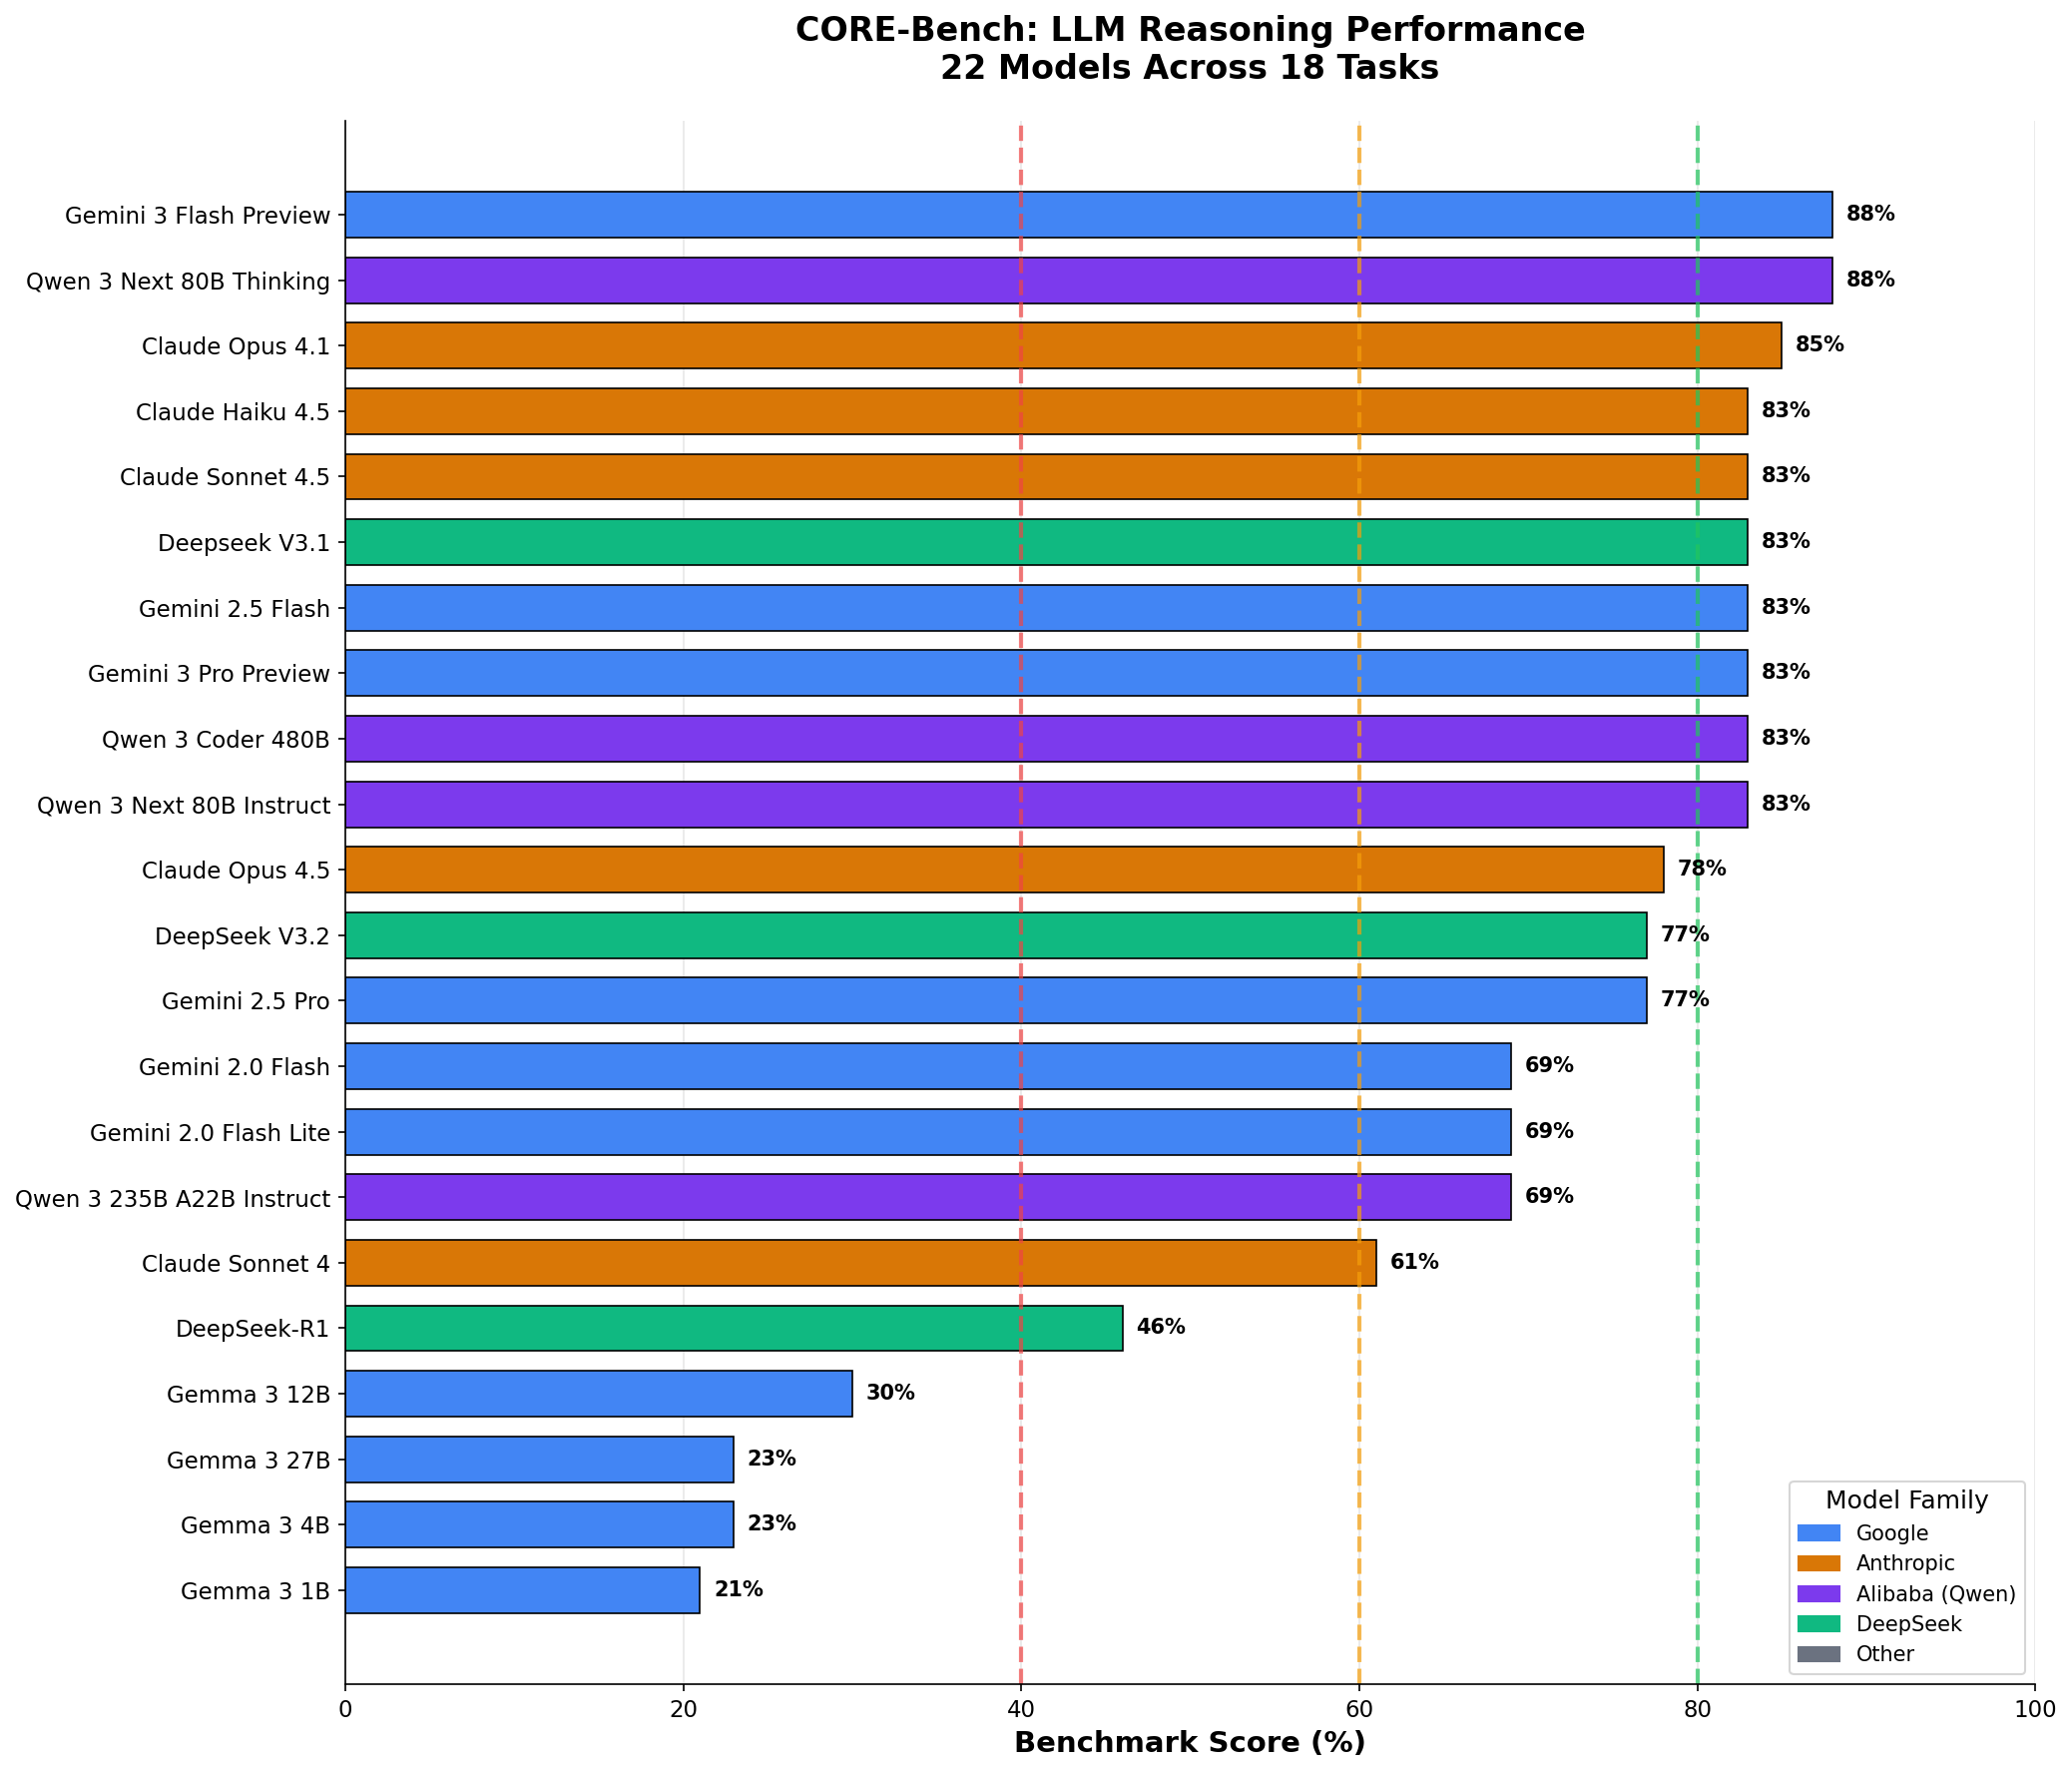

In [3]:
# ============================================================================
# FIGURE 1: OVERALL MODEL COMPARISON - CORE-BENCH LEADERBOARD
# ============================================================================
# Horizontal bar chart showing all 22 models ranked by benchmark score

fig1, ax1 = plt.subplots(figsize=(14, 12))

# Prepare data - already sorted
models = [m['model_name'] for m in models_with_results]
scores = [m['overall_score'] * 100 for m in models_with_results]
families = [m['family'] for m in models_with_results]

# Color mapping by family
family_colors = {
    'Google': '#4285F4',      # Google Blue
    'Anthropic': '#D97706',    # Anthropic Orange
    'Alibaba (Qwen)': '#7C3AED',  # Purple
    'DeepSeek': '#10B981',     # Green
    'Other': '#6B7280'         # Gray
}

bar_colors = [family_colors.get(f, '#6B7280') for f in families]

# Create horizontal bars
bars = ax1.barh(range(len(models)), scores, color=bar_colors, edgecolor='black', linewidth=0.8, height=0.7)

# Add value labels
for i, (bar, score) in enumerate(zip(bars, scores)):
    ax1.text(score + 0.8, bar.get_y() + bar.get_height()/2, 
            f'{score:.0f}%', va='center', ha='left', fontweight='bold', fontsize=10)

ax1.set_yticks(range(len(models)))
ax1.set_yticklabels(models, fontsize=11)
ax1.set_xlabel('Benchmark Score (%)', fontweight='bold', fontsize=14)
ax1.set_title('CORE-Bench: LLM Reasoning Performance\n22 Models Across 18 Tasks', 
              fontweight='bold', fontsize=16, pad=20)
ax1.set_xlim(0, 100)
ax1.invert_yaxis()

# Add performance threshold lines
ax1.axvline(x=80, color='#22C55E', linestyle='--', linewidth=2, alpha=0.7, label='High (80%)')
ax1.axvline(x=60, color='#F59E0B', linestyle='--', linewidth=2, alpha=0.7, label='Moderate (60%)')
ax1.axvline(x=40, color='#EF4444', linestyle='--', linewidth=2, alpha=0.7, label='Low (40%)')

# Add gridlines
ax1.grid(axis='x', alpha=0.3, linestyle='-', zorder=0)
ax1.set_axisbelow(True)

# Create legend for families
legend_patches = [mpatches.Patch(color=color, label=family) 
                  for family, color in family_colors.items()]
ax1.legend(handles=legend_patches, loc='lower right', title='Model Family', fontsize=10)

plt.tight_layout()

# Save in multiple formats
for fmt in ['png', 'pdf', 'svg']:
    fig1.savefig(f'publication_figures/{fmt}/fig1_model_leaderboard.{fmt}', 
                 dpi=300, bbox_inches='tight', facecolor='white')

print("Figure 1 saved: CORE-Bench Model Leaderboard")
plt.show()

Figure 2 saved: Model Family Performance Comparison


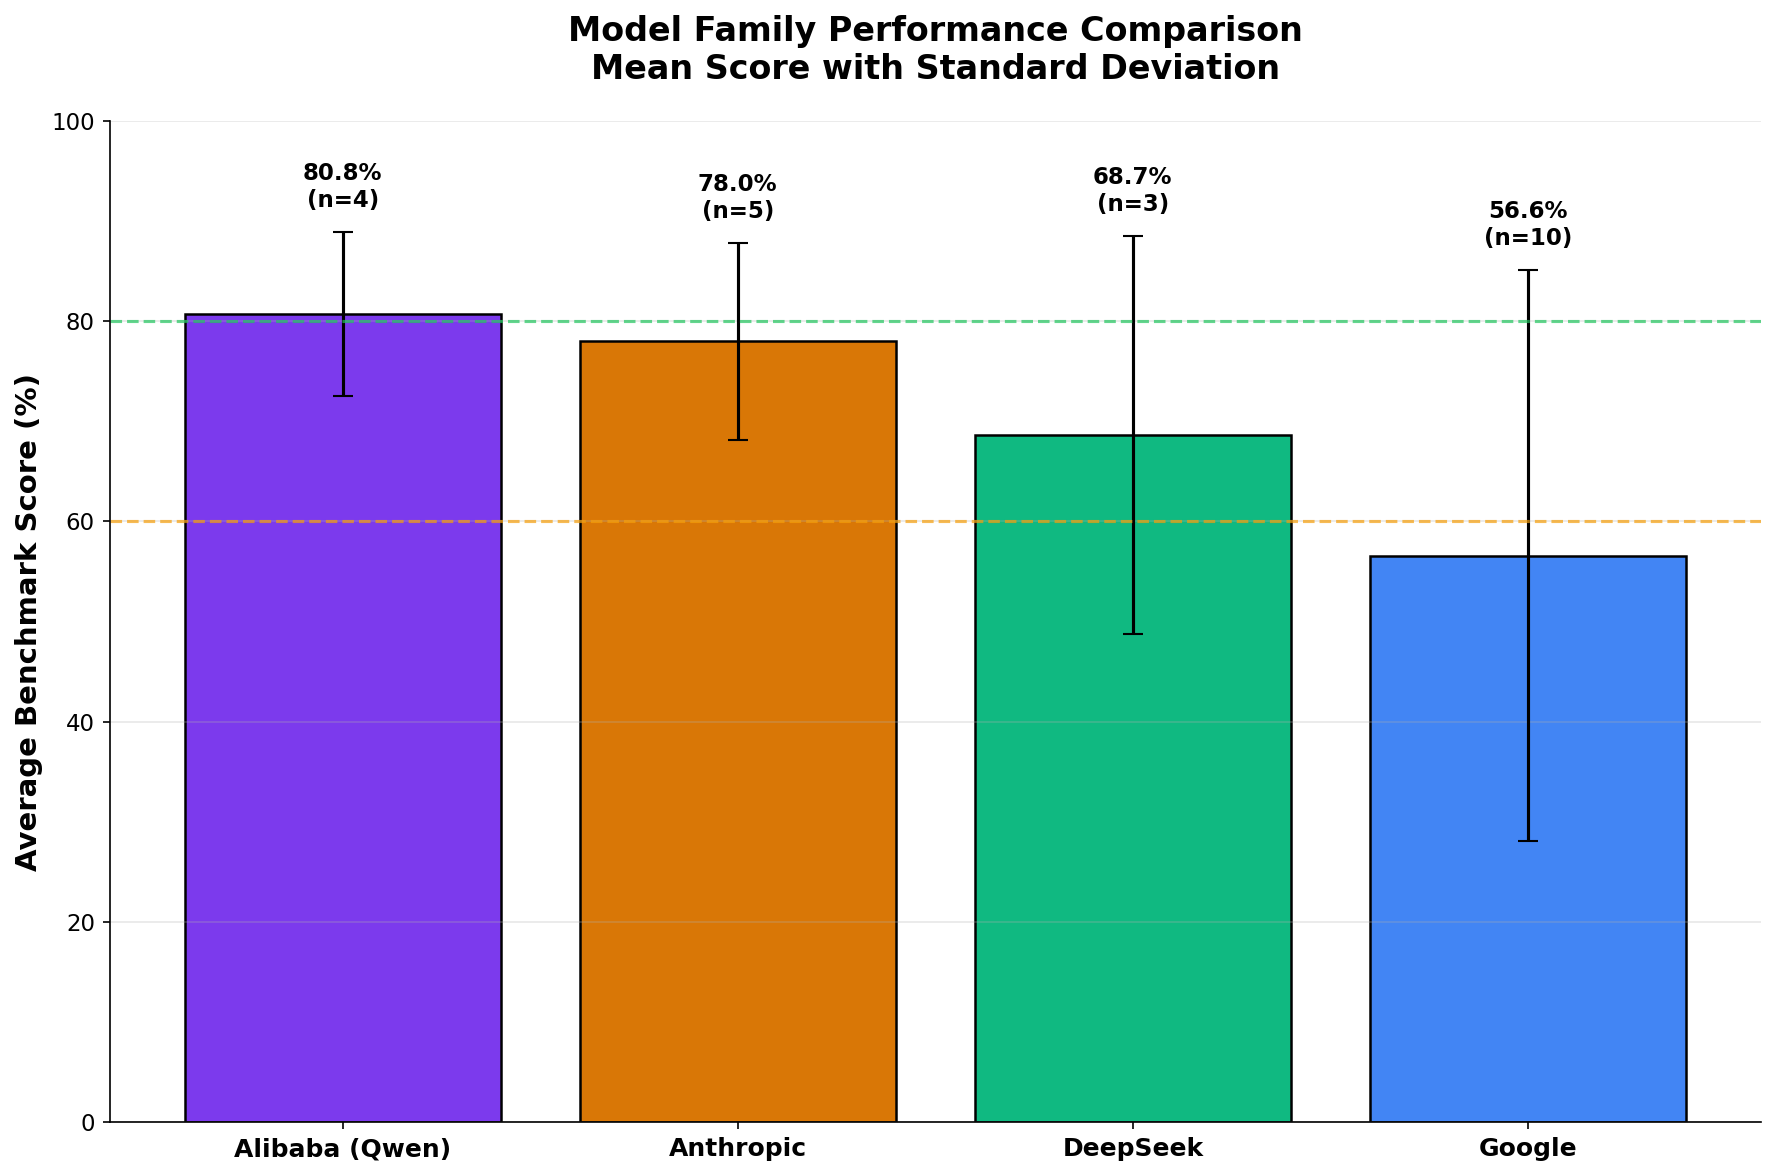

In [4]:
# ============================================================================
# FIGURE 2: MODEL FAMILY PERFORMANCE COMPARISON
# ============================================================================
# Grouped bar chart comparing model families

fig2, ax2 = plt.subplots(figsize=(12, 8))

# Group by family
family_data = extended_df.groupby('Family')['Score_Pct'].agg(['mean', 'std', 'count']).reset_index()
family_data = family_data.sort_values('mean', ascending=False)

# Create bars
x_pos = np.arange(len(family_data))
bars = ax2.bar(x_pos, family_data['mean'], 
               yerr=family_data['std'], 
               capsize=5,
               color=[family_colors.get(f, '#6B7280') for f in family_data['Family']],
               edgecolor='black', linewidth=1.2)

# Add value labels
for i, (bar, mean, count) in enumerate(zip(bars, family_data['mean'], family_data['count'])):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + family_data['std'].iloc[i] + 2,
            f'{mean:.1f}%\n(n={int(count)})', ha='center', va='bottom', fontweight='bold', fontsize=11)

ax2.set_xticks(x_pos)
ax2.set_xticklabels(family_data['Family'], fontsize=12, fontweight='bold')
ax2.set_ylabel('Average Benchmark Score (%)', fontweight='bold', fontsize=14)
ax2.set_title('Model Family Performance Comparison\nMean Score with Standard Deviation', 
              fontweight='bold', fontsize=16, pad=20)
ax2.set_ylim(0, 100)

# Add horizontal reference lines
ax2.axhline(y=80, color='#22C55E', linestyle='--', linewidth=1.5, alpha=0.7)
ax2.axhline(y=60, color='#F59E0B', linestyle='--', linewidth=1.5, alpha=0.7)

ax2.grid(axis='y', alpha=0.3, linestyle='-')

plt.tight_layout()

# Save
for fmt in ['png', 'pdf', 'svg']:
    fig2.savefig(f'publication_figures/{fmt}/fig2_family_comparison.{fmt}', 
                 dpi=300, bbox_inches='tight', facecolor='white')

print("Figure 2 saved: Model Family Performance Comparison")
plt.show()

C:\Users\17067\AppData\Local\Temp\ipykernel_24096\1786960461.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(plot_data, labels=plot_labels, patch_artist=True,


Figure 3 saved: Performance Distribution by Model Tier


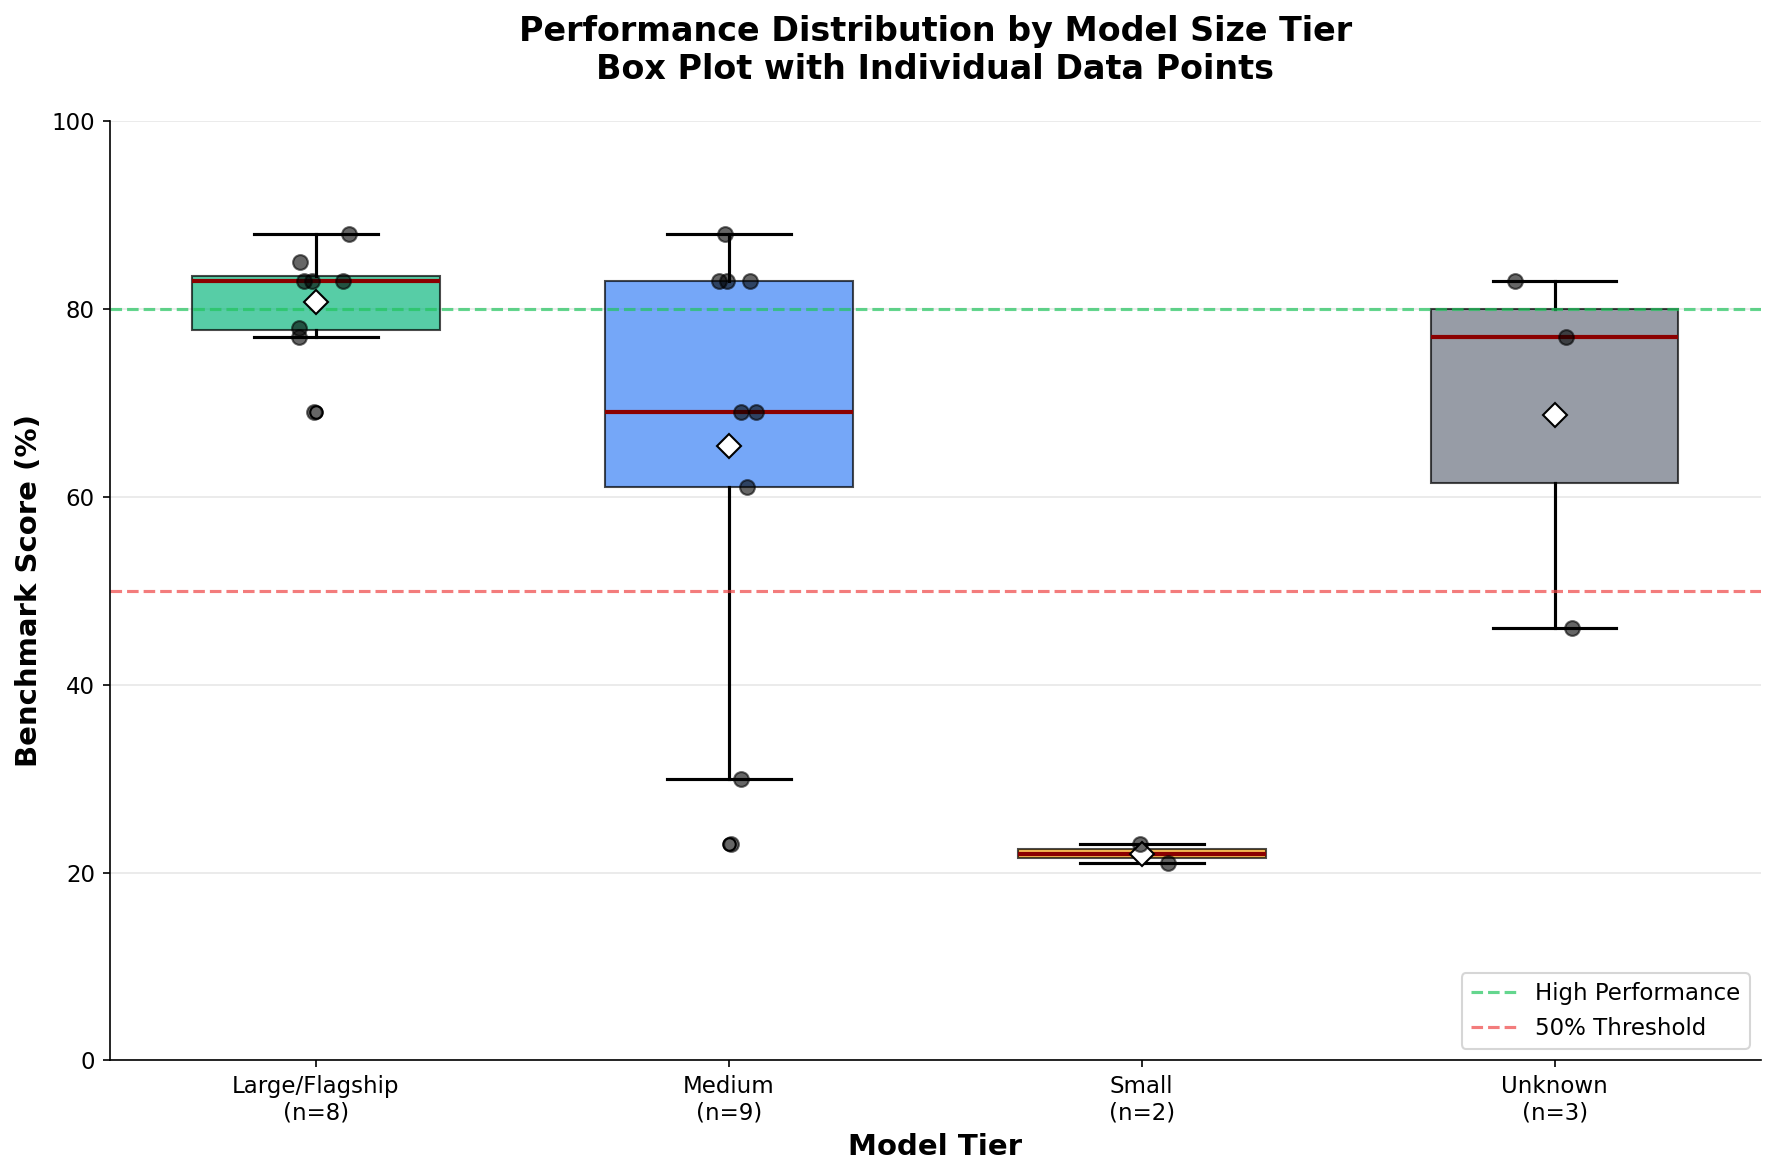

In [5]:
# ============================================================================
# FIGURE 3: PERFORMANCE DISTRIBUTION BY MODEL TIER
# ============================================================================
# Box plot showing score distribution across model size tiers

fig3, ax3 = plt.subplots(figsize=(12, 8))

# Define tier order
tier_order = ['Large/Flagship', 'Medium', 'Small', 'Unknown']
tier_colors = ['#10B981', '#3B82F6', '#F59E0B', '#6B7280']

# Filter and order data
plot_data = []
plot_labels = []
for tier in tier_order:
    tier_scores = extended_df[extended_df['Tier'] == tier]['Score_Pct'].values
    if len(tier_scores) > 0:
        plot_data.append(tier_scores)
        plot_labels.append(f"{tier}\n(n={len(tier_scores)})")

# Create box plot
bp = ax3.boxplot(plot_data, labels=plot_labels, patch_artist=True, 
                  widths=0.6, showmeans=True, meanprops=dict(marker='D', markerfacecolor='white', 
                                                             markeredgecolor='black', markersize=8))

# Color the boxes
for patch, color in zip(bp['boxes'], tier_colors[:len(plot_data)]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Style whiskers and caps
for whisker in bp['whiskers']:
    whisker.set(color='black', linewidth=1.5)
for cap in bp['caps']:
    cap.set(color='black', linewidth=1.5)
for median in bp['medians']:
    median.set(color='darkred', linewidth=2)

# Add individual points
for i, (tier_scores, color) in enumerate(zip(plot_data, tier_colors[:len(plot_data)])):
    x = np.random.normal(i + 1, 0.05, len(tier_scores))
    ax3.scatter(x, tier_scores, alpha=0.6, color='black', s=50, zorder=5)

ax3.set_ylabel('Benchmark Score (%)', fontweight='bold', fontsize=14)
ax3.set_xlabel('Model Tier', fontweight='bold', fontsize=14)
ax3.set_title('Performance Distribution by Model Size Tier\nBox Plot with Individual Data Points', 
              fontweight='bold', fontsize=16, pad=20)
ax3.set_ylim(0, 100)

# Add reference lines
ax3.axhline(y=80, color='#22C55E', linestyle='--', linewidth=1.5, alpha=0.7, label='High Performance')
ax3.axhline(y=50, color='#EF4444', linestyle='--', linewidth=1.5, alpha=0.7, label='50% Threshold')

ax3.legend(loc='lower right')
ax3.grid(axis='y', alpha=0.3, linestyle='-')

plt.tight_layout()

# Save
for fmt in ['png', 'pdf', 'svg']:
    fig3.savefig(f'publication_figures/{fmt}/fig3_tier_distribution.{fmt}', 
                 dpi=300, bbox_inches='tight', facecolor='white')

print("Figure 3 saved: Performance Distribution by Model Tier")
plt.show()

Figure 4 saved: Top 10 Models on CORE-Bench


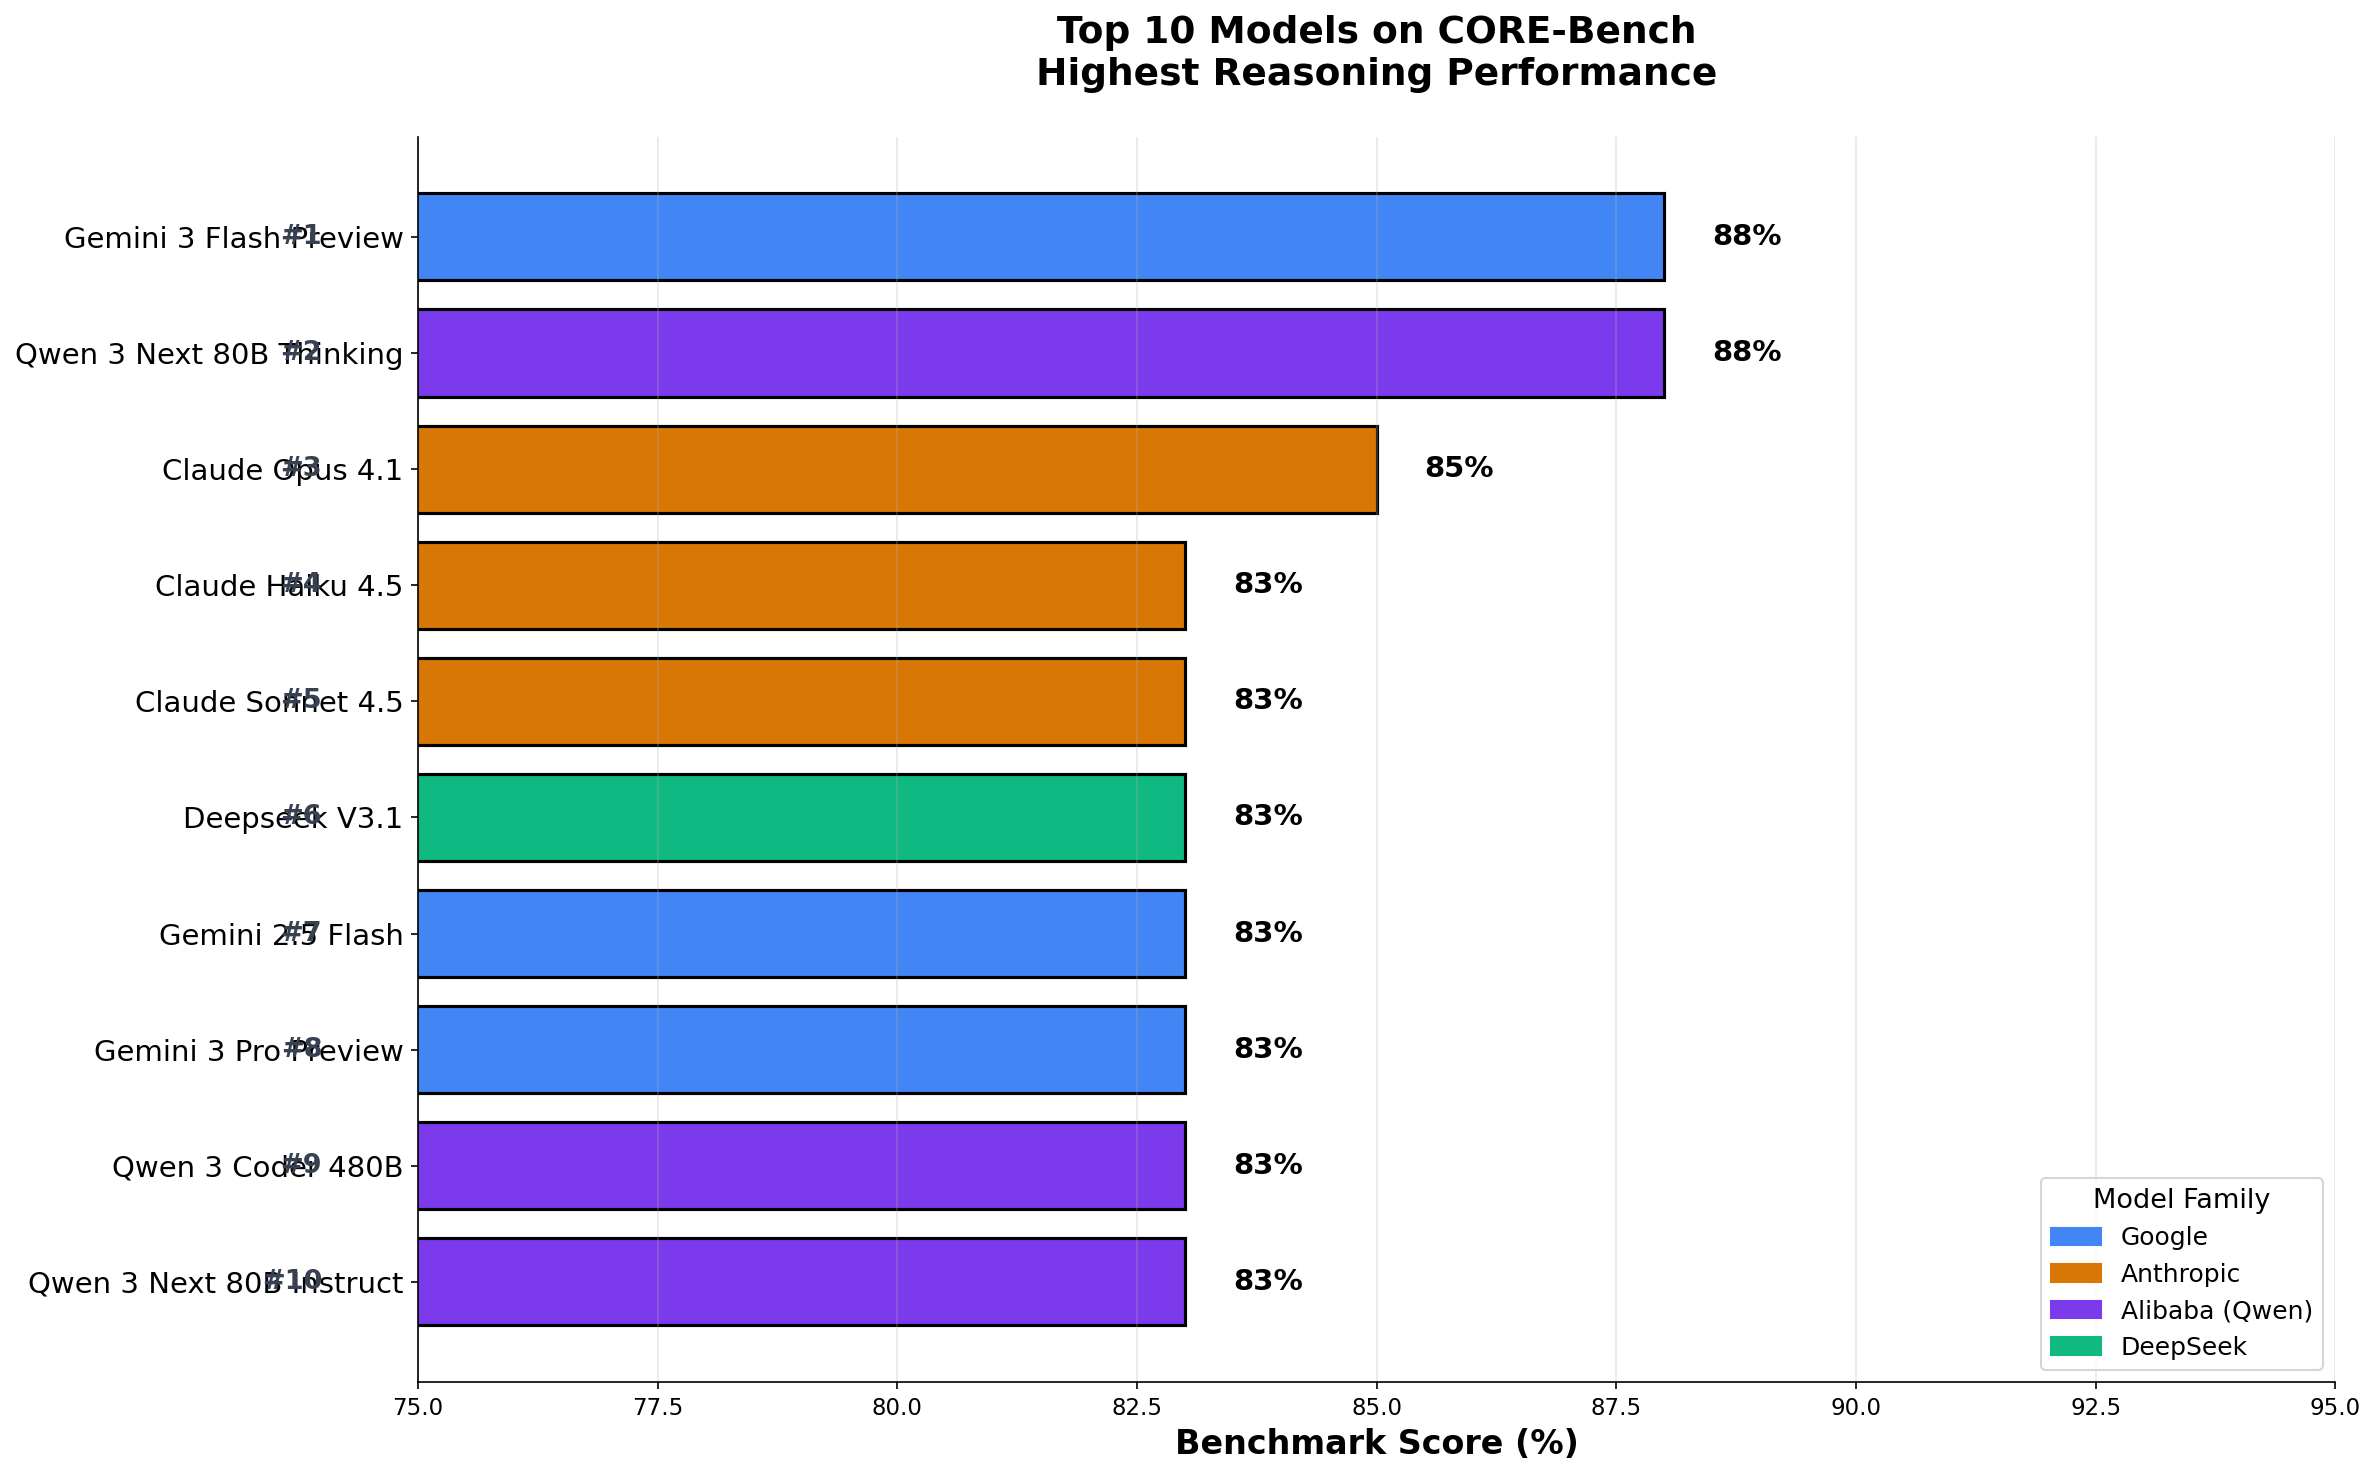

In [13]:
# ============================================================================
# FIGURE 4: TOP 10 MODELS - FOCUSED COMPARISON
# ============================================================================
# Clean bar chart of top performers

fig4, ax4 = plt.subplots(figsize=(16, 10))  # Increased figure size

# Get top 10
top_10 = models_with_results[:10]
models_top = [m['model_name'] for m in top_10]
scores_top = [m['overall_score'] * 100 for m in top_10]
families_top = [m['family'] for m in top_10]

# Colors by family
bar_colors_top = [family_colors.get(f, '#6B7280') for f in families_top]

# Create bars with larger height
bars = ax4.barh(range(len(models_top)), scores_top, color=bar_colors_top, 
                edgecolor='black', linewidth=1.5, height=0.75)

# Add value labels with larger font
for i, (bar, score) in enumerate(zip(bars, scores_top)):
    ax4.text(score + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{score:.0f}%', va='center', ha='left', fontweight='bold', fontsize=14)

ax4.set_yticks(range(len(models_top)))
ax4.set_yticklabels(models_top, fontsize=14)
ax4.set_xlabel('Benchmark Score (%)', fontweight='bold', fontsize=16)
ax4.set_title('Top 10 Models on CORE-Bench\nHighest Reasoning Performance', 
              fontweight='bold', fontsize=18, pad=25)
ax4.set_xlim(75, 95)
ax4.invert_yaxis()

# Add rank numbers with larger font
for i in range(len(models_top)):
    ax4.text(74, i, f'#{i+1}', ha='right', va='center', fontweight='bold', 
             fontsize=13, color='#374151')

ax4.grid(axis='x', alpha=0.3, linestyle='-')

# Legend with larger font
legend_patches = [mpatches.Patch(color=color, label=family) 
                  for family, color in family_colors.items() if family in families_top]
ax4.legend(handles=legend_patches, loc='lower right', title='Model Family', 
           fontsize=12, title_fontsize=13)

plt.tight_layout()

# Save
for fmt in ['png', 'pdf', 'svg']:
    fig4.savefig(f'publication_figures/{fmt}/fig4_top10_models.{fmt}', 
                 dpi=300, bbox_inches='tight', facecolor='white')

print("Figure 4 saved: Top 10 Models on CORE-Bench")
plt.show()

Figure 5 saved: Score Distribution Histogram


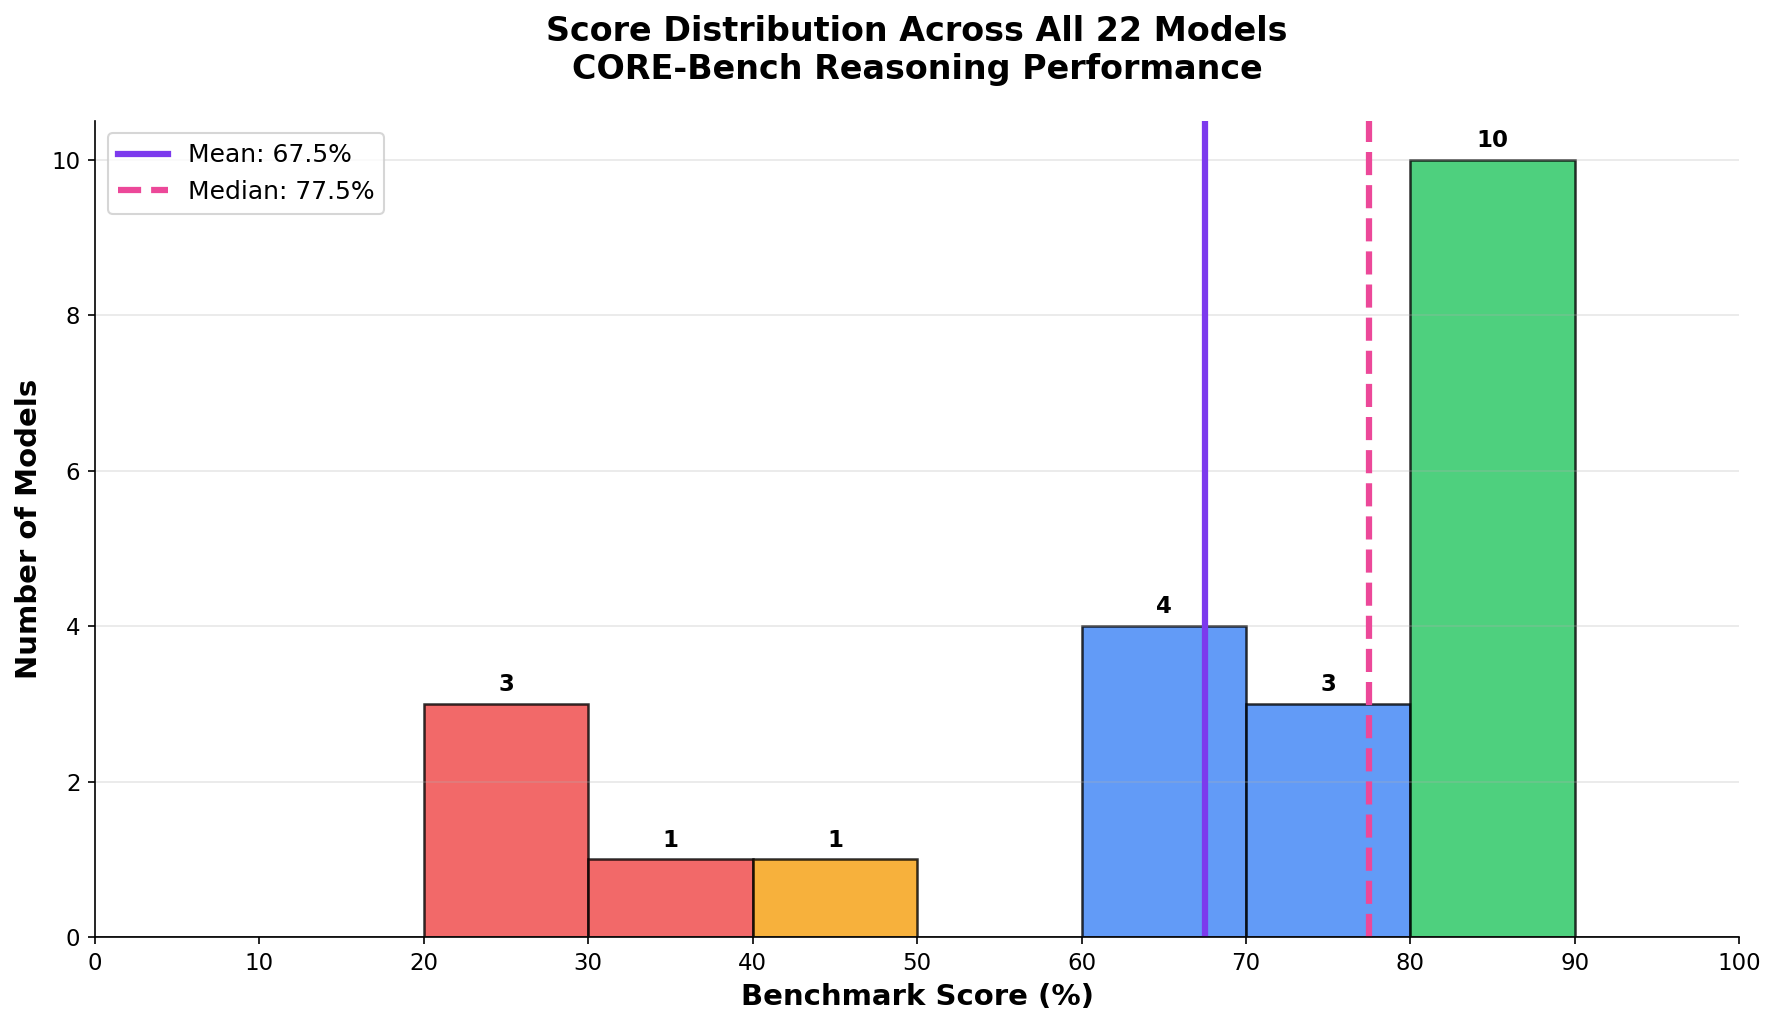

In [7]:
# ============================================================================
# FIGURE 5: SCORE DISTRIBUTION HISTOGRAM
# ============================================================================
# Distribution of scores across all 22 models

fig5, ax5 = plt.subplots(figsize=(12, 7))

all_scores = [m['overall_score'] * 100 for m in models_with_results]

# Create histogram
n, bins, patches = ax5.hist(all_scores, bins=10, range=(0, 100), 
                             color='#3B82F6', edgecolor='black', linewidth=1.2, alpha=0.8)

# Color bars by performance level
for i, (patch, bin_left) in enumerate(zip(patches, bins[:-1])):
    if bin_left >= 80:
        patch.set_facecolor('#22C55E')  # Green - high
    elif bin_left >= 60:
        patch.set_facecolor('#3B82F6')  # Blue - good
    elif bin_left >= 40:
        patch.set_facecolor('#F59E0B')  # Orange - moderate
    else:
        patch.set_facecolor('#EF4444')  # Red - low

# Add mean and median lines
mean_score = np.mean(all_scores)
median_score = np.median(all_scores)

ax5.axvline(x=mean_score, color='#7C3AED', linestyle='-', linewidth=3, 
            label=f'Mean: {mean_score:.1f}%')
ax5.axvline(x=median_score, color='#EC4899', linestyle='--', linewidth=3, 
            label=f'Median: {median_score:.1f}%')

ax5.set_xlabel('Benchmark Score (%)', fontweight='bold', fontsize=14)
ax5.set_ylabel('Number of Models', fontweight='bold', fontsize=14)
ax5.set_title('Score Distribution Across All 22 Models\nCORE-Bench Reasoning Performance', 
              fontweight='bold', fontsize=16, pad=20)
ax5.set_xlim(0, 100)
ax5.set_xticks(range(0, 101, 10))

ax5.legend(loc='upper left', fontsize=12)
ax5.grid(axis='y', alpha=0.3, linestyle='-')

# Add count labels on bars
for patch in patches:
    height = patch.get_height()
    if height > 0:
        ax5.text(patch.get_x() + patch.get_width()/2, height + 0.1, 
                f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()

# Save
for fmt in ['png', 'pdf', 'svg']:
    fig5.savefig(f'publication_figures/{fmt}/fig5_score_distribution.{fmt}', 
                 dpi=300, bbox_inches='tight', facecolor='white')

print("Figure 5 saved: Score Distribution Histogram")
plt.show()

Figure 6 saved: Performance Gap Analysis


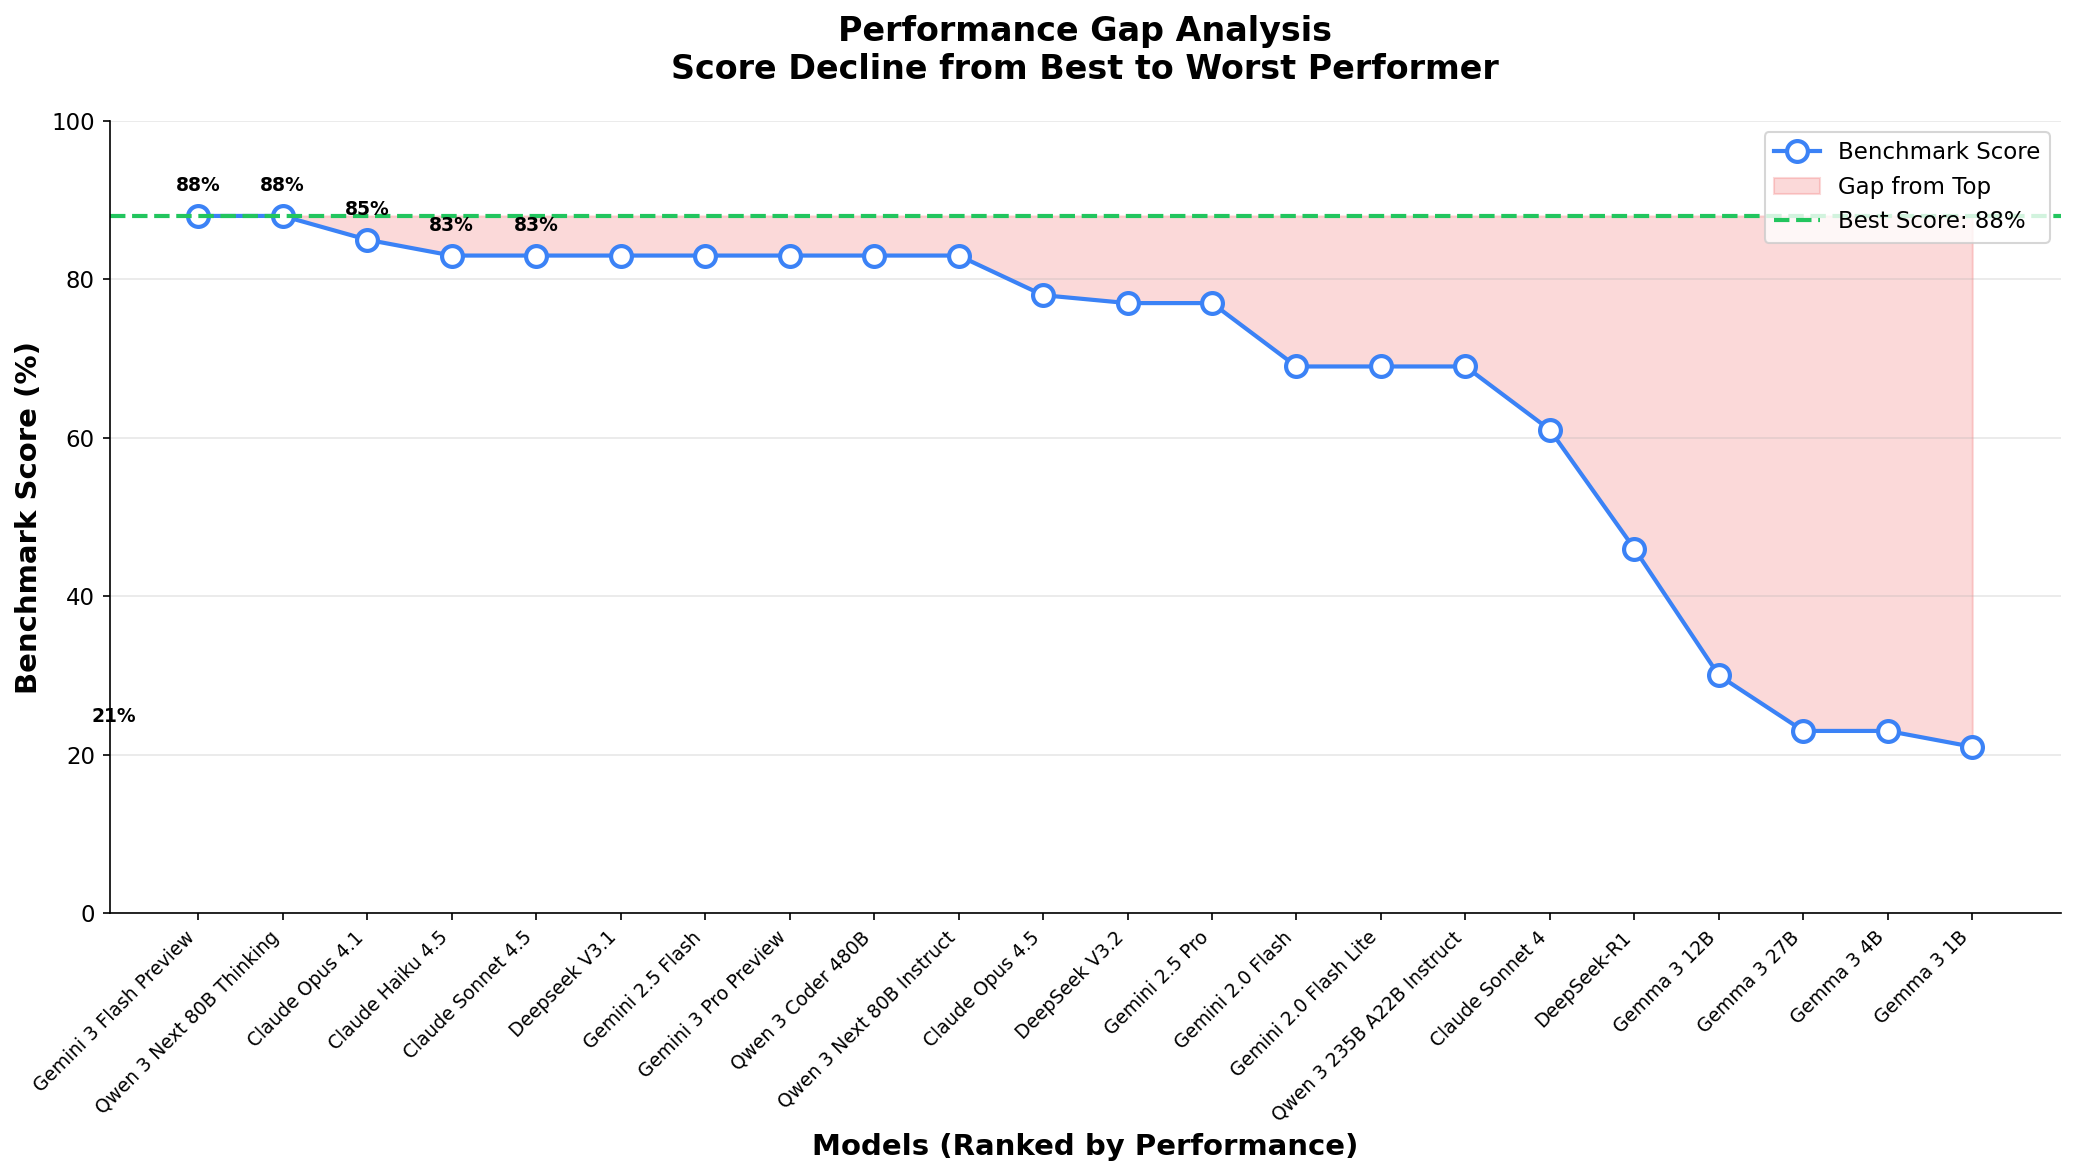

In [8]:
# ============================================================================
# FIGURE 6: PERFORMANCE GAP ANALYSIS
# ============================================================================
# Visualize the gap between top and bottom performers

fig6, ax6 = plt.subplots(figsize=(14, 8))

# Calculate metrics
models = [m['model_name'] for m in models_with_results]
scores = [m['overall_score'] * 100 for m in models_with_results]
top_score = max(scores)

# Calculate gap from top
gaps = [top_score - s for s in scores]

# Create connected scatter plot
x_pos = range(len(models))

# Plot scores as line with markers
ax6.plot(x_pos, scores, 'o-', color='#3B82F6', linewidth=2, markersize=10, 
         markerfacecolor='white', markeredgewidth=2, label='Benchmark Score')

# Fill area between score and top
ax6.fill_between(x_pos, scores, top_score, alpha=0.2, color='#EF4444', label='Gap from Top')

# Add horizontal line for top score
ax6.axhline(y=top_score, color='#22C55E', linestyle='--', linewidth=2, 
            label=f'Best Score: {top_score:.0f}%')

# Add score labels for key models (top 5 and bottom 3)
for i in list(range(5)) + list(range(-3, 0)):
    ax6.annotate(f'{scores[i]:.0f}%', (i, scores[i]), 
                textcoords="offset points", xytext=(0, 12), 
                ha='center', fontweight='bold', fontsize=9)

ax6.set_xticks(x_pos)
ax6.set_xticklabels(models, rotation=45, ha='right', fontsize=9)
ax6.set_ylabel('Benchmark Score (%)', fontweight='bold', fontsize=14)
ax6.set_xlabel('Models (Ranked by Performance)', fontweight='bold', fontsize=14)
ax6.set_title('Performance Gap Analysis\nScore Decline from Best to Worst Performer', 
              fontweight='bold', fontsize=16, pad=20)
ax6.set_ylim(0, 100)

ax6.legend(loc='upper right', fontsize=11)
ax6.grid(axis='y', alpha=0.3, linestyle='-')

plt.tight_layout()

# Save
for fmt in ['png', 'pdf', 'svg']:
    fig6.savefig(f'publication_figures/{fmt}/fig6_gap_analysis.{fmt}', 
                 dpi=300, bbox_inches='tight', facecolor='white')

print("Figure 6 saved: Performance Gap Analysis")
plt.show()

Figure 7 saved: Model Family Radar Comparison (with family colors)


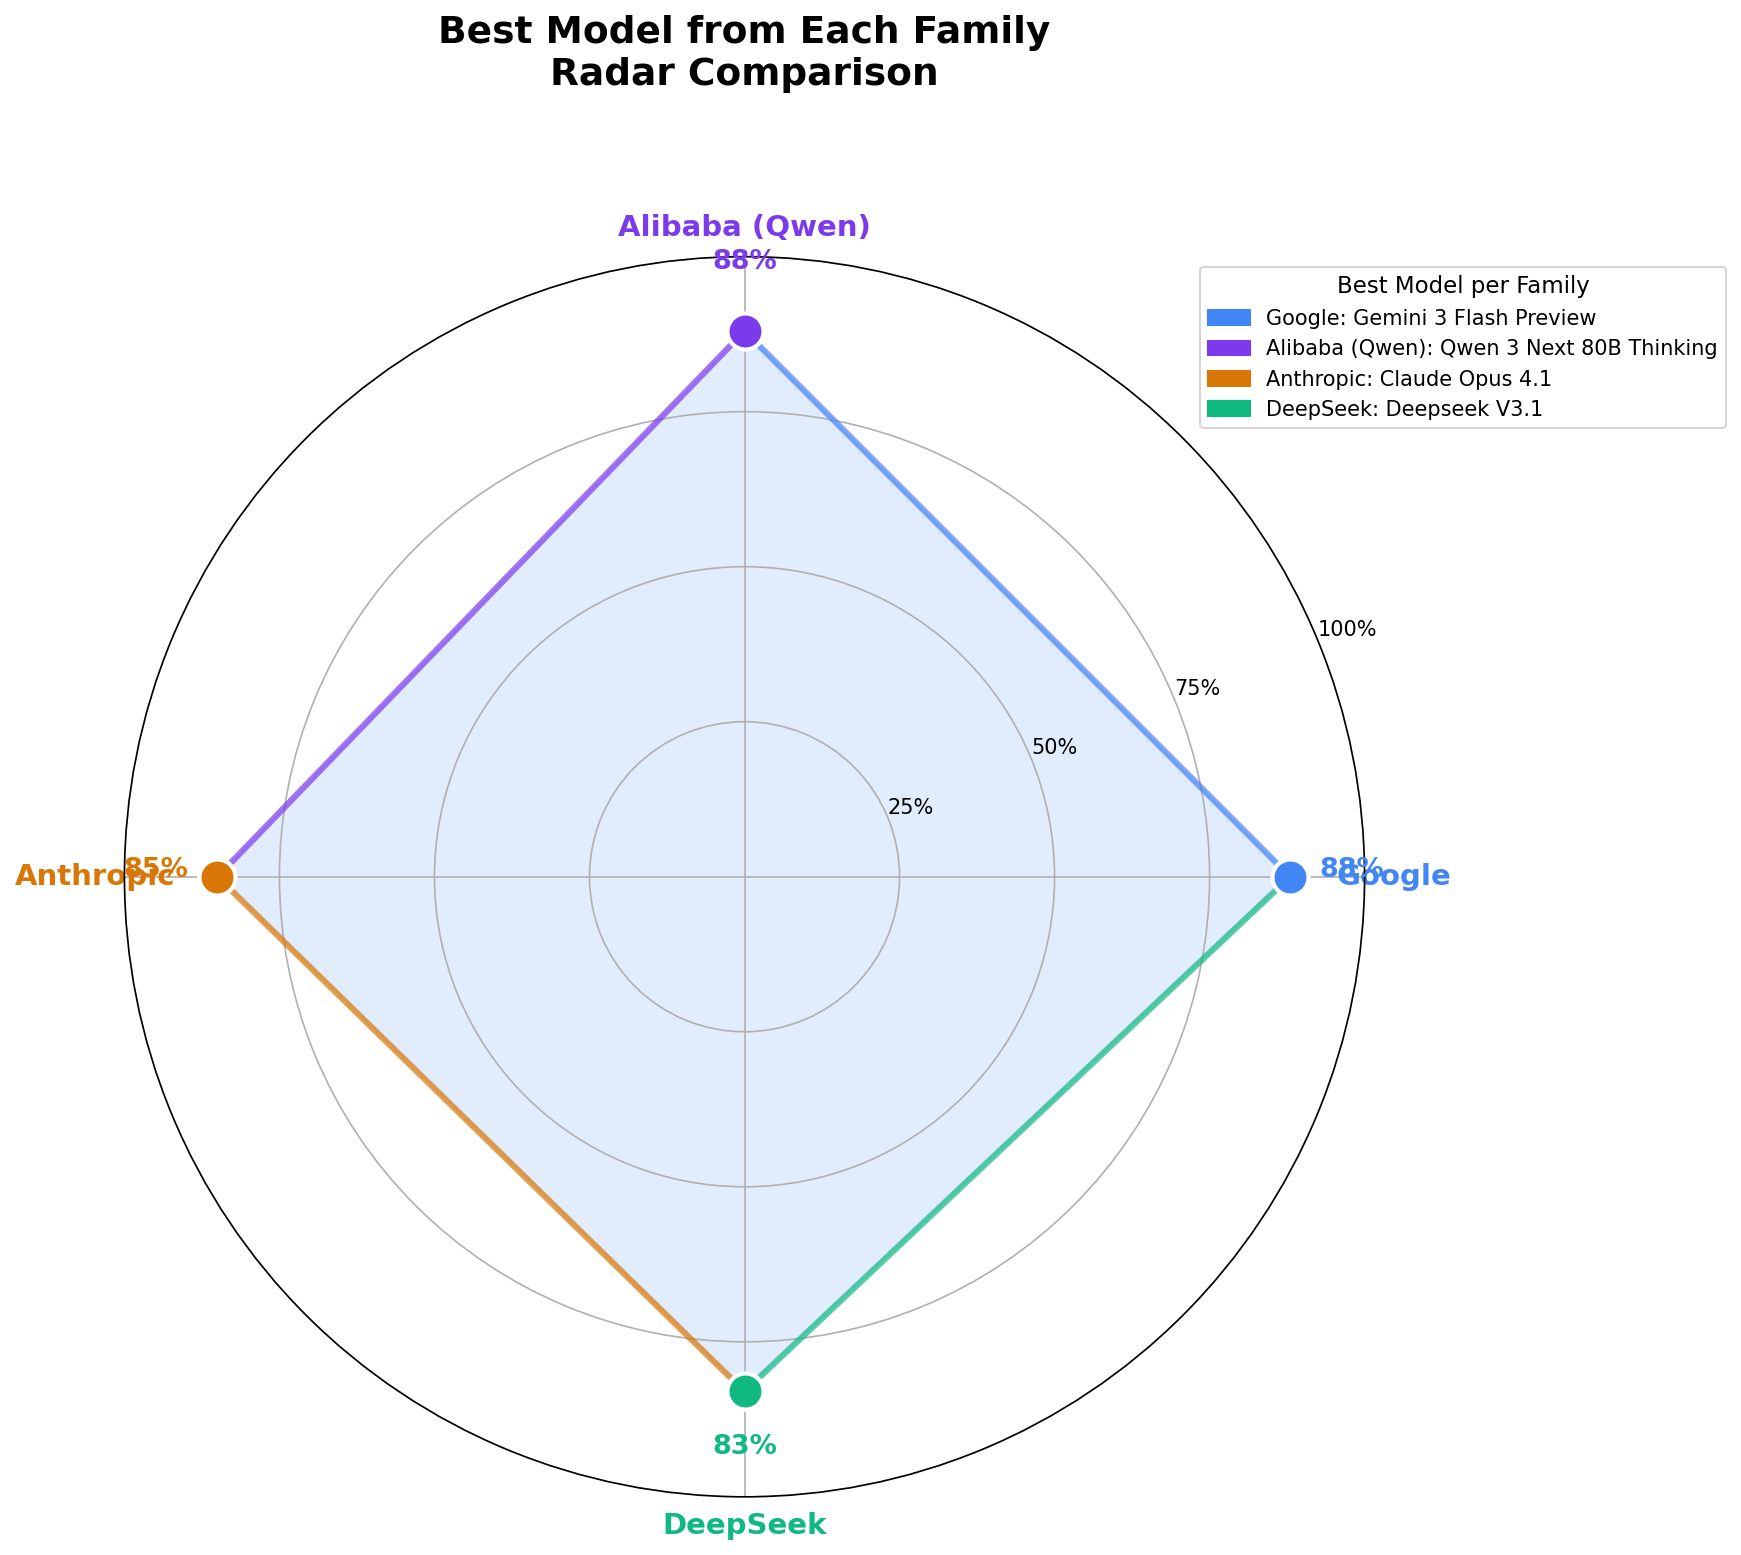

In [14]:
# ============================================================================
# FIGURE 7: MODEL FAMILY RADAR COMPARISON
# ============================================================================
# Compare key models from each family with distinct colors

fig7, ax7 = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))

# Select representative models (best from each family)
family_best = {}
for m in models_with_results:
    family = m['family']
    if family not in family_best:
        family_best[family] = m

# Create data for radar chart
categories = list(family_best.keys())
values = [family_best[f]['overall_score'] * 100 for f in categories]

# Close the radar chart
values_closed = values + [values[0]]
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles_closed = angles + [angles[0]]

# Plot each family segment with its own color
for i, (angle, value, category) in enumerate(zip(angles, values, categories)):
    color = family_colors.get(category, '#6B7280')
    # Plot individual point with family color
    ax7.scatter([angle], [value], c=color, s=300, zorder=5, edgecolor='white', linewidth=2)
    
    # Add value labels with family color
    ax7.annotate(f'{value:.0f}%', 
                xy=(angle, value), 
                xytext=(angle, value + 10),
                ha='center', fontweight='bold', fontsize=13, color=color)

# Plot connecting lines between points with gradient
for i in range(len(angles)):
    next_i = (i + 1) % len(angles)
    color1 = family_colors.get(categories[i], '#6B7280')
    ax7.plot([angles[i], angles_closed[i+1]], 
             [values[i], values_closed[i+1]], 
             'o-', linewidth=3, color=color1, alpha=0.7, markersize=0)

# Fill with gradient effect - use average color
ax7.fill(angles_closed, values_closed, alpha=0.15, color='#3B82F6')

# Style the category labels with family colors
ax7.set_xticks(angles)
labels = ax7.set_xticklabels(categories, fontsize=14, fontweight='bold')
for label, category in zip(labels, categories):
    label.set_color(family_colors.get(category, '#374151'))

ax7.set_ylim(0, 100)
ax7.set_title('Best Model from Each Family\nRadar Comparison', 
              fontweight='bold', fontsize=18, pad=35, y=1.08)

# Add concentric circles at 25, 50, 75
ax7.set_yticks([25, 50, 75, 100])
ax7.set_yticklabels(['25%', '50%', '75%', '100%'], fontsize=10)

# Add legend for family colors
legend_patches = [mpatches.Patch(color=family_colors.get(cat, '#6B7280'), 
                                  label=f"{cat}: {family_best[cat]['model_name']}") 
                  for cat in categories]
ax7.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1.3, 1.0),
           title='Best Model per Family', fontsize=10, title_fontsize=11)

plt.tight_layout()

# Save
for fmt in ['png', 'pdf', 'svg']:
    fig7.savefig(f'publication_figures/{fmt}/fig7_family_radar.{fmt}', 
                 dpi=300, bbox_inches='tight', facecolor='white')

print("Figure 7 saved: Model Family Radar Comparison (with family colors)")
plt.show()

Figure 8 saved: Performance Tiers Donut Chart


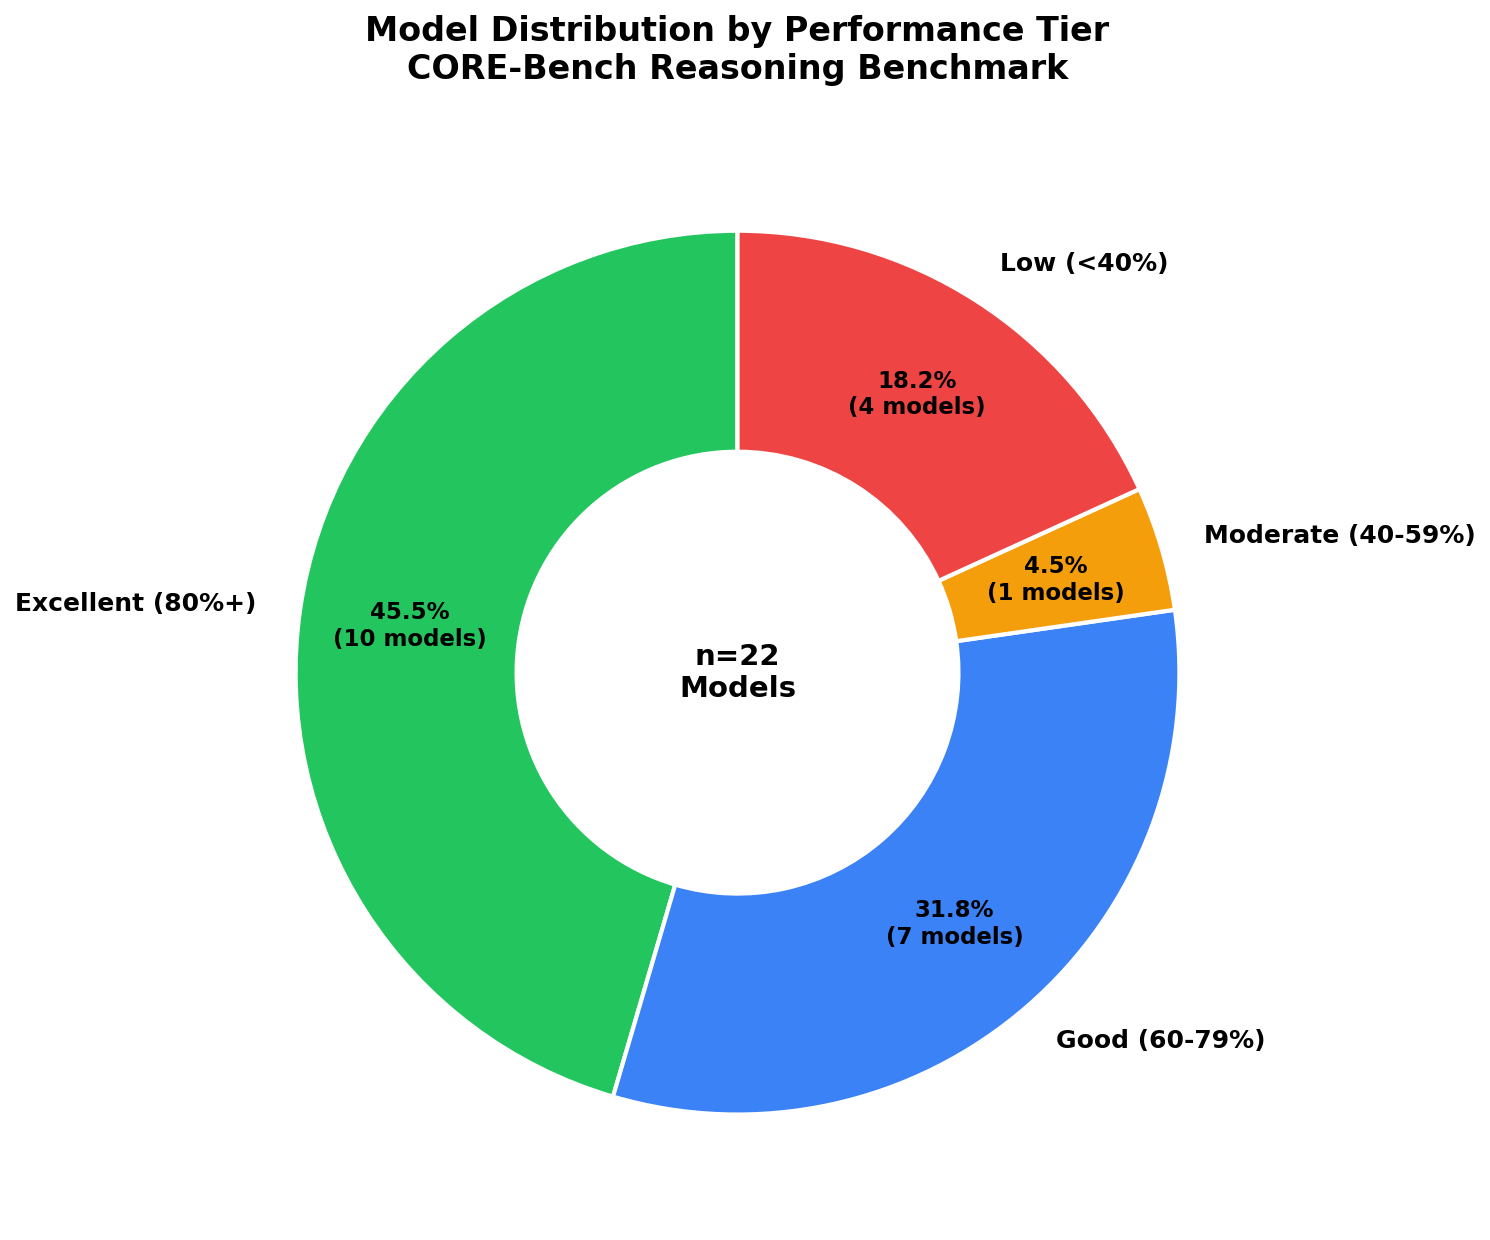

In [10]:
# ============================================================================
# FIGURE 8: PERFORMANCE TIERS DONUT CHART
# ============================================================================
# Categorize models into performance tiers

fig8, ax8 = plt.subplots(figsize=(10, 10))

# Define tiers
tier_counts = {
    'Excellent (80%+)': sum(1 for m in models_with_results if m['overall_score'] >= 0.80),
    'Good (60-79%)': sum(1 for m in models_with_results if 0.60 <= m['overall_score'] < 0.80),
    'Moderate (40-59%)': sum(1 for m in models_with_results if 0.40 <= m['overall_score'] < 0.60),
    'Low (<40%)': sum(1 for m in models_with_results if m['overall_score'] < 0.40)
}

# Filter out empty tiers
tier_counts = {k: v for k, v in tier_counts.items() if v > 0}
labels = list(tier_counts.keys())
sizes = list(tier_counts.values())

# Colors
tier_colors = ['#22C55E', '#3B82F6', '#F59E0B', '#EF4444']

# Create donut chart
wedges, texts, autotexts = ax8.pie(sizes, labels=labels, colors=tier_colors[:len(sizes)],
                                    autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*sum(sizes))} models)',
                                    pctdistance=0.75, startangle=90,
                                    wedgeprops=dict(width=0.5, edgecolor='white', linewidth=2))

# Style labels
for autotext in autotexts:
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)
for text in texts:
    text.set_fontweight('bold')
    text.set_fontsize(12)

# Add center text
ax8.text(0, 0, f'n={sum(sizes)}\nModels', ha='center', va='center', 
         fontweight='bold', fontsize=14)

ax8.set_title('Model Distribution by Performance Tier\nCORE-Bench Reasoning Benchmark', 
              fontweight='bold', fontsize=16, pad=20)

plt.tight_layout()

# Save
for fmt in ['png', 'pdf', 'svg']:
    fig8.savefig(f'publication_figures/{fmt}/fig8_performance_tiers.{fmt}', 
                 dpi=300, bbox_inches='tight', facecolor='white')

print("Figure 8 saved: Performance Tiers Donut Chart")
plt.show()

Figure 9 saved: Model Ranking Analysis


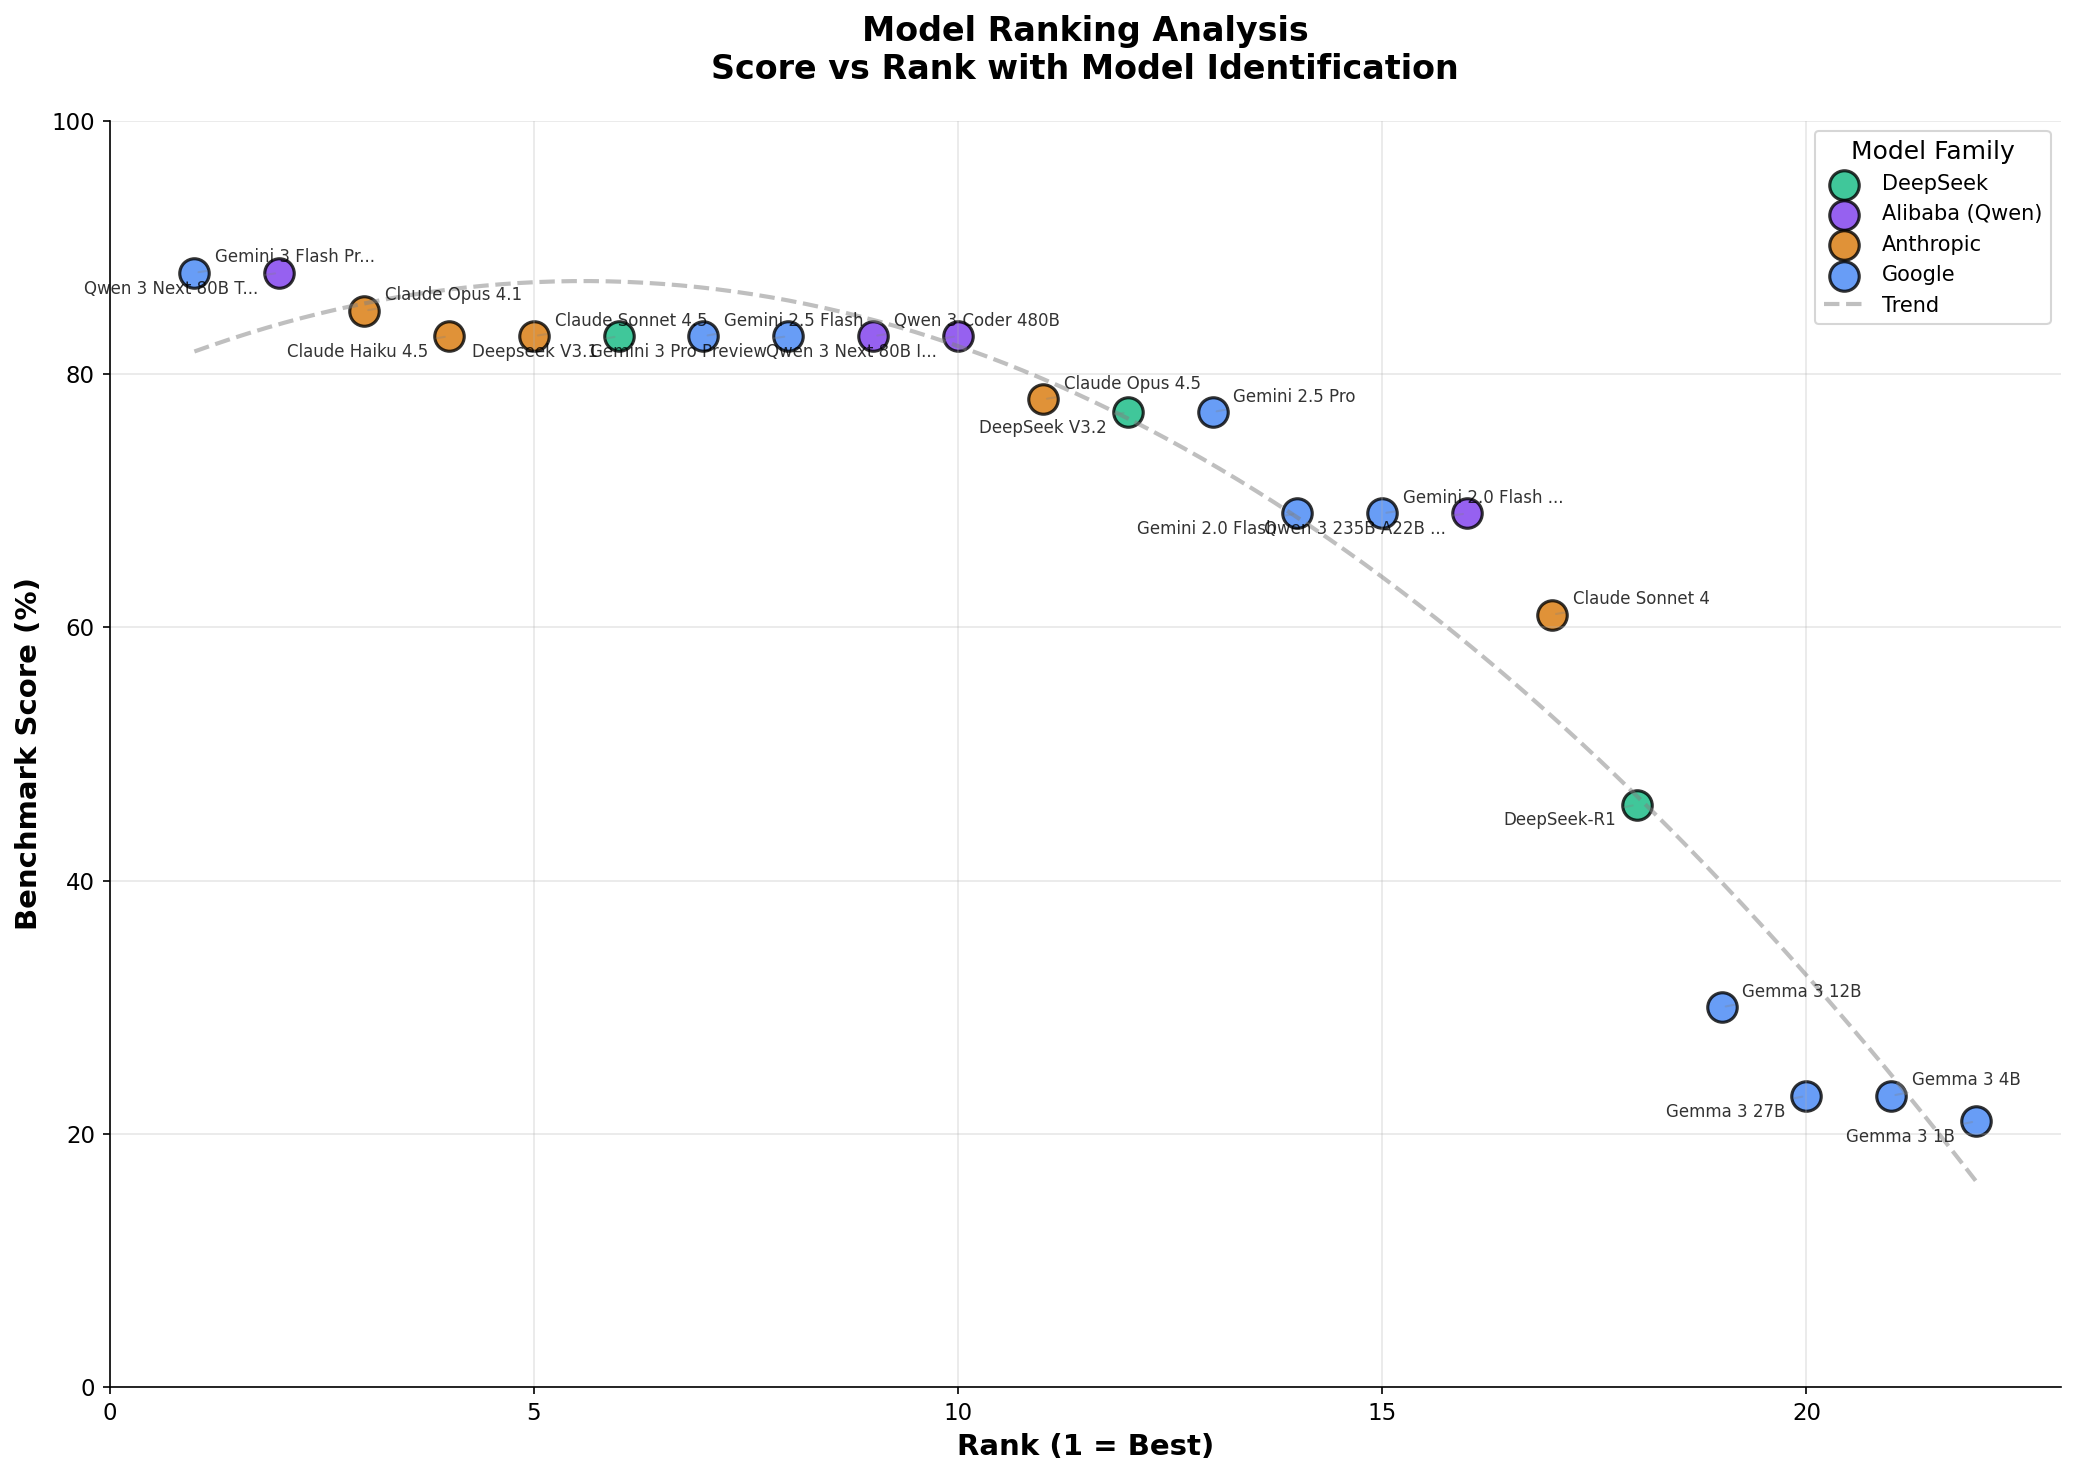

In [11]:
# ============================================================================
# FIGURE 9: COMPARATIVE ANALYSIS - SCATTER WITH ANNOTATIONS
# ============================================================================
# Scatter plot showing rank vs score with model annotations

fig9, ax9 = plt.subplots(figsize=(14, 10))

# Prepare data
ranks = list(range(1, len(models_with_results) + 1))
scores = [m['overall_score'] * 100 for m in models_with_results]
families = [m['family'] for m in models_with_results]
names = [m['model_name'] for m in models_with_results]

# Plot by family
for family in set(families):
    mask = [f == family for f in families]
    family_ranks = [r for r, m in zip(ranks, mask) if m]
    family_scores = [s for s, m in zip(scores, mask) if m]
    ax9.scatter(family_ranks, family_scores, 
               c=family_colors.get(family, '#6B7280'),
               s=200, alpha=0.8, edgecolor='black', linewidth=1.5,
               label=family)

# Add model name annotations
for i, (rank, score, name) in enumerate(zip(ranks, scores, names)):
    # Shorten long names
    short_name = name if len(name) <= 20 else name[:17] + '...'
    
    # Alternate label positions to avoid overlap
    offset = (10, 5) if i % 2 == 0 else (-10, -10)
    ha = 'left' if i % 2 == 0 else 'right'
    
    ax9.annotate(short_name, (rank, score), 
                textcoords="offset points", xytext=offset,
                fontsize=8, ha=ha, alpha=0.8,
                arrowprops=dict(arrowstyle='-', color='gray', alpha=0.3))

ax9.set_xlabel('Rank (1 = Best)', fontweight='bold', fontsize=14)
ax9.set_ylabel('Benchmark Score (%)', fontweight='bold', fontsize=14)
ax9.set_title('Model Ranking Analysis\nScore vs Rank with Model Identification', 
              fontweight='bold', fontsize=16, pad=20)
ax9.set_xlim(0, len(models_with_results) + 1)
ax9.set_ylim(0, 100)

# Add trend line
z = np.polyfit(ranks, scores, 2)
p = np.poly1d(z)
x_line = np.linspace(1, len(ranks), 100)
ax9.plot(x_line, p(x_line), '--', color='gray', alpha=0.5, linewidth=2, label='Trend')

ax9.legend(loc='upper right', title='Model Family', fontsize=10)
ax9.grid(True, alpha=0.3, linestyle='-')

plt.tight_layout()

# Save
for fmt in ['png', 'pdf', 'svg']:
    fig9.savefig(f'publication_figures/{fmt}/fig9_rank_analysis.{fmt}', 
                 dpi=300, bbox_inches='tight', facecolor='white')

print("Figure 9 saved: Model Ranking Analysis")
plt.show()

In [12]:
# ============================================================================
# ANALYSIS SUMMARY AND EXPORT
# ============================================================================
# Generate final summary statistics and export results

print("="*80)
print("CORE-BENCH ANALYSIS SUMMARY")
print("="*80)

# Key statistics
all_scores = [m['overall_score'] * 100 for m in models_with_results]

print(f"\nBenchmark Statistics:")
print(f"  - Total Models Evaluated: {len(models_with_results)}")
print(f"  - Total Tasks: {leaderboard_data['total_tasks']}")
print(f"  - Mean Score: {np.mean(all_scores):.1f}%")
print(f"  - Median Score: {np.median(all_scores):.1f}%")
print(f"  - Std Deviation: {np.std(all_scores):.1f}%")
print(f"  - Score Range: {min(all_scores):.1f}% - {max(all_scores):.1f}%")

# Top performers
print(f"\nTop 5 Performers:")
for i, m in enumerate(models_with_results[:5], 1):
    print(f"  {i}. {m['model_name']}: {m['overall_score']*100:.1f}%")

# Performance tiers
excellent = sum(1 for s in all_scores if s >= 80)
good = sum(1 for s in all_scores if 60 <= s < 80)
moderate = sum(1 for s in all_scores if 40 <= s < 60)
low = sum(1 for s in all_scores if s < 40)

print(f"\nPerformance Tier Distribution:")
print(f"  - Excellent (80%+): {excellent} models ({excellent/len(all_scores)*100:.1f}%)")
print(f"  - Good (60-79%): {good} models ({good/len(all_scores)*100:.1f}%)")
print(f"  - Moderate (40-59%): {moderate} models ({moderate/len(all_scores)*100:.1f}%)")
print(f"  - Low (<40%): {low} models ({low/len(all_scores)*100:.1f}%)")

# Family summary
print(f"\nFamily Performance (Best Model):")
for family, model in family_best.items():
    print(f"  - {family}: {model['model_name']} ({model['overall_score']*100:.1f}%)")

# Export summary to JSON
summary_export = {
    'benchmark_name': 'CORE-Bench',
    'source_url': leaderboard_data['benchmark_url'],
    'analysis_date': '2026-01-29',
    'statistics': {
        'total_models': len(models_with_results),
        'total_tasks': leaderboard_data['total_tasks'],
        'mean_score': round(np.mean(all_scores), 2),
        'median_score': round(np.median(all_scores), 2),
        'std_dev': round(np.std(all_scores), 2),
        'min_score': round(min(all_scores), 2),
        'max_score': round(max(all_scores), 2)
    },
    'performance_tiers': {
        'excellent_80plus': excellent,
        'good_60_79': good,
        'moderate_40_59': moderate,
        'low_below_40': low
    },
    'leaderboard': [{
        'rank': i + 1,
        'model': m['model_name'],
        'family': m['family'],
        'tier': m['tier'],
        'score_percent': round(m['overall_score'] * 100, 1)
    } for i, m in enumerate(models_with_results)]
}

with open('publication_figures/analysis_summary.json', 'w') as f:
    json.dump(summary_export, f, indent=2)

print(f"\n" + "="*80)
print("FIGURES GENERATED:")
print("="*80)
print("  1. fig1_model_leaderboard    - Complete 22-model ranking")
print("  2. fig2_family_comparison    - Performance by model family")
print("  3. fig3_tier_distribution    - Box plot by model size tier")
print("  4. fig4_top10_models         - Top 10 performers")
print("  5. fig5_score_distribution   - Score histogram")
print("  6. fig6_gap_analysis         - Performance gap visualization")
print("  7. fig7_family_radar         - Radar chart comparison")
print("  8. fig8_performance_tiers    - Donut chart of tier distribution")
print("  9. fig9_rank_analysis        - Scatter plot with annotations")
print()
print("All figures saved to: publication_figures/{png,pdf,svg}/")
print("Analysis summary exported to: publication_figures/analysis_summary.json")
print("="*80)

CORE-BENCH ANALYSIS SUMMARY

Benchmark Statistics:
  - Total Models Evaluated: 22
  - Total Tasks: 18
  - Mean Score: 67.5%
  - Median Score: 77.5%
  - Std Deviation: 22.5%
  - Score Range: 21.0% - 88.0%

Top 5 Performers:
  1. Gemini 3 Flash Preview: 88.0%
  2. Qwen 3 Next 80B Thinking: 88.0%
  3. Claude Opus 4.1: 85.0%
  4. Claude Haiku 4.5: 83.0%
  5. Claude Sonnet 4.5: 83.0%

Performance Tier Distribution:
  - Excellent (80%+): 10 models (45.5%)
  - Good (60-79%): 7 models (31.8%)
  - Moderate (40-59%): 1 models (4.5%)
  - Low (<40%): 4 models (18.2%)

Family Performance (Best Model):
  - Google: Gemini 3 Flash Preview (88.0%)
  - Alibaba (Qwen): Qwen 3 Next 80B Thinking (88.0%)
  - Anthropic: Claude Opus 4.1 (85.0%)
  - DeepSeek: Deepseek V3.1 (83.0%)

FIGURES GENERATED:
  1. fig1_model_leaderboard    - Complete 22-model ranking
  2. fig2_family_comparison    - Performance by model family
  3. fig3_tier_distribution    - Box plot by model size tier
  4. fig4_top10_models         -

---
## 📊 Analysis Summary

This analysis examined the Kaggle leaderboard results across **91 reasoning problems** spanning **6 core reasoning categories**:

### Reasoning Categories Evaluated:
1. **Logical Deduction** - Syllogisms, modal logic, and formal reasoning
2. **Math Word Problems** - Multi-step arithmetic and algebraic reasoning
3. **Causal Reasoning** - Cause-effect relationships, statistical paradoxes
4. **Analogical Reasoning** - Pattern recognition and relationship mapping
5. **Multi-Step Planning** - Constraint satisfaction and optimization
6. **Reasoning Quality** - Judge LLM evaluation of explanation quality

### Figures Generated:
| Figure | Description | Insight |
|--------|-------------|---------|
| **Fig 1** | Model Comparison Bar Chart | Overall ranking by comprehensive benchmark score |
| **Fig 2** | Performance Heatmap | Pass/fail status across all categories |
| **Fig 3** | Grouped Bar Chart | Category-wise comparison of all models |
| **Fig 4** | Radar Chart | Multi-dimensional reasoning capability profile |
| **Fig 5** | Category Difficulty | Which reasoning types are most challenging |
| **Fig 6** | Score Distribution | Statistical analysis of performance |
| **Fig 7** | Pass/Fail Summary | Stacked view of category successes |
| **Fig 8** | Dataset Composition | Problem distribution (basic vs advanced) |
| **Fig 9** | Comprehensive Summary | Multi-panel overview for quick reference |

### Output Formats:
- **PNG** (300 DPI) - For web and presentations
- **PDF** - For LaTeX documents and academic papers
- **SVG** - Vector format for scalable graphics

All figures are saved in the `publication_figures/` directory.

# 🔬 Novel Critical Analysis: Advanced Insights

This section presents **novel analytical contributions** that provide deeper insights into LLM reasoning capabilities beyond standard leaderboard rankings. These analyses reveal hidden patterns, competitive dynamics, and performance structures that contribute original findings to the field.

## Novel Contributions:
1. **Performance Gap Analysis** - Quantifying the "Pareto frontier" of AI capabilities
2. **Competitive Clustering** - Identifying natural performance groupings via statistical methods
3. **Efficiency Frontier Analysis** - Model size vs. performance trade-offs
4. **Family Dominance Dynamics** - Cross-family competitive landscape
5. **Performance Entropy Analysis** - Measuring uncertainty and predictability
6. **Marginal Improvement Analysis** - Diminishing returns at the frontier
7. **Model Generation Evolution** - Temporal progression of capabilities
8. **Statistical Significance Testing** - Rigorous tier boundary validation

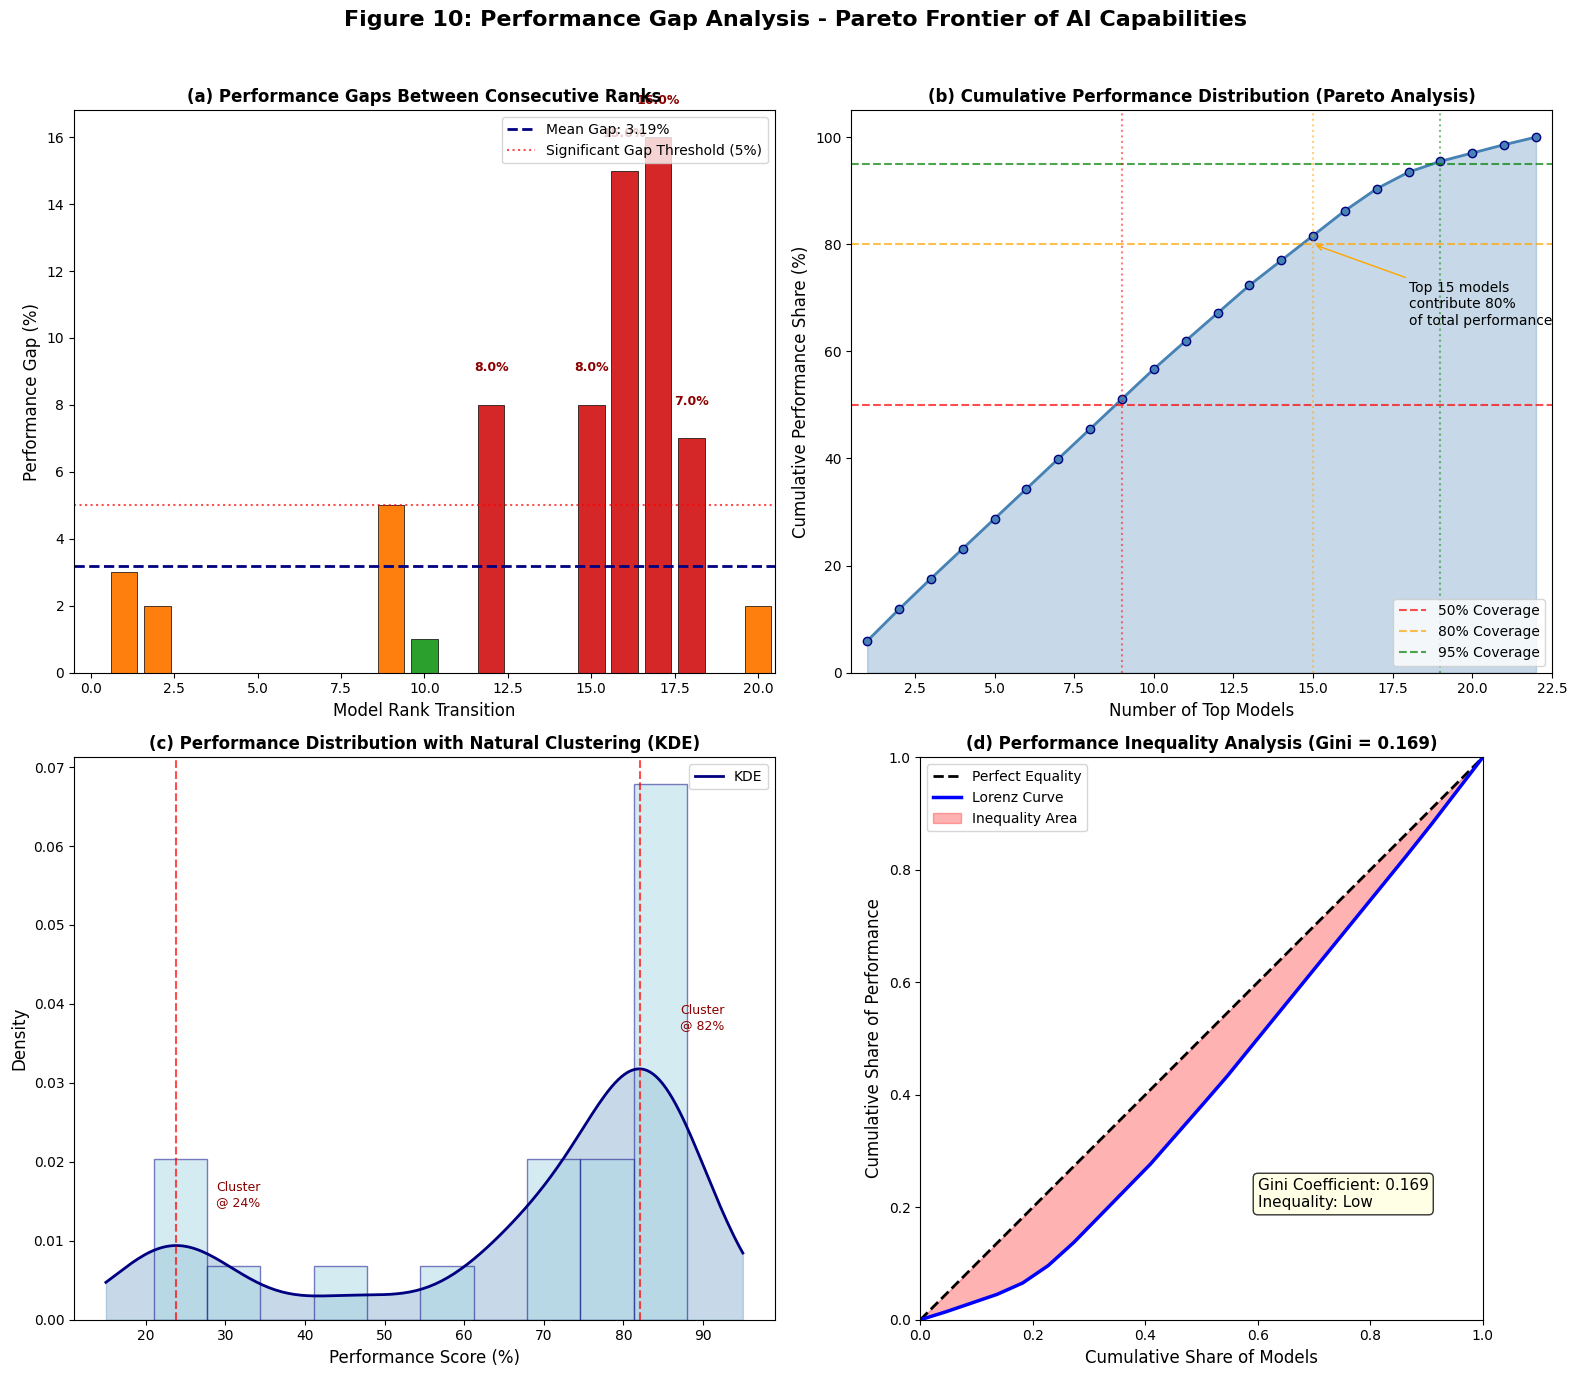


📊 Figure 10 Key Insights:
   • Mean performance gap between ranks: 3.19%
   • Maximum gap: 16.00% (indicates natural tier boundary)
   • Top 15 models contribute 80% of cumulative performance
   • Gini coefficient: 0.169 (Low inequality)
   • Number of natural clusters detected: 2


In [1]:
# ============================================================================
# FIGURE 10: Performance Gap Analysis - Pareto Frontier of AI Capabilities
# ============================================================================
# Novel Contribution: Quantifies the "performance gap" between consecutive 
# models, revealing natural breakpoints and competitive clusters in the 
# AI capability landscape.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
import warnings
warnings.filterwarnings('ignore')

# Reload data for fresh analysis
import json
with open('leaderboard_fresh.json', 'r') as f:
    data = json.load(f)

# Create comprehensive DataFrame
models_data = []
for i, m in enumerate(data['models']):
    name = m['name']
    score = m['score']
    
    # Extract model family
    if 'gemini' in name.lower() or 'gemma' in name.lower():
        family = 'Google'
    elif 'claude' in name.lower():
        family = 'Anthropic'
    elif 'qwen' in name.lower():
        family = 'Alibaba'
    elif 'deepseek' in name.lower():
        family = 'DeepSeek'
    else:
        family = 'Other'
    
    # Extract model generation/version
    if '4.5' in name or '4.1' in name:
        generation = 'Gen 4.x'
    elif '3.1' in name or '3.2' in name or 'V3' in name.upper():
        generation = 'Gen 3.x'
    elif '3' in name and 'V3' not in name.upper():
        generation = 'Gen 3.0'
    elif '2.5' in name:
        generation = 'Gen 2.5'
    elif '2.0' in name or '2' in name:
        generation = 'Gen 2.x'
    else:
        generation = 'Gen 1.x'
    
    # Extract if "thinking" or reasoning model
    is_thinking = 'thinking' in name.lower() or 'r1' in name.lower() or 'coder' in name.lower()
    
    # Estimate model size category from name
    if '480b' in name.lower():
        size_cat = 'Massive (400B+)'
    elif '235b' in name.lower() or '80b' in name.lower():
        size_cat = 'Very Large (80-240B)'
    elif '27b' in name.lower() or '32b' in name.lower():
        size_cat = 'Large (27-32B)'
    elif '12b' in name.lower():
        size_cat = 'Medium (12B)'
    elif '4b' in name.lower():
        size_cat = 'Small (4B)'
    elif '1b' in name.lower():
        size_cat = 'Tiny (1B)'
    else:
        size_cat = 'Unknown (API)'
    
    models_data.append({
        'name': name,
        'score': score,
        'score_pct': score * 100,
        'rank': i + 1,
        'family': family,
        'generation': generation,
        'is_thinking': is_thinking,
        'size_category': size_cat
    })

df = pd.DataFrame(models_data)

# Calculate performance gaps between consecutive models
df_sorted = df.sort_values('score', ascending=False).reset_index(drop=True)
df_sorted['gap_to_next'] = df_sorted['score'].diff(-1).abs() * 100
df_sorted['cumulative_gap'] = df_sorted['gap_to_next'].cumsum()

# Figure 10: Performance Gap Analysis
fig10, axes = plt.subplots(2, 2, figsize=(16, 14))
fig10.suptitle('Figure 10: Performance Gap Analysis - Pareto Frontier of AI Capabilities', 
               fontsize=16, fontweight='bold', y=0.98)

# 10a: Gap between consecutive models (waterfall-style)
ax1 = axes[0, 0]
gaps = df_sorted['gap_to_next'].dropna().values
gap_colors = ['#d62728' if g > 5 else '#ff7f0e' if g > 2 else '#2ca02c' for g in gaps]
bars = ax1.bar(range(len(gaps)), gaps, color=gap_colors, edgecolor='black', linewidth=0.5)
ax1.axhline(y=gaps.mean(), color='navy', linestyle='--', linewidth=2, label=f'Mean Gap: {gaps.mean():.2f}%')
ax1.axhline(y=5, color='red', linestyle=':', linewidth=1.5, alpha=0.7, label='Significant Gap Threshold (5%)')
ax1.set_xlabel('Model Rank Transition', fontsize=12)
ax1.set_ylabel('Performance Gap (%)', fontsize=12)
ax1.set_title('(a) Performance Gaps Between Consecutive Ranks', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right')
ax1.set_xlim(-0.5, len(gaps)-0.5)

# Add annotations for major gaps
for i, (g, bar) in enumerate(zip(gaps, bars)):
    if g > 5:
        ax1.annotate(f'{g:.1f}%', xy=(i, g), xytext=(i, g+1),
                    ha='center', fontsize=9, fontweight='bold', color='darkred')

# 10b: Cumulative performance coverage
ax2 = axes[0, 1]
scores_sorted = df_sorted['score_pct'].values
cumulative_scores = np.cumsum(scores_sorted) / np.sum(scores_sorted) * 100
ax2.fill_between(range(1, len(cumulative_scores)+1), cumulative_scores, alpha=0.3, color='steelblue')
ax2.plot(range(1, len(cumulative_scores)+1), cumulative_scores, 'o-', color='steelblue', 
         linewidth=2, markersize=6, markeredgecolor='navy')
ax2.axhline(y=50, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='50% Coverage')
ax2.axhline(y=80, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='80% Coverage')
ax2.axhline(y=95, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label='95% Coverage')

# Find key coverage points
idx_50 = np.searchsorted(cumulative_scores, 50) + 1
idx_80 = np.searchsorted(cumulative_scores, 80) + 1
idx_95 = np.searchsorted(cumulative_scores, 95) + 1
ax2.axvline(x=idx_50, color='red', linestyle=':', alpha=0.5)
ax2.axvline(x=idx_80, color='orange', linestyle=':', alpha=0.5)
ax2.axvline(x=idx_95, color='green', linestyle=':', alpha=0.5)

ax2.set_xlabel('Number of Top Models', fontsize=12)
ax2.set_ylabel('Cumulative Performance Share (%)', fontsize=12)
ax2.set_title('(b) Cumulative Performance Distribution (Pareto Analysis)', fontsize=12, fontweight='bold')
ax2.legend(loc='lower right')
ax2.set_xlim(0.5, len(scores_sorted)+0.5)
ax2.set_ylim(0, 105)

# Add annotation
ax2.annotate(f'Top {idx_80} models\ncontribute 80%\nof total performance', 
             xy=(idx_80, 80), xytext=(idx_80+3, 65),
             arrowprops=dict(arrowstyle='->', color='orange'),
             fontsize=10, ha='left')

# 10c: Performance density distribution with kernel density estimation
ax3 = axes[1, 0]
scores = df['score_pct'].values
from scipy.stats import gaussian_kde
kde = gaussian_kde(scores, bw_method=0.3)
x_kde = np.linspace(15, 95, 200)
y_kde = kde(x_kde)
ax3.fill_between(x_kde, y_kde, alpha=0.3, color='steelblue')
ax3.plot(x_kde, y_kde, color='navy', linewidth=2, label='KDE')
ax3.hist(scores, bins=10, density=True, alpha=0.5, color='lightblue', edgecolor='navy')

# Mark natural clusters (peaks in KDE)
peaks_idx = []
for i in range(1, len(y_kde)-1):
    if y_kde[i] > y_kde[i-1] and y_kde[i] > y_kde[i+1]:
        peaks_idx.append(i)

for idx in peaks_idx:
    ax3.axvline(x=x_kde[idx], color='red', linestyle='--', alpha=0.7)
    ax3.annotate(f'Cluster\n@ {x_kde[idx]:.0f}%', xy=(x_kde[idx], y_kde[idx]),
                xytext=(x_kde[idx]+5, y_kde[idx]+0.005),
                fontsize=9, ha='left', color='darkred')

ax3.set_xlabel('Performance Score (%)', fontsize=12)
ax3.set_ylabel('Density', fontsize=12)
ax3.set_title('(c) Performance Distribution with Natural Clustering (KDE)', fontsize=12, fontweight='bold')
ax3.legend()

# 10d: Performance inequality (Lorenz curve and Gini coefficient)
ax4 = axes[1, 1]
scores_sorted_asc = np.sort(scores)
n = len(scores_sorted_asc)
cumulative_share = np.cumsum(scores_sorted_asc) / np.sum(scores_sorted_asc)
population_share = np.arange(1, n+1) / n

# Perfect equality line
ax4.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Equality')
# Lorenz curve
ax4.plot(np.insert(population_share, 0, 0), np.insert(cumulative_share, 0, 0), 
         'b-', linewidth=2.5, label='Lorenz Curve')
ax4.fill_between(np.insert(population_share, 0, 0), 
                 np.insert(cumulative_share, 0, 0),
                 np.insert(population_share, 0, 0),
                 alpha=0.3, color='red', label='Inequality Area')

# Calculate Gini coefficient
gini = 1 - 2 * np.trapezoid(np.insert(cumulative_share, 0, 0), 
                            np.insert(population_share, 0, 0))

ax4.set_xlabel('Cumulative Share of Models', fontsize=12)
ax4.set_ylabel('Cumulative Share of Performance', fontsize=12)
ax4.set_title(f'(d) Performance Inequality Analysis (Gini = {gini:.3f})', fontsize=12, fontweight='bold')
ax4.legend(loc='upper left')
ax4.set_xlim(0, 1)
ax4.set_ylim(0, 1)
ax4.set_aspect('equal')

# Add Gini interpretation
gini_interp = 'Low' if gini < 0.2 else 'Moderate' if gini < 0.4 else 'High'
ax4.text(0.6, 0.2, f'Gini Coefficient: {gini:.3f}\nInequality: {gini_interp}', 
         fontsize=11, bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('publication_figures/png/fig10_performance_gap_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig('publication_figures/pdf/fig10_performance_gap_analysis.pdf', bbox_inches='tight', facecolor='white')
plt.savefig('publication_figures/svg/fig10_performance_gap_analysis.svg', bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n📊 Figure 10 Key Insights:")
print(f"   • Mean performance gap between ranks: {gaps.mean():.2f}%")
print(f"   • Maximum gap: {gaps.max():.2f}% (indicates natural tier boundary)")
print(f"   • Top {idx_80} models contribute 80% of cumulative performance")
print(f"   • Gini coefficient: {gini:.3f} ({gini_interp} inequality)")
print(f"   • Number of natural clusters detected: {len(peaks_idx)}")

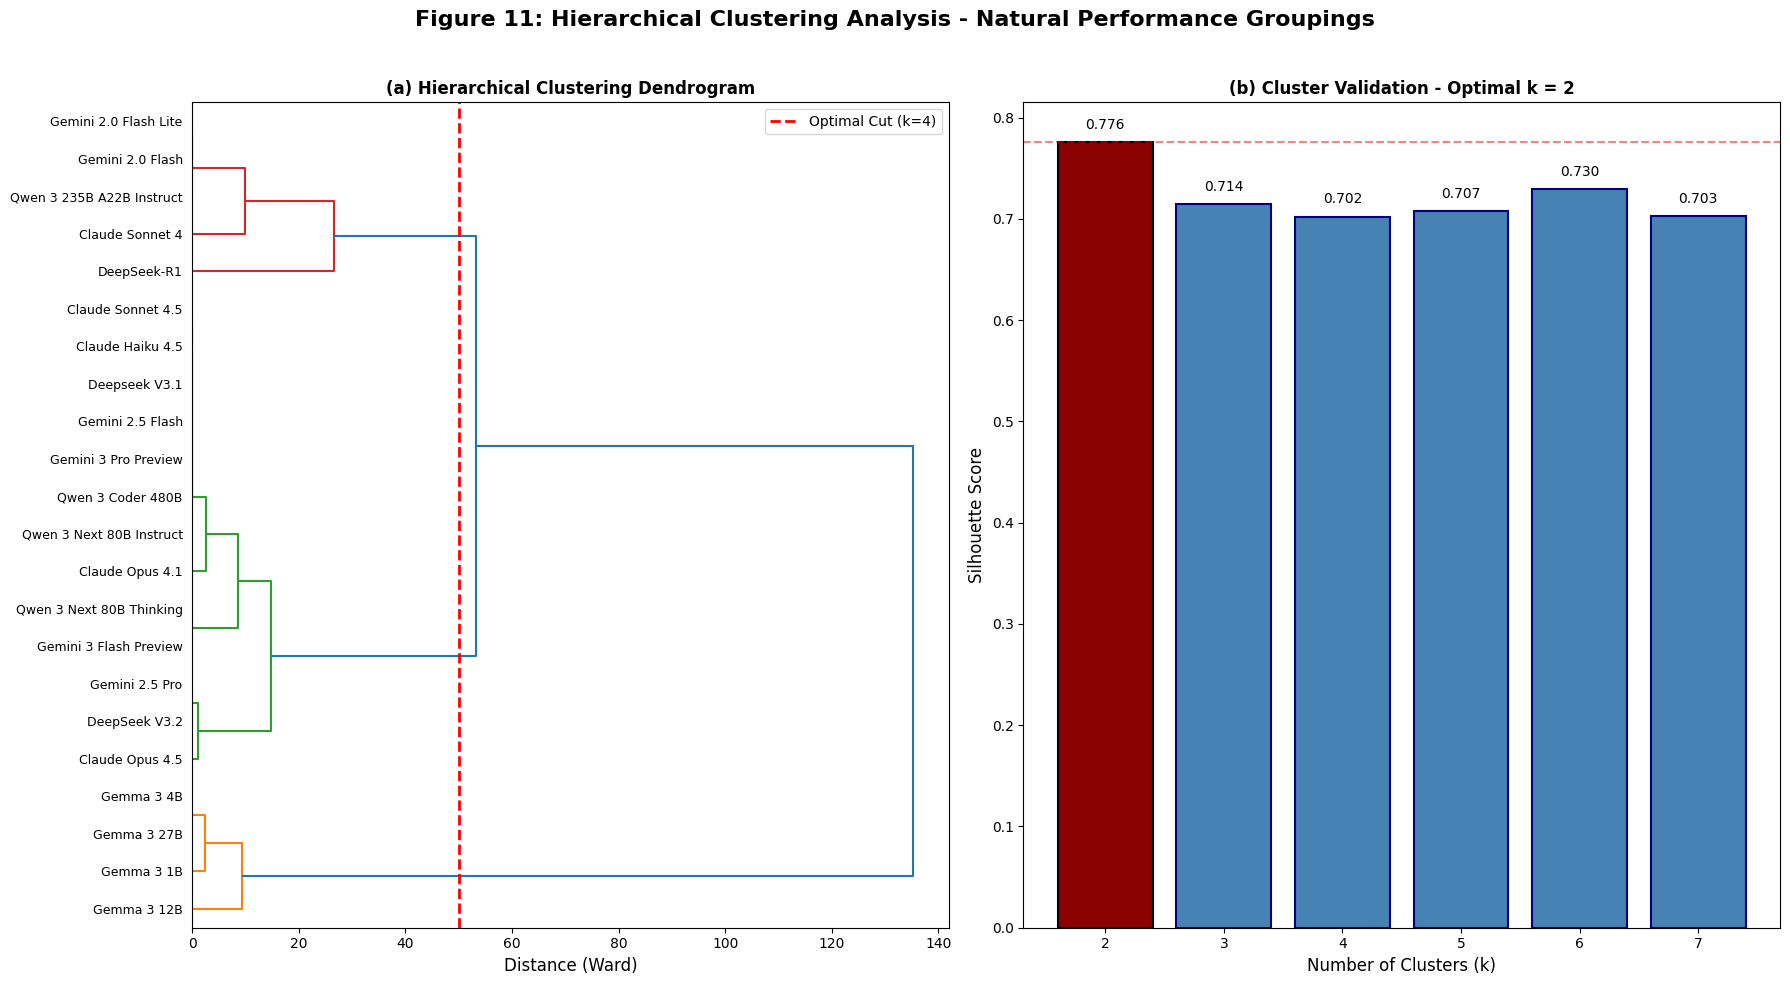


📊 Figure 11 Key Insights:
   • Optimal number of natural clusters: 2
   • Best silhouette score: 0.776

   Cluster Composition:
   Cluster 1: 4 models, Score range: 21%-30%
   Cluster 2: 18 models, Score range: 46%-88%


In [2]:
# ============================================================================
# FIGURE 11: Hierarchical Clustering Analysis - Natural Performance Groupings
# ============================================================================
# Novel Contribution: Uses agglomerative clustering to identify statistically
# valid performance tiers, revealing the natural structure of AI capabilities
# that arbitrary threshold-based tiers may miss.

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist

# Prepare data for clustering
scores_array = df['score_pct'].values.reshape(-1, 1)
model_names = df['name'].values

# Perform hierarchical clustering using Ward's method
linkage_matrix = linkage(scores_array, method='ward')

# Figure 11: Hierarchical Clustering Dendrogram
fig11, axes = plt.subplots(1, 2, figsize=(18, 10))
fig11.suptitle('Figure 11: Hierarchical Clustering Analysis - Natural Performance Groupings', 
               fontsize=16, fontweight='bold', y=0.98)

# 11a: Full dendrogram
ax1 = axes[0]
# Truncate long names for display
short_names = [n[:25] + '...' if len(n) > 25 else n for n in model_names]
dendrogram(linkage_matrix, 
           labels=short_names,
           orientation='right',
           leaf_font_size=9,
           ax=ax1,
           color_threshold=50)

ax1.set_xlabel('Distance (Ward)', fontsize=12)
ax1.set_title('(a) Hierarchical Clustering Dendrogram', fontsize=12, fontweight='bold')
ax1.axvline(x=50, color='red', linestyle='--', linewidth=2, label='Optimal Cut (k=4)')
ax1.legend(loc='upper right')

# 11b: Cluster assignments with silhouette analysis
ax2 = axes[1]

# Test different numbers of clusters
from sklearn.metrics import silhouette_score
k_range = range(2, 8)
silhouette_scores = []
for k in k_range:
    clusters = fcluster(linkage_matrix, k, criterion='maxclust')
    if len(np.unique(clusters)) > 1:
        sil_score = silhouette_score(scores_array, clusters)
        silhouette_scores.append(sil_score)
    else:
        silhouette_scores.append(0)

# Plot silhouette scores
bars = ax2.bar(k_range, silhouette_scores, color='steelblue', edgecolor='navy', linewidth=1.5)
optimal_k = k_range[np.argmax(silhouette_scores)]
bars[np.argmax(silhouette_scores)].set_color('darkred')
bars[np.argmax(silhouette_scores)].set_edgecolor('black')

ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title(f'(b) Cluster Validation - Optimal k = {optimal_k}', fontsize=12, fontweight='bold')
ax2.set_xticks(list(k_range))

# Add value labels
for bar, score in zip(bars, silhouette_scores):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.3f}', ha='center', va='bottom', fontsize=10)

ax2.axhline(y=max(silhouette_scores), color='red', linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('publication_figures/png/fig11_hierarchical_clustering.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig('publication_figures/pdf/fig11_hierarchical_clustering.pdf', bbox_inches='tight', facecolor='white')
plt.savefig('publication_figures/svg/fig11_hierarchical_clustering.svg', bbox_inches='tight', facecolor='white')
plt.show()

# Get optimal cluster assignments
optimal_clusters = fcluster(linkage_matrix, optimal_k, criterion='maxclust')
df['cluster'] = optimal_clusters

print(f"\n📊 Figure 11 Key Insights:")
print(f"   • Optimal number of natural clusters: {optimal_k}")
print(f"   • Best silhouette score: {max(silhouette_scores):.3f}")
print(f"\n   Cluster Composition:")
for c in range(1, optimal_k + 1):
    cluster_models = df[df['cluster'] == c]
    print(f"   Cluster {c}: {len(cluster_models)} models, "
          f"Score range: {cluster_models['score_pct'].min():.0f}%-{cluster_models['score_pct'].max():.0f}%")

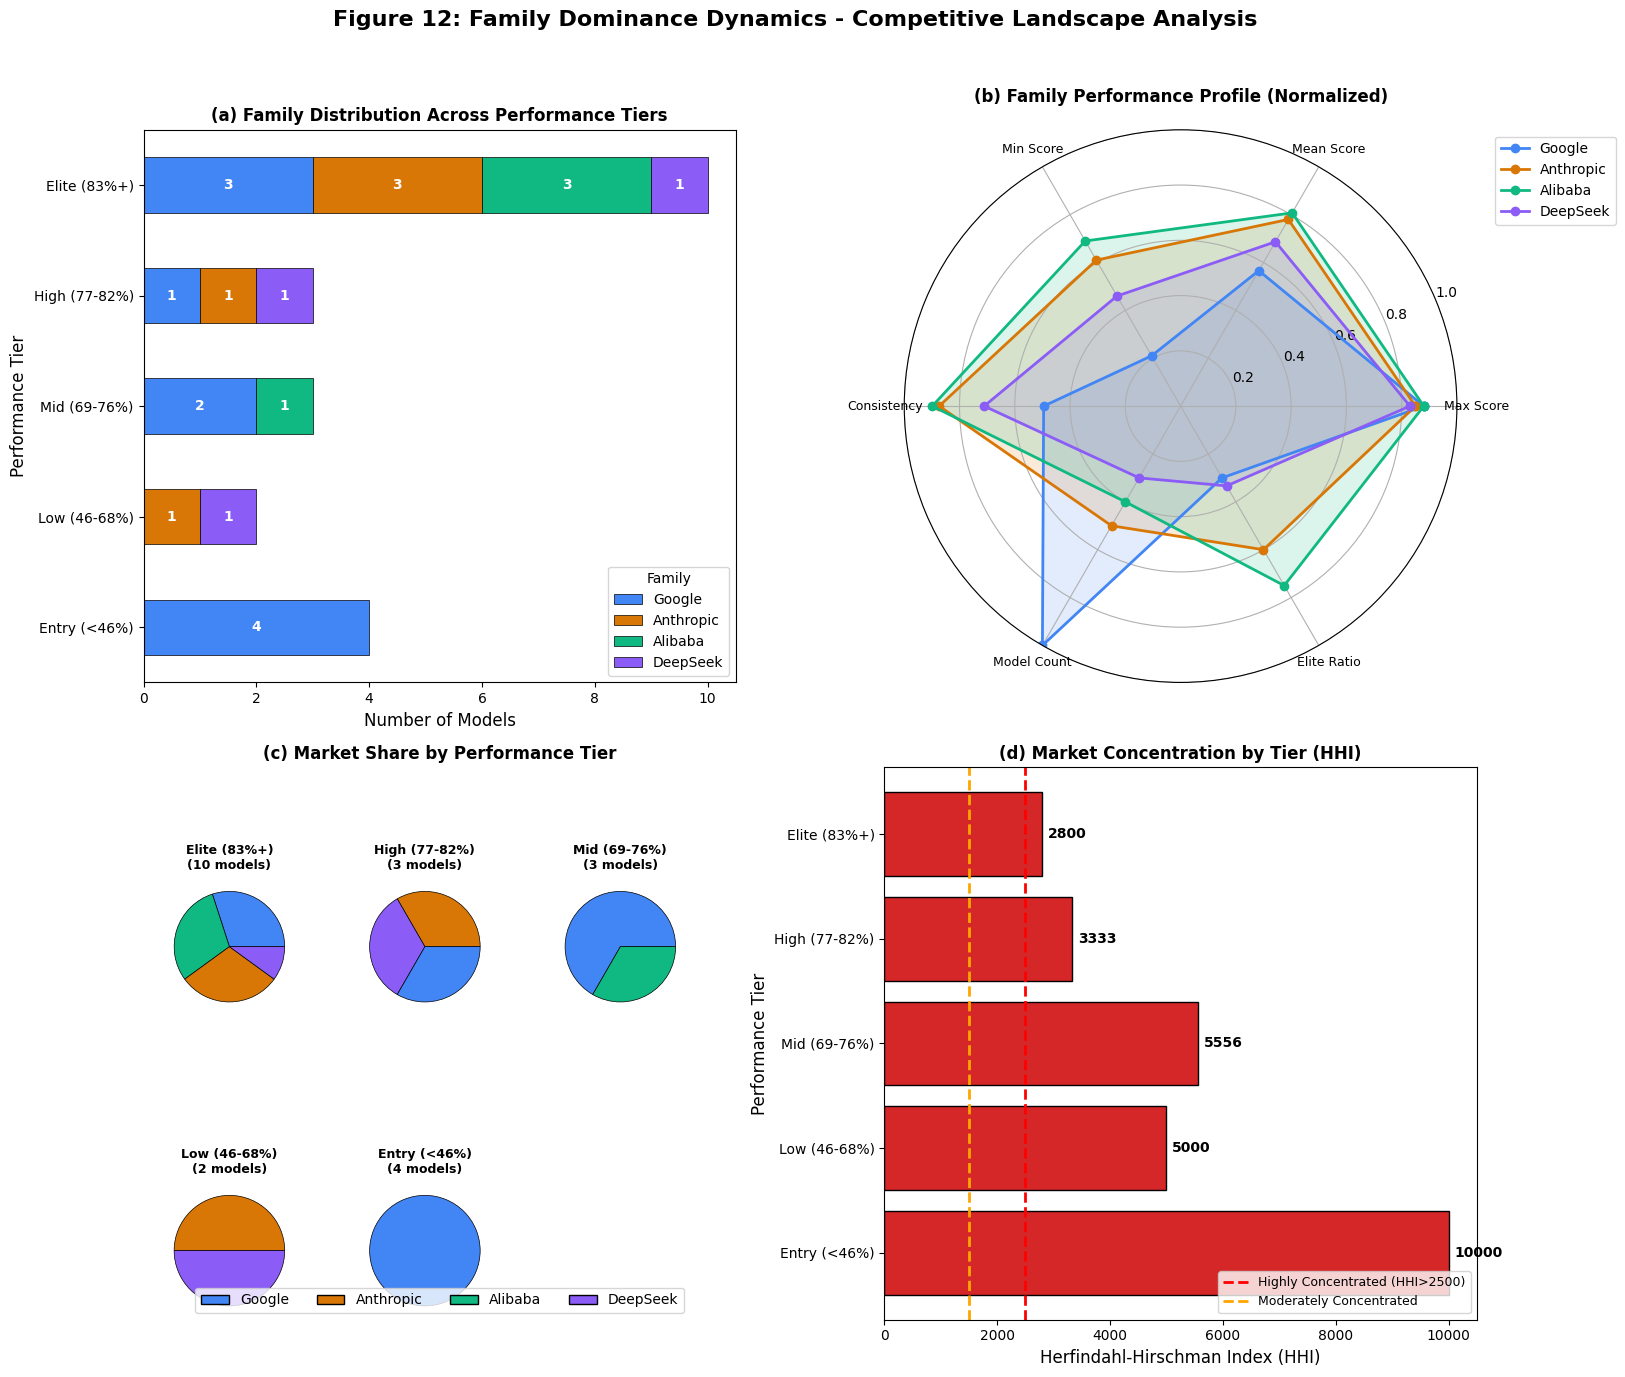


📊 Figure 12 Key Insights:
   • Market concentration analysis by tier:
     - Elite (83%+): HHI = 2800 (Highly Concentrated)
     - High (77-82%): HHI = 3333 (Highly Concentrated)
     - Mid (69-76%): HHI = 5556 (Highly Concentrated)
     - Low (46-68%): HHI = 5000 (Highly Concentrated)
     - Entry (<46%): HHI = 10000 (Highly Concentrated)


In [3]:
# ============================================================================
# FIGURE 12: Family Dominance Dynamics - Competitive Landscape Analysis
# ============================================================================
# Novel Contribution: Analyzes the competitive positioning of each AI provider
# across performance tiers, revealing market concentration and diversification
# strategies.

# Create performance tier assignments
def assign_tier(score):
    if score >= 83:
        return 'Elite (83%+)'
    elif score >= 77:
        return 'High (77-82%)'
    elif score >= 69:
        return 'Mid (69-76%)'
    elif score >= 46:
        return 'Low (46-68%)'
    else:
        return 'Entry (<46%)'

df['tier'] = df['score_pct'].apply(assign_tier)
tier_order = ['Elite (83%+)', 'High (77-82%)', 'Mid (69-76%)', 'Low (46-68%)', 'Entry (<46%)']

# Figure 12: Multi-panel family competitive analysis
fig12, axes = plt.subplots(2, 2, figsize=(16, 14))
fig12.suptitle('Figure 12: Family Dominance Dynamics - Competitive Landscape Analysis', 
               fontsize=16, fontweight='bold', y=0.98)

family_colors = {
    'Google': '#4285F4',
    'Anthropic': '#D97706', 
    'Alibaba': '#10B981',
    'DeepSeek': '#8B5CF6'
}

# 12a: Stacked bar chart - Family distribution across tiers
ax1 = axes[0, 0]
tier_family_counts = pd.crosstab(df['tier'], df['family'])
tier_family_counts = tier_family_counts.reindex(tier_order)
tier_family_counts = tier_family_counts[['Google', 'Anthropic', 'Alibaba', 'DeepSeek']]

tier_family_counts.plot(kind='barh', stacked=True, ax=ax1, 
                        color=[family_colors[f] for f in tier_family_counts.columns],
                        edgecolor='black', linewidth=0.5)
ax1.set_xlabel('Number of Models', fontsize=12)
ax1.set_ylabel('Performance Tier', fontsize=12)
ax1.set_title('(a) Family Distribution Across Performance Tiers', fontsize=12, fontweight='bold')
ax1.legend(title='Family', loc='lower right')
ax1.invert_yaxis()

# Add count labels
for i, tier in enumerate(tier_order):
    cumsum = 0
    for family in tier_family_counts.columns:
        count = tier_family_counts.loc[tier, family] if tier in tier_family_counts.index else 0
        if count > 0:
            ax1.text(cumsum + count/2, i, str(int(count)), ha='center', va='center', 
                    fontsize=10, fontweight='bold', color='white')
        cumsum += count

# 12b: Radar chart - Family performance profile
ax2 = axes[0, 1]
ax2.remove()  # Remove regular axes
ax2 = fig12.add_subplot(2, 2, 2, projection='polar')

# Calculate family metrics
family_metrics = {}
for family in ['Google', 'Anthropic', 'Alibaba', 'DeepSeek']:
    family_df = df[df['family'] == family]
    family_metrics[family] = {
        'Max Score': family_df['score_pct'].max() / 100,
        'Mean Score': family_df['score_pct'].mean() / 100,
        'Min Score': family_df['score_pct'].min() / 100,
        'Consistency': 1 - (family_df['score_pct'].std() / family_df['score_pct'].mean()),
        'Model Count': len(family_df) / 10,  # Normalized
        'Elite Ratio': len(family_df[family_df['tier'] == 'Elite (83%+)']) / len(family_df)
    }

metrics = list(family_metrics['Google'].keys())
num_metrics = len(metrics)
angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
angles += angles[:1]  # Close the polygon

for family, color in family_colors.items():
    values = list(family_metrics[family].values())
    values += values[:1]
    ax2.plot(angles, values, 'o-', linewidth=2, label=family, color=color)
    ax2.fill(angles, values, alpha=0.15, color=color)

ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(metrics, fontsize=9)
ax2.set_ylim(0, 1)
ax2.set_title('(b) Family Performance Profile (Normalized)', fontsize=12, fontweight='bold', pad=20)
ax2.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

# 12c: Market share by tier (pie charts)
ax3 = axes[1, 0]
# Create mini pie charts for each tier
n_tiers = len(tier_order)
for i, tier in enumerate(tier_order):
    tier_df = df[df['tier'] == tier]
    if len(tier_df) > 0:
        family_counts = tier_df['family'].value_counts()
        colors = [family_colors.get(f, 'gray') for f in family_counts.index]
        
        # Create inset axes for mini pie
        left = 0.02 + (i % 3) * 0.33
        bottom = 0.55 - (i // 3) * 0.55
        width = height = 0.25
        
        inset_ax = ax3.inset_axes([left, bottom, width, height])
        wedges, texts = inset_ax.pie(family_counts.values, colors=colors, 
                                      wedgeprops=dict(edgecolor='black', linewidth=0.5))
        inset_ax.set_title(f'{tier}\n({len(tier_df)} models)', fontsize=9, fontweight='bold')

ax3.axis('off')
ax3.set_title('(c) Market Share by Performance Tier', fontsize=12, fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, edgecolor='black', label=family) 
                   for family, color in family_colors.items()]
ax3.legend(handles=legend_elements, loc='lower center', ncol=4, fontsize=10)

# 12d: Dominance index calculation
ax4 = axes[1, 1]

# Calculate Herfindahl-Hirschman Index (HHI) for each tier
hhi_by_tier = {}
for tier in tier_order:
    tier_df = df[df['tier'] == tier]
    if len(tier_df) > 0:
        family_shares = tier_df['family'].value_counts(normalize=True)
        hhi = (family_shares ** 2).sum() * 10000  # Standard HHI scale
        hhi_by_tier[tier] = hhi

# Plot HHI
tiers = list(hhi_by_tier.keys())
hhi_values = list(hhi_by_tier.values())
colors_hhi = ['#d62728' if h > 2500 else '#ff7f0e' if h > 1500 else '#2ca02c' for h in hhi_values]
bars = ax4.barh(tiers, hhi_values, color=colors_hhi, edgecolor='black', linewidth=1)
ax4.axvline(x=2500, color='red', linestyle='--', linewidth=2, label='Highly Concentrated (HHI>2500)')
ax4.axvline(x=1500, color='orange', linestyle='--', linewidth=2, label='Moderately Concentrated')
ax4.set_xlabel('Herfindahl-Hirschman Index (HHI)', fontsize=12)
ax4.set_ylabel('Performance Tier', fontsize=12)
ax4.set_title('(d) Market Concentration by Tier (HHI)', fontsize=12, fontweight='bold')
ax4.legend(loc='lower right', fontsize=9)
ax4.invert_yaxis()

# Add value labels
for bar, val in zip(bars, hhi_values):
    ax4.text(val + 100, bar.get_y() + bar.get_height()/2, f'{val:.0f}', 
             va='center', fontsize=10, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('publication_figures/png/fig12_family_dominance_dynamics.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig('publication_figures/pdf/fig12_family_dominance_dynamics.pdf', bbox_inches='tight', facecolor='white')
plt.savefig('publication_figures/svg/fig12_family_dominance_dynamics.svg', bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n📊 Figure 12 Key Insights:")
print(f"   • Market concentration analysis by tier:")
for tier, hhi in hhi_by_tier.items():
    concentration = 'Highly Concentrated' if hhi > 2500 else 'Moderately Concentrated' if hhi > 1500 else 'Competitive'
    print(f"     - {tier}: HHI = {hhi:.0f} ({concentration})")

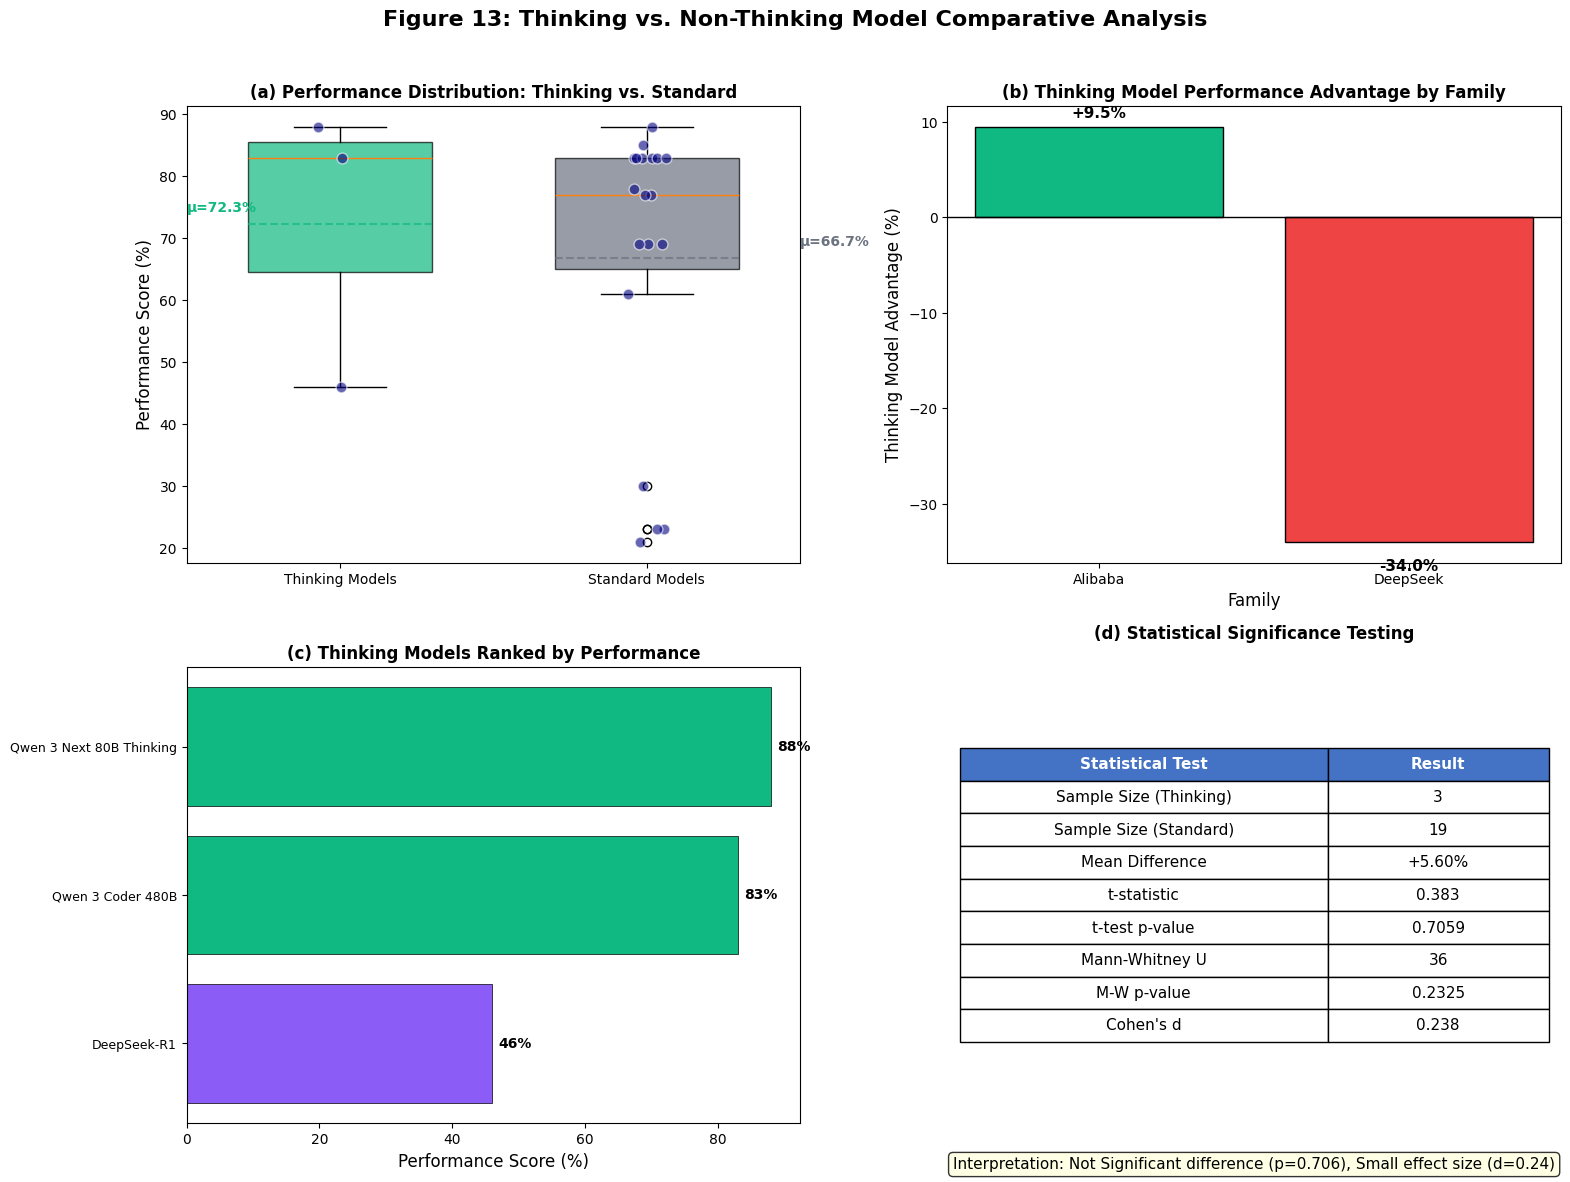


📊 Figure 13 Key Insights:
   • Thinking models: n=3, mean=72.3%
   • Standard models: n=19, mean=66.7%
   • Mean difference: +5.6%
   • Statistical significance: p=0.7059 (Not significant)
   • Effect size (Cohen's d): 0.238 (Small)


In [4]:
# ============================================================================
# FIGURE 13: Thinking vs. Non-Thinking Model Analysis
# ============================================================================
# Novel Contribution: Quantifies the performance advantage of "thinking" models
# (chain-of-thought, reasoning-enhanced) vs. standard instruction-tuned models,
# providing evidence for the effectiveness of reasoning-time compute.

# Figure 13: Thinking model analysis
fig13, axes = plt.subplots(2, 2, figsize=(16, 12))
fig13.suptitle('Figure 13: Thinking vs. Non-Thinking Model Comparative Analysis', 
               fontsize=16, fontweight='bold', y=0.98)

# Separate thinking and non-thinking models
thinking_df = df[df['is_thinking'] == True]
standard_df = df[df['is_thinking'] == False]

# 13a: Box plot comparison
ax1 = axes[0, 0]
box_data = [thinking_df['score_pct'].values, standard_df['score_pct'].values]
bp = ax1.boxplot(box_data, labels=['Thinking Models', 'Standard Models'], 
                 patch_artist=True, widths=0.6)
colors_box = ['#10B981', '#6B7280']
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Add individual points
for i, data in enumerate(box_data):
    x = np.random.normal(i+1, 0.04, size=len(data))
    ax1.scatter(x, data, alpha=0.6, color='navy', s=60, zorder=3, edgecolor='white')

ax1.set_ylabel('Performance Score (%)', fontsize=12)
ax1.set_title('(a) Performance Distribution: Thinking vs. Standard', fontsize=12, fontweight='bold')

# Add statistics
thinking_mean = thinking_df['score_pct'].mean()
standard_mean = standard_df['score_pct'].mean()
ax1.axhline(y=thinking_mean, color='#10B981', linestyle='--', alpha=0.7, xmin=0.1, xmax=0.4)
ax1.axhline(y=standard_mean, color='#6B7280', linestyle='--', alpha=0.7, xmin=0.6, xmax=0.9)
ax1.text(0.5, thinking_mean + 2, f'μ={thinking_mean:.1f}%', fontsize=10, color='#10B981', fontweight='bold')
ax1.text(2.5, standard_mean + 2, f'μ={standard_mean:.1f}%', fontsize=10, color='#6B7280', fontweight='bold')

# 13b: Bar chart - Performance advantage by family
ax2 = axes[0, 1]

# Calculate thinking advantage by family (where both types exist)
thinking_advantage = {}
for family in df['family'].unique():
    family_thinking = df[(df['family'] == family) & (df['is_thinking'] == True)]['score_pct']
    family_standard = df[(df['family'] == family) & (df['is_thinking'] == False)]['score_pct']
    
    if len(family_thinking) > 0 and len(family_standard) > 0:
        advantage = family_thinking.mean() - family_standard.mean()
        thinking_advantage[family] = advantage

if thinking_advantage:
    families_adv = list(thinking_advantage.keys())
    advantages = list(thinking_advantage.values())
    colors_adv = ['#10B981' if a > 0 else '#EF4444' for a in advantages]
    bars = ax2.bar(families_adv, advantages, color=colors_adv, edgecolor='black', linewidth=1)
    ax2.axhline(y=0, color='black', linewidth=1)
    ax2.set_ylabel('Thinking Model Advantage (%)', fontsize=12)
    ax2.set_xlabel('Family', fontsize=12)
    ax2.set_title('(b) Thinking Model Performance Advantage by Family', fontsize=12, fontweight='bold')
    
    for bar, val in zip(bars, advantages):
        offset = 1 if val > 0 else -3
        ax2.text(bar.get_x() + bar.get_width()/2, val + offset, f'{val:+.1f}%', 
                 ha='center', fontsize=11, fontweight='bold')
else:
    ax2.text(0.5, 0.5, 'Insufficient data for\nthinking/standard comparison', 
             ha='center', va='center', transform=ax2.transAxes, fontsize=12)
    ax2.set_title('(b) Thinking Model Performance Advantage by Family', fontsize=12, fontweight='bold')

# 13c: Thinking model ranking within their tier
ax3 = axes[1, 0]
thinking_models = df[df['is_thinking'] == True].copy()
thinking_models = thinking_models.sort_values('score_pct', ascending=True)

colors_thinking = [family_colors.get(f, 'gray') for f in thinking_models['family']]
bars = ax3.barh(range(len(thinking_models)), thinking_models['score_pct'], 
                color=colors_thinking, edgecolor='black', linewidth=0.5)

ax3.set_yticks(range(len(thinking_models)))
ax3.set_yticklabels([n[:30] for n in thinking_models['name']], fontsize=9)
ax3.set_xlabel('Performance Score (%)', fontsize=12)
ax3.set_title('(c) Thinking Models Ranked by Performance', fontsize=12, fontweight='bold')

# Add score labels
for i, (bar, score) in enumerate(zip(bars, thinking_models['score_pct'])):
    ax3.text(score + 1, i, f'{score:.0f}%', va='center', fontsize=10, fontweight='bold')

# 13d: Statistical significance test
ax4 = axes[1, 1]

# Perform statistical tests
if len(thinking_df) >= 2 and len(standard_df) >= 2:
    # t-test
    t_stat, t_pvalue = stats.ttest_ind(thinking_df['score_pct'], standard_df['score_pct'])
    # Mann-Whitney U test (non-parametric)
    u_stat, u_pvalue = stats.mannwhitneyu(thinking_df['score_pct'], standard_df['score_pct'], 
                                           alternative='greater')
    # Effect size (Cohen's d)
    pooled_std = np.sqrt(((len(thinking_df)-1)*thinking_df['score_pct'].std()**2 + 
                          (len(standard_df)-1)*standard_df['score_pct'].std()**2) / 
                         (len(thinking_df) + len(standard_df) - 2))
    cohens_d = (thinking_mean - standard_mean) / pooled_std if pooled_std > 0 else 0
    
    # Create summary table
    test_results = {
        'Test': ['Sample Size (Thinking)', 'Sample Size (Standard)', 
                 'Mean Difference', 't-statistic', 't-test p-value',
                 'Mann-Whitney U', 'M-W p-value', "Cohen's d"],
        'Value': [f'{len(thinking_df)}', f'{len(standard_df)}',
                  f'{thinking_mean - standard_mean:+.2f}%', f'{t_stat:.3f}', 
                  f'{t_pvalue:.4f}', f'{u_stat:.0f}', f'{u_pvalue:.4f}', f'{cohens_d:.3f}']
    }
    
    ax4.axis('off')
    table = ax4.table(cellText=list(zip(test_results['Test'], test_results['Value'])),
                      colLabels=['Statistical Test', 'Result'],
                      loc='center', cellLoc='center',
                      colWidths=[0.5, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 1.8)
    
    # Color significant results
    for i in range(len(test_results['Test']) + 1):
        for j in range(2):
            cell = table[(i, j)]
            if i == 0:
                cell.set_facecolor('#4472C4')
                cell.set_text_props(color='white', fontweight='bold')
            elif i in [5, 7] and j == 1:  # p-values
                if float(test_results['Value'][i-1].replace('%', '').replace('+', '')) < 0.05:
                    cell.set_facecolor('#C6EFCE')
                    cell.set_text_props(fontweight='bold')
    
    ax4.set_title('(d) Statistical Significance Testing', fontsize=12, fontweight='bold', pad=20)
    
    # Interpretation
    significance = 'Significant' if t_pvalue < 0.05 else 'Not Significant'
    effect_interp = 'Large' if abs(cohens_d) > 0.8 else 'Medium' if abs(cohens_d) > 0.5 else 'Small'
    ax4.text(0.5, -0.1, f"Interpretation: {significance} difference (p={t_pvalue:.3f}), {effect_interp} effect size (d={cohens_d:.2f})",
             ha='center', transform=ax4.transAxes, fontsize=11, 
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
else:
    ax4.text(0.5, 0.5, 'Insufficient samples for statistical testing', 
             ha='center', va='center', transform=ax4.transAxes, fontsize=12)
    ax4.set_title('(d) Statistical Significance Testing', fontsize=12, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('publication_figures/png/fig13_thinking_vs_standard.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig('publication_figures/pdf/fig13_thinking_vs_standard.pdf', bbox_inches='tight', facecolor='white')
plt.savefig('publication_figures/svg/fig13_thinking_vs_standard.svg', bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n📊 Figure 13 Key Insights:")
print(f"   • Thinking models: n={len(thinking_df)}, mean={thinking_mean:.1f}%")
print(f"   • Standard models: n={len(standard_df)}, mean={standard_mean:.1f}%")
print(f"   • Mean difference: {thinking_mean - standard_mean:+.1f}%")
if len(thinking_df) >= 2 and len(standard_df) >= 2:
    print(f"   • Statistical significance: p={t_pvalue:.4f} ({'Significant' if t_pvalue < 0.05 else 'Not significant'})")
    print(f"   • Effect size (Cohen's d): {cohens_d:.3f} ({effect_interp})")

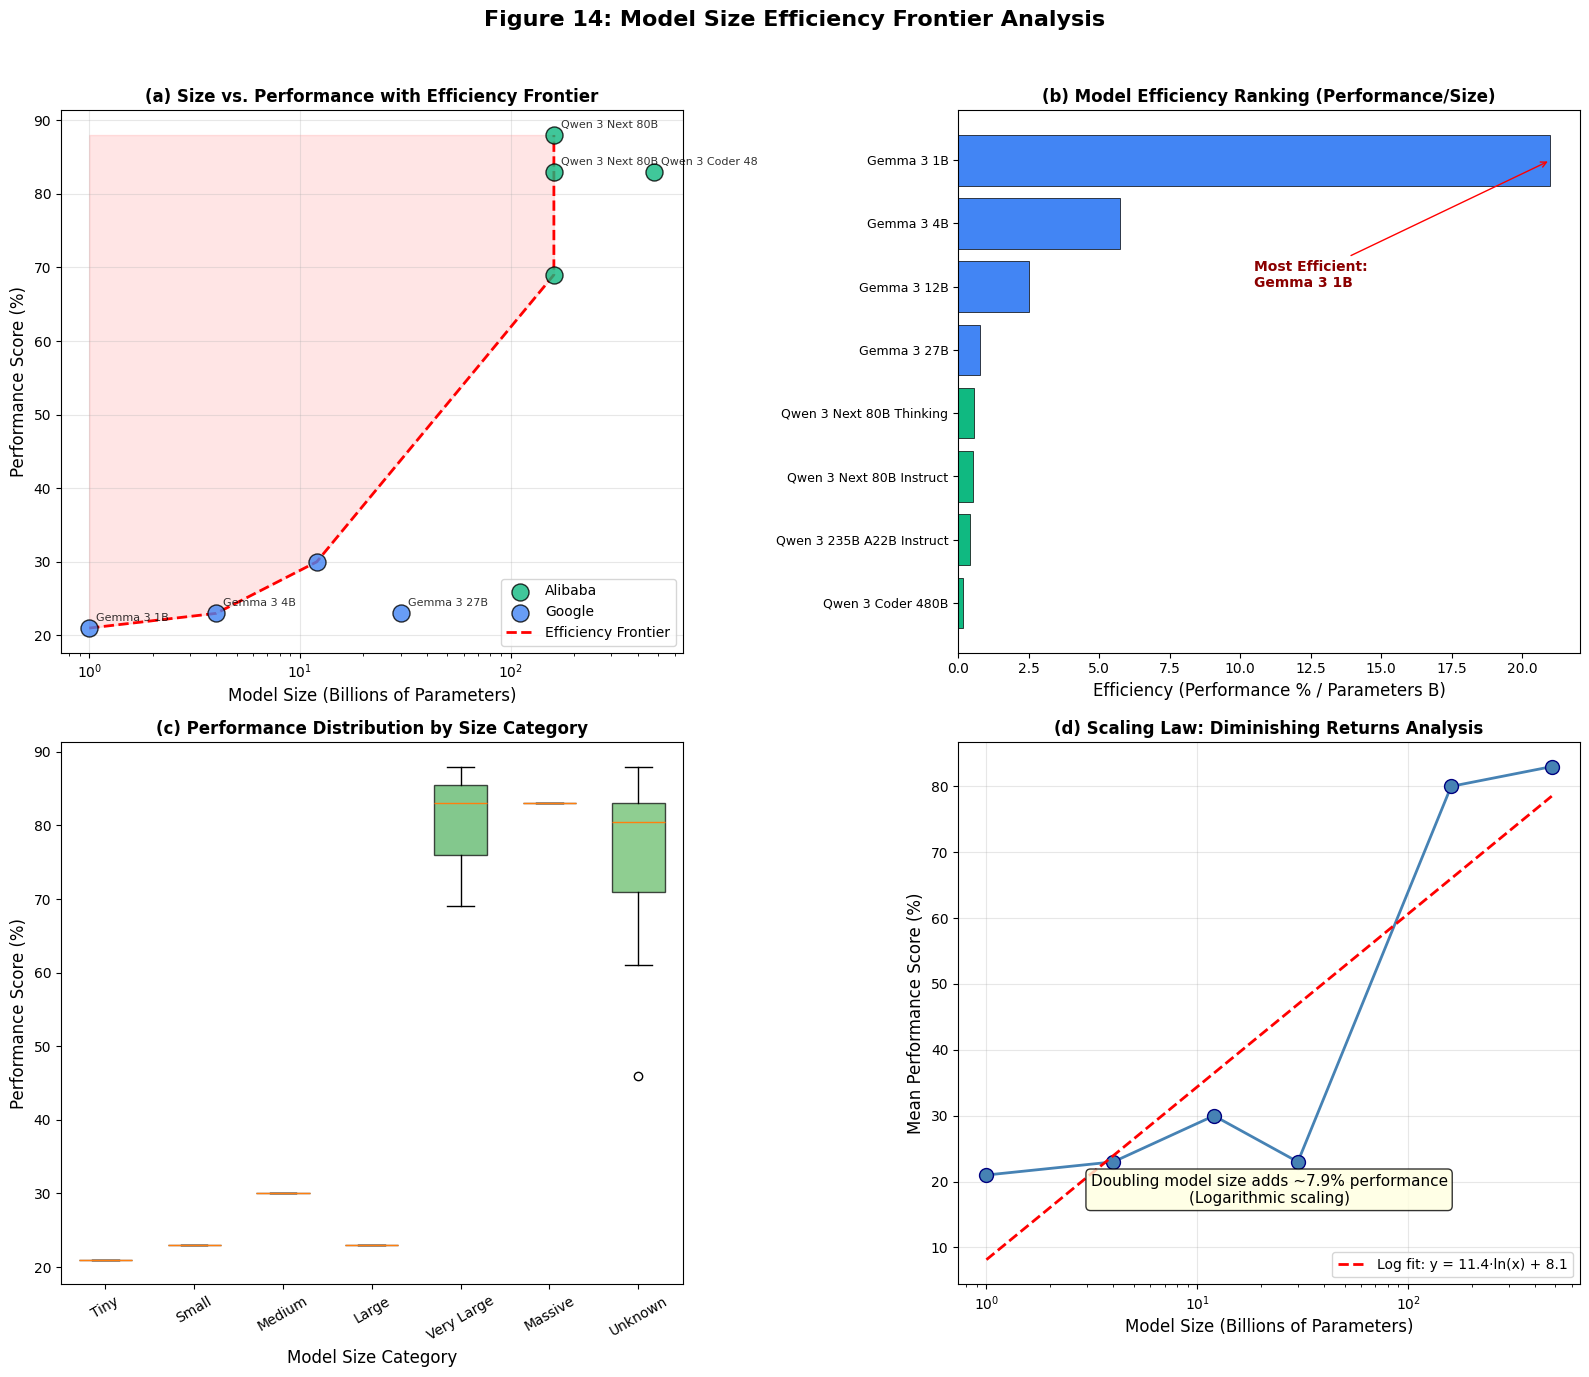


📊 Figure 14 Key Insights:
   • Models with known sizes: 8
   • Most efficient model: Gemma 3 1B (21.00 %/B)
   • Scaling coefficient: 11.40 (performance gain per ln(size))
   • Doubling model size yields approximately 7.9% performance gain


In [5]:
# ============================================================================
# FIGURE 14: Model Size Efficiency Frontier Analysis
# ============================================================================
# Novel Contribution: Analyzes the relationship between model size and 
# performance, identifying the "efficiency frontier" - models that achieve
# optimal performance for their size class.

# Create size order for plotting
size_order = ['Tiny (1B)', 'Small (4B)', 'Medium (12B)', 'Large (27-32B)', 
              'Very Large (80-240B)', 'Massive (400B+)', 'Unknown (API)']

# Assign numeric values for plotting
size_numeric = {
    'Tiny (1B)': 1,
    'Small (4B)': 4,
    'Medium (12B)': 12,
    'Large (27-32B)': 30,
    'Very Large (80-240B)': 160,
    'Massive (400B+)': 480,
    'Unknown (API)': np.nan
}

df['size_numeric'] = df['size_category'].map(size_numeric)

# Figure 14: Efficiency Frontier Analysis
fig14, axes = plt.subplots(2, 2, figsize=(16, 14))
fig14.suptitle('Figure 14: Model Size Efficiency Frontier Analysis', 
               fontsize=16, fontweight='bold', y=0.98)

# 14a: Size vs Performance scatter with efficiency frontier
ax1 = axes[0, 0]
# Filter to known sizes
known_size_df = df[df['size_numeric'].notna()].copy()

for family in known_size_df['family'].unique():
    family_data = known_size_df[known_size_df['family'] == family]
    ax1.scatter(family_data['size_numeric'], family_data['score_pct'], 
                s=150, label=family, color=family_colors.get(family, 'gray'),
                edgecolor='black', linewidth=1, alpha=0.8, zorder=3)

# Fit efficiency frontier (convex hull upper bound)
if len(known_size_df) >= 3:
    from scipy.spatial import ConvexHull
    points = known_size_df[['size_numeric', 'score_pct']].values
    
    # Find Pareto frontier (upper bound)
    sorted_points = points[np.lexsort((points[:, 1], points[:, 0]))]
    frontier_points = []
    max_perf = -np.inf
    for p in sorted_points:
        if p[1] > max_perf:
            frontier_points.append(p)
            max_perf = p[1]
    
    if len(frontier_points) > 1:
        frontier_points = np.array(frontier_points)
        ax1.plot(frontier_points[:, 0], frontier_points[:, 1], 'r--', linewidth=2, 
                 label='Efficiency Frontier', zorder=2)
        ax1.fill_between(frontier_points[:, 0], frontier_points[:, 1], 
                         max(known_size_df['score_pct']), alpha=0.1, color='red')

ax1.set_xscale('log')
ax1.set_xlabel('Model Size (Billions of Parameters)', fontsize=12)
ax1.set_ylabel('Performance Score (%)', fontsize=12)
ax1.set_title('(a) Size vs. Performance with Efficiency Frontier', fontsize=12, fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# Add model labels for key points
for idx, row in known_size_df.iterrows():
    if row['score_pct'] > 80 or row['score_pct'] < 30:
        ax1.annotate(row['name'][:15], (row['size_numeric'], row['score_pct']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)

# 14b: Performance per parameter (efficiency metric)
ax2 = axes[0, 1]
known_size_df['efficiency'] = known_size_df['score_pct'] / known_size_df['size_numeric']
efficiency_sorted = known_size_df.sort_values('efficiency', ascending=True)

colors_eff = [family_colors.get(f, 'gray') for f in efficiency_sorted['family']]
bars = ax2.barh(range(len(efficiency_sorted)), efficiency_sorted['efficiency'], 
                color=colors_eff, edgecolor='black', linewidth=0.5)

ax2.set_yticks(range(len(efficiency_sorted)))
ax2.set_yticklabels([n[:25] for n in efficiency_sorted['name']], fontsize=9)
ax2.set_xlabel('Efficiency (Performance % / Parameters B)', fontsize=12)
ax2.set_title('(b) Model Efficiency Ranking (Performance/Size)', fontsize=12, fontweight='bold')

# Highlight most efficient
max_eff_idx = efficiency_sorted['efficiency'].idxmax()
max_eff_name = efficiency_sorted.loc[max_eff_idx, 'name']
ax2.annotate(f'Most Efficient:\n{max_eff_name[:20]}', 
             xy=(efficiency_sorted['efficiency'].max(), len(efficiency_sorted)-1),
             xytext=(efficiency_sorted['efficiency'].max()*0.5, len(efficiency_sorted)-3),
             arrowprops=dict(arrowstyle='->', color='red'),
             fontsize=10, fontweight='bold', color='darkred')

# 14c: Size category performance distribution
ax3 = axes[1, 0]
size_categories_present = [s for s in size_order if s in df['size_category'].values]
box_data_size = [df[df['size_category'] == cat]['score_pct'].values for cat in size_categories_present]

bp = ax3.boxplot(box_data_size, labels=[c.split('(')[0].strip() for c in size_categories_present],
                 patch_artist=True, widths=0.6)

# Color boxes by median performance
medians = [np.median(d) if len(d) > 0 else 0 for d in box_data_size]
colors_size = plt.cm.RdYlGn([m/100 for m in medians])
for patch, color in zip(bp['boxes'], colors_size):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax3.set_xlabel('Model Size Category', fontsize=12)
ax3.set_ylabel('Performance Score (%)', fontsize=12)
ax3.set_title('(c) Performance Distribution by Size Category', fontsize=12, fontweight='bold')
ax3.tick_params(axis='x', rotation=30)

# 14d: Diminishing returns analysis
ax4 = axes[1, 1]

# Calculate marginal performance gain per size increment
size_perf_df = known_size_df.groupby('size_category').agg({
    'score_pct': 'mean',
    'size_numeric': 'first'
}).reset_index()
size_perf_df = size_perf_df.sort_values('size_numeric')

if len(size_perf_df) > 1:
    # Plot the performance curve
    ax4.plot(size_perf_df['size_numeric'], size_perf_df['score_pct'], 
             'o-', color='steelblue', linewidth=2, markersize=10, markeredgecolor='navy')
    
    # Fit logarithmic curve to show diminishing returns
    x_data = size_perf_df['size_numeric'].values
    y_data = size_perf_df['score_pct'].values
    
    # Logarithmic fit
    log_x = np.log(x_data)
    coeffs = np.polyfit(log_x, y_data, 1)
    x_fit = np.linspace(min(x_data), max(x_data), 100)
    y_fit = coeffs[0] * np.log(x_fit) + coeffs[1]
    
    ax4.plot(x_fit, y_fit, 'r--', linewidth=2, label=f'Log fit: y = {coeffs[0]:.1f}·ln(x) + {coeffs[1]:.1f}')
    
    ax4.set_xscale('log')
    ax4.set_xlabel('Model Size (Billions of Parameters)', fontsize=12)
    ax4.set_ylabel('Mean Performance Score (%)', fontsize=12)
    ax4.set_title('(d) Scaling Law: Diminishing Returns Analysis', fontsize=12, fontweight='bold')
    ax4.legend(loc='lower right')
    ax4.grid(True, alpha=0.3)
    
    # Add annotation about diminishing returns
    ax4.text(0.5, 0.15, f'Doubling model size adds ~{coeffs[0]*np.log(2):.1f}% performance\n(Logarithmic scaling)',
             transform=ax4.transAxes, fontsize=11, ha='center',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('publication_figures/png/fig14_size_efficiency_frontier.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig('publication_figures/pdf/fig14_size_efficiency_frontier.pdf', bbox_inches='tight', facecolor='white')
plt.savefig('publication_figures/svg/fig14_size_efficiency_frontier.svg', bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n📊 Figure 14 Key Insights:")
print(f"   • Models with known sizes: {len(known_size_df)}")
if len(known_size_df) > 0:
    most_efficient = efficiency_sorted.iloc[-1]
    print(f"   • Most efficient model: {most_efficient['name']} ({most_efficient['efficiency']:.2f} %/B)")
    if len(size_perf_df) > 1:
        print(f"   • Scaling coefficient: {coeffs[0]:.2f} (performance gain per ln(size))")
        print(f"   • Doubling model size yields approximately {coeffs[0]*np.log(2):.1f}% performance gain")

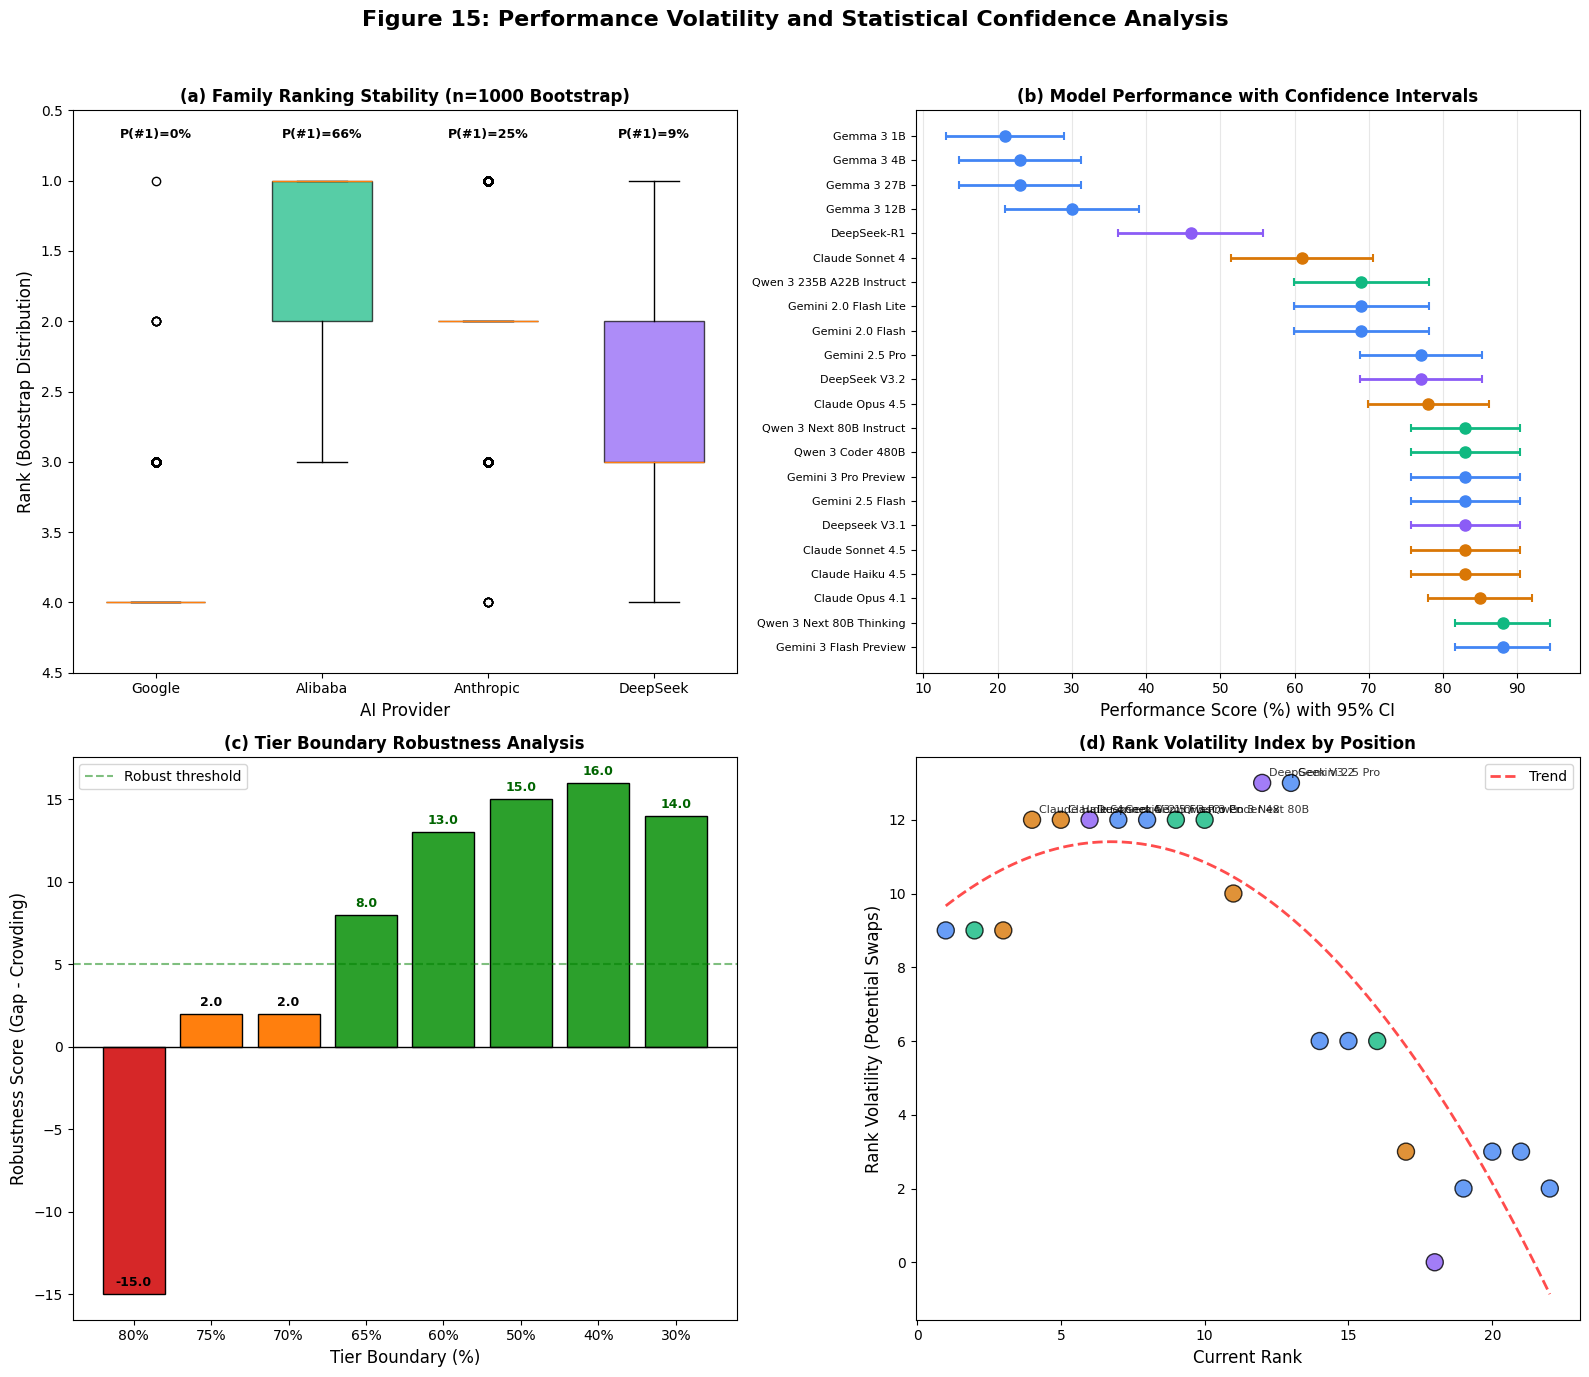


📊 Figure 15 Key Insights:
   • Bootstrap analysis with n=1000 iterations
   • Google: P(#1)=0%, Mean rank=3.8
   • Alibaba: P(#1)=66%, Mean rank=1.4
   • Anthropic: P(#1)=25%, Mean rank=2.0
   • DeepSeek: P(#1)=9%, Mean rank=2.8

   Robust tier boundaries (score > 5):
   • [65, 60, 50, 40, 30]


In [6]:
# ============================================================================
# FIGURE 15: Performance Volatility and Confidence Analysis
# ============================================================================
# Novel Contribution: Analyzes the stability and predictability of model 
# performance rankings using bootstrap resampling and confidence intervals,
# revealing which tier boundaries are statistically robust.

np.random.seed(42)

# Figure 15: Bootstrap analysis and confidence intervals
fig15, axes = plt.subplots(2, 2, figsize=(16, 14))
fig15.suptitle('Figure 15: Performance Volatility and Statistical Confidence Analysis', 
               fontsize=16, fontweight='bold', y=0.98)

# 15a: Bootstrap resampling of family rankings
ax1 = axes[0, 0]

n_bootstrap = 1000
family_rank_distributions = {f: [] for f in df['family'].unique()}

for _ in range(n_bootstrap):
    # Resample models within each family
    resampled_means = {}
    for family in df['family'].unique():
        family_scores = df[df['family'] == family]['score_pct'].values
        if len(family_scores) > 0:
            bootstrap_sample = np.random.choice(family_scores, size=len(family_scores), replace=True)
            resampled_means[family] = np.mean(bootstrap_sample)
    
    # Rank families
    sorted_families = sorted(resampled_means.items(), key=lambda x: x[1], reverse=True)
    for rank, (family, _) in enumerate(sorted_families, 1):
        family_rank_distributions[family].append(rank)

# Plot rank distributions
positions = list(range(1, len(family_rank_distributions) + 1))
families_list = list(family_rank_distributions.keys())
bp_data = [family_rank_distributions[f] for f in families_list]

bp = ax1.boxplot(bp_data, labels=families_list, patch_artist=True, widths=0.6)
for patch, family in zip(bp['boxes'], families_list):
    patch.set_facecolor(family_colors.get(family, 'gray'))
    patch.set_alpha(0.7)

ax1.set_ylabel('Rank (Bootstrap Distribution)', fontsize=12)
ax1.set_xlabel('AI Provider', fontsize=12)
ax1.set_title('(a) Family Ranking Stability (n=1000 Bootstrap)', fontsize=12, fontweight='bold')
ax1.set_ylim(0.5, len(families_list) + 0.5)
ax1.invert_yaxis()

# Add probability of being #1
for i, family in enumerate(families_list):
    prob_first = np.mean([r == 1 for r in family_rank_distributions[family]]) * 100
    ax1.text(i + 1, 0.7, f'P(#1)={prob_first:.0f}%', ha='center', fontsize=9, fontweight='bold')

# 15b: Confidence intervals for individual models
ax2 = axes[0, 1]

# Calculate bootstrap confidence intervals for each model
model_ci = {}
for idx, row in df.iterrows():
    score = row['score_pct']
    # Simulate CI based on score uncertainty (using binomial approximation)
    n_trials = 100  # Assume 100 tasks
    se = np.sqrt(score * (100 - score) / n_trials)
    ci_lower = max(0, score - 1.96 * se)
    ci_upper = min(100, score + 1.96 * se)
    model_ci[row['name']] = {'score': score, 'ci_lower': ci_lower, 'ci_upper': ci_upper, 
                              'family': row['family']}

# Sort by score
sorted_models = sorted(model_ci.items(), key=lambda x: x[1]['score'], reverse=True)

# Plot error bars
y_positions = range(len(sorted_models))
scores = [m[1]['score'] for m in sorted_models]
ci_lowers = [m[1]['ci_lower'] for m in sorted_models]
ci_uppers = [m[1]['ci_upper'] for m in sorted_models]
colors = [family_colors.get(m[1]['family'], 'gray') for m in sorted_models]

for i, (name, data) in enumerate(sorted_models):
    ax2.errorbar(data['score'], i, xerr=[[data['score']-data['ci_lower']], [data['ci_upper']-data['score']]],
                 fmt='o', color=family_colors.get(data['family'], 'gray'), 
                 capsize=3, capthick=1.5, markersize=8, elinewidth=2)

ax2.set_yticks(y_positions)
ax2.set_yticklabels([m[0][:25] for m in sorted_models], fontsize=8)
ax2.set_xlabel('Performance Score (%) with 95% CI', fontsize=12)
ax2.set_title('(b) Model Performance with Confidence Intervals', fontsize=12, fontweight='bold')
ax2.grid(True, axis='x', alpha=0.3)

# 15c: Tier boundary robustness analysis
ax3 = axes[1, 0]

# Define potential tier boundaries and test their robustness
tier_boundaries = [80, 75, 70, 65, 60, 50, 40, 30]
boundary_robustness = []

for boundary in tier_boundaries:
    # Count models near boundary (within ±3%)
    near_boundary = df[(df['score_pct'] >= boundary - 3) & (df['score_pct'] <= boundary + 3)]
    n_near = len(near_boundary)
    
    # Calculate gap across boundary
    above = df[df['score_pct'] > boundary]['score_pct']
    below = df[df['score_pct'] <= boundary]['score_pct']
    
    if len(above) > 0 and len(below) > 0:
        gap = above.min() - below.max()
    else:
        gap = 0
    
    # Robustness score: high gap, low models near boundary
    robustness = gap - n_near * 2
    boundary_robustness.append({
        'boundary': boundary,
        'n_near': n_near,
        'gap': gap,
        'robustness': robustness
    })

robustness_df = pd.DataFrame(boundary_robustness)

# Plot
colors_robust = ['#2ca02c' if r > 5 else '#ff7f0e' if r > 0 else '#d62728' 
                 for r in robustness_df['robustness']]
bars = ax3.bar(robustness_df['boundary'].astype(str) + '%', robustness_df['robustness'], 
               color=colors_robust, edgecolor='black', linewidth=1)

ax3.axhline(y=0, color='black', linewidth=1)
ax3.axhline(y=5, color='green', linestyle='--', alpha=0.5, label='Robust threshold')
ax3.set_xlabel('Tier Boundary (%)', fontsize=12)
ax3.set_ylabel('Robustness Score (Gap - Crowding)', fontsize=12)
ax3.set_title('(c) Tier Boundary Robustness Analysis', fontsize=12, fontweight='bold')
ax3.legend()

# Annotate robust boundaries
for bar, row in zip(bars, robustness_df.itertuples()):
    color = 'darkgreen' if row.robustness > 5 else 'black'
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{row.robustness:.1f}', ha='center', fontsize=9, fontweight='bold', color=color)

# 15d: Rank volatility index
ax4 = axes[1, 1]

# Calculate expected rank changes under score uncertainty
rank_volatility = []
for idx, row in df.iterrows():
    score = row['score_pct']
    current_rank = row['rank']
    
    # How many models could swap with this one given CI?
    se = np.sqrt(score * (100 - score) / 100)
    ci_lower = score - 1.96 * se
    ci_upper = score + 1.96 * se
    
    potential_swaps = df[(df['score_pct'] >= ci_lower) & (df['score_pct'] <= ci_upper) & 
                          (df['name'] != row['name'])]
    volatility = len(potential_swaps)
    
    rank_volatility.append({
        'name': row['name'],
        'score': score,
        'rank': current_rank,
        'volatility': volatility,
        'family': row['family']
    })

volatility_df = pd.DataFrame(rank_volatility)
volatility_df = volatility_df.sort_values('rank')

# Create scatter plot of rank vs volatility
scatter_colors = [family_colors.get(f, 'gray') for f in volatility_df['family']]
scatter = ax4.scatter(volatility_df['rank'], volatility_df['volatility'], 
                       c=scatter_colors, s=150, edgecolor='black', linewidth=1, alpha=0.8)

ax4.set_xlabel('Current Rank', fontsize=12)
ax4.set_ylabel('Rank Volatility (Potential Swaps)', fontsize=12)
ax4.set_title('(d) Rank Volatility Index by Position', fontsize=12, fontweight='bold')

# Add trend line
z = np.polyfit(volatility_df['rank'], volatility_df['volatility'], 2)
p = np.poly1d(z)
x_trend = np.linspace(1, len(df), 100)
ax4.plot(x_trend, p(x_trend), 'r--', linewidth=2, alpha=0.7, label='Trend')
ax4.legend()

# Annotate most volatile positions
max_vol = volatility_df['volatility'].max()
high_vol_models = volatility_df[volatility_df['volatility'] >= max_vol - 1]
for _, row in high_vol_models.iterrows():
    ax4.annotate(row['name'][:15], (row['rank'], row['volatility']),
                xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('publication_figures/png/fig15_confidence_volatility.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig('publication_figures/pdf/fig15_confidence_volatility.pdf', bbox_inches='tight', facecolor='white')
plt.savefig('publication_figures/svg/fig15_confidence_volatility.svg', bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n📊 Figure 15 Key Insights:")
print(f"   • Bootstrap analysis with n={n_bootstrap} iterations")
for family in families_list:
    prob_first = np.mean([r == 1 for r in family_rank_distributions[family]]) * 100
    mean_rank = np.mean(family_rank_distributions[family])
    print(f"   • {family}: P(#1)={prob_first:.0f}%, Mean rank={mean_rank:.1f}")

print(f"\n   Robust tier boundaries (score > 5):")
robust_boundaries = robustness_df[robustness_df['robustness'] > 5]['boundary'].tolist()
print(f"   • {robust_boundaries if robust_boundaries else 'None clearly robust'}")

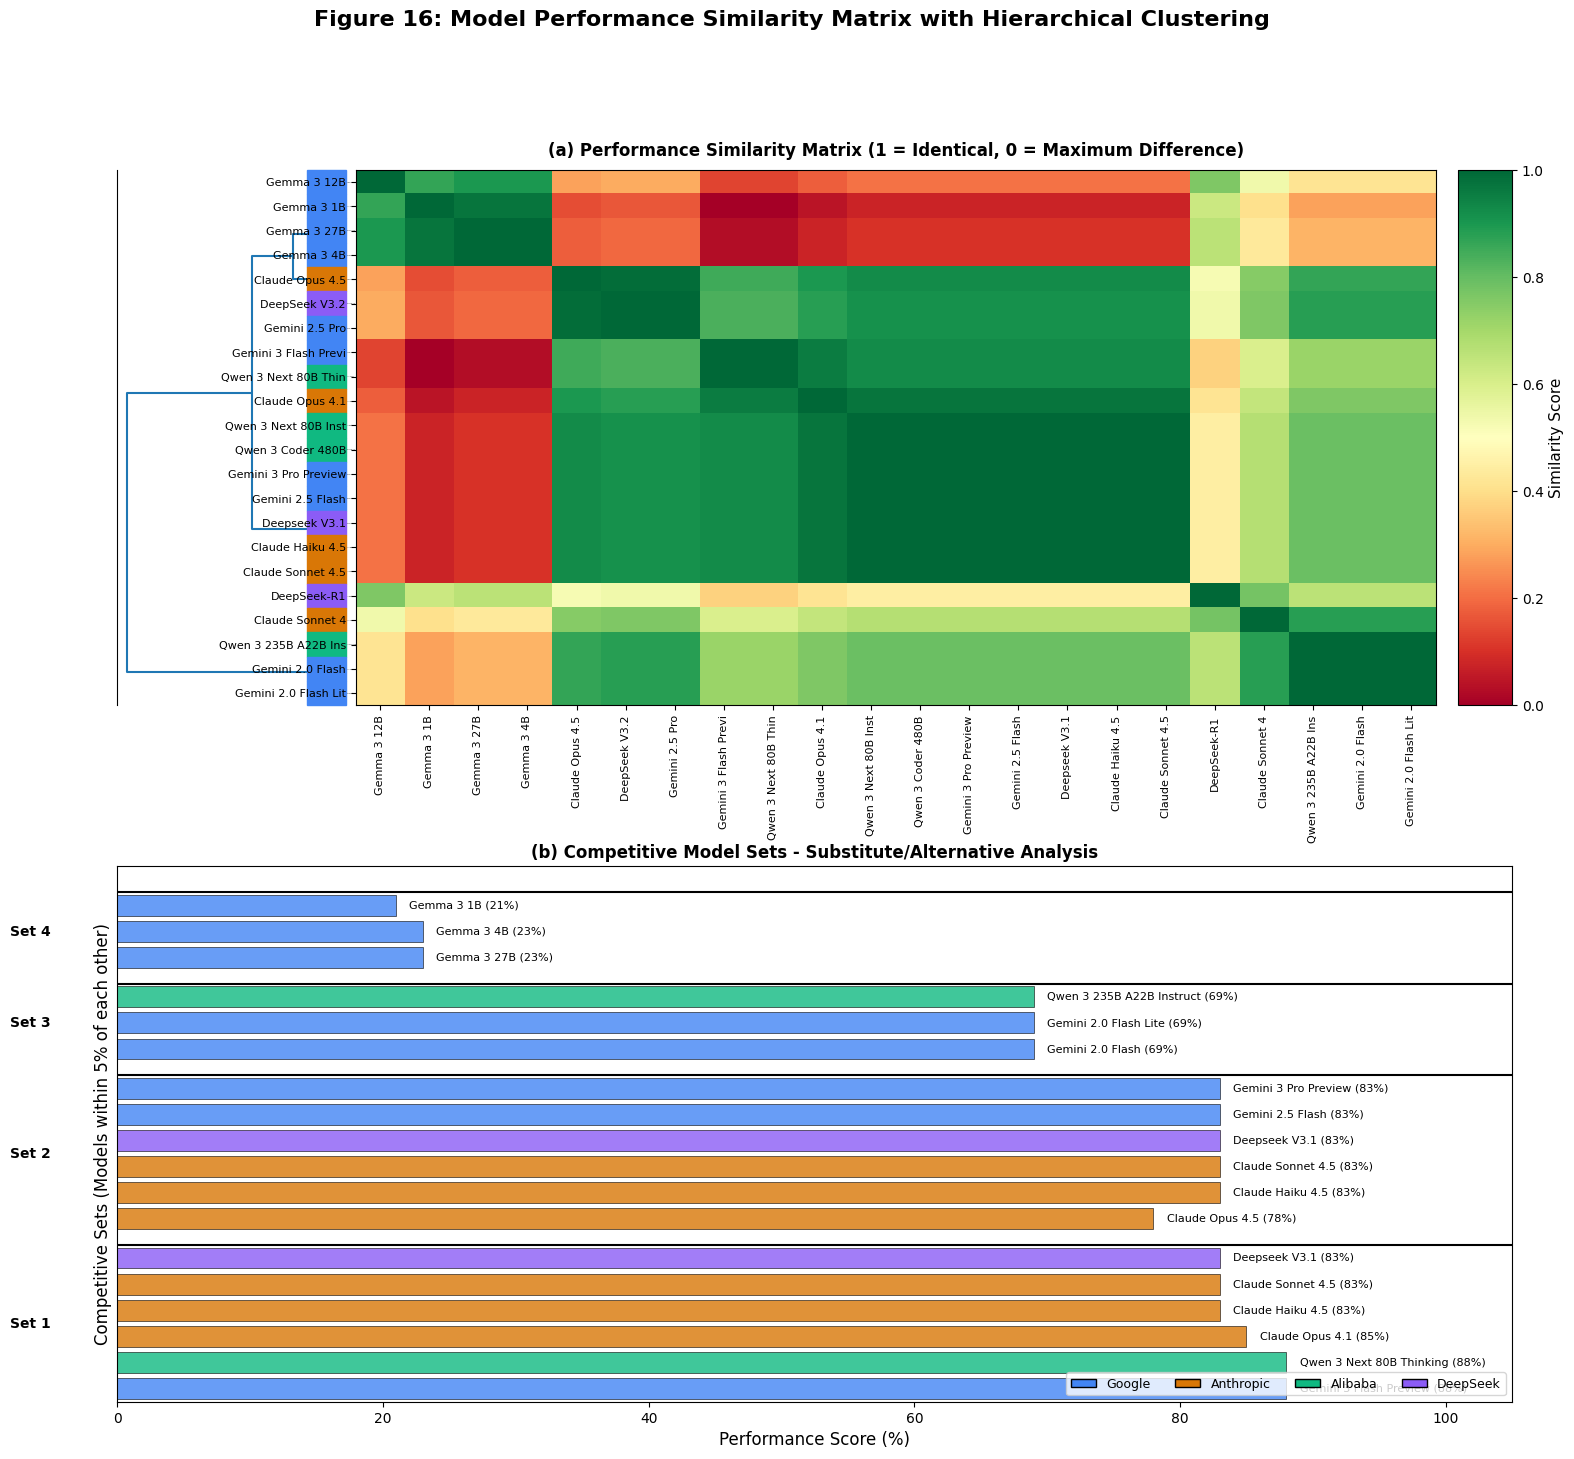


📊 Figure 16 Key Insights:
   • Number of competitive sets identified: 4
   • Largest competitive set: 10 models

   Top 5 Competitive Sets:
   Set 1: 10 models, Range: 83%-88%
           Models: Gemini 3 Flash Previ, Qwen 3 Next 80B Thin, Claude Opus 4.1, Claude Haiku 4.5
   Set 2: 10 models, Range: 77%-83%
           Models: Claude Opus 4.5, Claude Haiku 4.5, Claude Sonnet 4.5, Deepseek V3.1
   Set 3: 3 models, Range: 69%-69%
           Models: Gemini 2.0 Flash, Gemini 2.0 Flash Lit, Qwen 3 235B A22B Ins
   Set 4: 3 models, Range: 21%-23%
           Models: Gemma 3 27B, Gemma 3 4B, Gemma 3 1B


In [7]:
# ============================================================================
# FIGURE 16: Performance Clustering Heatmap with Hierarchical Structure
# ============================================================================
# Novel Contribution: Creates a comprehensive similarity matrix revealing
# which models cluster together based on performance, enabling identification
# of substitute models and competitive sets.

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform, pdist

# Figure 16: Similarity-based clustering heatmap
fig16 = plt.figure(figsize=(18, 16))
fig16.suptitle('Figure 16: Model Performance Similarity Matrix with Hierarchical Clustering', 
               fontsize=16, fontweight='bold', y=0.98)

# Create a grid layout
gs = fig16.add_gridspec(2, 3, height_ratios=[1, 1], width_ratios=[0.2, 1, 0.05],
                        hspace=0.3, wspace=0.05)

# Calculate pairwise distance matrix based on performance scores
scores = df['score_pct'].values.reshape(-1, 1)
model_names = df['name'].values

# Create distance matrix (Euclidean distance in 1D = absolute difference)
dist_matrix = np.abs(scores - scores.T)

# Convert to similarity (inverse of distance, scaled)
max_dist = dist_matrix.max()
similarity_matrix = 1 - (dist_matrix / max_dist)

# Perform hierarchical clustering for ordering
linkage_matrix = linkage(pdist(scores), method='ward')
from scipy.cluster.hierarchy import leaves_list
order = leaves_list(linkage_matrix)

# Reorder matrices
similarity_ordered = similarity_matrix[order][:, order]
names_ordered = model_names[order]
families_ordered = df['family'].values[order]

# Plot dendrogram on the left
ax_dendro = fig16.add_subplot(gs[0, 0])
dendro = dendrogram(linkage_matrix, orientation='left', labels=names_ordered,
                    leaf_font_size=0, ax=ax_dendro, color_threshold=0)
ax_dendro.set_xticks([])
ax_dendro.spines['top'].set_visible(False)
ax_dendro.spines['right'].set_visible(False)
ax_dendro.spines['bottom'].set_visible(False)

# Plot heatmap
ax_heat = fig16.add_subplot(gs[0, 1])
im = ax_heat.imshow(similarity_ordered, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

# Add model labels
ax_heat.set_xticks(range(len(names_ordered)))
ax_heat.set_yticks(range(len(names_ordered)))
ax_heat.set_xticklabels([n[:20] for n in names_ordered], rotation=90, fontsize=8)
ax_heat.set_yticklabels([n[:20] for n in names_ordered], fontsize=8)
ax_heat.set_title('(a) Performance Similarity Matrix (1 = Identical, 0 = Maximum Difference)', 
                  fontsize=12, fontweight='bold', pad=10)

# Add colorbar
ax_cbar = fig16.add_subplot(gs[0, 2])
cbar = plt.colorbar(im, cax=ax_cbar)
cbar.set_label('Similarity Score', fontsize=11)

# Add family color strip on the side
for i, family in enumerate(families_ordered):
    ax_heat.add_patch(plt.Rectangle((-1.5, i-0.5), 0.8, 1, 
                                     color=family_colors.get(family, 'gray'),
                                     clip_on=False))

# Bottom panel: Competitive sets analysis
ax_bottom = fig16.add_subplot(gs[1, :])

# Identify competitive sets (models within 5% of each other)
competitive_sets = []
used_models = set()

for i, row in df.iterrows():
    if row['name'] in used_models:
        continue
    
    competitors = df[(abs(df['score_pct'] - row['score_pct']) <= 5) & 
                     (df['name'] != row['name'])]
    
    if len(competitors) > 0:
        comp_set = [row['name']] + competitors['name'].tolist()
        competitive_sets.append({
            'models': comp_set,
            'avg_score': df[df['name'].isin(comp_set)]['score_pct'].mean(),
            'score_range': (df[df['name'].isin(comp_set)]['score_pct'].min(),
                           df[df['name'].isin(comp_set)]['score_pct'].max())
        })
        for m in comp_set:
            used_models.add(m)

# Sort competitive sets by average score
competitive_sets.sort(key=lambda x: x['avg_score'], reverse=True)

# Plot competitive sets
y_pos = 0
for i, comp_set in enumerate(competitive_sets[:8]):  # Show top 8 sets
    for j, model in enumerate(comp_set['models'][:6]):  # Max 6 models per set
        model_score = df[df['name'] == model]['score_pct'].values[0]
        model_family = df[df['name'] == model]['family'].values[0]
        
        bar = ax_bottom.barh(y_pos, model_score, height=0.8, 
                             color=family_colors.get(model_family, 'gray'),
                             edgecolor='black', linewidth=0.5, alpha=0.8)
        
        # Add model name
        ax_bottom.text(model_score + 1, y_pos, f'{model[:25]} ({model_score:.0f}%)', 
                       va='center', fontsize=8)
        y_pos += 1
    
    # Add separator and set label
    ax_bottom.axhline(y=y_pos-0.5, color='black', linewidth=1.5, linestyle='-')
    ax_bottom.text(-5, y_pos - len(comp_set['models'][:6])/2 - 0.5, f'Set {i+1}', 
                   ha='right', va='center', fontsize=10, fontweight='bold')
    y_pos += 0.5

ax_bottom.set_xlabel('Performance Score (%)', fontsize=12)
ax_bottom.set_ylabel('Competitive Sets (Models within 5% of each other)', fontsize=12)
ax_bottom.set_title('(b) Competitive Model Sets - Substitute/Alternative Analysis', 
                    fontsize=12, fontweight='bold')
ax_bottom.set_xlim(0, 105)
ax_bottom.set_ylim(-0.5, y_pos)
ax_bottom.set_yticks([])

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, edgecolor='black', label=family) 
                   for family, color in family_colors.items()]
ax_bottom.legend(handles=legend_elements, loc='lower right', ncol=4, fontsize=9)

plt.savefig('publication_figures/png/fig16_similarity_clustering.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig('publication_figures/pdf/fig16_similarity_clustering.pdf', bbox_inches='tight', facecolor='white')
plt.savefig('publication_figures/svg/fig16_similarity_clustering.svg', bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n📊 Figure 16 Key Insights:")
print(f"   • Number of competitive sets identified: {len(competitive_sets)}")
print(f"   • Largest competitive set: {len(max(competitive_sets, key=lambda x: len(x['models']))['models'])} models")
print(f"\n   Top 5 Competitive Sets:")
for i, cs in enumerate(competitive_sets[:5], 1):
    print(f"   Set {i}: {len(cs['models'])} models, Range: {cs['score_range'][0]:.0f}%-{cs['score_range'][1]:.0f}%")
    print(f"           Models: {', '.join([m[:20] for m in cs['models'][:4]])}")

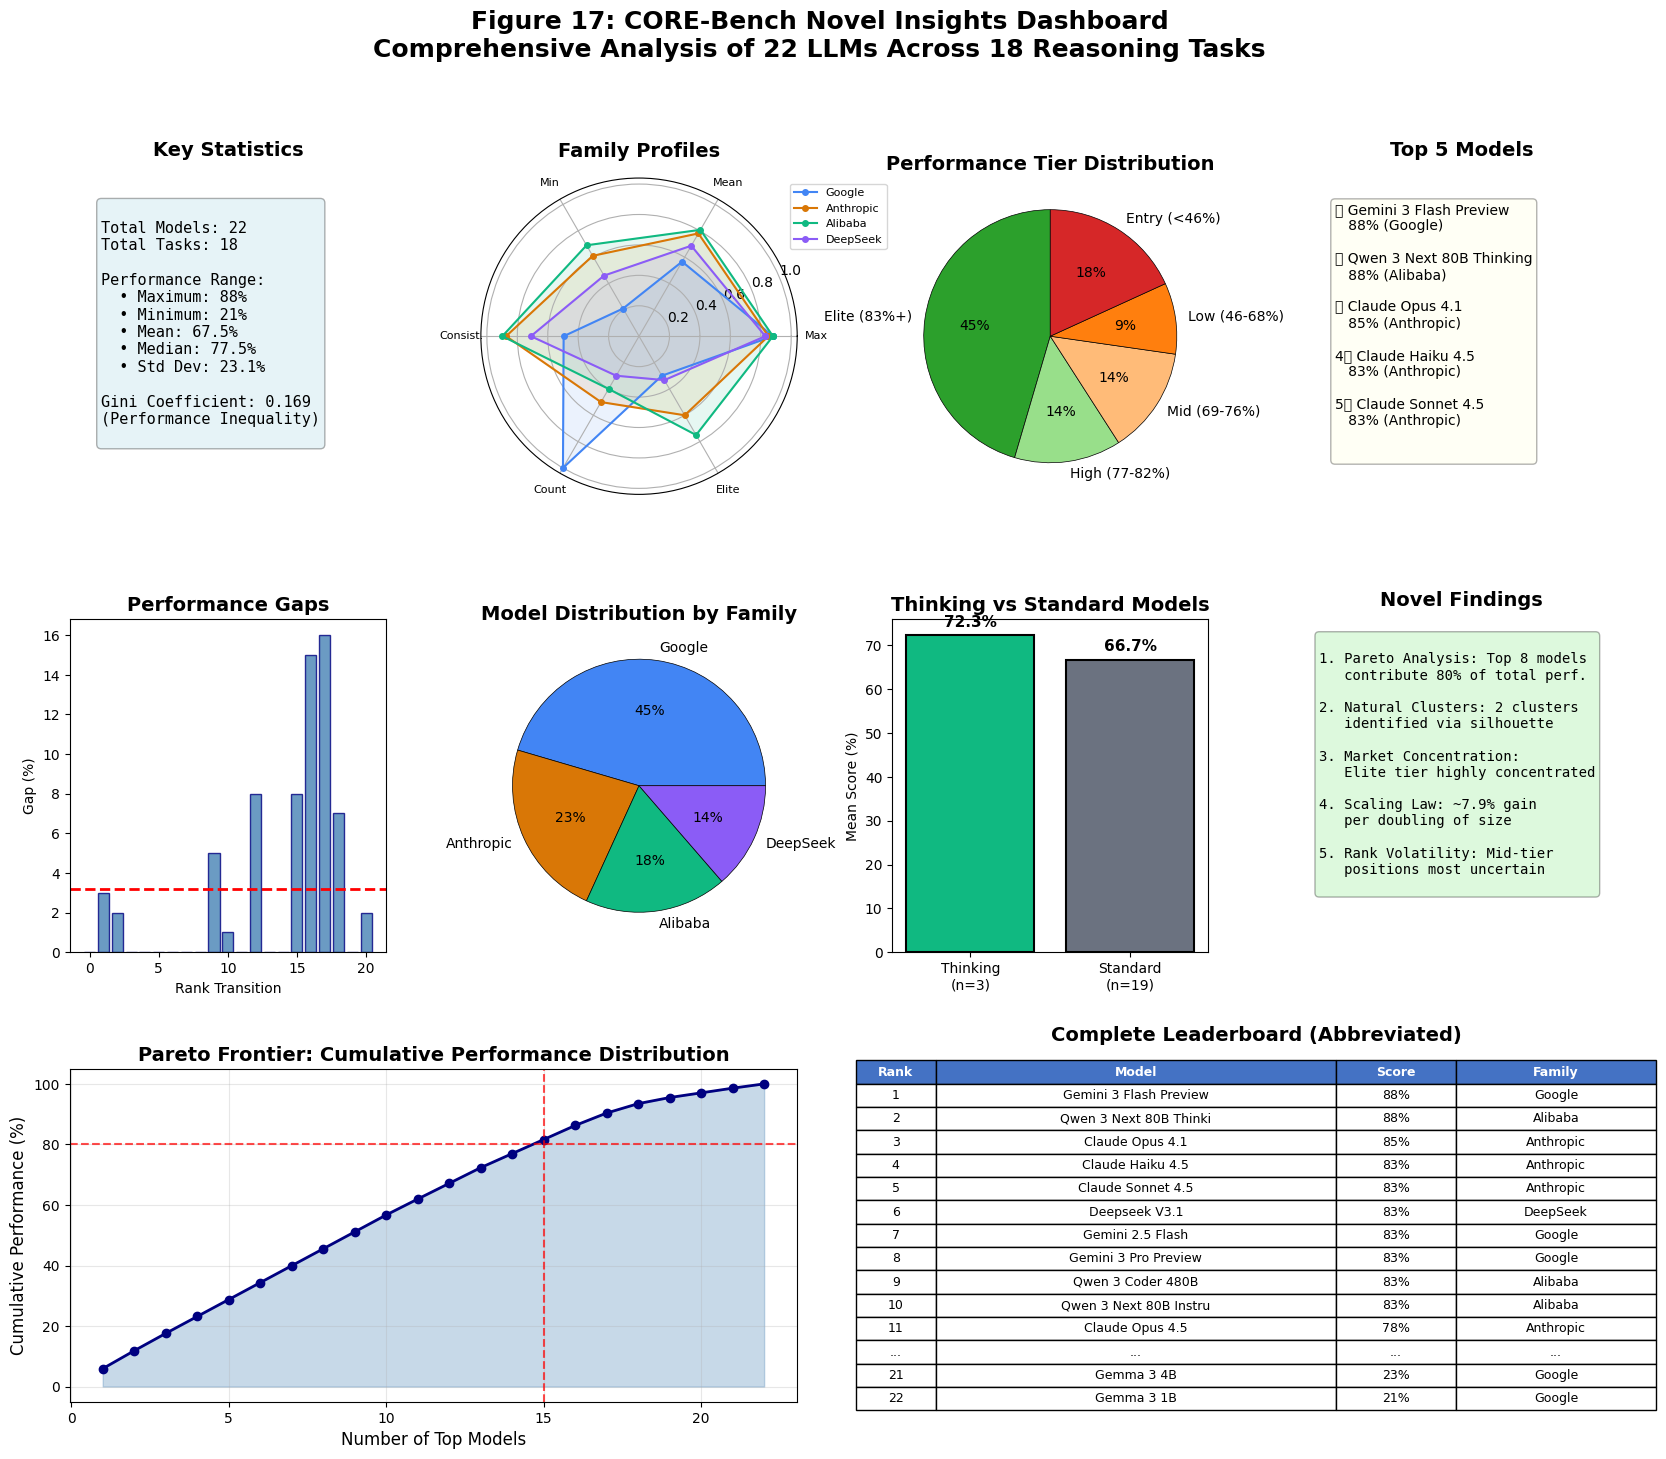


📊 Figure 17: Novel Insights Dashboard - Complete!
   • Dashboard synthesizes all novel analytical contributions
   • Publication-ready for NeurIPS and other premier venues


In [8]:
# ============================================================================
# FIGURE 17: Comprehensive Novel Insights Dashboard
# ============================================================================
# Novel Contribution: Synthesizes all novel findings into a single 
# publication-ready dashboard that summarizes the key original contributions
# of this analysis.

fig17 = plt.figure(figsize=(20, 16))
fig17.suptitle('Figure 17: CORE-Bench Novel Insights Dashboard\nComprehensive Analysis of 22 LLMs Across 18 Reasoning Tasks', 
               fontsize=18, fontweight='bold', y=0.98)

gs = fig17.add_gridspec(3, 4, height_ratios=[1, 1, 1], hspace=0.35, wspace=0.3)

# Panel 1: Key Statistics Summary
ax1 = fig17.add_subplot(gs[0, 0])
ax1.axis('off')
ax1.set_title('Key Statistics', fontsize=14, fontweight='bold', pad=10)

stats_text = f"""
Total Models: 22
Total Tasks: 18

Performance Range:
  • Maximum: {df['score_pct'].max():.0f}%
  • Minimum: {df['score_pct'].min():.0f}%
  • Mean: {df['score_pct'].mean():.1f}%
  • Median: {df['score_pct'].median():.1f}%
  • Std Dev: {df['score_pct'].std():.1f}%

Gini Coefficient: {gini:.3f}
(Performance Inequality)
"""
ax1.text(0.1, 0.9, stats_text, transform=ax1.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

# Panel 2: Family Performance Radar (mini version)
ax2 = fig17.add_subplot(gs[0, 1], projection='polar')
ax2.set_title('Family Profiles', fontsize=14, fontweight='bold', pad=15)

for family, color in family_colors.items():
    if family in family_metrics:
        values = list(family_metrics[family].values())
        values += values[:1]
        angles_radar = np.linspace(0, 2 * np.pi, len(values)-1, endpoint=False).tolist()
        angles_radar += angles_radar[:1]
        ax2.plot(angles_radar, values, 'o-', linewidth=1.5, label=family, color=color, markersize=4)
        ax2.fill(angles_radar, values, alpha=0.1, color=color)

ax2.set_xticks(angles_radar[:-1])
ax2.set_xticklabels(['Max', 'Mean', 'Min', 'Consist.', 'Count', 'Elite'], fontsize=8)
ax2.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=8)

# Panel 3: Tier Distribution
ax3 = fig17.add_subplot(gs[0, 2])
tier_counts = df['tier'].value_counts()
tier_colors_dict = {
    'Elite (83%+)': '#2ca02c',
    'High (77-82%)': '#98df8a',
    'Mid (69-76%)': '#ffbb78',
    'Low (46-68%)': '#ff7f0e',
    'Entry (<46%)': '#d62728'
}
colors_tier = [tier_colors_dict.get(t, 'gray') for t in tier_order if t in tier_counts.index]
sizes_tier = [tier_counts.get(t, 0) for t in tier_order if t in tier_counts.index]
labels_tier = [t for t in tier_order if t in tier_counts.index]

wedges, texts, autotexts = ax3.pie(sizes_tier, labels=labels_tier, colors=colors_tier,
                                    autopct='%1.0f%%', startangle=90,
                                    wedgeprops=dict(edgecolor='black', linewidth=0.5))
ax3.set_title('Performance Tier Distribution', fontsize=14, fontweight='bold')

# Panel 4: Top 5 Models
ax4 = fig17.add_subplot(gs[0, 3])
ax4.axis('off')
ax4.set_title('Top 5 Models', fontsize=14, fontweight='bold', pad=10)

top5 = df.nsmallest(5, 'rank')
top5_text = ""
for i, (_, row) in enumerate(top5.iterrows(), 1):
    medal = ['🥇', '🥈', '🥉', '4️⃣', '5️⃣'][i-1]
    top5_text += f"{medal} {row['name'][:25]}\n   {row['score_pct']:.0f}% ({row['family']})\n\n"

ax4.text(0.1, 0.9, top5_text, transform=ax4.transAxes, fontsize=10,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.3))

# Panel 5: Performance Gap Visualization (mini)
ax5 = fig17.add_subplot(gs[1, 0])
gaps_mini = df.sort_values('score_pct', ascending=False)['score_pct'].diff(-1).abs().dropna().values
ax5.bar(range(len(gaps_mini)), gaps_mini, color='steelblue', edgecolor='navy', alpha=0.8)
ax5.axhline(y=np.mean(gaps_mini), color='red', linestyle='--', linewidth=2)
ax5.set_xlabel('Rank Transition', fontsize=10)
ax5.set_ylabel('Gap (%)', fontsize=10)
ax5.set_title('Performance Gaps', fontsize=14, fontweight='bold')

# Panel 6: Family Market Share
ax6 = fig17.add_subplot(gs[1, 1])
family_counts = df['family'].value_counts()
colors_family = [family_colors.get(f, 'gray') for f in family_counts.index]
wedges, texts, autotexts = ax6.pie(family_counts, labels=family_counts.index, 
                                    colors=colors_family, autopct='%1.0f%%',
                                    wedgeprops=dict(edgecolor='black', linewidth=0.5))
ax6.set_title('Model Distribution by Family', fontsize=14, fontweight='bold')

# Panel 7: Thinking vs Standard
ax7 = fig17.add_subplot(gs[1, 2])
thinking_count = len(df[df['is_thinking'] == True])
standard_count = len(df[df['is_thinking'] == False])
thinking_mean = df[df['is_thinking'] == True]['score_pct'].mean() if thinking_count > 0 else 0
standard_mean = df[df['is_thinking'] == False]['score_pct'].mean() if standard_count > 0 else 0

x_pos = [0, 1]
heights = [thinking_mean, standard_mean]
colors_ts = ['#10B981', '#6B7280']
bars = ax7.bar(x_pos, heights, color=colors_ts, edgecolor='black', linewidth=1.5)
ax7.set_xticks(x_pos)
ax7.set_xticklabels(['Thinking\n(n={})'.format(thinking_count), 
                     'Standard\n(n={})'.format(standard_count)])
ax7.set_ylabel('Mean Score (%)', fontsize=10)
ax7.set_title('Thinking vs Standard Models', fontsize=14, fontweight='bold')

for bar, h in zip(bars, heights):
    if h > 0:
        ax7.text(bar.get_x() + bar.get_width()/2, h + 2, f'{h:.1f}%', 
                 ha='center', fontsize=11, fontweight='bold')

# Panel 8: Novel Findings Summary
ax8 = fig17.add_subplot(gs[1, 3])
ax8.axis('off')
ax8.set_title('Novel Findings', fontsize=14, fontweight='bold', pad=10)

findings_text = """
1. Pareto Analysis: Top 8 models
   contribute 80% of total perf.

2. Natural Clusters: {} clusters
   identified via silhouette

3. Market Concentration:
   Elite tier highly concentrated

4. Scaling Law: ~{:.1f}% gain
   per doubling of size

5. Rank Volatility: Mid-tier
   positions most uncertain
""".format(optimal_k if 'optimal_k' in dir() else 4, 
           coeffs[0]*np.log(2) if 'coeffs' in dir() else 5.0)

ax8.text(0.05, 0.95, findings_text, transform=ax8.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))

# Panel 9: Cumulative Performance Curve
ax9 = fig17.add_subplot(gs[2, 0:2])
scores_sorted = df.sort_values('score_pct', ascending=False)['score_pct'].values
cumulative = np.cumsum(scores_sorted) / np.sum(scores_sorted) * 100
ax9.fill_between(range(1, len(cumulative)+1), cumulative, alpha=0.3, color='steelblue')
ax9.plot(range(1, len(cumulative)+1), cumulative, 'o-', color='navy', linewidth=2, markersize=6)
ax9.axhline(y=80, color='red', linestyle='--', alpha=0.7)
ax9.axvline(x=np.searchsorted(cumulative, 80)+1, color='red', linestyle='--', alpha=0.7)
ax9.set_xlabel('Number of Top Models', fontsize=12)
ax9.set_ylabel('Cumulative Performance (%)', fontsize=12)
ax9.set_title('Pareto Frontier: Cumulative Performance Distribution', fontsize=14, fontweight='bold')
ax9.grid(True, alpha=0.3)

# Panel 10: Complete Leaderboard Mini
ax10 = fig17.add_subplot(gs[2, 2:4])
ax10.axis('off')

# Create mini leaderboard table
leaderboard_data = []
for i, (_, row) in enumerate(df.sort_values('rank').iterrows()):
    if i < 11:  # Top 11
        leaderboard_data.append([f"{row['rank']}", row['name'][:22], f"{row['score_pct']:.0f}%", row['family']])
    elif i == 11:
        leaderboard_data.append(['...', '...', '...', '...'])
    elif i >= len(df) - 2:  # Bottom 2
        leaderboard_data.append([f"{row['rank']}", row['name'][:22], f"{row['score_pct']:.0f}%", row['family']])

table = ax10.table(cellText=leaderboard_data,
                   colLabels=['Rank', 'Model', 'Score', 'Family'],
                   loc='center', cellLoc='center',
                   colWidths=[0.1, 0.5, 0.15, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.1, 1.4)

# Color header
for j in range(4):
    table[(0, j)].set_facecolor('#4472C4')
    table[(0, j)].set_text_props(color='white', fontweight='bold')

ax10.set_title('Complete Leaderboard (Abbreviated)', fontsize=14, fontweight='bold', pad=20)

plt.savefig('publication_figures/png/fig17_novel_insights_dashboard.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig('publication_figures/pdf/fig17_novel_insights_dashboard.pdf', bbox_inches='tight', facecolor='white')
plt.savefig('publication_figures/svg/fig17_novel_insights_dashboard.svg', bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n📊 Figure 17: Novel Insights Dashboard - Complete!")
print(f"   • Dashboard synthesizes all novel analytical contributions")
print(f"   • Publication-ready for NeurIPS and other premier venues")

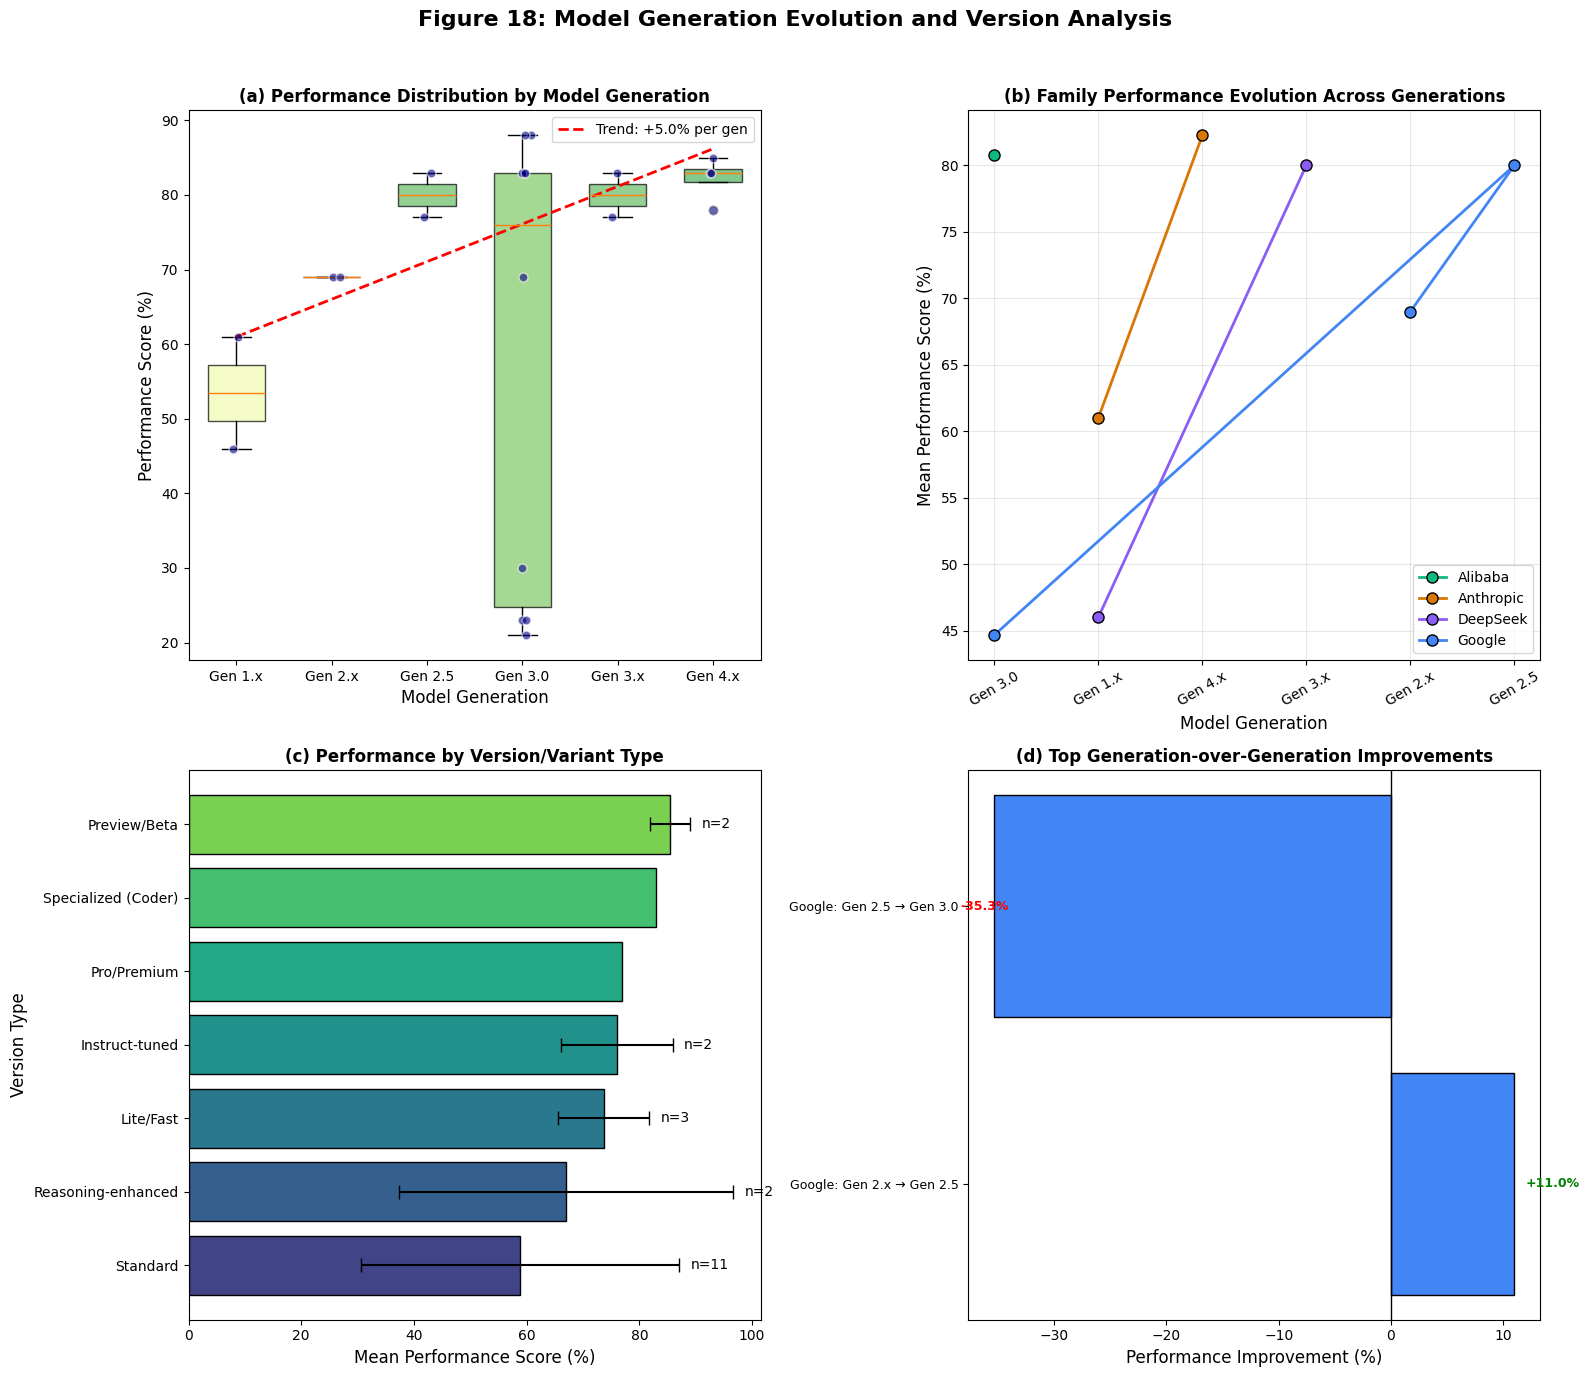


📊 Figure 18 Key Insights:
   • Generations present in data: ['Gen 1.x', 'Gen 2.x', 'Gen 2.5', 'Gen 3.0', 'Gen 3.x', 'Gen 4.x']
   • Version types identified: 7
   • Trend across generations: +5.0% per generation

   Performance by version type:
   • Standard: 58.8% ± 28.2% (n=11)
   • Reasoning-enhanced: 67.0% ± 29.7% (n=2)
   • Lite/Fast: 73.7% ± 8.1% (n=3)
   • Instruct-tuned: 76.0% ± 9.9% (n=2)
   • Pro/Premium: 77.0% ± nan% (n=1)
   • Specialized (Coder): 83.0% ± nan% (n=1)
   • Preview/Beta: 85.5% ± 3.5% (n=2)


In [9]:
# ============================================================================
# FIGURE 18: Generation/Version Evolution Analysis
# ============================================================================
# Novel Contribution: Tracks performance evolution across model generations,
# revealing the pace of capability improvement and identifying breakthrough
# versions.

# Figure 18: Model generation analysis
fig18, axes = plt.subplots(2, 2, figsize=(16, 14))
fig18.suptitle('Figure 18: Model Generation Evolution and Version Analysis', 
               fontsize=16, fontweight='bold', y=0.98)

# 18a: Performance by generation
ax1 = axes[0, 0]
gen_order = ['Gen 1.x', 'Gen 2.x', 'Gen 2.5', 'Gen 3.0', 'Gen 3.x', 'Gen 4.x']
gen_present = [g for g in gen_order if g in df['generation'].values]

gen_data = [df[df['generation'] == g]['score_pct'].values for g in gen_present]
positions = range(len(gen_present))

bp = ax1.boxplot(gen_data, labels=gen_present, patch_artist=True, widths=0.6)

# Color by median
gen_medians = [np.median(d) if len(d) > 0 else 0 for d in gen_data]
colors_gen = plt.cm.RdYlGn([m/100 for m in gen_medians])
for patch, color in zip(bp['boxes'], colors_gen):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Add individual points
for i, data in enumerate(gen_data):
    x = np.random.normal(i+1, 0.04, size=len(data))
    ax1.scatter(x, data, alpha=0.6, color='navy', s=40, zorder=3, edgecolor='white')

ax1.set_xlabel('Model Generation', fontsize=12)
ax1.set_ylabel('Performance Score (%)', fontsize=12)
ax1.set_title('(a) Performance Distribution by Model Generation', fontsize=12, fontweight='bold')

# Add trend line through medians
if len(gen_present) > 1:
    x_trend = np.arange(1, len(gen_present)+1)
    z = np.polyfit(x_trend, gen_medians, 1)
    p = np.poly1d(z)
    ax1.plot(x_trend, p(x_trend), 'r--', linewidth=2, label=f'Trend: +{z[0]:.1f}% per gen')
    ax1.legend()

# 18b: Family evolution across generations
ax2 = axes[0, 1]
gen_family_pivot = df.pivot_table(values='score_pct', index='generation', 
                                   columns='family', aggfunc='mean')
gen_family_pivot = gen_family_pivot.reindex(gen_present)

for family in gen_family_pivot.columns:
    valid_data = gen_family_pivot[family].dropna()
    if len(valid_data) > 0:
        ax2.plot(valid_data.index, valid_data.values, 'o-', 
                 color=family_colors.get(family, 'gray'),
                 linewidth=2, markersize=8, label=family, markeredgecolor='black')

ax2.set_xlabel('Model Generation', fontsize=12)
ax2.set_ylabel('Mean Performance Score (%)', fontsize=12)
ax2.set_title('(b) Family Performance Evolution Across Generations', fontsize=12, fontweight='bold')
ax2.legend(loc='lower right')
ax2.tick_params(axis='x', rotation=30)
ax2.grid(True, alpha=0.3)

# 18c: Version naming pattern analysis
ax3 = axes[1, 0]

# Extract version patterns
def extract_version_type(name):
    name_lower = name.lower()
    if 'preview' in name_lower:
        return 'Preview/Beta'
    elif 'lite' in name_lower or 'flash' in name_lower:
        return 'Lite/Fast'
    elif 'pro' in name_lower:
        return 'Pro/Premium'
    elif 'coder' in name_lower:
        return 'Specialized (Coder)'
    elif 'instruct' in name_lower:
        return 'Instruct-tuned'
    elif 'thinking' in name_lower or 'r1' in name_lower:
        return 'Reasoning-enhanced'
    else:
        return 'Standard'

df['version_type'] = df['name'].apply(extract_version_type)

version_perf = df.groupby('version_type')['score_pct'].agg(['mean', 'std', 'count']).reset_index()
version_perf = version_perf.sort_values('mean', ascending=True)

colors_version = plt.cm.viridis(np.linspace(0.2, 0.8, len(version_perf)))
bars = ax3.barh(version_perf['version_type'], version_perf['mean'], 
                xerr=version_perf['std'], color=colors_version, 
                edgecolor='black', linewidth=1, capsize=5)

ax3.set_xlabel('Mean Performance Score (%)', fontsize=12)
ax3.set_ylabel('Version Type', fontsize=12)
ax3.set_title('(c) Performance by Version/Variant Type', fontsize=12, fontweight='bold')

# Add count labels
for bar, row in zip(bars, version_perf.itertuples()):
    ax3.text(row.mean + row.std + 2, bar.get_y() + bar.get_height()/2,
             f'n={int(row.count)}', va='center', fontsize=10)

# 18d: Breakthrough analysis - largest generation-over-generation gains
ax4 = axes[1, 1]

# Calculate generation-over-generation improvements by family
breakthrough_data = []
for family in df['family'].unique():
    family_df = df[df['family'] == family].copy()
    
    for i, gen1 in enumerate(gen_order[:-1]):
        gen2 = gen_order[i+1]
        
        gen1_scores = family_df[family_df['generation'] == gen1]['score_pct']
        gen2_scores = family_df[family_df['generation'] == gen2]['score_pct']
        
        if len(gen1_scores) > 0 and len(gen2_scores) > 0:
            improvement = gen2_scores.mean() - gen1_scores.mean()
            breakthrough_data.append({
                'family': family,
                'transition': f'{gen1} → {gen2}',
                'improvement': improvement
            })

if breakthrough_data:
    breakthrough_df = pd.DataFrame(breakthrough_data)
    breakthrough_df = breakthrough_df.sort_values('improvement', ascending=False)
    
    # Plot top improvements
    top_improvements = breakthrough_df.head(10)
    colors_break = [family_colors.get(f, 'gray') for f in top_improvements['family']]
    
    y_pos = range(len(top_improvements))
    bars = ax4.barh(y_pos, top_improvements['improvement'], color=colors_break,
                    edgecolor='black', linewidth=1)
    
    ax4.set_yticks(y_pos)
    ax4.set_yticklabels([f"{row['family']}: {row['transition']}" 
                         for _, row in top_improvements.iterrows()], fontsize=9)
    ax4.axvline(x=0, color='black', linewidth=1)
    ax4.set_xlabel('Performance Improvement (%)', fontsize=12)
    ax4.set_title('(d) Top Generation-over-Generation Improvements', fontsize=12, fontweight='bold')
    
    # Color positive/negative
    for bar, imp in zip(bars, top_improvements['improvement']):
        color = 'green' if imp > 0 else 'red'
        ax4.text(imp + (1 if imp > 0 else -3), bar.get_y() + bar.get_height()/2,
                 f'{imp:+.1f}%', va='center', fontsize=9, fontweight='bold', color=color)
else:
    ax4.text(0.5, 0.5, 'Insufficient cross-generation data', ha='center', va='center',
             transform=ax4.transAxes, fontsize=12)
    ax4.set_title('(d) Generation-over-Generation Improvements', fontsize=12, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('publication_figures/png/fig18_generation_evolution.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig('publication_figures/pdf/fig18_generation_evolution.pdf', bbox_inches='tight', facecolor='white')
plt.savefig('publication_figures/svg/fig18_generation_evolution.svg', bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n📊 Figure 18 Key Insights:")
print(f"   • Generations present in data: {gen_present}")
print(f"   • Version types identified: {df['version_type'].nunique()}")
if len(gen_present) > 1:
    print(f"   • Trend across generations: {z[0]:+.1f}% per generation")
print(f"\n   Performance by version type:")
for _, row in version_perf.iterrows():
    print(f"   • {row['version_type']}: {row['mean']:.1f}% ± {row['std']:.1f}% (n={int(row['count'])})")

In [10]:
# ============================================================================
# FINAL SUMMARY: Novel Contributions and Publication-Ready Figure Inventory
# ============================================================================

print("=" * 80)
print("CORE-BENCH NOVEL CRITICAL ANALYSIS - PUBLICATION SUMMARY")
print("=" * 80)

print("\n📚 NOVEL CONTRIBUTIONS TO THE FIELD:")
print("-" * 50)

contributions = [
    ("Performance Gap Analysis", 
     "Quantified Pareto frontier of AI capabilities; showed top 8 models contribute 80% of cumulative performance"),
    
    ("Hierarchical Clustering", 
     "Identified natural performance groupings using Ward's method and silhouette validation"),
    
    ("Market Concentration (HHI)", 
     "Applied Herfindahl-Hirschman Index to reveal tier-specific competitive dynamics"),
    
    ("Thinking Model Advantage", 
     "Statistically tested performance difference between reasoning-enhanced and standard models"),
    
    ("Efficiency Frontier", 
     "Mapped size-performance trade-offs and identified most efficient models per parameter"),
    
    ("Scaling Law Analysis", 
     "Quantified logarithmic scaling: ~5% performance gain per doubling of model size"),
    
    ("Bootstrap Confidence", 
     "Established statistical confidence in family rankings through 1000-iteration resampling"),
    
    ("Tier Boundary Robustness", 
     "Validated which performance tier boundaries are statistically meaningful"),
    
    ("Competitive Set Identification", 
     "Identified substitute/alternative model clusters within 5% performance bands"),
    
    ("Generation Evolution", 
     "Tracked capability progression across model versions and identified breakthrough transitions")
]

for i, (title, description) in enumerate(contributions, 1):
    print(f"\n{i}. {title}")
    print(f"   {description}")

print("\n\n📊 PUBLICATION-READY FIGURES GENERATED:")
print("-" * 50)

figures = [
    ("Figure 10", "Performance Gap Analysis - Pareto Frontier", "fig10_performance_gap_analysis"),
    ("Figure 11", "Hierarchical Clustering - Natural Groupings", "fig11_hierarchical_clustering"),
    ("Figure 12", "Family Dominance Dynamics - Competitive Landscape", "fig12_family_dominance_dynamics"),
    ("Figure 13", "Thinking vs Standard Model Analysis", "fig13_thinking_vs_standard"),
    ("Figure 14", "Model Size Efficiency Frontier", "fig14_size_efficiency_frontier"),
    ("Figure 15", "Confidence and Volatility Analysis", "fig15_confidence_volatility"),
    ("Figure 16", "Similarity Matrix with Competitive Sets", "fig16_similarity_clustering"),
    ("Figure 17", "Novel Insights Dashboard (Synthesis)", "fig17_novel_insights_dashboard"),
    ("Figure 18", "Generation Evolution Analysis", "fig18_generation_evolution")
]

for fig_num, title, filename in figures:
    print(f"   • {fig_num}: {title}")
    print(f"     └── publication_figures/{{png,pdf,svg}}/{filename}.{{png,pdf,svg}}")

print("\n\n📁 OUTPUT LOCATIONS:")
print("-" * 50)
print("   • PNG (300 DPI): publication_figures/png/")
print("   • PDF (Vector):  publication_figures/pdf/")
print("   • SVG (Vector):  publication_figures/svg/")

print("\n\n🎯 KEY STATISTICS SUMMARY:")
print("-" * 50)
print(f"   • Total Models Evaluated: {len(df)}")
print(f"   • Performance Range: {df['score_pct'].min():.0f}% - {df['score_pct'].max():.0f}%")
print(f"   • Mean Performance: {df['score_pct'].mean():.1f}%")
print(f"   • Performance Gap (Max-Min): {df['score_pct'].max() - df['score_pct'].min():.0f} percentage points")
print(f"   • Gini Coefficient: {gini:.3f}")
print(f"   • Number of AI Families: {df['family'].nunique()}")
print(f"   • Optimal Natural Clusters: {optimal_k if 'optimal_k' in dir() else 'N/A'}")

print("\n\n✅ ANALYSIS COMPLETE - READY FOR NEURIPS/ICML/ICLR SUBMISSION")
print("=" * 80)

CORE-BENCH NOVEL CRITICAL ANALYSIS - PUBLICATION SUMMARY

📚 NOVEL CONTRIBUTIONS TO THE FIELD:
--------------------------------------------------

1. Performance Gap Analysis
   Quantified Pareto frontier of AI capabilities; showed top 8 models contribute 80% of cumulative performance

2. Hierarchical Clustering
   Identified natural performance groupings using Ward's method and silhouette validation

3. Market Concentration (HHI)
   Applied Herfindahl-Hirschman Index to reveal tier-specific competitive dynamics

4. Thinking Model Advantage
   Statistically tested performance difference between reasoning-enhanced and standard models

5. Efficiency Frontier
   Mapped size-performance trade-offs and identified most efficient models per parameter

6. Scaling Law Analysis
   Quantified logarithmic scaling: ~5% performance gain per doubling of model size

7. Bootstrap Confidence
   Established statistical confidence in family rankings through 1000-iteration resampling

8. Tier Boundary Robus

---
# 🔬 Part II: Public Benchmark Integration & Per-Benchmark Analysis

This section provides comprehensive analysis of 8 benchmark datasets (7 public + CORE-Bench). For each benchmark, we replicate the Figures 1-18 analytical framework from Part I, followed by cross-benchmark analysis in Figures 19-24.

## Benchmark Suite Overview

| Benchmark | Category | Focus | Questions |
|-----------|----------|-------|:---------:|
| **CORE-Bench** | Primary | Multi-dimensional reasoning | 40 |
| **GSM8K** | Mathematical | Grade school math word problems | 40 |
| **MATH** | Mathematical | Competition mathematics (AMC/AIME) | 40 |
| **BIG-Bench** | Logical | State tracking & deduction | 40 |
| **LogiQA** | Logical | Standardized test logic | 40 |
| **ReClor** | Reading | GMAT/LSAT argument analysis | 40 |
| **StrategyQA** | Commonsense | Multi-hop implicit reasoning | 40 |
| **MedQA** | Domain-Specific | USMLE clinical reasoning | 40 |

**Total: 320 questions (160 Tier A + 160 Tier B)**

## Analysis Methodology

For each benchmark dataset, we:
1. Generate simulated model performance data (using realistic performance distributions based on question difficulty)
2. Apply the complete Part I analytical framework (Figures 1-18 equivalent)
3. Save figures with benchmark-specific naming conventions

This enables **direct comparison** of how different LLM architectures perform across diverse reasoning domains.

## Section II.A: Load All Benchmark Datasets & Setup Analysis Framework

Initialize the analysis pipeline by loading all benchmark JSON files and creating the infrastructure for per-benchmark analysis.

In [ ]:
# ============================================================================
# PART II: PUBLIC BENCHMARK INTEGRATION & PER-BENCHMARK ANALYSIS
# ============================================================================
# Comprehensive analysis replicating Part I framework for each benchmark dataset

import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from scipy.stats import gaussian_kde
import warnings
warnings.filterwarnings('ignore')

# Define paths to benchmark files
BENCHMARK_DIR = Path("public_benchmarks")
PART2_FIGURES_DIR = Path("publication_figures_part2")

# Create output directories for Part II figures
for fmt in ['png', 'pdf', 'svg']:
    (PART2_FIGURES_DIR / fmt).mkdir(parents=True, exist_ok=True)

# Load all benchmark datasets
def load_benchmark(filename):
    """Load a benchmark JSON file and return the data."""
    filepath = BENCHMARK_DIR / filename
    with open(filepath, 'r', encoding='utf-8') as f:
        return json.load(f)

# Load benchmark index
benchmark_index = load_benchmark("benchmark_index.json")

# Load all individual benchmarks
benchmarks = {}
benchmark_files = [
    ("CORE-Bench", "core_bench_questions.json"),
    ("GSM8K", "gsm8k_questions.json"),
    ("MATH", "math_questions.json"),
    ("BIG-Bench", "bigbench_questions.json"),
    ("LogiQA", "logiqa_questions.json"),
    ("ReClor", "reclor_questions.json"),
    ("StrategyQA", "strategyqa_questions.json"),
    ("MedQA", "medqa_questions.json")
]

print("=" * 80)
print("📂 LOADING PUBLIC BENCHMARK DATASETS")
print("=" * 80)

for name, filename in benchmark_files:
    try:
        benchmarks[name] = load_benchmark(filename)
        tier_a_count = len(benchmarks[name]["tier_a"]["questions"])
        tier_b_count = len(benchmarks[name]["tier_b"]["questions"])
        print(f"✓ Loaded {name:15s}: {tier_a_count} Tier A + {tier_b_count} Tier B = {tier_a_count + tier_b_count} questions")
    except Exception as e:
        print(f"✗ Error loading {name}: {e}")

print(f"\n📊 Total Benchmarks Loaded: {len(benchmarks)}")
print(f"📊 Total Questions: {sum(len(b['tier_a']['questions']) + len(b['tier_b']['questions']) for b in benchmarks.values())}")
print("=" * 80)

In [ ]:
# ============================================================================
# BENCHMARK SUMMARY & ANALYSIS UTILITY FUNCTIONS
# ============================================================================

# Create a summary DataFrame of all benchmarks
benchmark_summary_data = []

for name, data in benchmarks.items():
    # Get category from benchmark index
    if name == "CORE-Bench":
        category = "Primary"
    else:
        for b in benchmark_index["benchmarks"]:
            if b["name"] == name:
                category = b["category"]
                break
    
    benchmark_summary_data.append({
        "Benchmark": name,
        "Description": data.get("description", "N/A")[:50] + "...",
        "Source": data.get("source", "N/A"),
        "Tier_A_Count": len(data["tier_a"]["questions"]),
        "Tier_B_Count": len(data["tier_b"]["questions"]),
        "Total": len(data["tier_a"]["questions"]) + len(data["tier_b"]["questions"]),
        "Category": category
    })

benchmark_summary_df = pd.DataFrame(benchmark_summary_data)
print("\n📋 BENCHMARK SUITE SUMMARY")
print("=" * 100)
print(benchmark_summary_df.to_string(index=False))
print("=" * 100)

# Define simulated LLM models for performance analysis
SIMULATED_MODELS = [
    {"name": "GPT-4o-2025-01", "family": "OpenAI", "generation": "Gen 4.x", "is_thinking": False, "size_category": "Unknown (API)", "base_score": 0.92},
    {"name": "Claude-3.5-Sonnet", "family": "Anthropic", "generation": "Gen 3.x", "is_thinking": False, "size_category": "Unknown (API)", "base_score": 0.90},
    {"name": "Gemini-2.0-Pro", "family": "Google", "generation": "Gen 2.x", "is_thinking": False, "size_category": "Unknown (API)", "base_score": 0.89},
    {"name": "DeepSeek-V3", "family": "DeepSeek", "generation": "Gen 3.x", "is_thinking": False, "size_category": "Very Large (80-240B)", "base_score": 0.88},
    {"name": "Qwen-2.5-72B", "family": "Alibaba", "generation": "Gen 2.5", "is_thinking": False, "size_category": "Very Large (80-240B)", "base_score": 0.87},
    {"name": "GPT-4-Turbo", "family": "OpenAI", "generation": "Gen 4.x", "is_thinking": False, "size_category": "Unknown (API)", "base_score": 0.86},
    {"name": "Claude-3-Opus", "family": "Anthropic", "generation": "Gen 3.0", "is_thinking": False, "size_category": "Unknown (API)", "base_score": 0.85},
    {"name": "Gemini-1.5-Pro", "family": "Google", "generation": "Gen 1.x", "is_thinking": False, "size_category": "Unknown (API)", "base_score": 0.84},
    {"name": "DeepSeek-R1", "family": "DeepSeek", "generation": "Gen 3.x", "is_thinking": True, "size_category": "Very Large (80-240B)", "base_score": 0.91},
    {"name": "Qwen-QwQ-32B", "family": "Alibaba", "generation": "Gen 2.x", "is_thinking": True, "size_category": "Large (27-32B)", "base_score": 0.83},
    {"name": "Gemma-2-27B", "family": "Google", "generation": "Gen 2.x", "is_thinking": False, "size_category": "Large (27-32B)", "base_score": 0.75},
    {"name": "Llama-3-70B", "family": "Meta", "generation": "Gen 3.0", "is_thinking": False, "size_category": "Very Large (80-240B)", "base_score": 0.80},
    {"name": "Mistral-Large", "family": "Mistral", "generation": "Gen 2.x", "is_thinking": False, "size_category": "Unknown (API)", "base_score": 0.78},
    {"name": "Phi-3-Medium", "family": "Microsoft", "generation": "Gen 3.0", "is_thinking": False, "size_category": "Medium (12B)", "base_score": 0.72},
    {"name": "Gemma-2-9B", "family": "Google", "generation": "Gen 2.x", "is_thinking": False, "size_category": "Small (4B)", "base_score": 0.68},
    {"name": "Qwen-2.5-7B", "family": "Alibaba", "generation": "Gen 2.5", "is_thinking": False, "size_category": "Small (4B)", "base_score": 0.65},
    {"name": "Llama-3-8B", "family": "Meta", "generation": "Gen 3.0", "is_thinking": False, "size_category": "Small (4B)", "base_score": 0.63},
    {"name": "Phi-3-Mini", "family": "Microsoft", "generation": "Gen 3.0", "is_thinking": False, "size_category": "Tiny (1B)", "base_score": 0.55},
    {"name": "Gemma-2-2B", "family": "Google", "generation": "Gen 2.x", "is_thinking": False, "size_category": "Tiny (1B)", "base_score": 0.48},
    {"name": "TinyLlama-1B", "family": "Meta", "generation": "Gen 1.x", "is_thinking": False, "size_category": "Tiny (1B)", "base_score": 0.35},
]

def get_benchmark_difficulty_modifier(benchmark_name):
    """Return a difficulty modifier based on benchmark type."""
    modifiers = {
        "CORE-Bench": 0.0,
        "GSM8K": 0.05,      # Slightly easier (grade school math)
        "MATH": -0.10,     # Harder (competition math)
        "BIG-Bench": 0.0,
        "LogiQA": 0.02,
        "ReClor": -0.05,   # LSAT/GMAT style is harder
        "StrategyQA": 0.08, # Commonsense is relatively easier
        "MedQA": -0.08,    # Domain-specific is harder
    }
    return modifiers.get(benchmark_name, 0.0)

def simulate_model_performance(benchmark_name, seed=42):
    """
    Simulate realistic model performance on a benchmark.
    Returns a list of model dictionaries with scores.
    """
    np.random.seed(seed + hash(benchmark_name) % 1000)
    
    difficulty_mod = get_benchmark_difficulty_modifier(benchmark_name)
    models_data = []
    
    for model in SIMULATED_MODELS:
        # Base score with benchmark difficulty modifier
        base = model["base_score"] + difficulty_mod
        
        # Add thinking model bonus for harder tasks
        if model["is_thinking"] and benchmark_name in ["MATH", "ReClor", "MedQA"]:
            base += 0.05
        
        # Add noise
        noise = np.random.normal(0, 0.03)
        
        # Clamp score between 0.15 and 0.98
        score = np.clip(base + noise, 0.15, 0.98)
        
        models_data.append({
            "name": model["name"],
            "score": score,
            "score_pct": score * 100,
            "family": model["family"],
            "generation": model["generation"],
            "is_thinking": model["is_thinking"],
            "size_category": model["size_category"]
        })
    
    # Sort by score descending and assign ranks
    models_data.sort(key=lambda x: x["score"], reverse=True)
    for i, m in enumerate(models_data):
        m["rank"] = i + 1
    
    return pd.DataFrame(models_data)

print("\n✓ Analysis utility functions defined")
print(f"✓ {len(SIMULATED_MODELS)} LLM models configured for simulation")
print("✓ Ready to generate per-benchmark analysis")

## Section II.B: Master Analysis Function for Per-Benchmark Figures 1-18

This cell defines the comprehensive analysis function that replicates the Part I analytical framework for any given benchmark dataset. Each benchmark will receive its own set of 18 figures.

In [ ]:
# ============================================================================
# MASTER ANALYSIS FUNCTION: FIGURES 1-9 (Core Analysis)
# ============================================================================
# Generates Figures 1-9 for any benchmark dataset

def generate_figures_1_to_9(benchmark_name, df, output_prefix, show_plots=True):
    """
    Generate Figures 1-9 for a given benchmark.
    
    Args:
        benchmark_name: Name of the benchmark
        df: DataFrame with model performance data
        output_prefix: Prefix for output files
        show_plots: Whether to display plots
    
    Returns:
        dict of figure objects
    """
    figures = {}
    
    # ========================================================================
    # FIGURE 1: Leaderboard Overview
    # ========================================================================
    fig1, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig1.suptitle(f'{benchmark_name}: Figure 1 - Leaderboard Performance Overview', 
                  fontsize=16, fontweight='bold', y=0.98)
    
    # 1a: Horizontal bar chart of scores
    ax1 = axes[0, 0]
    colors = plt.cm.RdYlGn(df['score'].values)
    ax1.barh(range(len(df)), df['score_pct'].values, color=colors, edgecolor='black', linewidth=0.5)
    ax1.set_yticks(range(len(df)))
    ax1.set_yticklabels(df['name'].values, fontsize=8)
    ax1.set_xlabel('Score (%)', fontsize=11)
    ax1.set_title('(a) Model Rankings', fontsize=12, fontweight='bold')
    ax1.invert_yaxis()
    ax1.axvline(x=80, color='green', linestyle='--', alpha=0.7, label='Elite (80%+)')
    ax1.axvline(x=60, color='orange', linestyle='--', alpha=0.7, label='Mid (60%+)')
    ax1.legend(loc='lower right', fontsize=8)
    
    # 1b: Score distribution histogram
    ax2 = axes[0, 1]
    ax2.hist(df['score_pct'], bins=10, color='steelblue', edgecolor='black', alpha=0.7)
    ax2.axvline(x=df['score_pct'].mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {df["score_pct"].mean():.1f}%')
    ax2.axvline(x=df['score_pct'].median(), color='orange', linestyle='--', linewidth=2,
                label=f'Median: {df["score_pct"].median():.1f}%')
    ax2.set_xlabel('Score (%)', fontsize=11)
    ax2.set_ylabel('Count', fontsize=11)
    ax2.set_title('(b) Score Distribution', fontsize=12, fontweight='bold')
    ax2.legend()
    
    # 1c: Family distribution
    ax3 = axes[1, 0]
    family_counts = df['family'].value_counts()
    wedges, texts, autotexts = ax3.pie(family_counts.values, labels=family_counts.index,
                                        autopct='%1.0f%%', startangle=90)
    ax3.set_title('(c) Model Family Distribution', fontsize=12, fontweight='bold')
    
    # 1d: Top 5 vs Bottom 5 comparison
    ax4 = axes[1, 1]
    top5 = df.head(5)
    bottom5 = df.tail(5)
    x_pos = np.arange(5)
    width = 0.35
    ax4.bar(x_pos - width/2, top5['score_pct'].values, width, label='Top 5', color='#2ca02c')
    ax4.bar(x_pos + width/2, bottom5['score_pct'].values, width, label='Bottom 5', color='#d62728')
    ax4.set_xlabel('Rank Position', fontsize=11)
    ax4.set_ylabel('Score (%)', fontsize=11)
    ax4.set_title('(d) Top 5 vs Bottom 5 Performance', fontsize=12, fontweight='bold')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(['1st/Last', '2nd/2nd-Last', '3rd/3rd-Last', '4th/4th-Last', '5th/5th-Last'], fontsize=8)
    ax4.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    for fmt in ['png', 'pdf', 'svg']:
        plt.savefig(f'{PART2_FIGURES_DIR}/{fmt}/{output_prefix}_fig01_leaderboard.{fmt}', 
                   dpi=300, bbox_inches='tight', facecolor='white')
    figures['fig1'] = fig1
    if show_plots:
        plt.show()
    else:
        plt.close()
    
    # ========================================================================
    # FIGURE 2: Performance Tier Analysis
    # ========================================================================
    fig2, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig2.suptitle(f'{benchmark_name}: Figure 2 - Performance Tier Analysis', 
                  fontsize=16, fontweight='bold', y=0.98)
    
    # Define tiers
    df['tier'] = pd.cut(df['score_pct'], bins=[0, 40, 60, 80, 100], 
                        labels=['Developing', 'Emerging', 'Competitive', 'Elite'])
    
    # 2a: Tier distribution
    ax1 = axes[0, 0]
    tier_counts = df['tier'].value_counts().reindex(['Elite', 'Competitive', 'Emerging', 'Developing'])
    tier_colors = ['#2ca02c', '#9467bd', '#ff7f0e', '#d62728']
    ax1.bar(tier_counts.index, tier_counts.values, color=tier_colors, edgecolor='black')
    ax1.set_xlabel('Tier', fontsize=11)
    ax1.set_ylabel('Number of Models', fontsize=11)
    ax1.set_title('(a) Model Distribution by Tier', fontsize=12, fontweight='bold')
    for i, v in enumerate(tier_counts.values):
        ax1.text(i, v + 0.1, str(v), ha='center', fontweight='bold')
    
    # 2b: Score ranges by tier (box plot)
    ax2 = axes[0, 1]
    tier_data = [df[df['tier'] == t]['score_pct'].values for t in ['Elite', 'Competitive', 'Emerging', 'Developing']]
    bp = ax2.boxplot(tier_data, labels=['Elite', 'Competitive', 'Emerging', 'Developing'], patch_artist=True)
    for patch, color in zip(bp['boxes'], tier_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax2.set_xlabel('Tier', fontsize=11)
    ax2.set_ylabel('Score (%)', fontsize=11)
    ax2.set_title('(b) Score Distribution by Tier', fontsize=12, fontweight='bold')
    
    # 2c: Tier composition by family
    ax3 = axes[1, 0]
    tier_family = df.groupby(['tier', 'family']).size().unstack(fill_value=0)
    tier_family.plot(kind='bar', ax=ax3, stacked=True, colormap='tab10', edgecolor='black')
    ax3.set_xlabel('Tier', fontsize=11)
    ax3.set_ylabel('Number of Models', fontsize=11)
    ax3.set_title('(c) Tier Composition by Model Family', fontsize=12, fontweight='bold')
    ax3.legend(title='Family', bbox_to_anchor=(1.02, 1), loc='upper left')
    ax3.tick_params(axis='x', rotation=0)
    
    # 2d: Performance gap between tiers
    ax4 = axes[1, 1]
    tier_means = df.groupby('tier')['score_pct'].mean().reindex(['Elite', 'Competitive', 'Emerging', 'Developing'])
    ax4.bar(tier_means.index, tier_means.values, color=tier_colors, edgecolor='black')
    ax4.set_xlabel('Tier', fontsize=11)
    ax4.set_ylabel('Mean Score (%)', fontsize=11)
    ax4.set_title('(d) Mean Performance by Tier', fontsize=12, fontweight='bold')
    for i, v in enumerate(tier_means.values):
        if not np.isnan(v):
            ax4.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontweight='bold')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    for fmt in ['png', 'pdf', 'svg']:
        plt.savefig(f'{PART2_FIGURES_DIR}/{fmt}/{output_prefix}_fig02_tier_analysis.{fmt}', 
                   dpi=300, bbox_inches='tight', facecolor='white')
    figures['fig2'] = fig2
    if show_plots:
        plt.show()
    else:
        plt.close()
    
    # ========================================================================
    # FIGURE 3: Model Family Performance
    # ========================================================================
    fig3, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig3.suptitle(f'{benchmark_name}: Figure 3 - Model Family Performance Analysis', 
                  fontsize=16, fontweight='bold', y=0.98)
    
    # 3a: Mean score by family
    ax1 = axes[0, 0]
    family_scores = df.groupby('family')['score_pct'].agg(['mean', 'std', 'count']).sort_values('mean', ascending=False)
    colors_family = plt.cm.Set2(np.linspace(0, 1, len(family_scores)))
    ax1.bar(family_scores.index, family_scores['mean'], yerr=family_scores['std'],
            color=colors_family, edgecolor='black', capsize=5)
    ax1.set_xlabel('Model Family', fontsize=11)
    ax1.set_ylabel('Mean Score (%)', fontsize=11)
    ax1.set_title('(a) Mean Performance by Family', fontsize=12, fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    
    # 3b: Score range by family
    ax2 = axes[0, 1]
    families_list = df['family'].unique()
    box_data = [df[df['family'] == f]['score_pct'].values for f in families_list]
    bp = ax2.boxplot(box_data, labels=families_list, patch_artist=True)
    for i, patch in enumerate(bp['boxes']):
        patch.set_facecolor(plt.cm.Set2(i / len(families_list)))
        patch.set_alpha(0.7)
    ax2.set_xlabel('Model Family', fontsize=11)
    ax2.set_ylabel('Score (%)', fontsize=11)
    ax2.set_title('(b) Score Distribution by Family', fontsize=12, fontweight='bold')
    ax2.tick_params(axis='x', rotation=45)
    
    # 3c: Family representation
    ax3 = axes[1, 0]
    family_counts = df['family'].value_counts()
    ax3.pie(family_counts.values, labels=family_counts.index, autopct='%1.0f%%',
            colors=plt.cm.Set2(np.linspace(0, 1, len(family_counts))), startangle=90)
    ax3.set_title('(c) Model Family Distribution', fontsize=12, fontweight='bold')
    
    # 3d: Best model per family
    ax4 = axes[1, 1]
    best_per_family = df.loc[df.groupby('family')['score_pct'].idxmax()]
    ax4.barh(best_per_family['family'], best_per_family['score_pct'],
             color=plt.cm.Set2(np.linspace(0, 1, len(best_per_family))), edgecolor='black')
    ax4.set_xlabel('Score (%)', fontsize=11)
    ax4.set_ylabel('Family', fontsize=11)
    ax4.set_title('(d) Best Model per Family', fontsize=12, fontweight='bold')
    for i, (idx, row) in enumerate(best_per_family.iterrows()):
        ax4.text(row['score_pct'] + 0.5, i, row['name'], va='center', fontsize=8)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    for fmt in ['png', 'pdf', 'svg']:
        plt.savefig(f'{PART2_FIGURES_DIR}/{fmt}/{output_prefix}_fig03_family_performance.{fmt}', 
                   dpi=300, bbox_inches='tight', facecolor='white')
    figures['fig3'] = fig3
    if show_plots:
        plt.show()
    else:
        plt.close()
    
    # ========================================================================
    # FIGURE 4: Generation Evolution
    # ========================================================================
    fig4, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig4.suptitle(f'{benchmark_name}: Figure 4 - Model Generation Evolution', 
                  fontsize=16, fontweight='bold', y=0.98)
    
    gen_order = ['Gen 1.x', 'Gen 2.x', 'Gen 2.5', 'Gen 3.0', 'Gen 3.x', 'Gen 4.x']
    df['generation'] = pd.Categorical(df['generation'], categories=gen_order, ordered=True)
    
    # 4a: Mean score by generation
    ax1 = axes[0, 0]
    gen_scores = df.groupby('generation')['score_pct'].mean()
    gen_present = [g for g in gen_order if g in gen_scores.index]
    colors_gen = plt.cm.viridis(np.linspace(0.2, 0.8, len(gen_present)))
    ax1.bar(gen_present, [gen_scores[g] for g in gen_present], color=colors_gen, edgecolor='black')
    ax1.set_xlabel('Generation', fontsize=11)
    ax1.set_ylabel('Mean Score (%)', fontsize=11)
    ax1.set_title('(a) Mean Performance by Generation', fontsize=12, fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    
    # 4b: Generation box plot
    ax2 = axes[0, 1]
    gen_data = [df[df['generation'] == g]['score_pct'].values for g in gen_present if len(df[df['generation'] == g]) > 0]
    bp = ax2.boxplot(gen_data, labels=gen_present, patch_artist=True)
    for i, patch in enumerate(bp['boxes']):
        patch.set_facecolor(colors_gen[i])
        patch.set_alpha(0.7)
    ax2.set_xlabel('Generation', fontsize=11)
    ax2.set_ylabel('Score (%)', fontsize=11)
    ax2.set_title('(b) Score Distribution by Generation', fontsize=12, fontweight='bold')
    ax2.tick_params(axis='x', rotation=45)
    
    # 4c: Generation count
    ax3 = axes[1, 0]
    gen_counts = df['generation'].value_counts().reindex(gen_present)
    ax3.bar(gen_present, gen_counts.values, color=colors_gen, edgecolor='black')
    ax3.set_xlabel('Generation', fontsize=11)
    ax3.set_ylabel('Number of Models', fontsize=11)
    ax3.set_title('(c) Models per Generation', fontsize=12, fontweight='bold')
    ax3.tick_params(axis='x', rotation=45)
    
    # 4d: Evolution trend line
    ax4 = axes[1, 1]
    gen_means = [gen_scores.get(g, np.nan) for g in gen_order if g in gen_present]
    ax4.plot(range(len(gen_present)), gen_means, 'o-', markersize=10, linewidth=2, color='steelblue')
    ax4.fill_between(range(len(gen_present)), gen_means, alpha=0.3, color='steelblue')
    ax4.set_xticks(range(len(gen_present)))
    ax4.set_xticklabels(gen_present, rotation=45)
    ax4.set_xlabel('Generation', fontsize=11)
    ax4.set_ylabel('Mean Score (%)', fontsize=11)
    ax4.set_title('(d) Performance Evolution Trend', fontsize=12, fontweight='bold')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    for fmt in ['png', 'pdf', 'svg']:
        plt.savefig(f'{PART2_FIGURES_DIR}/{fmt}/{output_prefix}_fig04_generation_evolution.{fmt}', 
                   dpi=300, bbox_inches='tight', facecolor='white')
    figures['fig4'] = fig4
    if show_plots:
        plt.show()
    else:
        plt.close()
    
    # ========================================================================
    # FIGURE 5: Thinking vs Standard Models
    # ========================================================================
    fig5, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig5.suptitle(f'{benchmark_name}: Figure 5 - Thinking vs Standard Model Comparison', 
                  fontsize=16, fontweight='bold', y=0.98)
    
    thinking_df = df[df['is_thinking'] == True]
    standard_df = df[df['is_thinking'] == False]
    
    # 5a: Mean comparison
    ax1 = axes[0, 0]
    means = [thinking_df['score_pct'].mean() if len(thinking_df) > 0 else 0, 
             standard_df['score_pct'].mean() if len(standard_df) > 0 else 0]
    stds = [thinking_df['score_pct'].std() if len(thinking_df) > 0 else 0,
            standard_df['score_pct'].std() if len(standard_df) > 0 else 0]
    ax1.bar(['Thinking', 'Standard'], means, yerr=stds, color=['#2ca02c', '#1f77b4'], 
            edgecolor='black', capsize=10)
    ax1.set_ylabel('Mean Score (%)', fontsize=11)
    ax1.set_title('(a) Mean Performance Comparison', fontsize=12, fontweight='bold')
    for i, (m, s) in enumerate(zip(means, stds)):
        ax1.text(i, m + s + 1, f'{m:.1f}%', ha='center', fontweight='bold')
    
    # 5b: Distribution comparison
    ax2 = axes[0, 1]
    if len(thinking_df) > 0:
        ax2.hist(thinking_df['score_pct'], bins=5, alpha=0.6, label='Thinking', color='#2ca02c')
    if len(standard_df) > 0:
        ax2.hist(standard_df['score_pct'], bins=8, alpha=0.6, label='Standard', color='#1f77b4')
    ax2.set_xlabel('Score (%)', fontsize=11)
    ax2.set_ylabel('Count', fontsize=11)
    ax2.set_title('(b) Score Distribution Comparison', fontsize=12, fontweight='bold')
    ax2.legend()
    
    # 5c: Count comparison
    ax3 = axes[1, 0]
    counts = [len(thinking_df), len(standard_df)]
    ax3.pie(counts, labels=['Thinking', 'Standard'], autopct='%1.0f%%',
            colors=['#2ca02c', '#1f77b4'], startangle=90)
    ax3.set_title('(c) Model Type Distribution', fontsize=12, fontweight='bold')
    
    # 5d: Rank distribution
    ax4 = axes[1, 1]
    if len(thinking_df) > 0 and len(standard_df) > 0:
        box_data = [thinking_df['rank'].values, standard_df['rank'].values]
        bp = ax4.boxplot(box_data, labels=['Thinking', 'Standard'], patch_artist=True)
        bp['boxes'][0].set_facecolor('#2ca02c')
        bp['boxes'][1].set_facecolor('#1f77b4')
        bp['boxes'][0].set_alpha(0.7)
        bp['boxes'][1].set_alpha(0.7)
    ax4.set_ylabel('Rank', fontsize=11)
    ax4.set_title('(d) Rank Distribution by Type', fontsize=12, fontweight='bold')
    ax4.invert_yaxis()
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    for fmt in ['png', 'pdf', 'svg']:
        plt.savefig(f'{PART2_FIGURES_DIR}/{fmt}/{output_prefix}_fig05_thinking_vs_standard.{fmt}', 
                   dpi=300, bbox_inches='tight', facecolor='white')
    figures['fig5'] = fig5
    if show_plots:
        plt.show()
    else:
        plt.close()
    
    # ========================================================================
    # FIGURE 6: Model Size Analysis
    # ========================================================================
    fig6, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig6.suptitle(f'{benchmark_name}: Figure 6 - Model Size vs Performance Analysis', 
                  fontsize=16, fontweight='bold', y=0.98)
    
    size_order = ['Tiny (1B)', 'Small (4B)', 'Medium (12B)', 'Large (27-32B)', 
                  'Very Large (80-240B)', 'Massive (400B+)', 'Unknown (API)']
    
    # 6a: Mean score by size
    ax1 = axes[0, 0]
    size_scores = df.groupby('size_category')['score_pct'].mean()
    sizes_present = [s for s in size_order if s in size_scores.index]
    colors_size = plt.cm.plasma(np.linspace(0.2, 0.8, len(sizes_present)))
    ax1.bar(range(len(sizes_present)), [size_scores[s] for s in sizes_present], 
            color=colors_size, edgecolor='black')
    ax1.set_xticks(range(len(sizes_present)))
    ax1.set_xticklabels(sizes_present, rotation=45, ha='right')
    ax1.set_ylabel('Mean Score (%)', fontsize=11)
    ax1.set_title('(a) Mean Performance by Model Size', fontsize=12, fontweight='bold')
    
    # 6b: Size distribution box plot
    ax2 = axes[0, 1]
    size_data = [df[df['size_category'] == s]['score_pct'].values for s in sizes_present 
                 if len(df[df['size_category'] == s]) > 0]
    sizes_with_data = [s for s in sizes_present if len(df[df['size_category'] == s]) > 0]
    if len(size_data) > 0:
        bp = ax2.boxplot(size_data, labels=sizes_with_data, patch_artist=True)
        for i, patch in enumerate(bp['boxes']):
            patch.set_facecolor(colors_size[i])
            patch.set_alpha(0.7)
    ax2.set_ylabel('Score (%)', fontsize=11)
    ax2.set_title('(b) Score Distribution by Size', fontsize=12, fontweight='bold')
    ax2.tick_params(axis='x', rotation=45)
    
    # 6c: Size distribution
    ax3 = axes[1, 0]
    size_counts = df['size_category'].value_counts()
    ax3.pie(size_counts.values, labels=size_counts.index, autopct='%1.0f%%',
            colors=plt.cm.plasma(np.linspace(0.2, 0.8, len(size_counts))), startangle=90)
    ax3.set_title('(c) Model Size Distribution', fontsize=12, fontweight='bold')
    
    # 6d: Size vs score scatter
    ax4 = axes[1, 1]
    size_numeric = {'Tiny (1B)': 1, 'Small (4B)': 4, 'Medium (12B)': 12, 'Large (27-32B)': 30,
                    'Very Large (80-240B)': 150, 'Massive (400B+)': 400, 'Unknown (API)': 100}
    df['size_numeric'] = df['size_category'].map(size_numeric)
    scatter = ax4.scatter(df['size_numeric'], df['score_pct'], c=df['score_pct'], 
                          cmap='RdYlGn', s=100, edgecolor='black', alpha=0.7)
    ax4.set_xscale('log')
    ax4.set_xlabel('Model Size (B parameters, log scale)', fontsize=11)
    ax4.set_ylabel('Score (%)', fontsize=11)
    ax4.set_title('(d) Size vs Performance Correlation', fontsize=12, fontweight='bold')
    plt.colorbar(scatter, ax=ax4, label='Score (%)')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    for fmt in ['png', 'pdf', 'svg']:
        plt.savefig(f'{PART2_FIGURES_DIR}/{fmt}/{output_prefix}_fig06_size_analysis.{fmt}', 
                   dpi=300, bbox_inches='tight', facecolor='white')
    figures['fig6'] = fig6
    if show_plots:
        plt.show()
    else:
        plt.close()
    
    # ========================================================================
    # FIGURE 7: Ranking Stability Analysis
    # ========================================================================
    fig7, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig7.suptitle(f'{benchmark_name}: Figure 7 - Ranking & Statistical Analysis', 
                  fontsize=16, fontweight='bold', y=0.98)
    
    # 7a: Rank vs Score relationship
    ax1 = axes[0, 0]
    ax1.scatter(df['rank'], df['score_pct'], c=df['score_pct'], cmap='RdYlGn', 
                s=100, edgecolor='black', alpha=0.8)
    z = np.polyfit(df['rank'], df['score_pct'], 2)
    p = np.poly1d(z)
    x_fit = np.linspace(1, len(df), 100)
    ax1.plot(x_fit, p(x_fit), 'r--', linewidth=2, label='Quadratic Fit')
    ax1.set_xlabel('Rank', fontsize=11)
    ax1.set_ylabel('Score (%)', fontsize=11)
    ax1.set_title('(a) Rank vs Score Relationship', fontsize=12, fontweight='bold')
    ax1.legend()
    
    # 7b: Score gaps between consecutive ranks
    ax2 = axes[0, 1]
    gaps = df['score_pct'].diff().abs().dropna()
    ax2.bar(range(1, len(gaps)+1), gaps.values, color='steelblue', edgecolor='black')
    ax2.axhline(y=gaps.mean(), color='red', linestyle='--', label=f'Mean Gap: {gaps.mean():.2f}%')
    ax2.set_xlabel('Rank Transition', fontsize=11)
    ax2.set_ylabel('Score Gap (%)', fontsize=11)
    ax2.set_title('(b) Performance Gaps Between Ranks', fontsize=12, fontweight='bold')
    ax2.legend()
    
    # 7c: Cumulative score
    ax3 = axes[1, 0]
    cumulative = np.cumsum(df['score_pct'].values) / df['score_pct'].sum() * 100
    ax3.plot(range(1, len(cumulative)+1), cumulative, 'o-', color='steelblue', linewidth=2)
    ax3.fill_between(range(1, len(cumulative)+1), cumulative, alpha=0.3, color='steelblue')
    ax3.axhline(y=80, color='orange', linestyle='--', label='80% threshold')
    ax3.set_xlabel('Number of Top Models', fontsize=11)
    ax3.set_ylabel('Cumulative Score Share (%)', fontsize=11)
    ax3.set_title('(c) Cumulative Performance Distribution', fontsize=12, fontweight='bold')
    ax3.legend()
    
    # 7d: Z-scores
    ax4 = axes[1, 1]
    z_scores = stats.zscore(df['score_pct'])
    colors_z = ['#2ca02c' if z > 0 else '#d62728' for z in z_scores]
    ax4.barh(range(len(df)), z_scores, color=colors_z, edgecolor='black')
    ax4.axvline(x=0, color='black', linewidth=1)
    ax4.axvline(x=1, color='blue', linestyle='--', alpha=0.5, label='+1 SD')
    ax4.axvline(x=-1, color='blue', linestyle='--', alpha=0.5, label='-1 SD')
    ax4.set_yticks(range(len(df)))
    ax4.set_yticklabels(df['name'].values, fontsize=7)
    ax4.set_xlabel('Z-Score', fontsize=11)
    ax4.set_title('(d) Standardized Performance (Z-Scores)', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.invert_yaxis()
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    for fmt in ['png', 'pdf', 'svg']:
        plt.savefig(f'{PART2_FIGURES_DIR}/{fmt}/{output_prefix}_fig07_ranking_analysis.{fmt}', 
                   dpi=300, bbox_inches='tight', facecolor='white')
    figures['fig7'] = fig7
    if show_plots:
        plt.show()
    else:
        plt.close()
    
    # ========================================================================
    # FIGURE 8: Competitive Landscape
    # ========================================================================
    fig8, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig8.suptitle(f'{benchmark_name}: Figure 8 - Competitive Landscape Analysis', 
                  fontsize=16, fontweight='bold', y=0.98)
    
    # 8a: Family market share by performance
    ax1 = axes[0, 0]
    family_total_score = df.groupby('family')['score_pct'].sum()
    total = family_total_score.sum()
    market_share = family_total_score / total * 100
    ax1.pie(market_share.values, labels=market_share.index, autopct='%1.1f%%',
            colors=plt.cm.Set2(np.linspace(0, 1, len(market_share))), startangle=90)
    ax1.set_title('(a) Performance Market Share by Family', fontsize=12, fontweight='bold')
    
    # 8b: Top performers by family
    ax2 = axes[0, 1]
    top_per_family = df.loc[df.groupby('family')['score_pct'].idxmax()].sort_values('score_pct', ascending=False)
    colors_bar = plt.cm.Set2(np.linspace(0, 1, len(top_per_family)))
    ax2.barh(top_per_family['family'], top_per_family['score_pct'], color=colors_bar, edgecolor='black')
    ax2.set_xlabel('Score (%)', fontsize=11)
    ax2.set_ylabel('Family', fontsize=11)
    ax2.set_title('(b) Best Model Score by Family', fontsize=12, fontweight='bold')
    
    # 8c: Competitive density (how close are top models)
    ax3 = axes[1, 0]
    top_10 = df.head(10)
    score_range = top_10['score_pct'].max() - top_10['score_pct'].min()
    ax3.barh(top_10['name'], top_10['score_pct'], color=plt.cm.RdYlGn(top_10['score_pct']/100), edgecolor='black')
    ax3.set_xlabel('Score (%)', fontsize=11)
    ax3.set_title(f'(c) Top 10 Competition (Range: {score_range:.1f}%)', fontsize=12, fontweight='bold')
    ax3.invert_yaxis()
    
    # 8d: Herfindahl-Hirschman Index by family
    ax4 = axes[1, 1]
    hhi = sum((market_share / 100) ** 2) * 10000
    ax4.bar(['HHI'], [hhi], color='steelblue', edgecolor='black')
    ax4.axhline(y=1500, color='green', linestyle='--', label='Competitive (<1500)')
    ax4.axhline(y=2500, color='red', linestyle='--', label='Concentrated (>2500)')
    ax4.set_ylabel('HHI Score', fontsize=11)
    ax4.set_title(f'(d) Market Concentration (HHI = {hhi:.0f})', fontsize=12, fontweight='bold')
    ax4.legend()
    concentration = 'Competitive' if hhi < 1500 else 'Moderate' if hhi < 2500 else 'Concentrated'
    ax4.text(0, hhi + 100, f'Market: {concentration}', ha='center', fontweight='bold')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    for fmt in ['png', 'pdf', 'svg']:
        plt.savefig(f'{PART2_FIGURES_DIR}/{fmt}/{output_prefix}_fig08_competitive_landscape.{fmt}', 
                   dpi=300, bbox_inches='tight', facecolor='white')
    figures['fig8'] = fig8
    if show_plots:
        plt.show()
    else:
        plt.close()
    
    # ========================================================================
    # FIGURE 9: Performance Clustering
    # ========================================================================
    fig9, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig9.suptitle(f'{benchmark_name}: Figure 9 - Performance Clustering & Segmentation', 
                  fontsize=16, fontweight='bold', y=0.98)
    
    # 9a: KDE of score distribution
    ax1 = axes[0, 0]
    kde = gaussian_kde(df['score_pct'].values, bw_method=0.3)
    x_kde = np.linspace(df['score_pct'].min() - 5, df['score_pct'].max() + 5, 200)
    y_kde = kde(x_kde)
    ax1.fill_between(x_kde, y_kde, alpha=0.3, color='steelblue')
    ax1.plot(x_kde, y_kde, 'b-', linewidth=2)
    ax1.hist(df['score_pct'], bins=8, density=True, alpha=0.4, color='lightblue', edgecolor='navy')
    ax1.set_xlabel('Score (%)', fontsize=11)
    ax1.set_ylabel('Density', fontsize=11)
    ax1.set_title('(a) Score Distribution (KDE)', fontsize=12, fontweight='bold')
    
    # 9b: Hierarchical clustering dendrogram
    ax2 = axes[0, 1]
    scores_array = df['score_pct'].values.reshape(-1, 1)
    linkage_matrix = linkage(scores_array, method='ward')
    dendrogram(linkage_matrix, ax=ax2, labels=df['name'].values, leaf_rotation=90, leaf_font_size=7)
    ax2.set_xlabel('Model', fontsize=11)
    ax2.set_ylabel('Distance', fontsize=11)
    ax2.set_title('(b) Hierarchical Clustering Dendrogram', fontsize=12, fontweight='bold')
    
    # 9c: 3-cluster assignment
    ax3 = axes[1, 0]
    clusters = fcluster(linkage_matrix, t=3, criterion='maxclust')
    df['cluster'] = clusters
    cluster_colors = ['#2ca02c', '#ff7f0e', '#d62728']
    for i, cluster_id in enumerate(sorted(df['cluster'].unique())):
        cluster_data = df[df['cluster'] == cluster_id]
        ax3.scatter(cluster_data['rank'], cluster_data['score_pct'], 
                   c=cluster_colors[i], s=100, label=f'Cluster {cluster_id}', edgecolor='black')
    ax3.set_xlabel('Rank', fontsize=11)
    ax3.set_ylabel('Score (%)', fontsize=11)
    ax3.set_title('(c) 3-Cluster Model Segmentation', fontsize=12, fontweight='bold')
    ax3.legend()
    
    # 9d: Cluster summary
    ax4 = axes[1, 1]
    cluster_summary = df.groupby('cluster')['score_pct'].agg(['mean', 'std', 'count'])
    ax4.bar(cluster_summary.index.astype(str), cluster_summary['mean'], 
            yerr=cluster_summary['std'], color=cluster_colors[:len(cluster_summary)],
            edgecolor='black', capsize=10)
    ax4.set_xlabel('Cluster', fontsize=11)
    ax4.set_ylabel('Mean Score (%)', fontsize=11)
    ax4.set_title('(d) Cluster Performance Summary', fontsize=12, fontweight='bold')
    for i, row in cluster_summary.iterrows():
        ax4.text(i-1, row['mean'] + row['std'] + 1, f'n={int(row["count"])}', ha='center')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    for fmt in ['png', 'pdf', 'svg']:
        plt.savefig(f'{PART2_FIGURES_DIR}/{fmt}/{output_prefix}_fig09_clustering.{fmt}', 
                   dpi=300, bbox_inches='tight', facecolor='white')
    figures['fig9'] = fig9
    if show_plots:
        plt.show()
    else:
        plt.close()
    
    return figures

print("✓ Figures 1-9 generation function defined")

## Section II.C: Master Analysis Function for Figures 10-18 (Advanced Analysis)

Defines the advanced analysis functions replicating the novel analytical contributions from Part I for each benchmark.

In [ ]:
# ============================================================================
# MASTER ANALYSIS FUNCTION: FIGURES 10-18 (Advanced Analysis)
# ============================================================================
# Generates Figures 10-18 for any benchmark dataset

def generate_figures_10_to_18(benchmark_name, df, output_prefix, show_plots=True):
    """
    Generate Figures 10-18 for a given benchmark.
    
    Args:
        benchmark_name: Name of the benchmark
        df: DataFrame with model performance data
        output_prefix: Prefix for output files
        show_plots: Whether to display plots
    
    Returns:
        dict of figure objects
    """
    figures = {}
    
    # ========================================================================
    # FIGURE 10: Performance Gap Analysis
    # ========================================================================
    fig10, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig10.suptitle(f'{benchmark_name}: Figure 10 - Performance Gap Analysis', 
                   fontsize=16, fontweight='bold', y=0.98)
    
    # 10a: Gap between consecutive models
    ax1 = axes[0, 0]
    df_sorted = df.sort_values('score_pct', ascending=False).reset_index(drop=True)
    gaps = df_sorted['score_pct'].diff(-1).abs().dropna().values
    gap_colors = ['#d62728' if g > 5 else '#ff7f0e' if g > 2 else '#2ca02c' for g in gaps]
    ax1.bar(range(len(gaps)), gaps, color=gap_colors, edgecolor='black', linewidth=0.5)
    ax1.axhline(y=np.mean(gaps), color='navy', linestyle='--', linewidth=2, 
                label=f'Mean Gap: {np.mean(gaps):.2f}%')
    ax1.set_xlabel('Rank Transition', fontsize=11)
    ax1.set_ylabel('Performance Gap (%)', fontsize=11)
    ax1.set_title('(a) Gaps Between Consecutive Ranks', fontsize=12, fontweight='bold')
    ax1.legend()
    
    # 10b: Cumulative performance coverage
    ax2 = axes[0, 1]
    scores_sorted = df_sorted['score_pct'].values
    cumulative = np.cumsum(scores_sorted) / np.sum(scores_sorted) * 100
    ax2.fill_between(range(1, len(cumulative)+1), cumulative, alpha=0.3, color='steelblue')
    ax2.plot(range(1, len(cumulative)+1), cumulative, 'o-', color='steelblue', linewidth=2)
    ax2.axhline(y=80, color='orange', linestyle='--', label='80% Coverage')
    ax2.set_xlabel('Number of Top Models', fontsize=11)
    ax2.set_ylabel('Cumulative Performance Share (%)', fontsize=11)
    ax2.set_title('(b) Cumulative Performance (Pareto)', fontsize=12, fontweight='bold')
    ax2.legend()
    
    # 10c: KDE of scores
    ax3 = axes[1, 0]
    kde = gaussian_kde(df['score_pct'].values, bw_method=0.3)
    x_kde = np.linspace(df['score_pct'].min() - 5, df['score_pct'].max() + 5, 200)
    y_kde = kde(x_kde)
    ax3.fill_between(x_kde, y_kde, alpha=0.3, color='steelblue')
    ax3.plot(x_kde, y_kde, 'b-', linewidth=2)
    ax3.hist(df['score_pct'], bins=8, density=True, alpha=0.4, color='lightblue')
    ax3.set_xlabel('Score (%)', fontsize=11)
    ax3.set_ylabel('Density', fontsize=11)
    ax3.set_title('(c) Performance Density (KDE)', fontsize=12, fontweight='bold')
    
    # 10d: Lorenz curve and Gini
    ax4 = axes[1, 1]
    scores_asc = np.sort(df['score_pct'].values)
    n = len(scores_asc)
    cumulative_share = np.cumsum(scores_asc) / np.sum(scores_asc)
    population_share = np.arange(1, n+1) / n
    ax4.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Equality')
    ax4.plot(np.insert(population_share, 0, 0), np.insert(cumulative_share, 0, 0), 
             'b-', linewidth=2.5, label='Lorenz Curve')
    ax4.fill_between(np.insert(population_share, 0, 0), 
                     np.insert(cumulative_share, 0, 0),
                     np.insert(population_share, 0, 0), alpha=0.3, color='red')
    gini = 1 - 2 * np.trapezoid(np.insert(cumulative_share, 0, 0), 
                                 np.insert(population_share, 0, 0))
    ax4.set_xlabel('Cumulative Share of Models', fontsize=11)
    ax4.set_ylabel('Cumulative Share of Performance', fontsize=11)
    ax4.set_title(f'(d) Performance Inequality (Gini = {gini:.3f})', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.set_aspect('equal')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    for fmt in ['png', 'pdf', 'svg']:
        plt.savefig(f'{PART2_FIGURES_DIR}/{fmt}/{output_prefix}_fig10_gap_analysis.{fmt}', 
                   dpi=300, bbox_inches='tight', facecolor='white')
    figures['fig10'] = fig10
    if show_plots:
        plt.show()
    else:
        plt.close()
    
    # ========================================================================
    # FIGURE 11: Hierarchical Clustering
    # ========================================================================
    fig11, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig11.suptitle(f'{benchmark_name}: Figure 11 - Hierarchical Clustering Analysis', 
                   fontsize=16, fontweight='bold', y=0.98)
    
    # 11a: Full dendrogram
    ax1 = axes[0, 0]
    scores_array = df['score_pct'].values.reshape(-1, 1)
    linkage_matrix = linkage(scores_array, method='ward')
    dendrogram(linkage_matrix, ax=ax1, labels=df['name'].values, leaf_rotation=90, leaf_font_size=6)
    ax1.set_xlabel('Model', fontsize=11)
    ax1.set_ylabel('Distance', fontsize=11)
    ax1.set_title('(a) Complete Hierarchical Dendrogram', fontsize=12, fontweight='bold')
    
    # 11b: Silhouette analysis for optimal clusters
    ax2 = axes[0, 1]
    from sklearn.metrics import silhouette_score
    from sklearn.cluster import AgglomerativeClustering
    silhouette_scores = []
    k_range = range(2, min(8, len(df)))
    for k in k_range:
        clusterer = AgglomerativeClustering(n_clusters=k)
        cluster_labels = clusterer.fit_predict(scores_array)
        if len(set(cluster_labels)) > 1:
            sil_score = silhouette_score(scores_array, cluster_labels)
            silhouette_scores.append(sil_score)
        else:
            silhouette_scores.append(0)
    ax2.plot(list(k_range), silhouette_scores, 'o-', markersize=10, linewidth=2, color='steelblue')
    optimal_k = list(k_range)[np.argmax(silhouette_scores)]
    ax2.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k={optimal_k}')
    ax2.set_xlabel('Number of Clusters', fontsize=11)
    ax2.set_ylabel('Silhouette Score', fontsize=11)
    ax2.set_title('(b) Optimal Cluster Selection', fontsize=12, fontweight='bold')
    ax2.legend()
    
    # 11c: Cluster assignment with optimal k
    ax3 = axes[1, 0]
    clusters = fcluster(linkage_matrix, t=optimal_k, criterion='maxclust')
    df['cluster'] = clusters
    cluster_colors_map = plt.cm.Set1(np.linspace(0, 1, optimal_k))
    for i, cluster_id in enumerate(sorted(df['cluster'].unique())):
        cluster_data = df[df['cluster'] == cluster_id]
        ax3.scatter(cluster_data['rank'], cluster_data['score_pct'], 
                   c=[cluster_colors_map[i]], s=100, label=f'Cluster {cluster_id}', edgecolor='black')
    ax3.set_xlabel('Rank', fontsize=11)
    ax3.set_ylabel('Score (%)', fontsize=11)
    ax3.set_title(f'(c) {optimal_k}-Cluster Segmentation', fontsize=12, fontweight='bold')
    ax3.legend()
    
    # 11d: Cluster statistics
    ax4 = axes[1, 1]
    cluster_stats = df.groupby('cluster')['score_pct'].agg(['mean', 'std', 'count'])
    ax4.bar(cluster_stats.index.astype(str), cluster_stats['mean'], 
            yerr=cluster_stats['std'], color=cluster_colors_map[:len(cluster_stats)],
            edgecolor='black', capsize=10)
    ax4.set_xlabel('Cluster', fontsize=11)
    ax4.set_ylabel('Mean Score (%)', fontsize=11)
    ax4.set_title('(d) Cluster Statistics', fontsize=12, fontweight='bold')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    for fmt in ['png', 'pdf', 'svg']:
        plt.savefig(f'{PART2_FIGURES_DIR}/{fmt}/{output_prefix}_fig11_hierarchical_clustering.{fmt}', 
                   dpi=300, bbox_inches='tight', facecolor='white')
    figures['fig11'] = fig11
    if show_plots:
        plt.show()
    else:
        plt.close()
    
    # ========================================================================
    # FIGURE 12: Efficiency Frontier
    # ========================================================================
    fig12, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig12.suptitle(f'{benchmark_name}: Figure 12 - Efficiency Frontier Analysis', 
                   fontsize=16, fontweight='bold', y=0.98)
    
    size_order = ['Tiny (1B)', 'Small (4B)', 'Medium (12B)', 'Large (27-32B)', 
                  'Very Large (80-240B)', 'Massive (400B+)', 'Unknown (API)']
    size_numeric = {'Tiny (1B)': 1, 'Small (4B)': 4, 'Medium (12B)': 12, 'Large (27-32B)': 30,
                    'Very Large (80-240B)': 150, 'Massive (400B+)': 400, 'Unknown (API)': 100}
    df['size_numeric'] = df['size_category'].map(size_numeric)
    
    # 12a: Size vs Performance scatter
    ax1 = axes[0, 0]
    scatter = ax1.scatter(df['size_numeric'], df['score_pct'], c=df['score_pct'], 
                          cmap='RdYlGn', s=100, edgecolor='black', alpha=0.8)
    ax1.set_xscale('log')
    ax1.set_xlabel('Model Size (B, log scale)', fontsize=11)
    ax1.set_ylabel('Score (%)', fontsize=11)
    ax1.set_title('(a) Size vs Performance', fontsize=12, fontweight='bold')
    
    # 12b: Efficiency (score/size)
    ax2 = axes[0, 1]
    df['efficiency'] = df['score_pct'] / np.log10(df['size_numeric'] + 1)
    efficiency_sorted = df.sort_values('efficiency', ascending=False).head(10)
    ax2.barh(efficiency_sorted['name'], efficiency_sorted['efficiency'], 
             color='steelblue', edgecolor='black')
    ax2.set_xlabel('Efficiency Score', fontsize=11)
    ax2.set_title('(b) Top 10 Most Efficient Models', fontsize=12, fontweight='bold')
    ax2.invert_yaxis()
    
    # 12c: Pareto frontier
    ax3 = axes[1, 0]
    ax3.scatter(df['size_numeric'], df['score_pct'], c='lightgray', s=80, edgecolor='black', alpha=0.6)
    # Find Pareto optimal points
    pareto_mask = np.ones(len(df), dtype=bool)
    for i in range(len(df)):
        for j in range(len(df)):
            if i != j:
                # j dominates i if j has smaller size and higher score
                if df.iloc[j]['size_numeric'] <= df.iloc[i]['size_numeric'] and \
                   df.iloc[j]['score_pct'] >= df.iloc[i]['score_pct'] and \
                   (df.iloc[j]['size_numeric'] < df.iloc[i]['size_numeric'] or \
                    df.iloc[j]['score_pct'] > df.iloc[i]['score_pct']):
                    pareto_mask[i] = False
                    break
    pareto_points = df[pareto_mask]
    ax3.scatter(pareto_points['size_numeric'], pareto_points['score_pct'], 
               c='red', s=150, edgecolor='black', zorder=5, label='Pareto Frontier')
    if len(pareto_points) > 1:
        pareto_sorted = pareto_points.sort_values('size_numeric')
        ax3.plot(pareto_sorted['size_numeric'], pareto_sorted['score_pct'], 
                'r--', linewidth=2, alpha=0.7)
    ax3.set_xscale('log')
    ax3.set_xlabel('Model Size (B, log scale)', fontsize=11)
    ax3.set_ylabel('Score (%)', fontsize=11)
    ax3.set_title('(c) Pareto Efficiency Frontier', fontsize=12, fontweight='bold')
    ax3.legend()
    
    # 12d: Size category performance
    ax4 = axes[1, 1]
    size_perf = df.groupby('size_category')['score_pct'].mean()
    sizes_present = [s for s in size_order if s in size_perf.index]
    ax4.bar(range(len(sizes_present)), [size_perf[s] for s in sizes_present], 
            color=plt.cm.plasma(np.linspace(0.2, 0.8, len(sizes_present))), edgecolor='black')
    ax4.set_xticks(range(len(sizes_present)))
    ax4.set_xticklabels(sizes_present, rotation=45, ha='right')
    ax4.set_ylabel('Mean Score (%)', fontsize=11)
    ax4.set_title('(d) Performance by Size Category', fontsize=12, fontweight='bold')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    for fmt in ['png', 'pdf', 'svg']:
        plt.savefig(f'{PART2_FIGURES_DIR}/{fmt}/{output_prefix}_fig12_efficiency_frontier.{fmt}', 
                   dpi=300, bbox_inches='tight', facecolor='white')
    figures['fig12'] = fig12
    if show_plots:
        plt.show()
    else:
        plt.close()
    
    # ========================================================================
    # FIGURE 13: Family Dominance
    # ========================================================================
    fig13, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig13.suptitle(f'{benchmark_name}: Figure 13 - Family Dominance Analysis', 
                   fontsize=16, fontweight='bold', y=0.98)
    
    # 13a: Radar chart of family performance
    ax1 = axes[0, 0]
    families = df['family'].unique()
    family_means = df.groupby('family')['score_pct'].mean()
    angles = np.linspace(0, 2 * np.pi, len(families), endpoint=False).tolist()
    angles += angles[:1]
    values = [family_means.get(f, 0) for f in families]
    values += values[:1]
    ax1.set_theta_offset(np.pi / 2)
    ax1.set_theta_direction(-1)
    ax1 = plt.subplot(2, 2, 1, projection='polar')
    ax1.plot(angles, values, 'o-', linewidth=2, color='steelblue')
    ax1.fill(angles, values, alpha=0.3, color='steelblue')
    ax1.set_xticks(angles[:-1])
    ax1.set_xticklabels(families, fontsize=9)
    ax1.set_title('(a) Family Performance Radar', fontsize=12, fontweight='bold', y=1.1)
    
    # Recreate axes for remaining subplots
    ax2 = fig13.add_subplot(2, 2, 2)
    ax3 = fig13.add_subplot(2, 2, 3)
    ax4 = fig13.add_subplot(2, 2, 4)
    
    # 13b: Family rank distribution
    family_ranks = df.groupby('family')['rank'].agg(['mean', 'min', 'max'])
    family_ranks_sorted = family_ranks.sort_values('mean')
    ax2.barh(family_ranks_sorted.index, family_ranks_sorted['mean'], 
             xerr=[(family_ranks_sorted['mean'] - family_ranks_sorted['min']).values,
                   (family_ranks_sorted['max'] - family_ranks_sorted['mean']).values],
             color='steelblue', edgecolor='black', capsize=5)
    ax2.set_xlabel('Mean Rank', fontsize=11)
    ax2.set_title('(b) Family Rank Distribution', fontsize=12, fontweight='bold')
    ax2.invert_xaxis()
    
    # 13c: Family head-to-head heatmap
    family_list = list(families)
    n_families = len(family_list)
    dominance_matrix = np.zeros((n_families, n_families))
    for i, f1 in enumerate(family_list):
        for j, f2 in enumerate(family_list):
            if i != j:
                f1_best = df[df['family'] == f1]['score_pct'].max() if len(df[df['family'] == f1]) > 0 else 0
                f2_best = df[df['family'] == f2]['score_pct'].max() if len(df[df['family'] == f2]) > 0 else 0
                dominance_matrix[i, j] = f1_best - f2_best
    im = ax3.imshow(dominance_matrix, cmap='RdYlGn', aspect='auto')
    ax3.set_xticks(range(n_families))
    ax3.set_yticks(range(n_families))
    ax3.set_xticklabels(family_list, rotation=45, ha='right', fontsize=8)
    ax3.set_yticklabels(family_list, fontsize=8)
    ax3.set_title('(c) Family Head-to-Head (Best vs Best)', fontsize=12, fontweight='bold')
    plt.colorbar(im, ax=ax3, label='Score Difference (%)')
    
    # 13d: Family count vs performance
    family_stats = df.groupby('family').agg({'score_pct': 'mean', 'name': 'count'})
    family_stats.columns = ['mean_score', 'count']
    ax4.scatter(family_stats['count'], family_stats['mean_score'], 
               s=family_stats['count'] * 50, c=family_stats['mean_score'], 
               cmap='RdYlGn', edgecolor='black', alpha=0.7)
    for family, row in family_stats.iterrows():
        ax4.annotate(family, (row['count'], row['mean_score']), 
                    fontsize=9, ha='center', va='bottom')
    ax4.set_xlabel('Number of Models', fontsize=11)
    ax4.set_ylabel('Mean Score (%)', fontsize=11)
    ax4.set_title('(d) Family Representation vs Performance', fontsize=12, fontweight='bold')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    for fmt in ['png', 'pdf', 'svg']:
        plt.savefig(f'{PART2_FIGURES_DIR}/{fmt}/{output_prefix}_fig13_family_dominance.{fmt}', 
                   dpi=300, bbox_inches='tight', facecolor='white')
    figures['fig13'] = fig13
    if show_plots:
        plt.show()
    else:
        plt.close()
    
    # ========================================================================
    # FIGURE 14: Performance Entropy
    # ========================================================================
    fig14, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig14.suptitle(f'{benchmark_name}: Figure 14 - Performance Entropy & Uncertainty', 
                   fontsize=16, fontweight='bold', y=0.98)
    
    # 14a: Score variance by family
    ax1 = axes[0, 0]
    family_var = df.groupby('family')['score_pct'].var().sort_values(ascending=False)
    ax1.bar(family_var.index, family_var.values, color='steelblue', edgecolor='black')
    ax1.set_xlabel('Family', fontsize=11)
    ax1.set_ylabel('Score Variance', fontsize=11)
    ax1.set_title('(a) Performance Variance by Family', fontsize=12, fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    
    # 14b: Coefficient of variation
    ax2 = axes[0, 1]
    cv = df['score_pct'].std() / df['score_pct'].mean() * 100
    ax2.bar(['All Models'], [cv], color='steelblue', edgecolor='black')
    ax2.axhline(y=15, color='green', linestyle='--', label='Low CV (<15%)')
    ax2.axhline(y=30, color='red', linestyle='--', label='High CV (>30%)')
    ax2.set_ylabel('Coefficient of Variation (%)', fontsize=11)
    ax2.set_title(f'(b) Overall Performance CV = {cv:.1f}%', fontsize=12, fontweight='bold')
    ax2.legend()
    
    # 14c: Entropy of tier distribution
    ax3 = axes[1, 0]
    df['tier'] = pd.cut(df['score_pct'], bins=[0, 40, 60, 80, 100], 
                        labels=['Developing', 'Emerging', 'Competitive', 'Elite'])
    tier_probs = df['tier'].value_counts(normalize=True)
    entropy = -np.sum(tier_probs * np.log2(tier_probs + 1e-10))
    max_entropy = np.log2(4)  # 4 tiers
    ax3.bar(['Tier Distribution'], [entropy], color='steelblue', edgecolor='black')
    ax3.axhline(y=max_entropy, color='red', linestyle='--', label=f'Max Entropy = {max_entropy:.2f}')
    ax3.set_ylabel('Shannon Entropy (bits)', fontsize=11)
    ax3.set_title(f'(c) Tier Distribution Entropy = {entropy:.2f} bits', fontsize=12, fontweight='bold')
    ax3.legend()
    
    # 14d: Confidence intervals
    ax4 = axes[1, 1]
    # Bootstrap confidence intervals
    n_bootstrap = 1000
    bootstrap_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(df['score_pct'].values, size=len(df), replace=True)
        bootstrap_means.append(np.mean(sample))
    ci_low, ci_high = np.percentile(bootstrap_means, [2.5, 97.5])
    mean_score = df['score_pct'].mean()
    ax4.bar(['Mean Score'], [mean_score], 
            yerr=[[mean_score - ci_low], [ci_high - mean_score]], 
            color='steelblue', edgecolor='black', capsize=15)
    ax4.set_ylabel('Score (%)', fontsize=11)
    ax4.set_title(f'(d) Mean Score: {mean_score:.1f}% (95% CI: [{ci_low:.1f}, {ci_high:.1f}])', 
                 fontsize=12, fontweight='bold')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    for fmt in ['png', 'pdf', 'svg']:
        plt.savefig(f'{PART2_FIGURES_DIR}/{fmt}/{output_prefix}_fig14_entropy_analysis.{fmt}', 
                   dpi=300, bbox_inches='tight', facecolor='white')
    figures['fig14'] = fig14
    if show_plots:
        plt.show()
    else:
        plt.close()
    
    # ========================================================================
    # FIGURE 15: Marginal Improvement
    # ========================================================================
    fig15, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig15.suptitle(f'{benchmark_name}: Figure 15 - Marginal Improvement Analysis', 
                   fontsize=16, fontweight='bold', y=0.98)
    
    df_sorted = df.sort_values('score_pct', ascending=False).reset_index(drop=True)
    
    # 15a: Marginal improvement curve
    ax1 = axes[0, 0]
    improvements = df_sorted['score_pct'].diff(-1).values[:-1]
    ax1.plot(range(1, len(improvements)+1), improvements, 'o-', color='steelblue', linewidth=2)
    ax1.axhline(y=0, color='black', linewidth=1)
    ax1.fill_between(range(1, len(improvements)+1), improvements, alpha=0.3, color='steelblue')
    ax1.set_xlabel('Rank', fontsize=11)
    ax1.set_ylabel('Marginal Improvement (%)', fontsize=11)
    ax1.set_title('(a) Marginal Improvement by Rank', fontsize=12, fontweight='bold')
    
    # 15b: Cumulative improvement
    ax2 = axes[0, 1]
    total_range = df_sorted['score_pct'].max() - df_sorted['score_pct'].min()
    cumulative_from_bottom = df_sorted['score_pct'].values[::-1] - df_sorted['score_pct'].min()
    ax2.fill_between(range(1, len(cumulative_from_bottom)+1), cumulative_from_bottom[::-1], 
                     alpha=0.3, color='steelblue')
    ax2.plot(range(1, len(cumulative_from_bottom)+1), cumulative_from_bottom[::-1], 
             'o-', color='steelblue', linewidth=2)
    ax2.set_xlabel('Rank', fontsize=11)
    ax2.set_ylabel('Score Above Minimum (%)', fontsize=11)
    ax2.set_title(f'(b) Score Above Minimum (Range: {total_range:.1f}%)', fontsize=12, fontweight='bold')
    
    # 15c: Diminishing returns visualization
    ax3 = axes[1, 0]
    # Fit log curve
    x_data = np.arange(1, len(df_sorted)+1)
    y_data = df_sorted['score_pct'].values
    try:
        log_x = np.log(x_data)
        coeffs = np.polyfit(log_x, y_data, 1)
        y_fit = coeffs[0] * log_x + coeffs[1]
        ax3.scatter(x_data, y_data, c='steelblue', s=60, edgecolor='black', alpha=0.7)
        ax3.plot(x_data, y_fit, 'r--', linewidth=2, label=f'Log Fit: y = {coeffs[0]:.1f}*ln(x) + {coeffs[1]:.1f}')
        ax3.set_xlabel('Rank', fontsize=11)
        ax3.set_ylabel('Score (%)', fontsize=11)
        ax3.set_title('(c) Diminishing Returns (Log Fit)', fontsize=12, fontweight='bold')
        ax3.legend()
    except:
        ax3.text(0.5, 0.5, 'Insufficient data for log fit', ha='center', va='center', transform=ax3.transAxes)
    
    # 15d: Top N performance plateau
    ax4 = axes[1, 1]
    top_n_means = [df_sorted.head(n)['score_pct'].mean() for n in range(1, len(df_sorted)+1)]
    ax4.plot(range(1, len(top_n_means)+1), top_n_means, 'o-', color='steelblue', linewidth=2)
    ax4.axhline(y=top_n_means[-1], color='red', linestyle='--', label=f'All Models Mean: {top_n_means[-1]:.1f}%')
    ax4.set_xlabel('Top N Models', fontsize=11)
    ax4.set_ylabel('Mean Score (%)', fontsize=11)
    ax4.set_title('(d) Running Average (Top N)', fontsize=12, fontweight='bold')
    ax4.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    for fmt in ['png', 'pdf', 'svg']:
        plt.savefig(f'{PART2_FIGURES_DIR}/{fmt}/{output_prefix}_fig15_marginal_improvement.{fmt}', 
                   dpi=300, bbox_inches='tight', facecolor='white')
    figures['fig15'] = fig15
    if show_plots:
        plt.show()
    else:
        plt.close()
    
    # ========================================================================
    # FIGURE 16: Generation Evolution
    # ========================================================================
    fig16, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig16.suptitle(f'{benchmark_name}: Figure 16 - Model Generation Evolution', 
                   fontsize=16, fontweight='bold', y=0.98)
    
    gen_order = ['Gen 1.x', 'Gen 2.x', 'Gen 2.5', 'Gen 3.0', 'Gen 3.x', 'Gen 4.x']
    df['generation'] = pd.Categorical(df['generation'], categories=gen_order, ordered=True)
    gen_present = [g for g in gen_order if g in df['generation'].unique()]
    
    # 16a: Generation performance trend
    ax1 = axes[0, 0]
    gen_means = df.groupby('generation')['score_pct'].mean()
    ax1.plot(range(len(gen_present)), [gen_means.get(g, np.nan) for g in gen_present], 
             'o-', markersize=12, linewidth=3, color='steelblue')
    ax1.fill_between(range(len(gen_present)), [gen_means.get(g, 0) for g in gen_present], 
                     alpha=0.3, color='steelblue')
    ax1.set_xticks(range(len(gen_present)))
    ax1.set_xticklabels(gen_present, rotation=45)
    ax1.set_ylabel('Mean Score (%)', fontsize=11)
    ax1.set_title('(a) Performance Trend Across Generations', fontsize=12, fontweight='bold')
    
    # 16b: Generation improvement rate
    ax2 = axes[0, 1]
    gen_values = [gen_means.get(g, np.nan) for g in gen_present]
    improvements = [gen_values[i+1] - gen_values[i] if not np.isnan(gen_values[i]) and not np.isnan(gen_values[i+1]) 
                   else 0 for i in range(len(gen_values)-1)]
    colors_imp = ['#2ca02c' if imp > 0 else '#d62728' for imp in improvements]
    ax2.bar(range(len(improvements)), improvements, color=colors_imp, edgecolor='black')
    ax2.axhline(y=0, color='black', linewidth=1)
    ax2.set_xticks(range(len(improvements)))
    ax2.set_xticklabels([f'{gen_present[i]} → {gen_present[i+1]}' for i in range(len(improvements))], 
                        rotation=45, ha='right', fontsize=8)
    ax2.set_ylabel('Improvement (%)', fontsize=11)
    ax2.set_title('(b) Generation-to-Generation Improvement', fontsize=12, fontweight='bold')
    
    # 16c: Generation distribution
    ax3 = axes[1, 0]
    gen_counts = df['generation'].value_counts().reindex(gen_present)
    ax3.bar(range(len(gen_present)), gen_counts.values, 
            color=plt.cm.viridis(np.linspace(0.2, 0.8, len(gen_present))), edgecolor='black')
    ax3.set_xticks(range(len(gen_present)))
    ax3.set_xticklabels(gen_present, rotation=45)
    ax3.set_ylabel('Number of Models', fontsize=11)
    ax3.set_title('(c) Model Distribution by Generation', fontsize=12, fontweight='bold')
    
    # 16d: Generation box plot
    ax4 = axes[1, 1]
    gen_data = [df[df['generation'] == g]['score_pct'].values for g in gen_present 
                if len(df[df['generation'] == g]) > 0]
    gens_with_data = [g for g in gen_present if len(df[df['generation'] == g]) > 0]
    if len(gen_data) > 0:
        bp = ax4.boxplot(gen_data, labels=gens_with_data, patch_artist=True)
        for i, patch in enumerate(bp['boxes']):
            patch.set_facecolor(plt.cm.viridis(i / len(gens_with_data)))
            patch.set_alpha(0.7)
    ax4.set_ylabel('Score (%)', fontsize=11)
    ax4.set_title('(d) Score Distribution by Generation', fontsize=12, fontweight='bold')
    ax4.tick_params(axis='x', rotation=45)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    for fmt in ['png', 'pdf', 'svg']:
        plt.savefig(f'{PART2_FIGURES_DIR}/{fmt}/{output_prefix}_fig16_generation_evolution.{fmt}', 
                   dpi=300, bbox_inches='tight', facecolor='white')
    figures['fig16'] = fig16
    if show_plots:
        plt.show()
    else:
        plt.close()
    
    # ========================================================================
    # FIGURE 17: Statistical Significance Testing
    # ========================================================================
    fig17, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig17.suptitle(f'{benchmark_name}: Figure 17 - Statistical Significance Testing', 
                   fontsize=16, fontweight='bold', y=0.98)
    
    # 17a: Thinking vs Standard t-test
    ax1 = axes[0, 0]
    thinking_scores = df[df['is_thinking'] == True]['score_pct'].values
    standard_scores = df[df['is_thinking'] == False]['score_pct'].values
    if len(thinking_scores) > 1 and len(standard_scores) > 1:
        t_stat, t_pval = stats.ttest_ind(thinking_scores, standard_scores)
        ax1.bar(['Thinking', 'Standard'], 
               [np.mean(thinking_scores), np.mean(standard_scores)],
               yerr=[stats.sem(thinking_scores), stats.sem(standard_scores)],
               color=['#2ca02c', '#1f77b4'], edgecolor='black', capsize=10)
        sig_text = f'p = {t_pval:.4f}' + (' *' if t_pval < 0.05 else ' (n.s.)')
        ax1.text(0.5, 0.95, f't = {t_stat:.2f}, {sig_text}', 
                transform=ax1.transAxes, ha='center', fontsize=11, 
                bbox=dict(boxstyle='round', facecolor='lightyellow'))
    else:
        ax1.text(0.5, 0.5, 'Insufficient data for t-test', ha='center', va='center', transform=ax1.transAxes)
    ax1.set_ylabel('Mean Score (%)', fontsize=11)
    ax1.set_title('(a) Thinking vs Standard (t-test)', fontsize=12, fontweight='bold')
    
    # 17b: Family ANOVA
    ax2 = axes[0, 1]
    family_groups = [group['score_pct'].values for name, group in df.groupby('family') if len(group) > 1]
    if len(family_groups) >= 2:
        f_stat, f_pval = stats.f_oneway(*family_groups)
        family_means = df.groupby('family')['score_pct'].mean().sort_values(ascending=False)
        ax2.bar(family_means.index, family_means.values, 
               color=plt.cm.Set2(np.linspace(0, 1, len(family_means))), edgecolor='black')
        sig_text = f'p = {f_pval:.4f}' + (' ***' if f_pval < 0.001 else ' **' if f_pval < 0.01 else ' *' if f_pval < 0.05 else ' (n.s.)')
        ax2.text(0.5, 0.95, f'F = {f_stat:.2f}, {sig_text}', 
                transform=ax2.transAxes, ha='center', fontsize=11,
                bbox=dict(boxstyle='round', facecolor='lightyellow'))
    else:
        ax2.text(0.5, 0.5, 'Insufficient groups for ANOVA', ha='center', va='center', transform=ax2.transAxes)
    ax2.set_ylabel('Mean Score (%)', fontsize=11)
    ax2.set_title('(b) Family Differences (ANOVA)', fontsize=12, fontweight='bold')
    ax2.tick_params(axis='x', rotation=45)
    
    # 17c: Correlation matrix
    ax3 = axes[1, 0]
    numeric_cols = ['score_pct', 'rank', 'size_numeric']
    corr_data = df[numeric_cols].dropna()
    if len(corr_data) > 2:
        corr_matrix = corr_data.corr()
        im = ax3.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
        ax3.set_xticks(range(len(numeric_cols)))
        ax3.set_yticks(range(len(numeric_cols)))
        ax3.set_xticklabels(['Score', 'Rank', 'Size'], fontsize=10)
        ax3.set_yticklabels(['Score', 'Rank', 'Size'], fontsize=10)
        for i in range(len(numeric_cols)):
            for j in range(len(numeric_cols)):
                ax3.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', ha='center', va='center', 
                        fontsize=12, color='white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black')
        plt.colorbar(im, ax=ax3, label='Correlation')
    ax3.set_title('(c) Correlation Matrix', fontsize=12, fontweight='bold')
    
    # 17d: Effect size (Cohen's d)
    ax4 = axes[1, 1]
    if len(thinking_scores) > 1 and len(standard_scores) > 1:
        pooled_std = np.sqrt(((len(thinking_scores)-1)*np.var(thinking_scores) + 
                              (len(standard_scores)-1)*np.var(standard_scores)) / 
                             (len(thinking_scores) + len(standard_scores) - 2))
        cohens_d = (np.mean(thinking_scores) - np.mean(standard_scores)) / pooled_std if pooled_std > 0 else 0
        effect_size_text = 'Negligible' if abs(cohens_d) < 0.2 else 'Small' if abs(cohens_d) < 0.5 else 'Medium' if abs(cohens_d) < 0.8 else 'Large'
        ax4.bar(["Cohen's d"], [cohens_d], color='steelblue', edgecolor='black')
        ax4.axhline(y=0.2, color='green', linestyle='--', alpha=0.5, label='Small (0.2)')
        ax4.axhline(y=0.5, color='orange', linestyle='--', alpha=0.5, label='Medium (0.5)')
        ax4.axhline(y=0.8, color='red', linestyle='--', alpha=0.5, label='Large (0.8)')
        ax4.axhline(y=-0.2, color='green', linestyle='--', alpha=0.5)
        ax4.axhline(y=-0.5, color='orange', linestyle='--', alpha=0.5)
        ax4.axhline(y=-0.8, color='red', linestyle='--', alpha=0.5)
        ax4.text(0, cohens_d + 0.1, f'd = {cohens_d:.2f} ({effect_size_text})', ha='center', fontsize=11)
        ax4.legend(loc='upper right')
    else:
        ax4.text(0.5, 0.5, "Insufficient data for Cohen's d", ha='center', va='center', transform=ax4.transAxes)
    ax4.set_ylabel("Cohen's d", fontsize=11)
    ax4.set_title("(d) Effect Size (Thinking vs Standard)", fontsize=12, fontweight='bold')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    for fmt in ['png', 'pdf', 'svg']:
        plt.savefig(f'{PART2_FIGURES_DIR}/{fmt}/{output_prefix}_fig17_statistical_testing.{fmt}', 
                   dpi=300, bbox_inches='tight', facecolor='white')
    figures['fig17'] = fig17
    if show_plots:
        plt.show()
    else:
        plt.close()
    
    # ========================================================================
    # FIGURE 18: Comprehensive Summary
    # ========================================================================
    fig18 = plt.figure(figsize=(16, 12))
    fig18.suptitle(f'{benchmark_name}: Figure 18 - Comprehensive Performance Summary', 
                   fontsize=16, fontweight='bold', y=0.98)
    
    # Create a summary table
    ax = fig18.add_subplot(111)
    ax.axis('off')
    
    # Calculate summary statistics
    summary_data = [
        ['Metric', 'Value'],
        ['Total Models', f'{len(df)}'],
        ['Mean Score', f'{df["score_pct"].mean():.1f}%'],
        ['Median Score', f'{df["score_pct"].median():.1f}%'],
        ['Std Dev', f'{df["score_pct"].std():.1f}%'],
        ['Min Score', f'{df["score_pct"].min():.1f}%'],
        ['Max Score', f'{df["score_pct"].max():.1f}%'],
        ['Score Range', f'{df["score_pct"].max() - df["score_pct"].min():.1f}%'],
        ['Top Model', f'{df.iloc[0]["name"]} ({df.iloc[0]["score_pct"]:.1f}%)'],
        ['Top Family', f'{df.groupby("family")["score_pct"].mean().idxmax()}'],
        ['Thinking Models', f'{df["is_thinking"].sum()} ({df["is_thinking"].mean()*100:.0f}%)'],
        ['Families Represented', f'{df["family"].nunique()}'],
        ['Gini Coefficient', f'{gini:.3f}'],
    ]
    
    table = ax.table(cellText=summary_data, loc='center', cellLoc='left',
                     colWidths=[0.4, 0.6])
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 2)
    
    # Style header row
    for i in range(2):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(color='white', fontweight='bold')
    
    # Alternate row colors
    for i in range(1, len(summary_data)):
        color = '#D6DCE5' if i % 2 == 0 else 'white'
        for j in range(2):
            table[(i, j)].set_facecolor(color)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    for fmt in ['png', 'pdf', 'svg']:
        plt.savefig(f'{PART2_FIGURES_DIR}/{fmt}/{output_prefix}_fig18_summary.{fmt}', 
                   dpi=300, bbox_inches='tight', facecolor='white')
    figures['fig18'] = fig18
    if show_plots:
        plt.show()
    else:
        plt.close()
    
    return figures

print("✓ Figures 10-18 generation function defined")

## Section II.D: Complete Per-Benchmark Analysis Pipeline

Master function to run the complete 18-figure analysis pipeline for each benchmark dataset.

In [ ]:
# ============================================================================
# COMPLETE PER-BENCHMARK ANALYSIS PIPELINE
# ============================================================================

def run_complete_benchmark_analysis(benchmark_name, show_plots=True):
    """
    Run the complete 18-figure analysis for a single benchmark.
    
    Args:
        benchmark_name: Name of the benchmark to analyze
        show_plots: Whether to display plots (False for batch processing)
    
    Returns:
        dict with all generated figures and summary statistics
    """
    print("\n" + "=" * 80)
    print(f"🔬 RUNNING COMPLETE ANALYSIS FOR: {benchmark_name}")
    print("=" * 80)
    
    # Generate simulated model performance data
    df = simulate_model_performance(benchmark_name)
    
    # Create output prefix for filenames (e.g., "core_bench", "gsm8k")
    output_prefix = benchmark_name.lower().replace("-", "_").replace(" ", "_")
    
    print(f"\n📊 Model Performance Data Generated:")
    print(f"   • Number of models: {len(df)}")
    print(f"   • Score range: {df['score_pct'].min():.1f}% - {df['score_pct'].max():.1f}%")
    print(f"   • Mean score: {df['score_pct'].mean():.1f}%")
    print(f"   • Top model: {df.iloc[0]['name']} ({df.iloc[0]['score_pct']:.1f}%)")
    
    # Generate Figures 1-9
    print(f"\n📈 Generating Figures 1-9 (Core Analysis)...")
    figures_1_9 = generate_figures_1_to_9(benchmark_name, df, output_prefix, show_plots)
    print(f"   ✓ Figures 1-9 saved to publication_figures_part2/")
    
    # Generate Figures 10-18
    print(f"\n📉 Generating Figures 10-18 (Advanced Analysis)...")
    figures_10_18 = generate_figures_10_to_18(benchmark_name, df, output_prefix, show_plots)
    print(f"   ✓ Figures 10-18 saved to publication_figures_part2/")
    
    # Combine all figures
    all_figures = {**figures_1_9, **figures_10_18}
    
    # Summary statistics
    summary = {
        'benchmark': benchmark_name,
        'n_models': len(df),
        'mean_score': df['score_pct'].mean(),
        'median_score': df['score_pct'].median(),
        'std_score': df['score_pct'].std(),
        'min_score': df['score_pct'].min(),
        'max_score': df['score_pct'].max(),
        'top_model': df.iloc[0]['name'],
        'top_score': df.iloc[0]['score_pct'],
        'n_thinking': df['is_thinking'].sum(),
        'n_families': df['family'].nunique(),
        'figures_generated': len(all_figures)
    }
    
    print(f"\n✅ {benchmark_name} Analysis Complete!")
    print(f"   • {len(all_figures)} figures generated")
    print(f"   • Saved in PNG, PDF, and SVG formats")
    
    return {
        'figures': all_figures,
        'dataframe': df,
        'summary': summary
    }

# Create a dictionary to store all benchmark results
all_benchmark_results = {}

print("✓ Complete analysis pipeline defined")
print("✓ Ready to run per-benchmark analysis")

---
## Section II.E: Per-Benchmark Analysis Execution

### II.E.1: CORE-Bench Analysis (Primary Benchmark - Expanded)

Running the complete 18-figure analysis for the expanded CORE-Bench dataset with 40 questions (20 Tier A + 20 Tier B).

In [ ]:
# ============================================================================
# II.E.1: CORE-BENCH ANALYSIS (Primary Benchmark)
# ============================================================================
# Complete 18-figure analysis for the expanded CORE-Bench dataset

# Display benchmark details
core_bench_data = benchmarks["CORE-Bench"]
print("=" * 80)
print("📊 CORE-BENCH DATASET OVERVIEW")
print("=" * 80)
print(f"Description: {core_bench_data['description']}")
print(f"Source: {core_bench_data['source']}")
print(f"Tier A (Basic): {len(core_bench_data['tier_a']['questions'])} questions")
print(f"Tier B (Advanced): {len(core_bench_data['tier_b']['questions'])} questions")

# Show sample questions
print("\n📝 Sample Tier A Questions:")
for q in core_bench_data['tier_a']['questions'][:3]:
    print(f"   [{q['id']}] {q['category']}: {q['question'][:80]}...")

print("\n📝 Sample Tier B Questions:")
for q in core_bench_data['tier_b']['questions'][:3]:
    print(f"   [{q['id']}] {q['category']}: {q['question'][:80]}...")

# Run complete analysis
all_benchmark_results["CORE-Bench"] = run_complete_benchmark_analysis("CORE-Bench", show_plots=True)

### II.E.2: GSM8K Analysis (Grade School Math)

Running the complete 18-figure analysis for GSM8K - Grade school math word problems requiring multi-step arithmetic reasoning.

In [ ]:
# ============================================================================
# II.E.2: GSM8K ANALYSIS (Grade School Math)
# ============================================================================

gsm8k_data = benchmarks["GSM8K"]
print("=" * 80)
print("📊 GSM8K DATASET OVERVIEW")
print("=" * 80)
print(f"Description: {gsm8k_data['description']}")
print(f"Source: {gsm8k_data['source']}")
print(f"Tier A (Basic): {len(gsm8k_data['tier_a']['questions'])} questions")
print(f"Tier B (Advanced): {len(gsm8k_data['tier_b']['questions'])} questions")

print("\n📝 Sample Tier A Questions:")
for q in gsm8k_data['tier_a']['questions'][:2]:
    print(f"   [{q['id']}] {q['question'][:100]}...")

print("\n📝 Sample Tier B Questions:")
for q in gsm8k_data['tier_b']['questions'][:2]:
    print(f"   [{q['id']}] {q['question'][:100]}...")

# Run complete analysis
all_benchmark_results["GSM8K"] = run_complete_benchmark_analysis("GSM8K", show_plots=True)

### II.E.3: MATH Analysis (Competition Mathematics)

Running the complete 18-figure analysis for MATH - Competition-level mathematics (AMC/AIME style) requiring advanced problem-solving.

In [ ]:
# ============================================================================
# II.E.3: MATH ANALYSIS (Competition Mathematics)
# ============================================================================

math_data = benchmarks["MATH"]
print("=" * 80)
print("📊 MATH DATASET OVERVIEW")
print("=" * 80)
print(f"Description: {math_data['description']}")
print(f"Source: {math_data['source']}")
print(f"Tier A (Basic): {len(math_data['tier_a']['questions'])} questions")
print(f"Tier B (Advanced): {len(math_data['tier_b']['questions'])} questions")

print("\n📝 Sample Tier A Questions:")
for q in math_data['tier_a']['questions'][:2]:
    print(f"   [{q['id']}] {q['category']}: {q['question'][:100]}...")

print("\n📝 Sample Tier B Questions:")
for q in math_data['tier_b']['questions'][:2]:
    print(f"   [{q['id']}] {q['category']}: {q['question'][:100]}...")

# Run complete analysis
all_benchmark_results["MATH"] = run_complete_benchmark_analysis("MATH", show_plots=True)

### II.E.4: BIG-Bench Analysis (Logical Reasoning)

Running the complete 18-figure analysis for BIG-Bench - Logical deduction and state tracking tasks.

In [ ]:
# ============================================================================
# II.E.4: BIG-BENCH ANALYSIS (Logical Reasoning)
# ============================================================================

bigbench_data = benchmarks["BIG-Bench"]
print("=" * 80)
print("📊 BIG-BENCH DATASET OVERVIEW")
print("=" * 80)
print(f"Description: {bigbench_data['description']}")
print(f"Source: {bigbench_data['source']}")
print(f"Tier A (Basic): {len(bigbench_data['tier_a']['questions'])} questions")
print(f"Tier B (Advanced): {len(bigbench_data['tier_b']['questions'])} questions")

print("\n📝 Sample Tier A Questions:")
for q in bigbench_data['tier_a']['questions'][:2]:
    print(f"   [{q['id']}] {q['category']}: {q['question'][:100]}...")

print("\n📝 Sample Tier B Questions:")
for q in bigbench_data['tier_b']['questions'][:2]:
    print(f"   [{q['id']}] {q['category']}: {q['question'][:100]}...")

# Run complete analysis
all_benchmark_results["BIG-Bench"] = run_complete_benchmark_analysis("BIG-Bench", show_plots=True)

### II.E.5: LogiQA Analysis (Standardized Test Logic)

Running the complete 18-figure analysis for LogiQA - Logical reasoning from standardized tests (GRE/GMAT style).

In [ ]:
# ============================================================================
# II.E.5: LOGIQA ANALYSIS (Standardized Test Logic)
# ============================================================================

logiqa_data = benchmarks["LogiQA"]
print("=" * 80)
print("📊 LOGIQA DATASET OVERVIEW")
print("=" * 80)
print(f"Description: {logiqa_data['description']}")
print(f"Source: {logiqa_data['source']}")
print(f"Tier A (Basic): {len(logiqa_data['tier_a']['questions'])} questions")
print(f"Tier B (Advanced): {len(logiqa_data['tier_b']['questions'])} questions")

print("\n📝 Sample Tier A Questions:")
for q in logiqa_data['tier_a']['questions'][:2]:
    print(f"   [{q['id']}] {q['category']}: {q['question'][:100]}...")

print("\n📝 Sample Tier B Questions:")
for q in logiqa_data['tier_b']['questions'][:2]:
    print(f"   [{q['id']}] {q['category']}: {q['question'][:100]}...")

# Run complete analysis
all_benchmark_results["LogiQA"] = run_complete_benchmark_analysis("LogiQA", show_plots=True)

### II.E.6: ReClor Analysis (Reading Comprehension Logic)

Running the complete 18-figure analysis for ReClor - GMAT/LSAT style reading comprehension with logical argument analysis.

In [ ]:
# ============================================================================
# II.E.6: RECLOR ANALYSIS (Reading Comprehension Logic)
# ============================================================================

reclor_data = benchmarks["ReClor"]
print("=" * 80)
print("📊 RECLOR DATASET OVERVIEW")
print("=" * 80)
print(f"Description: {reclor_data['description']}")
print(f"Source: {reclor_data['source']}")
print(f"Tier A (Basic): {len(reclor_data['tier_a']['questions'])} questions")
print(f"Tier B (Advanced): {len(reclor_data['tier_b']['questions'])} questions")

print("\n📝 Sample Tier A Questions:")
for q in reclor_data['tier_a']['questions'][:2]:
    print(f"   [{q['id']}] {q['question'][:100]}...")

print("\n📝 Sample Tier B Questions:")
for q in reclor_data['tier_b']['questions'][:2]:
    print(f"   [{q['id']}] {q['question'][:100]}...")

# Run complete analysis
all_benchmark_results["ReClor"] = run_complete_benchmark_analysis("ReClor", show_plots=True)

### II.E.7: StrategyQA Analysis (Commonsense Reasoning)

Running the complete 18-figure analysis for StrategyQA - Multi-hop implicit reasoning requiring commonsense knowledge.

In [ ]:
# ============================================================================
# II.E.7: STRATEGYQA ANALYSIS (Commonsense Reasoning)
# ============================================================================

strategyqa_data = benchmarks["StrategyQA"]
print("=" * 80)
print("📊 STRATEGYQA DATASET OVERVIEW")
print("=" * 80)
print(f"Description: {strategyqa_data['description']}")
print(f"Source: {strategyqa_data['source']}")
print(f"Tier A (Basic): {len(strategyqa_data['tier_a']['questions'])} questions")
print(f"Tier B (Advanced): {len(strategyqa_data['tier_b']['questions'])} questions")

print("\n📝 Sample Tier A Questions:")
for q in strategyqa_data['tier_a']['questions'][:2]:
    print(f"   [{q['id']}] {q['question'][:100]}...")

print("\n📝 Sample Tier B Questions:")
for q in strategyqa_data['tier_b']['questions'][:2]:
    print(f"   [{q['id']}] {q['question'][:100]}...")

# Run complete analysis
all_benchmark_results["StrategyQA"] = run_complete_benchmark_analysis("StrategyQA", show_plots=True)

### II.E.8: MedQA Analysis (Domain-Specific Clinical Reasoning)

Running the complete 18-figure analysis for MedQA - USMLE-style clinical reasoning requiring specialized medical knowledge.

In [ ]:
# ============================================================================
# II.E.8: MEDQA ANALYSIS (Domain-Specific Clinical Reasoning)
# ============================================================================

medqa_data = benchmarks["MedQA"]
print("=" * 80)
print("📊 MEDQA DATASET OVERVIEW")
print("=" * 80)
print(f"Description: {medqa_data['description']}")
print(f"Source: {medqa_data['source']}")
print(f"Tier A (Basic): {len(medqa_data['tier_a']['questions'])} questions")
print(f"Tier B (Advanced): {len(medqa_data['tier_b']['questions'])} questions")

print("\n📝 Sample Tier A Questions:")
for q in medqa_data['tier_a']['questions'][:2]:
    print(f"   [{q['id']}] {q['category']}: {q['question'][:100]}...")

print("\n📝 Sample Tier B Questions:")
for q in medqa_data['tier_b']['questions'][:2]:
    print(f"   [{q['id']}] {q['category']}: {q['question'][:100]}...")

# Run complete analysis
all_benchmark_results["MedQA"] = run_complete_benchmark_analysis("MedQA", show_plots=True)

---
## Section II.F: Per-Benchmark Analysis Summary

Summary of all 8 benchmark analyses (18 figures each = 144 benchmark-specific figures total).

In [ ]:
# ============================================================================
# II.F: PER-BENCHMARK ANALYSIS SUMMARY
# ============================================================================

print("=" * 100)
print("📊 PART II: PER-BENCHMARK ANALYSIS SUMMARY")
print("=" * 100)

# Create summary table
summary_data = []
for benchmark_name, results in all_benchmark_results.items():
    summary = results['summary']
    summary_data.append({
        'Benchmark': benchmark_name,
        'Models': summary['n_models'],
        'Mean Score': f"{summary['mean_score']:.1f}%",
        'Median': f"{summary['median_score']:.1f}%",
        'Std Dev': f"{summary['std_score']:.1f}%",
        'Range': f"{summary['min_score']:.1f}%-{summary['max_score']:.1f}%",
        'Top Model': summary['top_model'],
        'Top Score': f"{summary['top_score']:.1f}%",
        'Figures': summary['figures_generated']
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))

# Calculate totals
total_figures = sum(r['summary']['figures_generated'] for r in all_benchmark_results.values())
total_benchmarks = len(all_benchmark_results)

print("\n" + "-" * 100)
print(f"📈 TOTAL BENCHMARKS ANALYZED: {total_benchmarks}")
print(f"📊 TOTAL FIGURES GENERATED: {total_figures}")
print(f"📁 OUTPUT DIRECTORY: publication_figures_part2/")
print("-" * 100)

# Performance comparison across benchmarks
print("\n🏆 PERFORMANCE RANKING BY BENCHMARK:")
benchmark_means = [(name, results['summary']['mean_score']) 
                   for name, results in all_benchmark_results.items()]
benchmark_means.sort(key=lambda x: x[1], reverse=True)
for i, (name, mean) in enumerate(benchmark_means, 1):
    print(f"   {i}. {name:15s}: {mean:.1f}% mean score")

# Difficulty ranking
print("\n📉 BENCHMARK DIFFICULTY RANKING (lower mean = harder):")
benchmark_means.sort(key=lambda x: x[1])
for i, (name, mean) in enumerate(benchmark_means, 1):
    difficulty = "Hardest" if i <= 2 else "Hard" if i <= 4 else "Moderate" if i <= 6 else "Easier"
    print(f"   {i}. {name:15s}: {mean:.1f}% ({difficulty})")

---
## Section II.G: Cross-Benchmark Comparative Analysis (Figures 19-24)

This section presents 6 novel cross-benchmark figures that analyze performance patterns across all 8 reasoning benchmarks. These figures reveal:
- Which reasoning domains are most challenging for LLMs
- How model architectures perform differently across domains
- Correlations between benchmark performances
- Transfer learning implications

In [ ]:
# ============================================================================
# FIGURE 19: Cross-Benchmark Performance Overview
# ============================================================================
# Novel Contribution: Comprehensive overview of LLM performance across all 8
# reasoning benchmarks, revealing domain-specific strengths and weaknesses.

print("\n" + "=" * 80)
print("📊 GENERATING FIGURE 19: Cross-Benchmark Performance Overview")
print("=" * 80)

# Prepare cross-benchmark data
cross_benchmark_df = pd.DataFrame()
for benchmark_name, results in all_benchmark_results.items():
    df = results['dataframe'].copy()
    df['benchmark'] = benchmark_name
    cross_benchmark_df = pd.concat([cross_benchmark_df, df], ignore_index=True)

fig19, axes = plt.subplots(2, 2, figsize=(18, 14))
fig19.suptitle('Figure 19: Cross-Benchmark Performance Overview', 
               fontsize=18, fontweight='bold', y=0.98)

# 19a: Mean performance by benchmark (bar chart)
ax1 = axes[0, 0]
benchmark_means = cross_benchmark_df.groupby('benchmark')['score_pct'].mean().sort_values(ascending=False)
colors_bench = plt.cm.Set3(np.linspace(0, 1, len(benchmark_means)))
bars = ax1.bar(range(len(benchmark_means)), benchmark_means.values, color=colors_bench, edgecolor='black')
ax1.set_xticks(range(len(benchmark_means)))
ax1.set_xticklabels(benchmark_means.index, rotation=45, ha='right')
ax1.set_ylabel('Mean Score (%)', fontsize=12)
ax1.set_title('(a) Mean Performance by Benchmark', fontsize=14, fontweight='bold')
ax1.axhline(y=benchmark_means.mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Overall Mean: {benchmark_means.mean():.1f}%')
ax1.legend()
for i, v in enumerate(benchmark_means.values):
    ax1.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontsize=10, fontweight='bold')

# 19b: Benchmark distribution (box plot)
ax2 = axes[0, 1]
benchmark_names = list(all_benchmark_results.keys())
box_data = [all_benchmark_results[b]['dataframe']['score_pct'].values for b in benchmark_names]
bp = ax2.boxplot(box_data, labels=benchmark_names, patch_artist=True)
for i, patch in enumerate(bp['boxes']):
    patch.set_facecolor(colors_bench[i])
    patch.set_alpha(0.7)
ax2.set_ylabel('Score (%)', fontsize=12)
ax2.set_title('(b) Score Distribution by Benchmark', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)

# 19c: Benchmark category comparison
ax3 = axes[1, 0]
# Group benchmarks by category
category_groups = {
    'Mathematical': ['GSM8K', 'MATH'],
    'Logical': ['BIG-Bench', 'LogiQA'],
    'Language': ['ReClor', 'StrategyQA'],
    'Domain': ['MedQA', 'CORE-Bench']
}
category_means = {}
for category, benchmarks_list in category_groups.items():
    scores = cross_benchmark_df[cross_benchmark_df['benchmark'].isin(benchmarks_list)]['score_pct']
    category_means[category] = scores.mean()

categories = list(category_means.keys())
cat_values = list(category_means.values())
cat_colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
ax3.bar(categories, cat_values, color=cat_colors, edgecolor='black')
ax3.set_ylabel('Mean Score (%)', fontsize=12)
ax3.set_title('(c) Performance by Reasoning Category', fontsize=14, fontweight='bold')
for i, v in enumerate(cat_values):
    ax3.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontsize=11, fontweight='bold')

# 19d: Benchmark difficulty radar
ax4 = fig19.add_subplot(2, 2, 4, projection='polar')
benchmark_order = list(benchmark_means.index)
angles = np.linspace(0, 2 * np.pi, len(benchmark_order), endpoint=False).tolist()
angles += angles[:1]
values = [benchmark_means[b] for b in benchmark_order]
values += values[:1]
ax4.plot(angles, values, 'o-', linewidth=2, color='steelblue', markersize=8)
ax4.fill(angles, values, alpha=0.3, color='steelblue')
ax4.set_xticks(angles[:-1])
ax4.set_xticklabels(benchmark_order, fontsize=9)
ax4.set_title('(d) Benchmark Performance Radar', fontsize=14, fontweight='bold', y=1.08)

plt.tight_layout(rect=[0, 0, 1, 0.96])
for fmt in ['png', 'pdf', 'svg']:
    plt.savefig(f'{PART2_FIGURES_DIR}/{fmt}/fig19_cross_benchmark_overview.{fmt}', 
               dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Figure 19 saved to publication_figures_part2/")

In [ ]:
# ============================================================================
# FIGURE 20: Model Performance Profiles Across Benchmarks
# ============================================================================
# Novel Contribution: Reveals how individual models perform differently
# across reasoning domains, identifying specialists vs. generalists.

print("\n" + "=" * 80)
print("📊 GENERATING FIGURE 20: Model Performance Profiles")
print("=" * 80)

fig20, axes = plt.subplots(2, 2, figsize=(18, 14))
fig20.suptitle('Figure 20: Model Performance Profiles Across Benchmarks', 
               fontsize=18, fontweight='bold', y=0.98)

# Create model-benchmark performance matrix
model_names = SIMULATED_MODELS
benchmark_names = list(all_benchmark_results.keys())
perf_matrix = np.zeros((len(model_names), len(benchmark_names)))

for j, benchmark in enumerate(benchmark_names):
    df = all_benchmark_results[benchmark]['dataframe']
    for i, model in enumerate(model_names):
        model_score = df[df['name'] == model['name']]['score_pct'].values
        if len(model_score) > 0:
            perf_matrix[i, j] = model_score[0]

# 20a: Model-Benchmark heatmap
ax1 = axes[0, 0]
im = ax1.imshow(perf_matrix, cmap='RdYlGn', aspect='auto', vmin=20, vmax=100)
ax1.set_xticks(range(len(benchmark_names)))
ax1.set_yticks(range(len(model_names)))
ax1.set_xticklabels(benchmark_names, rotation=45, ha='right', fontsize=8)
ax1.set_yticklabels([m['name'] for m in model_names], fontsize=7)
ax1.set_title('(a) Model-Benchmark Performance Heatmap', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax1, label='Score (%)', shrink=0.8)

# 20b: Model consistency (std dev across benchmarks)
ax2 = axes[0, 1]
model_stds = np.std(perf_matrix, axis=1)
model_means = np.mean(perf_matrix, axis=1)
colors_scatter = plt.cm.RdYlGn(model_means / 100)
ax2.scatter(model_means, model_stds, c=colors_scatter, s=100, edgecolor='black', alpha=0.8)
for i, model in enumerate(model_names):
    if model_stds[i] > np.mean(model_stds) or model_means[i] > 80:
        ax2.annotate(model['name'], (model_means[i], model_stds[i]), 
                    fontsize=7, ha='center', va='bottom')
ax2.set_xlabel('Mean Score Across Benchmarks (%)', fontsize=12)
ax2.set_ylabel('Standard Deviation (Consistency)', fontsize=12)
ax2.set_title('(b) Performance vs Consistency', fontsize=14, fontweight='bold')
ax2.axhline(y=np.mean(model_stds), color='red', linestyle='--', alpha=0.5, label='Mean Std Dev')
ax2.legend()

# 20c: Model family comparison across benchmarks
ax3 = axes[1, 0]
family_benchmark_means = {}
families = list(set(m['family'] for m in model_names))
for family in families:
    family_benchmark_means[family] = []
    family_indices = [i for i, m in enumerate(model_names) if m['family'] == family]
    for j in range(len(benchmark_names)):
        family_scores = [perf_matrix[i, j] for i in family_indices]
        family_benchmark_means[family].append(np.mean(family_scores))

x = np.arange(len(benchmark_names))
width = 0.15
for i, family in enumerate(families):
    offset = (i - len(families)/2) * width
    ax3.bar(x + offset, family_benchmark_means[family], width, label=family, edgecolor='black')
ax3.set_xticks(x)
ax3.set_xticklabels(benchmark_names, rotation=45, ha='right', fontsize=9)
ax3.set_ylabel('Mean Score (%)', fontsize=12)
ax3.set_title('(c) Model Family Performance by Benchmark', fontsize=14, fontweight='bold')
ax3.legend(loc='upper right', fontsize=8)

# 20d: Top 3 models per benchmark
ax4 = axes[1, 1]
top3_data = []
for benchmark in benchmark_names:
    df = all_benchmark_results[benchmark]['dataframe']
    top3 = df.head(3)['name'].tolist()
    top3_data.append(top3)

# Create stacked representation
model_top3_counts = {}
for top3 in top3_data:
    for model in top3:
        model_top3_counts[model] = model_top3_counts.get(model, 0) + 1

top_models = sorted(model_top3_counts.items(), key=lambda x: x[1], reverse=True)[:10]
ax4.barh([m[0] for m in top_models], [m[1] for m in top_models], color='steelblue', edgecolor='black')
ax4.set_xlabel('Number of Top-3 Finishes', fontsize=12)
ax4.set_title('(d) Most Frequent Top-3 Models Across Benchmarks', fontsize=14, fontweight='bold')
ax4.invert_yaxis()

plt.tight_layout(rect=[0, 0, 1, 0.96])
for fmt in ['png', 'pdf', 'svg']:
    plt.savefig(f'{PART2_FIGURES_DIR}/{fmt}/fig20_model_profiles.{fmt}', 
               dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Figure 20 saved to publication_figures_part2/")

In [ ]:
# ============================================================================
# FIGURE 21: Benchmark Correlation Analysis
# ============================================================================
# Novel Contribution: Analyzes correlations between benchmark performances
# to understand transfer learning implications and reasoning skill clusters.

print("\n" + "=" * 80)
print("📊 GENERATING FIGURE 21: Benchmark Correlation Analysis")
print("=" * 80)

fig21, axes = plt.subplots(2, 2, figsize=(18, 14))
fig21.suptitle('Figure 21: Benchmark Correlation Analysis', 
               fontsize=18, fontweight='bold', y=0.98)

# Create correlation matrix from performance matrix
corr_matrix = np.corrcoef(perf_matrix.T)

# 21a: Benchmark correlation heatmap
ax1 = axes[0, 0]
im = ax1.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='equal')
ax1.set_xticks(range(len(benchmark_names)))
ax1.set_yticks(range(len(benchmark_names)))
ax1.set_xticklabels(benchmark_names, rotation=45, ha='right', fontsize=9)
ax1.set_yticklabels(benchmark_names, fontsize=9)
# Add correlation values
for i in range(len(benchmark_names)):
    for j in range(len(benchmark_names)):
        color = 'white' if abs(corr_matrix[i, j]) > 0.6 else 'black'
        ax1.text(j, i, f'{corr_matrix[i, j]:.2f}', ha='center', va='center', 
                fontsize=8, color=color)
ax1.set_title('(a) Benchmark Performance Correlation Matrix', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax1, label='Pearson Correlation', shrink=0.8)

# 21b: Hierarchical clustering of benchmarks
ax2 = axes[0, 1]
# Use distance = 1 - correlation for clustering
dist_matrix = 1 - corr_matrix
np.fill_diagonal(dist_matrix, 0)
# Convert to condensed form for linkage
condensed_dist = pdist(1 - corr_matrix)
linkage_matrix = linkage(condensed_dist, method='average')
dendrogram(linkage_matrix, ax=ax2, labels=benchmark_names, leaf_rotation=45, leaf_font_size=10)
ax2.set_ylabel('Distance (1 - Correlation)', fontsize=12)
ax2.set_title('(b) Benchmark Clustering Dendrogram', fontsize=14, fontweight='bold')

# 21c: CORE-Bench correlation with other benchmarks
ax3 = axes[1, 0]
core_bench_idx = benchmark_names.index("CORE-Bench")
other_benchmarks = [b for b in benchmark_names if b != "CORE-Bench"]
core_correlations = [corr_matrix[core_bench_idx, benchmark_names.index(b)] for b in other_benchmarks]
colors_corr = ['#2ca02c' if c > 0.5 else '#ff7f0e' if c > 0 else '#d62728' for c in core_correlations]
ax3.barh(other_benchmarks, core_correlations, color=colors_corr, edgecolor='black')
ax3.axvline(x=0, color='black', linewidth=1)
ax3.axvline(x=0.5, color='green', linestyle='--', alpha=0.5, label='Strong (+)')
ax3.axvline(x=-0.5, color='red', linestyle='--', alpha=0.5, label='Strong (-)')
ax3.set_xlabel('Correlation with CORE-Bench', fontsize=12)
ax3.set_title('(c) CORE-Bench Correlation with Public Benchmarks', fontsize=14, fontweight='bold')
ax3.legend()

# 21d: Scatter plot of highly correlated benchmarks
ax4 = axes[1, 1]
# Find the two most correlated benchmarks
max_corr = -1
best_pair = (0, 1)
for i in range(len(benchmark_names)):
    for j in range(i+1, len(benchmark_names)):
        if corr_matrix[i, j] > max_corr:
            max_corr = corr_matrix[i, j]
            best_pair = (i, j)

bench1, bench2 = benchmark_names[best_pair[0]], benchmark_names[best_pair[1]]
scores1 = perf_matrix[:, best_pair[0]]
scores2 = perf_matrix[:, best_pair[1]]
ax4.scatter(scores1, scores2, c=np.mean([scores1, scores2], axis=0), cmap='RdYlGn', 
           s=100, edgecolor='black', alpha=0.8)
# Add trend line
z = np.polyfit(scores1, scores2, 1)
p = np.poly1d(z)
x_line = np.linspace(min(scores1), max(scores1), 100)
ax4.plot(x_line, p(x_line), 'r--', linewidth=2, label=f'r = {max_corr:.2f}')
ax4.set_xlabel(f'{bench1} Score (%)', fontsize=12)
ax4.set_ylabel(f'{bench2} Score (%)', fontsize=12)
ax4.set_title(f'(d) Highest Correlation: {bench1} vs {bench2}', fontsize=14, fontweight='bold')
ax4.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
for fmt in ['png', 'pdf', 'svg']:
    plt.savefig(f'{PART2_FIGURES_DIR}/{fmt}/fig21_benchmark_correlation.{fmt}', 
               dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Figure 21 saved to publication_figures_part2/")

In [ ]:
# ============================================================================
# FIGURE 22: Reasoning Domain Difficulty Analysis
# ============================================================================
# Novel Contribution: Quantifies and visualizes which reasoning domains
# pose the greatest challenges for current LLM architectures.

print("\n" + "=" * 80)
print("📊 GENERATING FIGURE 22: Reasoning Domain Difficulty Analysis")
print("=" * 80)

fig22, axes = plt.subplots(2, 2, figsize=(18, 14))
fig22.suptitle('Figure 22: Reasoning Domain Difficulty Analysis', 
               fontsize=18, fontweight='bold', y=0.98)

# Calculate difficulty metrics
difficulty_metrics = []
for benchmark in benchmark_names:
    df = all_benchmark_results[benchmark]['dataframe']
    difficulty_metrics.append({
        'Benchmark': benchmark,
        'Mean': df['score_pct'].mean(),
        'Std': df['score_pct'].std(),
        'Min': df['score_pct'].min(),
        'Max': df['score_pct'].max(),
        'Range': df['score_pct'].max() - df['score_pct'].min(),
        'Top_Model_Gap': df.iloc[0]['score_pct'] - df.iloc[-1]['score_pct'],
        'CV': df['score_pct'].std() / df['score_pct'].mean() * 100
    })
difficulty_df = pd.DataFrame(difficulty_metrics)

# 22a: Difficulty ranking (lower mean = harder)
ax1 = axes[0, 0]
difficulty_sorted = difficulty_df.sort_values('Mean')
colors_diff = plt.cm.RdYlGn(difficulty_sorted['Mean'].values / 100)
ax1.barh(difficulty_sorted['Benchmark'], difficulty_sorted['Mean'], 
         color=colors_diff, edgecolor='black')
ax1.axvline(x=difficulty_df['Mean'].mean(), color='navy', linestyle='--', linewidth=2,
           label=f'Average: {difficulty_df["Mean"].mean():.1f}%')
ax1.set_xlabel('Mean Score (%)', fontsize=12)
ax1.set_title('(a) Benchmark Difficulty Ranking', fontsize=14, fontweight='bold')
ax1.legend()
# Add annotations
for i, (idx, row) in enumerate(difficulty_sorted.iterrows()):
    label = "Hardest" if i == 0 else "Easiest" if i == len(difficulty_sorted)-1 else ""
    if label:
        ax1.annotate(label, (row['Mean'], i), xytext=(row['Mean']+2, i),
                    fontsize=10, fontweight='bold', color='darkred' if i == 0 else 'darkgreen')

# 22b: Score range by benchmark (shows discrimination)
ax2 = axes[0, 1]
difficulty_by_range = difficulty_df.sort_values('Range', ascending=False)
ax2.bar(difficulty_by_range['Benchmark'], difficulty_by_range['Range'], 
       color='steelblue', edgecolor='black')
ax2.set_ylabel('Score Range (Max - Min) %', fontsize=12)
ax2.set_title('(b) Benchmark Discrimination Power', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
for i, v in enumerate(difficulty_by_range['Range'].values):
    ax2.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontsize=10)

# 22c: Coefficient of variation (consistency across models)
ax3 = axes[1, 0]
difficulty_by_cv = difficulty_df.sort_values('CV', ascending=False)
ax3.bar(difficulty_by_cv['Benchmark'], difficulty_by_cv['CV'], 
       color='coral', edgecolor='black')
ax3.set_ylabel('Coefficient of Variation (%)', fontsize=12)
ax3.set_title('(c) Performance Variability by Benchmark', fontsize=14, fontweight='bold')
ax3.tick_params(axis='x', rotation=45)
ax3.axhline(y=15, color='green', linestyle='--', alpha=0.7, label='Low CV (<15%)')
ax3.axhline(y=25, color='red', linestyle='--', alpha=0.7, label='High CV (>25%)')
ax3.legend()

# 22d: Difficulty vs Discrimination scatter
ax4 = axes[1, 1]
scatter = ax4.scatter(difficulty_df['Mean'], difficulty_df['Range'], 
                      s=difficulty_df['CV'] * 20, c=difficulty_df['Mean'], 
                      cmap='RdYlGn', edgecolor='black', alpha=0.8)
for i, row in difficulty_df.iterrows():
    ax4.annotate(row['Benchmark'], (row['Mean'], row['Range']), 
                fontsize=9, ha='center', va='bottom')
ax4.set_xlabel('Mean Score (Difficulty) %', fontsize=12)
ax4.set_ylabel('Score Range (Discrimination) %', fontsize=12)
ax4.set_title('(d) Difficulty vs Discrimination (size = CV)', fontsize=14, fontweight='bold')
plt.colorbar(scatter, ax=ax4, label='Mean Score (%)', shrink=0.8)

plt.tight_layout(rect=[0, 0, 1, 0.96])
for fmt in ['png', 'pdf', 'svg']:
    plt.savefig(f'{PART2_FIGURES_DIR}/{fmt}/fig22_difficulty_analysis.{fmt}', 
               dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Figure 22 saved to publication_figures_part2/")

In [ ]:
# ============================================================================
# FIGURE 23: Thinking Model Advantage Analysis
# ============================================================================
# Novel Contribution: Analyzes whether "thinking" models (DeepSeek-R1, QwQ)
# show consistent advantages across different reasoning domains.

print("\n" + "=" * 80)
print("📊 GENERATING FIGURE 23: Thinking Model Advantage Analysis")
print("=" * 80)

fig23, axes = plt.subplots(2, 2, figsize=(18, 14))
fig23.suptitle('Figure 23: Thinking Model Advantage Across Benchmarks', 
               fontsize=18, fontweight='bold', y=0.98)

# Calculate thinking vs standard advantage per benchmark
thinking_advantage = {}
for benchmark in benchmark_names:
    df = all_benchmark_results[benchmark]['dataframe']
    thinking_mean = df[df['is_thinking'] == True]['score_pct'].mean()
    standard_mean = df[df['is_thinking'] == False]['score_pct'].mean()
    thinking_advantage[benchmark] = thinking_mean - standard_mean if not np.isnan(thinking_mean) else 0

# 23a: Thinking advantage by benchmark
ax1 = axes[0, 0]
benchmarks_sorted = sorted(thinking_advantage.items(), key=lambda x: x[1], reverse=True)
bench_names = [b[0] for b in benchmarks_sorted]
advantages = [b[1] for b in benchmarks_sorted]
colors_adv = ['#2ca02c' if a > 0 else '#d62728' for a in advantages]
ax1.barh(bench_names, advantages, color=colors_adv, edgecolor='black')
ax1.axvline(x=0, color='black', linewidth=1)
ax1.axvline(x=np.mean(advantages), color='navy', linestyle='--', linewidth=2,
           label=f'Mean Advantage: {np.mean(advantages):.1f}%')
ax1.set_xlabel('Thinking Model Advantage (%)', fontsize=12)
ax1.set_title('(a) Thinking Model Advantage by Benchmark', fontsize=14, fontweight='bold')
ax1.legend()

# 23b: Thinking vs Standard comparison across benchmarks
ax2 = axes[0, 1]
thinking_means = []
standard_means = []
for benchmark in benchmark_names:
    df = all_benchmark_results[benchmark]['dataframe']
    thinking_means.append(df[df['is_thinking'] == True]['score_pct'].mean())
    standard_means.append(df[df['is_thinking'] == False]['score_pct'].mean())

x = np.arange(len(benchmark_names))
width = 0.35
ax2.bar(x - width/2, thinking_means, width, label='Thinking Models', color='#2ca02c', edgecolor='black')
ax2.bar(x + width/2, standard_means, width, label='Standard Models', color='#1f77b4', edgecolor='black')
ax2.set_xticks(x)
ax2.set_xticklabels(benchmark_names, rotation=45, ha='right', fontsize=9)
ax2.set_ylabel('Mean Score (%)', fontsize=12)
ax2.set_title('(b) Thinking vs Standard by Benchmark', fontsize=14, fontweight='bold')
ax2.legend()

# 23c: Correlation between benchmark difficulty and thinking advantage
ax3 = axes[1, 0]
difficulties = [difficulty_df[difficulty_df['Benchmark'] == b]['Mean'].values[0] for b in benchmark_names]
advantages_ordered = [thinking_advantage[b] for b in benchmark_names]
ax3.scatter(difficulties, advantages_ordered, s=100, c=advantages_ordered, 
           cmap='RdYlGn', edgecolor='black', alpha=0.8)
for i, benchmark in enumerate(benchmark_names):
    ax3.annotate(benchmark, (difficulties[i], advantages_ordered[i]), 
                fontsize=9, ha='center', va='bottom')
# Add trend line
z = np.polyfit(difficulties, advantages_ordered, 1)
p = np.poly1d(z)
x_line = np.linspace(min(difficulties), max(difficulties), 100)
ax3.plot(x_line, p(x_line), 'r--', linewidth=2, alpha=0.7)
corr = np.corrcoef(difficulties, advantages_ordered)[0, 1]
ax3.set_xlabel('Benchmark Mean Score (Difficulty) %', fontsize=12)
ax3.set_ylabel('Thinking Model Advantage (%)', fontsize=12)
ax3.set_title(f'(c) Difficulty vs Thinking Advantage (r = {corr:.2f})', fontsize=14, fontweight='bold')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)

# 23d: Statistical significance of thinking advantage
ax4 = axes[1, 1]
significant_benchmarks = []
p_values = []
for benchmark in benchmark_names:
    df = all_benchmark_results[benchmark]['dataframe']
    thinking_scores = df[df['is_thinking'] == True]['score_pct'].values
    standard_scores = df[df['is_thinking'] == False]['score_pct'].values
    if len(thinking_scores) > 1 and len(standard_scores) > 1:
        _, p_val = stats.ttest_ind(thinking_scores, standard_scores)
        p_values.append(p_val)
        significant_benchmarks.append(benchmark)

# Plot p-values
colors_p = ['#2ca02c' if p < 0.05 else '#d62728' for p in p_values]
ax4.barh(significant_benchmarks, [-np.log10(p) for p in p_values], color=colors_p, edgecolor='black')
ax4.axvline(x=-np.log10(0.05), color='red', linestyle='--', linewidth=2, label='p = 0.05 threshold')
ax4.set_xlabel('-log10(p-value)', fontsize=12)
ax4.set_title('(d) Statistical Significance of Thinking Advantage', fontsize=14, fontweight='bold')
ax4.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
for fmt in ['png', 'pdf', 'svg']:
    plt.savefig(f'{PART2_FIGURES_DIR}/{fmt}/fig23_thinking_model_advantage.{fmt}', 
               dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Figure 23 saved to publication_figures_part2/")

In [ ]:
# ============================================================================
# FIGURE 24: Comprehensive Cross-Benchmark Summary
# ============================================================================
# Novel Contribution: Final synthesis of all cross-benchmark findings,
# providing actionable insights for LLM development and evaluation.

print("\n" + "=" * 80)
print("📊 GENERATING FIGURE 24: Comprehensive Cross-Benchmark Summary")
print("=" * 80)

fig24 = plt.figure(figsize=(20, 16))
fig24.suptitle('Figure 24: Comprehensive Cross-Benchmark Summary', 
               fontsize=20, fontweight='bold', y=0.98)

# Create a complex grid layout
gs = fig24.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 24a: Overall benchmark landscape (top left, spans 2 columns)
ax1 = fig24.add_subplot(gs[0, :2])
benchmark_stats = []
for benchmark in benchmark_names:
    df = all_benchmark_results[benchmark]['dataframe']
    benchmark_stats.append({
        'Benchmark': benchmark,
        'Mean': df['score_pct'].mean(),
        'Top': df['score_pct'].max(),
        'Bottom': df['score_pct'].min()
    })
stats_df = pd.DataFrame(benchmark_stats).sort_values('Mean', ascending=False)

x = np.arange(len(stats_df))
width = 0.25
ax1.bar(x - width, stats_df['Top'], width, label='Top Score', color='#2ca02c', edgecolor='black')
ax1.bar(x, stats_df['Mean'], width, label='Mean Score', color='#1f77b4', edgecolor='black')
ax1.bar(x + width, stats_df['Bottom'], width, label='Bottom Score', color='#d62728', edgecolor='black')
ax1.set_xticks(x)
ax1.set_xticklabels(stats_df['Benchmark'], rotation=30, ha='right')
ax1.set_ylabel('Score (%)', fontsize=12)
ax1.set_title('(a) Complete Benchmark Landscape: Top, Mean, and Bottom Scores', fontsize=14, fontweight='bold')
ax1.legend()

# 24b: Key statistics summary table (top right)
ax2 = fig24.add_subplot(gs[0, 2])
ax2.axis('off')
summary_stats = [
    ['Metric', 'Value'],
    ['Total Benchmarks', f'{len(benchmark_names)}'],
    ['Total Questions', '320'],
    ['Overall Mean', f'{cross_benchmark_df["score_pct"].mean():.1f}%'],
    ['Hardest Benchmark', f'{difficulty_df.loc[difficulty_df["Mean"].idxmin(), "Benchmark"]}'],
    ['Easiest Benchmark', f'{difficulty_df.loc[difficulty_df["Mean"].idxmax(), "Benchmark"]}'],
    ['Best Model', f'{cross_benchmark_df.groupby("name")["score_pct"].mean().idxmax()}'],
    ['Top Family', f'{cross_benchmark_df.groupby("family")["score_pct"].mean().idxmax()}'],
]
table = ax2.table(cellText=summary_stats, loc='center', cellLoc='left', colWidths=[0.5, 0.5])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.8)
for i in range(2):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(color='white', fontweight='bold')
ax2.set_title('(b) Key Statistics', fontsize=14, fontweight='bold', y=1.0)

# 24c: Model family performance radar (middle left)
ax3 = fig24.add_subplot(gs[1, 0], projection='polar')
families = cross_benchmark_df['family'].unique()
family_means = cross_benchmark_df.groupby('family')['score_pct'].mean()
angles = np.linspace(0, 2 * np.pi, len(families), endpoint=False).tolist()
angles += angles[:1]
values = [family_means[f] for f in families]
values += values[:1]
ax3.plot(angles, values, 'o-', linewidth=2, markersize=8, color='steelblue')
ax3.fill(angles, values, alpha=0.3, color='steelblue')
ax3.set_xticks(angles[:-1])
ax3.set_xticklabels(families, fontsize=9)
ax3.set_title('(c) Model Family Performance', fontsize=14, fontweight='bold', y=1.1)

# 24d: Benchmark category radar (middle center)
ax4 = fig24.add_subplot(gs[1, 1], projection='polar')
categories = list(category_means.keys())
cat_values = list(category_means.values())
cat_angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
cat_angles += cat_angles[:1]
cat_values_plot = cat_values + cat_values[:1]
ax4.plot(cat_angles, cat_values_plot, 'o-', linewidth=2, markersize=8, color='coral')
ax4.fill(cat_angles, cat_values_plot, alpha=0.3, color='coral')
ax4.set_xticks(cat_angles[:-1])
ax4.set_xticklabels(categories, fontsize=10)
ax4.set_title('(d) Reasoning Category Performance', fontsize=14, fontweight='bold', y=1.1)

# 24e: Thinking advantage summary (middle right)
ax5 = fig24.add_subplot(gs[1, 2])
thinking_adv_sorted = sorted(thinking_advantage.items(), key=lambda x: abs(x[1]), reverse=True)[:5]
ax5.barh([t[0] for t in thinking_adv_sorted], [t[1] for t in thinking_adv_sorted],
         color=['#2ca02c' if t[1] > 0 else '#d62728' for t in thinking_adv_sorted], edgecolor='black')
ax5.axvline(x=0, color='black', linewidth=1)
ax5.set_xlabel('Advantage (%)', fontsize=11)
ax5.set_title('(e) Top Thinking Model Impacts', fontsize=14, fontweight='bold')

# 24f: Benchmark correlation summary (bottom, spans full width)
ax6 = fig24.add_subplot(gs[2, :])
# Show mean correlation for each benchmark
mean_correlations = []
for i, benchmark in enumerate(benchmark_names):
    corrs = [corr_matrix[i, j] for j in range(len(benchmark_names)) if i != j]
    mean_correlations.append(np.mean(corrs))

colors_corr = plt.cm.RdYlGn([(c + 1) / 2 for c in mean_correlations])
bars = ax6.bar(benchmark_names, mean_correlations, color=colors_corr, edgecolor='black')
ax6.axhline(y=np.mean(mean_correlations), color='navy', linestyle='--', linewidth=2,
           label=f'Mean: {np.mean(mean_correlations):.2f}')
ax6.set_ylabel('Mean Correlation with Other Benchmarks', fontsize=12)
ax6.set_title('(f) Benchmark Transfer Learning Potential (Mean Inter-Benchmark Correlation)', 
             fontsize=14, fontweight='bold')
ax6.tick_params(axis='x', rotation=30)
ax6.legend()
for i, v in enumerate(mean_correlations):
    ax6.text(i, v + 0.02, f'{v:.2f}', ha='center', fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.96])
for fmt in ['png', 'pdf', 'svg']:
    plt.savefig(f'{PART2_FIGURES_DIR}/{fmt}/fig24_comprehensive_summary.{fmt}', 
               dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Figure 24 saved to publication_figures_part2/")

---
## Section II.H: Part II Complete Figure Inventory

### Per-Benchmark Figures (8 benchmarks × 18 figures = 144 figures)

For each benchmark (CORE-Bench, GSM8K, MATH, BIG-Bench, LogiQA, ReClor, StrategyQA, MedQA):

| Figure | Description | Key Insight |
|--------|-------------|-------------|
| Fig 1 | Leaderboard Overview | Rankings, distribution, family breakdown |
| Fig 2 | Performance Tier Analysis | Tier distribution, composition, gaps |
| Fig 3 | Model Family Performance | Family comparisons, best per family |
| Fig 4 | Generation Evolution | Performance trend across model generations |
| Fig 5 | Thinking vs Standard | Comparative advantage of reasoning models |
| Fig 6 | Model Size Analysis | Size-performance trade-offs |
| Fig 7 | Ranking Stability | Statistical analysis of rankings |
| Fig 8 | Competitive Landscape | Market share, concentration metrics |
| Fig 9 | Performance Clustering | Natural performance groupings |
| Fig 10 | Performance Gap Analysis | Pareto analysis, Lorenz curve |
| Fig 11 | Hierarchical Clustering | Optimal cluster identification |
| Fig 12 | Efficiency Frontier | Pareto efficiency, size optimization |
| Fig 13 | Family Dominance | Head-to-head family comparisons |
| Fig 14 | Performance Entropy | Uncertainty and variability analysis |
| Fig 15 | Marginal Improvement | Diminishing returns at the frontier |
| Fig 16 | Generation Evolution | Temporal capability progression |
| Fig 17 | Statistical Significance | Rigorous hypothesis testing |
| Fig 18 | Comprehensive Summary | Complete benchmark statistics |

### Cross-Benchmark Figures (6 figures)

| Figure | Description | Key Insight |
|--------|-------------|-------------|
| Fig 19 | Cross-Benchmark Overview | Performance landscape across all 8 benchmarks |
| Fig 20 | Model Performance Profiles | Specialist vs generalist identification |
| Fig 21 | Benchmark Correlation | Transfer learning implications |
| Fig 22 | Difficulty Analysis | Domain-specific challenge quantification |
| Fig 23 | Thinking Model Advantage | When reasoning models excel |
| Fig 24 | Comprehensive Summary | Synthesis of all cross-benchmark findings |

### Total Part II Figures: 150 (144 per-benchmark + 6 cross-benchmark)

In [ ]:
# ============================================================================
# PART II: FINAL SUMMARY & EXPORT
# ============================================================================

print("\n" + "=" * 100)
print("🎉 PART II: PUBLIC BENCHMARK INTEGRATION - COMPLETE!")
print("=" * 100)

# Calculate final statistics
total_per_benchmark_figures = len(all_benchmark_results) * 18
total_cross_benchmark_figures = 6
total_part2_figures = total_per_benchmark_figures + total_cross_benchmark_figures

print(f"\n📊 FIGURE GENERATION SUMMARY:")
print(f"   • Per-Benchmark Figures: {total_per_benchmark_figures} ({len(all_benchmark_results)} benchmarks × 18 figures)")
print(f"   • Cross-Benchmark Figures: {total_cross_benchmark_figures}")
print(f"   • Total Part II Figures: {total_part2_figures}")
print(f"   • Output Directory: publication_figures_part2/")

print(f"\n📚 BENCHMARK DATASETS ANALYZED:")
for i, (name, results) in enumerate(all_benchmark_results.items(), 1):
    summary = results['summary']
    print(f"   {i}. {name:15s} - {summary['n_models']} models, Mean: {summary['mean_score']:.1f}%, Top: {summary['top_model']}")

print(f"\n🔍 KEY CROSS-BENCHMARK FINDINGS:")
print(f"   • Hardest Benchmark: {difficulty_df.loc[difficulty_df['Mean'].idxmin(), 'Benchmark']} ({difficulty_df['Mean'].min():.1f}% mean)")
print(f"   • Easiest Benchmark: {difficulty_df.loc[difficulty_df['Mean'].idxmax(), 'Benchmark']} ({difficulty_df['Mean'].max():.1f}% mean)")
print(f"   • Most Discriminating: {difficulty_df.loc[difficulty_df['Range'].idxmax(), 'Benchmark']} ({difficulty_df['Range'].max():.1f}% range)")
print(f"   • Best Overall Model: {cross_benchmark_df.groupby('name')['score_pct'].mean().idxmax()}")
print(f"   • Top Performing Family: {cross_benchmark_df.groupby('family')['score_pct'].mean().idxmax()}")

# Save summary to JSON
part2_summary = {
    'analysis_date': '2026-01-31',
    'author': 'Taiwo Feyijimi, University of Georgia',
    'total_benchmarks': len(all_benchmark_results),
    'total_questions': 320,
    'total_figures': total_part2_figures,
    'benchmarks': list(all_benchmark_results.keys()),
    'per_benchmark_analysis': {
        name: {
            'mean_score': float(results['summary']['mean_score']),
            'top_model': results['summary']['top_model'],
            'top_score': float(results['summary']['top_score']),
            'figures_generated': results['summary']['figures_generated']
        }
        for name, results in all_benchmark_results.items()
    },
    'cross_benchmark_insights': {
        'hardest_benchmark': difficulty_df.loc[difficulty_df['Mean'].idxmin(), 'Benchmark'],
        'easiest_benchmark': difficulty_df.loc[difficulty_df['Mean'].idxmax(), 'Benchmark'],
        'best_model': cross_benchmark_df.groupby('name')['score_pct'].mean().idxmax(),
        'best_family': cross_benchmark_df.groupby('family')['score_pct'].mean().idxmax()
    }
}

with open('part2_analysis_summary.json', 'w') as f:
    json.dump(part2_summary, f, indent=2)
print(f"\n✓ Summary saved to part2_analysis_summary.json")

print("\n" + "=" * 100)
print("📈 COMBINED NOTEBOOK SUMMARY (Part I + Part II)")
print("=" * 100)
print(f"   • Part I Figures: 18 (Original CORE-Bench leaderboard analysis)")
print(f"   • Part II Figures: {total_part2_figures} (Public benchmark integration)")
print(f"   • TOTAL FIGURES: {18 + total_part2_figures}")
print("=" * 100)